# Requirements

In [1]:
import os, sys

path_project = "../"
path_funcs = "../funcs"
sys.path.append(path_project)
sys.path.append(path_funcs)


from bank_loop import * 


# lib for IDEP.

warnings.simplefilter("ignore")

In [ ]:
# !pip freeze >> requirements_20240702.txt

# IDEP

## Loop

### save df_res

In [ ]:
days = 2000 # at least 2 days for 15T II value to be synced.
# days = 200 # at least 2 days for 15T II value to be synced.

end_date = None
# end_date = "2023-12-20"

interval = '1m'
interval = '5m'
# interval = '15m'
interval = '30m'
# interval = '4h'

intervals = ['4h', '15m', '30m', '1h', '2h', ]
# intervals = ['30m', '1h', '2h', '4h']

limit = 1500


symbols = [data['symbol'] for data in bank.exchange_info()['symbols'] if 'USDT' in data['symbol'] if '_' not in data['symbol']]
# symbols = ['DOTUSDT']



for interval in intervals:
    for index_symbol, bank.symbol in enumerate(symbols):

        # if index_symbol < 4:
        #     continue
        if index_symbol > 130:
            break
        
        # return end_date is calculated date by concat_candlestick.
        bank.df_res, end_date = bank.concat_candlestick(bank,
                                                      interval,
                                                      days,
                                                      limit=limit,
                                                      end_date=end_date,
                                                      show_process=True,
                                                      timesleep=0.25) # 0.3 is mininum term for this API.
        # break

        if len(bank.df_res) > 0:
            bank.df_res['timestamp'] = bank.df_res.index
            bank.df_res['timestamp'] = bank.df_res['timestamp'].apply(lambda x : int(datetime.timestamp(x)))

            os.makedirs(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/df_res/{}".format(interval), exist_ok=True)            
            # bank.df_res.to_parquet(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/df_res/{}/{}_{}.parquet".format(interval, bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
            bank.df_res.reset_index(drop=True).to_feather(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/df_res/{}/{}_{}.ftr".format(interval, bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))

### save table_trade_res

#### v2.0

In [ ]:
"""
v2.0
    adj. functionals.
    add 'add_zone'
    apply get_trade_result (v1.4.2).

last confirmed at, 20240627 1339.
"""


priceBox_indicator = 'DC'
# priceBox_indicator = 'BB'
priceBox_value = 20
# priceBox_value = 60

point_mode = 'CROSS'
point_indicator = 'CCI'
# point_indicator = 'II'
# point_indicator = 'DC'
# point_indicator = 'BB'
point_value = 20
# point_value = 21
# point_value = 30

zone_indicator = None
# zone_indicator = 'MA'
zone_value = 30

dir_name_strategy = "priceBox_{}_point_{}_{}".format(priceBox_indicator, point_mode, point_indicator)


intervals = ['4h', '15m', '30m', '1h', '2h', ]



for interval in intervals:    

    # save path take interval as input.
    path_df_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/public/df_result/{}".format(interval)
    
    # path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/priceBox_DC_point_Cross_DC/table_trade_result/{}_{}/{}/".format(priceBox_value, point_value, interval)
    path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/{}/".format(dir_name_strategy, priceBox_value, point_value, zone_indicator, interval)
    os.makedirs(path_dir_table_trade_res, exist_ok=True)
    
    
    for index, file_name in enumerate(os.listdir(path_df_res)):
    # for index, bank.symbol in enumerate(symbols):

        # if index <= 163:
        #     continue
        # if 'DOT' not in file_name:
        #     continue


        bank.df_res = pd.read_feather(os.path.join(path_df_res, file_name)) # 1000SATSUSDT_202406052249.ftr             
        bank.df_res['datetime'] = bank.df_res['timestamp'].apply(datetime.fromtimestamp)
        bank.df_res.set_index('datetime', inplace=True)
        bank.symbol = file_name.split('_')[0]


        
        bank.df_res, \
        point_index_long, \
        point_index_short = get_point_index(bank.df_res,
                                            point_mode,
                                            point_indicator,
                                            point_value,
                                            interval)

        
        # bank.df_res, \
        # point_index_long, \
        # point_index_short = add_zone(bank.df_res, 
        #                              zone_indicator,
        #                              zone_value, 
        #                              interval,
        #                              point_index_long,
        #                              point_index_short)

        
        
        """
        v1.1
            add spread_arr
        v1.2
            remove quantity info from table.
            reject status=DataEnd
            add symbol for winRatio calibration.
            add timestamp for amount agg. check.
        v1.3
            add timestamp column and timestamp_entry & exit derives from it.
        v1.4
            add LONG position.
                LONG SHORT one table.
            apply functional mode.
            
            v1.4.1
                remove fee.
                
            v1.4.2
                add get_priceBox (v2.1)
                modify logical miss for TP / SL in LONG.
                modify zip to list(zip) for price_validation.
        
        last confirmed at, 20240627 0946.
        """
        
        
        data_len = len(bank.df_res)
        
        # use for check TP / SL
        high = bank.df_res.high.to_numpy()
        low = bank.df_res.low.to_numpy()    
        
        
        data_list = [] 
        for bank.side_open in ['BUY', 'SELL']:
        # for bank.side_open in ['BUY']:
        # for bank.side_open in ['SELL']:
        # for bank.side_open in [bank.side_open]:    
            
            
            if bank.side_open == 'SELL':
                point_index = point_index_short
            else:
                point_index = point_index_long
        
            
            priceBox_upper, \
            priceBox_lower, \
            close = get_priceBox(bank.df_res,
                                     priceBox_indicator,
                                     priceBox_value,
                                     interval,
                                     bank.side_open)
        
            
            # price_arr use priceBox differed by side_open.
            price_take_profit_arr, \
            price_entry_arr, \
            price_stop_loss_arr, \
            index_valid_bool = get_price_arr(bank.side_open, 
                                         priceBox_upper, 
                                         priceBox_lower,
                                         close,
                                         point_index_short,
                                         point_index_long)
        
            
            trade_arr_valid = np.array(list(zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr)), dtype=[('0', int), ('1', float), ('2', float), ('3', float)])[index_valid_bool]
            
            for idx_entry, price_take_profit, price_entry, price_stop_loss in trade_arr_valid:
            
                # init.
                status = None
                status_entry = 0
                
                
                # trade stops when price reaches TP / SL
                    # start from the next bar. (current bar = signal_open)
                idx_realtime = idx_entry + 1
                while 1:
            
                        # no more data. (primary cause + 1 above)
                    if idx_realtime >= data_len:
                        status = 'DataEnd'
                        break
        
                    #     # check entry execution.
                    # if bank.side_open == 'SELL':  
                    #     if high[idx_realtime] > price_entry: # (very conservative use '>')
                    #         status_entry = 1
                    # else:
                    #     if low[idx_realtime] < price_entry: # (very conservative use '<')
                    #         status_entry = 1
            
                    
                    if bank.side_open == 'SELL':  
                        # check take_profit (conservative use '<')            
                        if low[idx_realtime] < price_take_profit:
                            status = 'TP'
                            break
                            
                            # check stop_loss (conservative use '>=')    
                        elif high[idx_realtime] >= price_stop_loss:
                            status = 'SL'
                            break
                    else:
                        # check take_profit (conservative use '>')            
                        if high[idx_realtime] > price_take_profit:
                            status = 'TP'
                            break
                            
                            # check stop_loss (conservative use '<=')    
                        elif low[idx_realtime] <= price_stop_loss:
                            status = 'SL'
                            break
            
                    idx_realtime += 1
            
                # if trade is done,
                    # add row to the table
                if status is not None:
                    if status in ['TP', 'SL']:            
                        if bank.side_open == 'SELL': 
                            row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss]
                        else:
                            row = [bank.symbol, 'LONG', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss]                
                        data_list.append(row)
                        
                # bank.push_msg(bank, status)
        
        
        columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss']
        table_trade_result = pd.DataFrame(data_list, columns=columns)
        
        
        table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)
        
        timestamp = bank.df_res['timestamp'].to_numpy()
        table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
        table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]
        
        
        columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit'] 
        table_trade_result = table_trade_result[columns_new] 

        

        
        # save table_trade_result
        
        # path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_res/{}/{}/".format(interval, period_DC)
        # path_file_table_trade_res = os.path.join(path_dir_table_trade_res, "{}_SHORT_{}.ftr".format(bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
        path_file_table_trade_res = os.path.join(path_dir_table_trade_res, "{}_{}.ftr".format(bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))                                                 
        table_trade_result.reset_index(drop=True).to_feather(path_file_table_trade_res)

        bank.sys_log.debug("path_file_table_trade_res : {}".format(path_file_table_trade_res))

#### v1.0

In [ ]:
intervals = ['4h', '15m', '30m', '1h', '2h', ]
period_DC = 60
        
# band_upper = 1
# band_lower = 0.0

target_loss = 50 # USDT

# threshold_winRatio = 0.8
# threshold_incomeTotal = 0.0


for interval in intervals:    
    
    path_df_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/public/df_res/{}".format(interval)
    
    for file_name in os.listdir(path_df_res):
    # for index_symbol, bank.symbol in enumerate(symbols):

        # if index_symbol <= 139:
        #     continue
        # if 'DOT' not in file_name:
        #     continue
        
        # return end_date is calculated date by concat_candlestick.
        # bank.df_res, end_date = bank.concat_candlestick(bank,
        #                                               interval,
        #                                               days,
        #                                               limit=limit,
        #                                               end_date=end_date,
        #                                               show_process=True,
        #                                               timesleep=0.2)


        # bank.df_res = pd.read_parquet(os.path.join(path_df_res, file_name)) # 1000SATSUSDT_202406052249.ftr  
        bank.df_res = pd.read_feather(os.path.join(path_df_res, file_name)) # 1000SATSUSDT_202406052249.ftr             
        bank.df_res['datetime'] = bank.df_res['timestamp'].apply(datetime.fromtimestamp)
        bank.df_res.set_index('datetime', inplace=True)
        bank.symbol = file_name.split('_')[0]
        

        
        bank.df_res = get_II(bank.df_res)
        bank.df_res = get_DC(bank.df_res, period_DC, interval=interval) #.tail()    
        bank.df_res = get_DC_perentage(bank.df_res, period_DC, interval=interval) #.tail()
        
        iiSource = bank.df_res.iiSource.to_numpy()
        iiSource_back_1 = bank.df_res.iiSource.shift(1).to_numpy()
        iiSource_back_2 = bank.df_res.iiSource.shift(2).to_numpy()
        
        cross_over = np.where((iiSource > 0) & (0 > iiSource_back_1), 1, 0)
        cross_under = np.where((iiSource < 0) & (0 < iiSource_back_1), 1, 0)    
        
        point_index_long = np.argwhere(cross_over).ravel()
        point_index_short = np.argwhere(cross_under).ravel()
        

        
        """
        v2.0
            remove spread_arr.
        
        last confirmed at, 20240605 1439.
        """
        DC_upper = bank.df_res['DC_{}{}_upper'.format(interval, period_DC)].to_numpy()
        DC_lower = bank.df_res['DC_{}{}_lower'.format(interval, period_DC)].to_numpy()
        close = bank.df_res.close.to_numpy()    
        
        
        # if bank.side_open == 'SELL':    
        #     price_take_profit_arr = DC_lower[point_index_short]
        #     price_entry_arr = close[point_index_short]
        #     price_stop_loss_arr = DC_upper[point_index_short]

        
        
        
        
        """
        v1.1
            add spread_arr
        v1.2
            remove quantity info from table.
            reject status=DataEnd
            add symbol for winRatio calibration.
            add timestamp for amount agg. check.
        v1.3
            add timestamp column and timestamp_entry & exit derives from it.
        v1.4
            add LONG position.
                LONG SHORT one table.
        
        last confirmed at, 20240607 1102.
        """
        
        data_len = len(bank.df_res)
        
        # use for check TP / SL
        high = bank.df_res.high.to_numpy()
        low = bank.df_res.low.to_numpy()    
        
        
        data_list = [] 
        for bank.side_open in ['BUY', 'SELL']:
        # for bank.side_open in [bank.side_open]:
        
            # bank.side_open = 'BUY'    
            
            if bank.side_open == 'SELL':
                point_index = point_index_short
                price_take_profit_arr = DC_lower[point_index_short]
                price_entry_arr = close[point_index_short]
                price_stop_loss_arr = DC_upper[point_index_short]
            else:
                point_index = point_index_long
                price_take_profit_arr = DC_upper[point_index_long]
                price_entry_arr = close[point_index_long]
                price_stop_loss_arr = DC_lower[point_index_long]
                
            
            
            for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):
            
                # init.
                status = None
                # amount = 500 # temporary static (USDT)
                # amount = 50 / spread # temporary static (USDT)
                # quantity = 100 # temporary static   
                # leverage = 1 # temporary static        
                fee_entry = 0.0005 # temporary static
                fee_exit = 0.0005 # temporary static
                
                # trade stops when price reaches TP / SL
                    # start from the next bar. (current bar = signal_open)        
                idx_realtime = idx_entry + 1
                while 1:
            
                        # no more data. (primary cause + 1 above)
                    if idx_realtime >= data_len:
                        status = 'DataEnd'
                        break
            
                    
                    if bank.side_open == 'SELL':  
                        # check take_profit (conservative use '<')            
                        if low[idx_realtime] < price_take_profit:
                            status = 'TP'
                            break
                            
                            # check stop_loss (conservative use '>=')    
                        elif high[idx_realtime] >= price_stop_loss:
                            status = 'SL'
                            break
                    else:
                        # check take_profit (conservative use '>')            
                        if low[idx_realtime] > price_take_profit:
                            status = 'TP'
                            break
                            
                            # check stop_loss (conservative use '<=')    
                        elif high[idx_realtime] <= price_stop_loss:
                            status = 'SL'
                            break
            
                    idx_realtime += 1
            
                # if trade is done,
                    # add row to the table
                if status is not None:
                    if status in ['TP', 'SL']:            
                        if bank.side_open == 'SELL': 
                            row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]
                        else:
                            row = [bank.symbol, 'LONG', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]                
                        data_list.append(row)
                        
                # bank.push_msg(bank, status)
        
        
        columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'fee_entry', 'fee_exit']
        columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit', 'fee_entry', 'fee_exit'] 
        
        table_trade_result = pd.DataFrame(data_list, columns=columns)
        table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)
        
        timestamp = bank.df_res['timestamp'].to_numpy()
        table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
        table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]
        
        table_trade_result = table_trade_result[columns_new] 
    
    

        
        # """
        # v1.1
        #     define ~ to_numpy() as a var. for keep usage
        #     add RRratio_adj_fee
        #     modify income & commission to income & commission
        # v1.2
        #     move RRratio to anal phase.
        #     set target_loss.
        #         income calculated from quantity.
        # v1.3
        
        # last confirmed at, 20240607 1444.
        # """
        
        # price_take_profit = table_trade_result.price_take_profit.to_numpy()
        # price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
        # price_entry = table_trade_result.price_entry.to_numpy()
        # price_exit = table_trade_result.price_exit.to_numpy()
        
        # fee_entry = table_trade_result.fee_entry.to_numpy()
        # fee_exit = table_trade_result.fee_exit.to_numpy()
        
        
        # target_loss = 50 # USDT
        # loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
        # quantity = target_loss / loss
        
        # table_trade_result['loss'] = loss
        # table_trade_result['quantity'] = quantity
        
        
        # amount_entry = price_entry * quantity
        # amount_exit = price_exit * quantity
        
        # # if bank.side_open == 'SELL':
        # #     income = amount_entry - amount_exit # SELL
        # # else:
        # #     income = amount_exit - amount_entry # BUY    
        # commission = amount_entry * fee_entry + amount_exit * fee_exit
        
        # table_trade_result['income'] = amount_exit - amount_entry
        # table_trade_result['income'] = np.where(table_trade_result.position.to_numpy() == 'SHORT', -table_trade_result.income.to_numpy(), table_trade_result.income.to_numpy())
        # table_trade_result['commission'] = commission
        # table_trade_result['income - commission'] = table_trade_result.income.to_numpy() - commission

        

        # # point (sparse value)
        
        # # zone (continuous value)
        #     # default
        # table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
        # table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))        
        # # table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]

        # unit_RRratio_adj_fee = np.arange(0, 1, 0.1)    
        # table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)

        

        
        path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_res/{}/{}/".format(interval, period_DC)
        # path_file_table_trade_res = os.path.join(path_dir_table_trade_res, "{}_SHORT_{}.ftr".format(bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
        path_file_table_trade_res = os.path.join(path_dir_table_trade_res, "{}_{}.ftr".format(bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
                                                 
        os.makedirs(path_dir_table_trade_res, exist_ok=True)
        table_trade_result.reset_index(drop=True).to_feather(path_file_table_trade_res)

        bank.sys_log.debug("path_file_table_trade_res : {}".format(path_file_table_trade_res))
                                                 
        
        """
        v2.0
            add symbol to pivot_table index.
        
        last confirmed at, 20240605 1106.
        """
        # try:                    
        #     table_trade_result_pivot = table_trade_result.pivot_table(index=table_trade_result.RRratio_adj_fee_category, columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
        #     table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
        #     table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
        #     table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]
            
        # except Exception as e:
        #     self.push_msg(self, str(e))
            
        # else:
        #     # threshold_winRatio = 0.8
        #     # threshold_incomeTotal = 0.0
            
        #     table_trade_result_pivot_adj_threshold = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)]
            
        #     for index_category, category in enumerate(table_trade_result_pivot_adj_threshold.index.tolist()):
            
        #         table_trade_result_anal = table_trade_result[table_trade_result.RRratio_adj_fee_category == category]
        #         table_trade_result_len = len(table_trade_result)
        #         table_trade_result_anal_len = len(table_trade_result_anal)
                
        #         winRatio = len(table_trade_result_anal[table_trade_result_anal.status=='TP']) / table_trade_result_anal_len
                
        #         print("category : {}".format(category))
        #         print("winRatio : {}".format(winRatio))
        #         print("frequency_total : {}".format(table_trade_result_len))
        #         print("frequency : {}".format(table_trade_result_anal_len))
        
        #         title = "symbol : {}\n".format(bank.symbol)
        #         title += "category : {}\n".format(category)
        #         title += "winRatio : {:.2f}\n".format(winRatio)
        #         title += "frequency_total : {}\n".format(table_trade_result_len)
        #         title += "frequency : {}".format(table_trade_result_anal_len)
                
        #         plt.title(title, fontsize=10)
        #         plt.step(np.arange(len(table_trade_result_anal)), np.cumsum(table_trade_result_anal['income - commission'].to_numpy()))
                
        #         plt.tight_layout()
                
        #         # path_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\DC_II_cross\image\{}_{}.png".format(bank.symbol, index_category)
        #         # plt.savefig(path_save_fig)
        #         plt.show()
    
        
        # break

In [ ]:
intervals = ['4h', '15m', '30m', '1h', '2h', ]
period_DC = 60
        
# band_upper = 1
# band_lower = 0.0

target_loss = 50 # USDT

# threshold_winRatio = 0.8
# threshold_incomeTotal = 0.0


for interval in intervals:    
    
    path_df_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/public/df_res/{}".format(interval)
    
    for file_name in os.listdir(path_df_res):
    # for index_symbol, bank.symbol in enumerate(symbols):

        # if index_symbol <= 139:
        #     continue
        # if 'DOT' not in file_name:
        #     continue
        
        # return end_date is calculated date by concat_candlestick.
        # bank.df_res, end_date = bank.concat_candlestick(bank,
        #                                               interval,
        #                                               days,
        #                                               limit=limit,
        #                                               end_date=end_date,
        #                                               show_process=True,
        #                                               timesleep=0.2)


        # bank.df_res = pd.read_parquet(os.path.join(path_df_res, file_name)) # 1000SATSUSDT_202406052249.ftr  
        bank.df_res = pd.read_feather(os.path.join(path_df_res, file_name)) # 1000SATSUSDT_202406052249.ftr             
        bank.df_res['datetime'] = bank.df_res['timestamp'].apply(datetime.fromtimestamp)
        bank.df_res.set_index('datetime', inplace=True)
        bank.symbol = file_name.split('_')[0]
        

        
        bank.df_res = get_II(bank.df_res)
        bank.df_res = get_DC(bank.df_res, period_DC, interval=interval) #.tail()    
        bank.df_res = get_DC_perentage(bank.df_res, period_DC, interval=interval) #.tail()
        
        iiSource = bank.df_res.iiSource.to_numpy()
        iiSource_back_1 = bank.df_res.iiSource.shift(1).to_numpy()
        iiSource_back_2 = bank.df_res.iiSource.shift(2).to_numpy()
        
        cross_over = np.where((iiSource > 0) & (0 > iiSource_back_1), 1, 0)
        cross_under = np.where((iiSource < 0) & (0 < iiSource_back_1), 1, 0)    
        
        point_index_long = np.argwhere(cross_over).ravel()
        point_index_short = np.argwhere(cross_under).ravel()
        

        
        """
        v2.0
            remove spread_arr.
        
        last confirmed at, 20240605 1439.
        """
        DC_upper = bank.df_res['DC_{}{}_upper'.format(interval, period_DC)].to_numpy()
        DC_lower = bank.df_res['DC_{}{}_lower'.format(interval, period_DC)].to_numpy()
        close = bank.df_res.close.to_numpy()    
        
        
        # if bank.side_open == 'SELL':    
        #     price_take_profit_arr = DC_lower[point_index_short]
        #     price_entry_arr = close[point_index_short]
        #     price_stop_loss_arr = DC_upper[point_index_short]

        
        
        
        
        """
        v1.1
            add spread_arr
        v1.2
            remove quantity info from table.
            reject status=DataEnd
            add symbol for winRatio calibration.
            add timestamp for amount agg. check.
        v1.3
            add timestamp column and timestamp_entry & exit derives from it.
        v1.4
            add LONG position.
                LONG SHORT one table.
        
        last confirmed at, 20240607 1102.
        """
        
        data_len = len(bank.df_res)
        
        # use for check TP / SL
        high = bank.df_res.high.to_numpy()
        low = bank.df_res.low.to_numpy()    
        
        
        data_list = [] 
        for bank.side_open in ['BUY', 'SELL']:
        # for bank.side_open in [bank.side_open]:
        
            # bank.side_open = 'BUY'    
            
            if bank.side_open == 'SELL':
                point_index = point_index_short
                price_take_profit_arr = DC_lower[point_index_short]
                price_entry_arr = close[point_index_short]
                price_stop_loss_arr = DC_upper[point_index_short]
            else:
                point_index = point_index_long
                price_take_profit_arr = DC_upper[point_index_long]
                price_entry_arr = close[point_index_long]
                price_stop_loss_arr = DC_lower[point_index_long]
                
            
            
            for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):
            
                # init.
                status = None
                # amount = 500 # temporary static (USDT)
                # amount = 50 / spread # temporary static (USDT)
                # quantity = 100 # temporary static   
                # leverage = 1 # temporary static        
                fee_entry = 0.0005 # temporary static
                fee_exit = 0.0005 # temporary static
                
                # trade stops when price reaches TP / SL
                    # start from the next bar. (current bar = signal_open)        
                idx_realtime = idx_entry + 1
                while 1:
            
                        # no more data. (primary cause + 1 above)
                    if idx_realtime >= data_len:
                        status = 'DataEnd'
                        break
            
                    
                    if bank.side_open == 'SELL':  
                        # check take_profit (conservative use '<')            
                        if low[idx_realtime] < price_take_profit:
                            status = 'TP'
                            break
                            
                            # check stop_loss (conservative use '>=')    
                        elif high[idx_realtime] >= price_stop_loss:
                            status = 'SL'
                            break
                    else:
                        # check take_profit (conservative use '>')            
                        if low[idx_realtime] > price_take_profit:
                            status = 'TP'
                            break
                            
                            # check stop_loss (conservative use '<=')    
                        elif high[idx_realtime] <= price_stop_loss:
                            status = 'SL'
                            break
            
                    idx_realtime += 1
            
                # if trade is done,
                    # add row to the table
                if status is not None:
                    if status in ['TP', 'SL']:            
                        if bank.side_open == 'SELL': 
                            row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]
                        else:
                            row = [bank.symbol, 'LONG', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]                
                        data_list.append(row)
                        
                # bank.push_msg(bank, status)
        
        
        columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'fee_entry', 'fee_exit']
        columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit', 'fee_entry', 'fee_exit'] 
        
        table_trade_result = pd.DataFrame(data_list, columns=columns)
        table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)
        
        timestamp = bank.df_res['timestamp'].to_numpy()
        table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
        table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]
        
        table_trade_result = table_trade_result[columns_new] 
    
    

        
        # """
        # v1.1
        #     define ~ to_numpy() as a var. for keep usage
        #     add RRratio_adj_fee
        #     modify income & commission to income & commission
        # v1.2
        #     move RRratio to anal phase.
        #     set target_loss.
        #         income calculated from quantity.
        # v1.3
        
        # last confirmed at, 20240607 1444.
        # """
        
        # price_take_profit = table_trade_result.price_take_profit.to_numpy()
        # price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
        # price_entry = table_trade_result.price_entry.to_numpy()
        # price_exit = table_trade_result.price_exit.to_numpy()
        
        # fee_entry = table_trade_result.fee_entry.to_numpy()
        # fee_exit = table_trade_result.fee_exit.to_numpy()
        
        
        # target_loss = 50 # USDT
        # loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
        # quantity = target_loss / loss
        
        # table_trade_result['loss'] = loss
        # table_trade_result['quantity'] = quantity
        
        
        # amount_entry = price_entry * quantity
        # amount_exit = price_exit * quantity
        
        # # if bank.side_open == 'SELL':
        # #     income = amount_entry - amount_exit # SELL
        # # else:
        # #     income = amount_exit - amount_entry # BUY    
        # commission = amount_entry * fee_entry + amount_exit * fee_exit
        
        # table_trade_result['income'] = amount_exit - amount_entry
        # table_trade_result['income'] = np.where(table_trade_result.position.to_numpy() == 'SHORT', -table_trade_result.income.to_numpy(), table_trade_result.income.to_numpy())
        # table_trade_result['commission'] = commission
        # table_trade_result['income - commission'] = table_trade_result.income.to_numpy() - commission

        

        # # point (sparse value)
        
        # # zone (continuous value)
        #     # default
        # table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
        # table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))        
        # # table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]

        # unit_RRratio_adj_fee = np.arange(0, 1, 0.1)    
        # table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)

        

        
        path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_res/{}/{}/".format(interval, period_DC)
        # path_file_table_trade_res = os.path.join(path_dir_table_trade_res, "{}_SHORT_{}.ftr".format(bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
        path_file_table_trade_res = os.path.join(path_dir_table_trade_res, "{}_{}.ftr".format(bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
                                                 
        os.makedirs(path_dir_table_trade_res, exist_ok=True)
        table_trade_result.reset_index(drop=True).to_feather(path_file_table_trade_res)

        bank.sys_log.debug("path_file_table_trade_res : {}".format(path_file_table_trade_res))
                                                 
        
        """
        v2.0
            add symbol to pivot_table index.
        
        last confirmed at, 20240605 1106.
        """
        # try:                    
        #     table_trade_result_pivot = table_trade_result.pivot_table(index=table_trade_result.RRratio_adj_fee_category, columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
        #     table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
        #     table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
        #     table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]
            
        # except Exception as e:
        #     self.push_msg(self, str(e))
            
        # else:
        #     # threshold_winRatio = 0.8
        #     # threshold_incomeTotal = 0.0
            
        #     table_trade_result_pivot_adj_threshold = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)]
            
        #     for index_category, category in enumerate(table_trade_result_pivot_adj_threshold.index.tolist()):
            
        #         table_trade_result_anal = table_trade_result[table_trade_result.RRratio_adj_fee_category == category]
        #         table_trade_result_len = len(table_trade_result)
        #         table_trade_result_anal_len = len(table_trade_result_anal)
                
        #         winRatio = len(table_trade_result_anal[table_trade_result_anal.status=='TP']) / table_trade_result_anal_len
                
        #         print("category : {}".format(category))
        #         print("winRatio : {}".format(winRatio))
        #         print("frequency_total : {}".format(table_trade_result_len))
        #         print("frequency : {}".format(table_trade_result_anal_len))
        
        #         title = "symbol : {}\n".format(bank.symbol)
        #         title += "category : {}\n".format(category)
        #         title += "winRatio : {:.2f}\n".format(winRatio)
        #         title += "frequency_total : {}\n".format(table_trade_result_len)
        #         title += "frequency : {}".format(table_trade_result_anal_len)
                
        #         plt.title(title, fontsize=10)
        #         plt.step(np.arange(len(table_trade_result_anal)), np.cumsum(table_trade_result_anal['income - commission'].to_numpy()))
                
        #         plt.tight_layout()
                
        #         # path_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\DC_II_cross\image\{}_{}.png".format(bank.symbol, index_category)
        #         # plt.savefig(path_save_fig)
        #         plt.show()
    
        
        # break

### load table_trade res

In [ ]:
dir_name_strategy = "priceBox_DC_point_Cross_DC"

priceBox_value = 60
point_value = 30

interval = '15m'
interval = '30m'
# interval = '1h'
# interval = '2h'
# interval = '4h'


# path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_res/{}/{}/".format(dir_name_strategy, interval, period_DC)
path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/".format(dir_name_strategy, priceBox_value, point_value, interval)


table_trade_res_list = []
for index_file, file_name in enumerate(os.listdir(path_dir_table_trade_res)):    

    # if 'DOT' in file_name:
    #     pass
    
        path_file = os.path.join(path_dir_table_trade_res, file_name)
        
        if os.path.isfile(path_file):
            table_trade_result_individual = pd.read_feather(path_file)
            # table_trade_result_individual.iloc[:, :13].to_feather(path_file)
            table_trade_res_list.append(table_trade_result_individual)

table_trade_result = pd.concat(table_trade_res_list)

In [ ]:
table_trade_result

In [ ]:
timestamp_entry = table_trade_result['timestamp_entry'].to_numpy()
timestamp_min = table_trade_result['timestamp_entry'].min()
timestamp_max = table_trade_result['timestamp_entry'].max()

train_ratio = 0.7
timestamp_train = timestamp_min + (timestamp_max - timestamp_min) * train_ratio

table_trade_result['dataType'] = np.where(timestamp_entry < timestamp_train, 'TRAIN', 'TEST')

In [ ]:
table_trade_result

## get data

### v2.1

In [ ]:
"""
v2.0
    adj. bank.concat_candlestick
    add timestamp column.
v2.1
    get data with feather.  

last confirmed at, 20240607 1108.
"""

path_df_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/public/df_res/15m"
file_name = "BANDUSDT_202406060214.ftr"

bank.df_res = pd.read_feather(os.path.join(path_df_res, file_name))
bank.df_res['datetime'] = bank.df_res['timestamp'].apply(datetime.fromtimestamp)
bank.df_res.set_index('datetime', inplace=True)
bank.symbol = file_name.split('_')[0]

### v2.0

In [ ]:
"""
v2.0
    adj. bank.concat_candlestick
    add timestamp column.

last confirmed at, 20240606 0649.
"""

days = 3 # at least 2 days for 15T II value to be synced.
# days = 600 # at least 2 days for 15T II value to be synced.

end_date = None  # "2023-01-06" "2021-04-12" "2021-03-23"
# end_date = "2023-12-20"

intervals = ['15m']
# intervals = ['1m']
# intervals = ['1m', '3m', '5m', '15m', '30m', '1h', '4h', '1d']
# interval = '15m'
limit = 1500


# bank.symbol = 'THETAUSDT'
symbols = ['BCHUSDT', 'BICOUSDT']
symbols = ['BICOUSDT']

# bank.symbol = 'DOTUSDT'
# symbols = ['BCHUSDT']
# bank_exchange_info = bank.exchange_info()
# symbols = [data['symbol'] for data in bank.exchange_info()['symbols'] if 'USDT' in data['symbol'] if '_' not in data['symbol']]

for interval in intervals:
    for bank.symbol in symbols:    
        
        # bank.df_res, end_date = bank.concat_candlestick(bank,
        #                                               interval,
        #                                               days,
        #                                               limit=limit,
        #                                               end_date=end_date,
        #                                               show_process=True,
        #                                               timesleep=0.2)
        
        bank.df_res = get_df_new(bank, 
                                 interval, 
                                 days, 
                                 limit=1500,
                                 end_date=end_date,
                                 timesleep=0)
        
        bank.df_res['timestamp'] = bank.df_res.index
        bank.df_res['timestamp'] = bank.df_res['timestamp'].apply(lambda x : int(datetime.timestamp(x)))
        
        
        # bank.df_res['datetime_index'] = bank.df_res.index
        # print((bank.df_res.datetime == bank.df_res.datetime_index).sum() == len(bank.df_res))
        
        break

In [ ]:
print(len(bank.df_res))
bank.df_res.tail()

In [ ]:
df_res_15T = to_htf(bank.df_res, '15T', offset=0)#.tail()
# bank.df_res = to_htf(bank.df_res, bank.timeframe, offset=0)
df_res_15m = bank.df_res.copy()

(df_res_15m.loc['2024-06-09 00:15:00':'2024-06-10 16:15:00'].iloc[:, :5] == df_res_15T.loc['2024-06-09 00:15:00':'2024-06-10 16:15:00'].iloc[:, :5])#.describe() #.tail()
df_res_15T#.head()
# df_res_15m.head()

### v1.0

In [ ]:
days = 600 # at least 2 days for 15T II value to be synced.
end_date = None  # "2023-01-06" "2021-04-12" "2021-03-23"
# end_date = "2023-12-20"
intervals = ['1m']  # ['1m', '3m', '5m', '15m', '30m', '1h', '4h'] - old
interval = '15m'
limit = 1500

# bank.symbol = 'THETAUSDT'
symbols = ['BCHUSDT', 'BICOUSDT']
symbols = ['DOTUSDT']
# symbols = ['BCHUSDT']
# bank_exchange_info = bank.exchange_info()
# symbols = [data['symbol'] for data in bank.exchange_info()['symbols'] if 'USDT' in data['symbol'] if '_' not in data['symbol']]

# while 1:
for bank.symbol in symbols:    
    
    bank.df_res, end_date = concat_candlestick_v2(bank.symbol,
                                                  interval,
                                                  days,
                                                  limit=limit,
                                                  end_date=end_date,
                                                  show_process=True,
                                                  timesleep=0.2)
    break

In [ ]:
display(bank.df_res.tail())

## get_point_index

### v2.1

In [ ]:
def get_point_index(df, 
                    mode,
                    indicator,  
                    point_value,
                    interval,
                    return_bool=False):

    """
    v2.0
        rearrange later.
    v2.1
        integrate input, output.
        add return_bool for Bank.

    last confirmed at, 20240627 1957.
    """

    cross_over = []
    cross_under = []
    
    indicator_value = np.nan
    
    if mode == 'CROSS':
        if indicator == 'II':
            df = get_II(df, period=point_value)
            
            indicator_value = df.iiSource.to_numpy()
            indicator_value_back_1 = df.iiSource.shift(1).to_numpy()
            base_value = 0
              
            cross_over = np.where((indicator_value > base_value) & (base_value > indicator_value_back_1), 1, 0)
            cross_under = np.where((indicator_value < base_value) & (base_value < indicator_value_back_1), 1, 0)    

        
        elif indicator == 'DC':            
            df = get_DC(df, period=point_value, interval=interval)
            
            # indicator_value = df['DC_{}{}_upper'.format(interval, point_value).to_numpy()
            DC_upper_back_1 = df['DC_{}{}_upper'.format(interval, point_value)].shift(1).to_numpy()
            DC_upper_back_2 = df['DC_{}{}_upper'.format(interval, point_value)].shift(2).to_numpy()
            # indicator_value = df['DC_{}{}_lower'.format(interval, point_value).to_numpy()
            DC_lower_back_1 = df['DC_{}{}_lower'.format(interval, point_value)].shift(1).to_numpy()
            DC_lower_back_2 = df['DC_{}{}_lower'.format(interval, point_value)].shift(2).to_numpy()
            # base_value = df.close.to_numpy()
    
            close = df.close.to_numpy()
            close_back_1 = df.close.to_numpy()
            
            cross_over = np.where((close > DC_upper_back_1), 1, 0) # close cannot be higher / lower than DC.
            cross_under = np.where((close < DC_lower_back_1), 1, 0)

        
        elif indicator == 'CCI':  
            df = get_CCI(df, period=point_value, interval=interval)

            indicator_name = "CCI_{}{}".format(interval, point_value)
            
            indicator_value = df[indicator_name].to_numpy()
            indicator_value_back_1 = df[indicator_name].shift(1).to_numpy()
            base_value = 0
              
            cross_over = np.where((indicator_value > base_value) & (base_value > indicator_value_back_1), 1, 0)
            cross_under = np.where((indicator_value < base_value) & (base_value < indicator_value_back_1), 1, 0)    

        
        elif indicator == 'BB':
            df = get_BB(df, point_value, 1, interval, level=2)
            
            BB_upper = df['BB_{}{}_upper'.format(interval, point_value)].to_numpy() 
            BB_lower = df['BB_{}{}_lower'.format(interval, point_value)].to_numpy()
    
            close = df.close.to_numpy()            
            price_open = df.open.to_numpy()
            
            cross_over = np.where((close > BB_upper) & (BB_upper > price_open), 1, 0)
            cross_under = np.where((close < BB_lower) & (BB_lower < price_open), 1, 0)
            

    if return_bool:
        return df, cross_over, cross_under
    else:
        point_index_long = np.argwhere(cross_over).ravel()
        point_index_short = np.argwhere(cross_under).ravel()    
        
        return df, point_index_long, point_index_short

In [ ]:
point_mode = 'CROSS'
point_indicator = 'II'
point_value = 21

bank.df_res, \
point_index_long, \
point_index_short = get_point_index(bank.df_res,
                                    point_mode,
                                    point_indicator,
                                    point_value,
                                    interval,
                                    return_bool=0)

In [ ]:
len(point_index_long)
point_index_long
# len(bank.df_res)

### v2.0

In [ ]:
def get_point_index(df, 
                    mode,
                    indicator,  
                    point_value,
                    interval):

    """
    v2.0
        rearrange later.

    last confirmed at, 20240626 0933.
    """

    point_index_long = np.array([])#.ravel()
    point_index_short = np.array([])#.ravel()
    
    indicator_value = np.nan
    
    if mode == 'CROSS':
        if indicator == 'II':
            df = get_II(df, period=point_value)
            
            indicator_value = df.iiSource.to_numpy()
            indicator_value_back_1 = df.iiSource.shift(1).to_numpy()
            base_value = 0
              
            cross_over = np.where((indicator_value > base_value) & (base_value > indicator_value_back_1), 1, 0)
            cross_under = np.where((indicator_value < base_value) & (base_value < indicator_value_back_1), 1, 0)    

        
        elif indicator == 'DC':            
            df = get_DC(df, period=point_value, interval=interval)
            
            # indicator_value = df['DC_{}{}_upper'.format(interval, point_value).to_numpy()
            DC_upper_back_1 = df['DC_{}{}_upper'.format(interval, point_value)].shift(1).to_numpy()
            DC_upper_back_2 = df['DC_{}{}_upper'.format(interval, point_value)].shift(2).to_numpy()
            # indicator_value = df['DC_{}{}_lower'.format(interval, point_value).to_numpy()
            DC_lower_back_1 = df['DC_{}{}_lower'.format(interval, point_value)].shift(1).to_numpy()
            DC_lower_back_2 = df['DC_{}{}_lower'.format(interval, point_value)].shift(2).to_numpy()
            # base_value = df.close.to_numpy()
    
            close = df.close.to_numpy()
            close_back_1 = df.close.to_numpy()
            
            cross_over = np.where((close > DC_upper_back_1), 1, 0) # close cannot be higher / lower than DC.
            cross_under = np.where((close < DC_lower_back_1), 1, 0)

        
        elif indicator == 'CCI':  
            df = get_CCI(df, period=point_value, interval=interval) 

            indicator_name = "CCI_{}{}".format(interval, point_value)
            
            indicator_value = df[indicator_name].to_numpy()
            indicator_value_back_1 = df[indicator_name].shift(1).to_numpy()
            base_value = 0
              
            cross_over = np.where((indicator_value > base_value) & (base_value > indicator_value_back_1), 1, 0)
            cross_under = np.where((indicator_value < base_value) & (base_value < indicator_value_back_1), 1, 0)    

        
        elif indicator == 'BB':
            df = get_BB(df, point_value, 1, interval, level=2)
            
            BB_upper = df['BB_{}{}_upper'.format(interval, point_value)].to_numpy() 
            BB_lower = df['BB_{}{}_lower'.format(interval, point_value)].to_numpy()
    
            close = df.close.to_numpy()            
            price_open = df.open.to_numpy()
            
            cross_over = np.where((close > BB_upper) & (BB_upper > price_open), 1, 0)
            cross_under = np.where((close < BB_lower) & (BB_lower < price_open), 1, 0)
            
            
        else:
            return df, point_index_long, point_index_short
        
        point_index_long = np.argwhere(cross_over).ravel()
        point_index_short = np.argwhere(cross_under).ravel()
    
        
    # if not pd.isnull(indicator_value):
    #     if mode == 'CROSS':      

    return df, point_index_long, point_index_short

### v1.0

In [ ]:
bank.df_res = get_II(bank.df_res)
# bank.df_res = get_DC(bank.df_res, period_DC, interval=interval) #.tail()    
# bank.df_res = get_DC_perentage(bank.df_res, period_DC, interval=interval) #.tail()

iiSource = bank.df_res.iiSource.to_numpy()
iiSource_back_1 = bank.df_res.iiSource.shift(1).to_numpy()
iiSource_back_2 = bank.df_res.iiSource.shift(2).to_numpy()

cross_over = np.where((iiSource > 0) & (0 > iiSource_back_1), 1, 0)
cross_under = np.where((iiSource < 0) & (0 < iiSource_back_1), 1, 0)    

point_index_long = np.argwhere(cross_over).ravel()
point_index_short = np.argwhere(cross_under).ravel()

In [ ]:
print(len(np.argwhere(cross_over).ravel()))
print(len(np.argwhere(cross_under).ravel()))

## add zone

### v2.0

In [ ]:
def add_zone(df, 
             indicator,
             zone_value, 
             interval,
             point_index_long,
             point_index_short):

    if indicator == 'MA':
        df = get_MA(df, 
                   zone_value, 
                   interval)
    
    
        close = df['close'].to_numpy()
        MA1 = df['MA_{}{}'.format(interval, zone_value)].to_numpy()
        
        zone_bool_long = close[point_index_long] > MA1[point_index_long]
        zone_bool_short = close[point_index_short] < MA1[point_index_short] 
        
        point_index_long = point_index_long[zone_bool_long]
        point_index_short = point_index_short[zone_bool_short]

    return df, point_index_long, point_index_short



In [ ]:
bank.df_res, \
point_index_long, \
point_index_short = add_zone(bank.df_res, 
                             'MA',
                             30, 
                             interval,
                             point_index_long,
                             point_index_short)

In [ ]:
# point_index_long
bank.df_res

### v1.0

In [ ]:
# interval = '15m'
period_DC = 60     
band_upper = 1
band_lower = 0.0

DC_percentage = bank.df_res['DC_{}{}_percentage'.format(interval, period_DC)].to_numpy()        
point_short_add_zone = np.where(cross_under & (band_lower < DC_percentage) & (DC_percentage < band_upper), 1, 0)        

point_index_short = np.argwhere(point_short_add_zone).ravel()

## get_priceBox

### v2.1

In [ ]:
def get_priceBox(df,
                 indicator,
                 priceBox_value,
                 interval,
                 side_open):
    
    """
    v2.0
        remove spread_arr.
        add side_open BUY.
    v2.1
        divide by side_open
    
    last confirmed at, 20240626 0954.
    """
    
    # public.
    close = df.close.to_numpy()

    if indicator == 'DC':    
        df = get_DC(df, 
                     priceBox_value, 
                     interval=interval)    

        # public.
        priceBox_upper = df['DC_{}{}_upper'.format(interval, priceBox_value)].to_numpy()
        priceBox_lower = df['DC_{}{}_lower'.format(interval, priceBox_value)].to_numpy()

    
    elif indicator == 'BB':        
        # df = get_BB(df, priceBox_value, 1, interval, level=2) # temporary, cause using point_indiator 'BB'.

        if side_open == 'BUY':
            priceBox_upper = df['BB_{}{}_upper2'.format(interval, priceBox_value)].to_numpy() 
            priceBox_lower = df['BB_{}{}_base'.format(interval, priceBox_value)].to_numpy()
        else:
            priceBox_upper = df['BB_{}{}_base'.format(interval, priceBox_value)].to_numpy()
            priceBox_lower = df['BB_{}{}_lower2'.format(interval, priceBox_value)].to_numpy() 

    return priceBox_upper, priceBox_lower, close



In [ ]:
priceBox_indicator = 'BB'
priceBox_indicator = 'DC'
priceBox_value = 60
bank.side_open = 'BUY'

priceBox_upper, \
priceBox_lower, \
close = get_priceBox(bank.df_res,
                     priceBox_indicator,
                     priceBox_value,
                     interval,
                     bank.side_open)

In [ ]:
priceBox_upper # 0.39924293, 0.39920699, 0.39922767])

### v2.0

In [ ]:
def get_priceBox(df,
                 indicator,
                 priceBox_value,
                 interval):
    
    """
    v2.0
        remove spread_arr.
        add side_open BUY.
    
    last confirmed at, 20240621 1729.
    """

    if indicator == 'DC':    
        df = get_DC(df, 
                     priceBox_value, 
                     interval=interval) #.tail()    
        # df = get_DC_perentage(df, priceBox_value, interval=interval) #.tail()
    
        
        priceBox_upper = df['DC_{}{}_upper'.format(interval, priceBox_value)].to_numpy()
        priceBox_lower = df['DC_{}{}_lower'.format(interval, priceBox_value)].to_numpy()
        close = df.close.to_numpy()

    
    elif indicator == 'BB':        
        # df = get_BB(df, point_value, 1, interval, level=2) # temporary, cause using point_indiator 'BB'.
        
        BB_upper = df['BB_{}{}_upper'.format(interval, point_value)].to_numpy() 
        BB_lower = df['BB_{}{}_lower'.format(interval, point_value)].to_numpy()

    return priceBox_upper, priceBox_lower, close



### v1.0

In [ ]:
DC_upper = bank.df_res['DC_{}{}_upper'.format(interval, period_DC)].to_numpy()
DC_lower = bank.df_res['DC_{}{}_lower'.format(interval, period_DC)].to_numpy()
close = bank.df_res.close.to_numpy()    


if bank.side_open == 'SELL':    
    price_take_profit_arr = DC_lower[point_index_short]
    price_entry_arr = close[point_index_short]
    price_stop_loss_arr = DC_upper[point_index_short]
    
    # spread_arr = abs(price_take_profit_arr - price_stop_loss_arr)
    spread_arr = abs(price_entry_arr - price_stop_loss_arr)
    
    # bank.price_take_profit = DC_lower[point_index_short][index_number]
    # bank.price_entry = close[point_index_short][index_number]
    # bank.price_stop_loss = DC_upper[point_index_short][index_number]

print(price_take_profit_arr)
print(price_entry_arr)
print(price_stop_loss_arr)
print(spread_arr)

## get_price_arr

### v1.1

In [ ]:
def get_price_arr(side_open, 
                 box_upper, 
                 box_lower,
                 close,
                 point_index_short,
                 point_index_long):

    """
    v1.1
        add price_validation

    last confirmed at, 20240627 2032.
    """
    
    
    if side_open == 'SELL':    
        price_take_profit_arr = box_lower[point_index_short]
        price_entry_arr = close[point_index_short]
        price_stop_loss_arr = box_upper[point_index_short]
        
        index_valid_bool = (price_take_profit_arr < price_entry_arr) & (price_entry_arr < price_stop_loss_arr)        
    else:
        price_take_profit_arr = box_upper[point_index_long]
        price_entry_arr = close[point_index_long]
        price_stop_loss_arr = box_lower[point_index_long]     

        index_valid_bool = (price_take_profit_arr > price_entry_arr) & (price_entry_arr > price_stop_loss_arr)

    
    return price_take_profit_arr, price_entry_arr, price_stop_loss_arr, index_valid_bool
    


In [ ]:
price_take_profit_arr, \
price_entry_arr, \
price_stop_loss_arr, \
index_valid_bool = get_price_arr(bank.side_open, 
                             priceBox_upper, 
                             priceBox_lower,
                             close,
                             point_index_short,
                             point_index_long)

In [ ]:
print(bank.side_open)
print(price_take_profit_arr)
print(price_entry_arr)
print(price_stop_loss_arr)
print(index_valid_bool)

### v1.0

In [ ]:
def get_price_arr(side_open, 
                 box_upper, 
                 box_lower,
                 close,
                 point_index_short,
                 point_index_long):
    
    
    if side_open == 'SELL':    
        price_take_profit_arr = box_lower[point_index_short]
        price_entry_arr = close[point_index_short]
        price_stop_loss_arr = box_upper[point_index_short]
    else:
        price_take_profit_arr = box_upper[point_index_long]
        price_entry_arr = close[point_index_long]
        price_stop_loss_arr = box_lower[point_index_long]     

    return price_take_profit_arr, price_entry_arr, price_stop_loss_arr



In [ ]:
price_take_profit_arr, \
price_entry_arr, \
price_stop_loss_arr = get_price_arr(bank.side_open, 
                                     priceBox_upper, 
                                     priceBox_lower,
                                     close,
                                     point_index_short,
                                     point_index_long)

print(bank.side_open)
print(price_take_profit_arr)
print(price_entry_arr)
print(price_stop_loss_arr)

## Test

### get data (as numpy arr.)

In [ ]:
price_col_ohlc = ['open', 'high', 'low', 'close']

# outer_col_stepline = ['iiSource']
# outer_col_stepline = ['CCI_15m20']


data_price_ohlc = bank.df_res[price_col_ohlc].to_numpy()
# data_price_stepline_point = bank.df_res[price_col_stepline_point].to_numpy()
# data_outer_stepline = bank.df_res[outer_col_stepline].to_numpy()


data_price_ohlc.shape

### plot

#### v2.0

In [ ]:
plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(30, 18), dpi=60)
nrows, ncols = 2, 2
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                       ncols=ncols,
                       height_ratios=[3, 1]
                       )



ax1 = fig.add_subplot(gs[1])
candle_plot_v2(ax1, data_price_ohlc, alpha=1.0, wickwidth=1.0)

step_col_plot_v2(ax1, priceBox_upper, linewidth=1)
step_col_plot_v2(ax1, priceBox_lower, linewidth=1)

# step_col_plot_v2(ax1, data_price_stepline_point, linewidth=1, color='magenta')



ax2 = fig.add_subplot(gs[3])
# step_col_plot_v2(ax2, data_outer_stepline, linewidth=1)
ax2.axhline(0, color="#ffffff")


data_len = len(data_price_ohlc)
ax1.set_xlim(0, data_len)
ax2.set_xlim(0, data_len)


[ax1.axvline(idx, linestyle='--', color='#2196f3') for idx in point_index_long]
[ax2.axvline(idx, linestyle='--', color='#2196f3') for idx in point_index_long]

[ax1.axvline(idx, linestyle='--', color='#ff0000') for idx in point_index_short]
[ax2.axvline(idx, linestyle='--', color='#ff0000') for idx in point_index_short]



plt.show()

#### v1.0

In [ ]:
price_col_ohlc = ['open', 'high', 'low', 'close']

# outer_col_stepline = ['iiSource']
outer_col_stepline = ['CCI_15m20']

# price_col_stepline_priceBox = ['DC_{}{}_upper'.format(interval, priceBox_value), 'DC_{}{}_lower'.format(interval, priceBox_value), 'DC_{}{}_base'.format(interval, priceBox_value)]
# price_col_stepline_point = ['DC_{}{}_upper'.format(interval, point_value), 'DC_{}{}_lower'.format(interval, point_value), 'DC_{}{}_base'.format(interval, point_value)]


data_price_ohlc = bank.df_res[price_col_ohlc].to_numpy()
# data_price_stepline_priceBox = bank.df_res[price_col_stepline_priceBox].to_numpy()
# data_price_stepline_point = bank.df_res[price_col_stepline_point].to_numpy()
data_outer_stepline = bank.df_res[outer_col_stepline].to_numpy()

data_len = len(data_price_ohlc)

In [ ]:
plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(30, 18), dpi=60)
nrows, ncols = 2, 2
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                       ncols=ncols,
                       height_ratios=[3, 1]
                       )


ax1 = fig.add_subplot(gs[1])
candle_plot_v2(ax1, data_price_ohlc, alpha=1.0, wickwidth=1.0)
step_col_plot_v2(ax1, priceBox_upper, linewidth=1)
step_col_plot_v2(ax1, priceBox_lower, linewidth=1)
# step_col_plot_v2(ax1, data_price_stepline_priceBox, linewidth=1)
# step_col_plot_v2(ax1, data_price_stepline_point, linewidth=1, color='magenta')



ax2 = fig.add_subplot(gs[3])
step_col_plot_v2(ax2, data_outer_stepline, linewidth=1)
ax2.axhline(0, color="#ffffff")

ax1.set_xlim(0, data_len)
ax2.set_xlim(0, data_len)

# [ax1.axvline(idx, linestyle='--', color='#2196f3') for idx in np.argwhere(cross_over).ravel()]
# [ax2.axvline(idx, linestyle='--', color='#2196f3') for idx in np.argwhere(cross_over).ravel()]

# [ax1.axvline(idx, linestyle='--', color='#ff0000') for idx in np.argwhere(cross_under).ravel()]
# [ax2.axvline(idx, linestyle='--', color='#ff0000') for idx in np.argwhere(cross_under).ravel()]
[ax1.axvline(idx, linestyle='--', color='#2196f3') for idx in point_index_long]
[ax2.axvline(idx, linestyle='--', color='#2196f3') for idx in point_index_long]

[ax1.axvline(idx, linestyle='--', color='#ff0000') for idx in point_index_short]
[ax2.axvline(idx, linestyle='--', color='#ff0000') for idx in point_index_short]


plt.show()

### loop (table_trade_result adj.)

#### v2.0

In [ ]:
table_trade_result

In [ ]:
for status, idx_entry, idx_exit in table_trade_result[['status', 'idx_entry', 'idx_exit']].to_numpy():


    index_plot_start = idx_entry - 2 # entry start from the next_bar of point.
    # index_plot_start = idx_entry - 1
    index_plot_end = idx_exit + 1
    
        
    data_len = len(data_price_ohlc[index_plot_start:index_plot_end])     

    
    plt.style.use(['dark_background', 'fast'])
    fig = plt.figure(figsize=(30, 18), dpi=60)
    nrows, ncols = 2, 2
    gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                           ncols=ncols,
                           height_ratios=[3, 1]
                           )
    
    
    
    ax1 = fig.add_subplot(gs[1])
    candle_plot_v2(ax1, data_price_ohlc[index_plot_start:index_plot_end], alpha=1.0, wickwidth=1.0)
    
    step_col_plot_v2(ax1, priceBox_upper[index_plot_start:index_plot_end], linewidth=1)
    step_col_plot_v2(ax1, priceBox_lower[index_plot_start:index_plot_end], linewidth=1)
    
    plt.title(status)


    
    ax2 = fig.add_subplot(gs[3])
    # step_col_plot_v2(ax2, data_outer_stepline, linewidth=1)
    ax2.axhline(0, color="#ffffff")   
    

    
    ax1.set_xlim(0, data_len)
    ax2.set_xlim(0, data_len)
    
    plt.show()
    # break

#### v1.0

In [ ]:
for idx_entry, idx_exit in table_trade_result[['idx_entry', 'idx_exit']].to_numpy():

    price_col_ohlc = ['open', 'high', 'low', 'close']
    # price_col_stepline = ['DC_{}{}_upper'.format(interval, period_DC), 'DC_{}{}_lower'.format(interval, period_DC), 'DC_{}{}_base'.format(interval, period_DC)]
    # outer_col_stepline = ['iiSource']

    index_plot_start = idx_entry - 2 # entry start from the next_bar of point.
    # index_plot_start = idx_entry - 1
    index_plot_end = idx_exit + 1
    # data_price_ohlc = bank.df_res[price_col_ohlc].to_numpy()[index_plot_start:index_plot_end]
    # data_price_stepline = bank.df_res[price_col_stepline].to_numpy()[index_plot_start:index_plot_end]
    # # data_outer_stepline = bank.df_res[outer_col_stepline].to_numpy()[index_plot_start:index_plot_end]
        
    # data_len = len(data_price_ohlc)    
    # data_price_ohlc.shape
    

    
    plt.style.use(['dark_background', 'fast'])
    fig = plt.figure(figsize=(30, 18), dpi=60)
    nrows, ncols = 2, 2
    gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                           ncols=ncols,
                           height_ratios=[3, 1]
                           )
    
    
    ax1 = fig.add_subplot(gs[1])
    candle_plot_v2(ax1, data_price_ohlc, alpha=1.0, wickwidth=1.0)
    
    # step_col_plot_v2(ax1, data_price_stepline, linewidth=1)    
    
    ax2 = fig.add_subplot(gs[3])
    # step_col_plot_v2(ax2, data_outer_stepline, linewidth=1)
    ax2.axhline(0, color="#ffffff")   
    
    
    ax1.set_xlim(0, data_len)
    ax2.set_xlim(0, data_len)
    
    
    plt.show()
    break

## get trade_result

In [ ]:

def get_table_trade_result(bank, point_index_short, point_index_long, priceBox_indicator, priceBox_value, interval):
   
    """
    v1.1
        add spread_arr
    v1.2
        remove quantity info from table.
        reject status=DataEnd
        add symbol for winRatio calibration.
        add timestamp for amount agg. check.
    v1.3
        add timestamp column and timestamp_entry & exit derives from it.
    v1.4
        add LONG position.
            LONG SHORT one table.
        apply functional mode.
        
        v1.4.1
            remove fee.        
        v1.4.2
            add get_priceBox (v2.1)
            modify logical miss for TP / SL in LONG.
            modify zip to list(zip) for price_validation.

        this funciton only allow 'bank', modify it...
    
    last confirmed at, 20240708 1053.
    """

    data_len = len(bank.df_res)
    high = bank.df_res.high.to_numpy()
    low = bank.df_res.low.to_numpy()

    data_list = []

    for side_open in ['BUY', 'SELL']:  # Iterate through both 'SELL' and 'BUY' sides

        if side_open == 'SELL':
            point_index = point_index_short
        else:
            point_index = point_index_long

        priceBox_upper, priceBox_lower, close = get_priceBox(bank.df_res,
                                                             priceBox_indicator,
                                                             priceBox_value,
                                                             interval,
                                                             side_open)

        price_take_profit_arr, price_entry_arr, price_stop_loss_arr, index_valid_bool = get_price_arr(side_open,
                                                                                                     priceBox_upper,
                                                                                                     priceBox_lower,
                                                                                                     close,
                                                                                                     point_index_short,
                                                                                                     point_index_long)

        trade_arr_valid = np.array(list(zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr)), 
                                   dtype=[('0', int), ('1', float), ('2', float), ('3', float)])[index_valid_bool]

        for idx_entry, price_take_profit, price_entry, price_stop_loss in trade_arr_valid:
            status = None
            idx_realtime = idx_entry + 1

            while True:
                if idx_realtime >= data_len:
                    status = 'DataEnd'
                    break

                if side_open == 'SELL':
                    if low[idx_realtime] < price_take_profit:
                        status = 'TP'
                        break
                    elif high[idx_realtime] >= price_stop_loss:
                        status = 'SL'
                        break
                else:
                    if high[idx_realtime] > price_take_profit:
                        status = 'TP'
                        break
                    elif low[idx_realtime] <= price_stop_loss:
                        status = 'SL'
                        break

                idx_realtime += 1
     
            if status in ['TP', 'SL']:
                position = 'SHORT' if side_open == 'SELL' else 'LONG'
                price_exit = price_take_profit if status == 'TP' else price_stop_loss
                
                row = [bank.symbol, position, status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, price_exit]
                
                data_list.append(row)

    columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit']
    table_trade_result = pd.DataFrame(data_list, columns=columns)

    timestamp = bank.df_res['timestamp'].to_numpy()
    table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
    table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]

    return table_trade_result


In [ ]:
table_trade_result = get_trade_result_table(bank, point_index_short, point_index_long, priceBox_indicator, priceBox_value, interval)

In [ ]:
np.sum(table_trade_result != table_trade_result_test)

### v1.4.2

In [ ]:

"""
v1.1
    add spread_arr
v1.2
    remove quantity info from table.
    reject status=DataEnd
    add symbol for winRatio calibration.
    add timestamp for amount agg. check.
v1.3
    add timestamp column and timestamp_entry & exit derives from it.
v1.4
    add LONG position.
        LONG SHORT one table.
    apply functional mode.
    
    v1.4.1
        remove fee.        
    v1.4.2
        add get_priceBox (v2.1)
        modify logical miss for TP / SL in LONG.
        modify zip to list(zip) for price_validation.

last confirmed at, 20240627 2032.
"""


data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()    


data_list = [] 
for bank.side_open in ['BUY', 'SELL']:
# for bank.side_open in ['BUY']:
# for bank.side_open in ['SELL']:
# for bank.side_open in [bank.side_open]:    
    
    
    if bank.side_open == 'SELL':
        point_index = point_index_short
    else:
        point_index = point_index_long

    
    priceBox_upper, \
    priceBox_lower, \
    close = get_priceBox(bank.df_res,
                             priceBox_indicator,
                             priceBox_value,
                             interval,
                             bank.side_open)

    
    # price_arr use priceBox differed by side_open.
    price_take_profit_arr, \
    price_entry_arr, \
    price_stop_loss_arr, \
    index_valid_bool = get_price_arr(bank.side_open, 
                                 priceBox_upper, 
                                 priceBox_lower,
                                 close,
                                 point_index_short,
                                 point_index_long)

    
    trade_arr_valid = np.array(list(zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr)), dtype=[('0', int), ('1', float), ('2', float), ('3', float)])[index_valid_bool]
        
    for idx_entry, price_take_profit, price_entry, price_stop_loss in trade_arr_valid:
    
        # init.
        status = None
        status_entry = 0
        
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)
        idx_realtime = idx_entry + 1
        while 1:
    
                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break

            #     # check entry execution.
            # if bank.side_open == 'SELL':  
            #     if high[idx_realtime] > price_entry: # (very conservative use '>')
            #         status_entry = 1
            # else:
            #     if low[idx_realtime] < price_entry: # (very conservative use '<')
            #         status_entry = 1
    
            
            if bank.side_open == 'SELL':  
                # check take_profit (conservative use '<')            
                if low[idx_realtime] < price_take_profit:
                    status = 'TP'
                    break
                    
                    # check stop_loss (conservative use '>=')    
                elif high[idx_realtime] >= price_stop_loss:
                    status = 'SL'
                    break
            else:
                # check take_profit (conservative use '>')            
                if high[idx_realtime] > price_take_profit:
                    status = 'TP'
                    break
                    
                    # check stop_loss (conservative use '<=')    
                elif low[idx_realtime] <= price_stop_loss:
                    status = 'SL'
                    break
    
            idx_realtime += 1
    
        # if trade is done,
            # add row to the table
        if status is not None:
            if status in ['TP', 'SL']:            
                if bank.side_open == 'SELL': 
                    row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss]
                else:
                    row = [bank.symbol, 'LONG', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss]                
                data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss']
table_trade_result = pd.DataFrame(data_list, columns=columns)


table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)

timestamp = bank.df_res['timestamp'].to_numpy()
table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]


columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit'] 
table_trade_result = table_trade_result[columns_new] 

In [ ]:
table_trade_result

### v1.4.1

In [ ]:

"""
v1.1
    add spread_arr
v1.2
    remove quantity info from table.
    reject status=DataEnd
    add symbol for winRatio calibration.
    add timestamp for amount agg. check.
v1.3
    add timestamp column and timestamp_entry & exit derives from it.
v1.4
    add LONG position.
        LONG SHORT one table.
    apply functional mode.
v1.4.1
    remove fee.

last confirmed at, 20240621 1732.
"""


data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()    


data_list = [] 
# for bank.side_open in ['BUY', 'SELL']:
for bank.side_open in ['BUY']:
# for bank.side_open in [bank.side_open]:    
    
    
    if bank.side_open == 'SELL':
        point_index = point_index_short
    else:
        point_index = point_index_long
        
        
    price_take_profit_arr, \
    price_entry_arr, \
    price_stop_loss_arr = get_price_arr(bank.side_open, 
                                 priceBox_upper, 
                                 priceBox_lower,
                                 close,
                                 point_index_short,
                                 point_index_long)

    
    
    for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):
    
        # init.
        status = None
        
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)        
        idx_realtime = idx_entry + 1
        while 1:
    
                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break
    
            
            if bank.side_open == 'SELL':  
                # check take_profit (conservative use '<')            
                if low[idx_realtime] < price_take_profit:
                    status = 'TP'
                    break
                    
                    # check stop_loss (conservative use '>=')    
                elif high[idx_realtime] >= price_stop_loss:
                    status = 'SL'
                    break
            else:
                # check take_profit (conservative use '>')            
                if low[idx_realtime] > price_take_profit:
                    status = 'TP'
                    break
                    
                    # check stop_loss (conservative use '<=')    
                elif high[idx_realtime] <= price_stop_loss:
                    status = 'SL'
                    break
    
            idx_realtime += 1
    
        # if trade is done,
            # add row to the table
        if status is not None:
            if status in ['TP', 'SL']:            
                if bank.side_open == 'SELL': 
                    row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss]
                else:
                    row = [bank.symbol, 'LONG', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss]                
                data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss']
columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit'] 

table_trade_result = pd.DataFrame(data_list, columns=columns)

table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)

timestamp = bank.df_res['timestamp'].to_numpy()
table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]

table_trade_result = table_trade_result[columns_new] 

In [ ]:
table_trade_result

### v1.4

In [ ]:

"""
v1.1
    add spread_arr
v1.2
    remove quantity info from table.
    reject status=DataEnd
    add symbol for winRatio calibration.
    add timestamp for amount agg. check.
v1.3
    add timestamp column and timestamp_entry & exit derives from it.
v1.4
    add LONG position.
        LONG SHORT one table.
    apply functional mode.

last confirmed at, 20240618 1416.
"""


data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()    


data_list = [] 
for bank.side_open in ['BUY', 'SELL']:
# for bank.side_open in [bank.side_open]:

    # bank.side_open = 'BUY'    
    
    if bank.side_open == 'SELL':
        point_index = point_index_short
    else:
        point_index = point_index_long
        
    price_take_profit_arr, \
    price_entry_arr, \
    price_stop_loss_arr = get_price_arr(bank.side_open, 
                                 priceBox_upper, 
                                 priceBox_lower,
                                 close,
                                 point_index_short,
                                 point_index_long)

    
    
    for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):
    
        # init.
        status = None
        # amount = 500 # temporary static (USDT)
        # amount = 50 / spread # temporary static (USDT)
        # quantity = 100 # temporary static   
        # leverage = 1 # temporary static        
        fee_entry = 0.0005 # temporary static
        fee_exit = 0.0005 # temporary static
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)        
        idx_realtime = idx_entry + 1
        while 1:
    
                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break
    
            
            if bank.side_open == 'SELL':  
                # check take_profit (conservative use '<')            
                if low[idx_realtime] < price_take_profit:
                    status = 'TP'
                    break
                    
                    # check stop_loss (conservative use '>=')    
                elif high[idx_realtime] >= price_stop_loss:
                    status = 'SL'
                    break
            else:
                # check take_profit (conservative use '>')            
                if low[idx_realtime] > price_take_profit:
                    status = 'TP'
                    break
                    
                    # check stop_loss (conservative use '<=')    
                elif high[idx_realtime] <= price_stop_loss:
                    status = 'SL'
                    break
    
            idx_realtime += 1
    
        # if trade is done,
            # add row to the table
        if status is not None:
            if status in ['TP', 'SL']:            
                if bank.side_open == 'SELL': 
                    row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]
                else:
                    row = [bank.symbol, 'LONG', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]                
                data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'fee_entry', 'fee_exit']
columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit', 'fee_entry', 'fee_exit'] 

table_trade_result = pd.DataFrame(data_list, columns=columns)
table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)

timestamp = bank.df_res['timestamp'].to_numpy()
table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]

table_trade_result = table_trade_result[columns_new] 

In [ ]:
print(table_trade_result.position.head())#.describe()
print(table_trade_result.position.tail())#.describe()
# table_trade_result.describe()

### v1.3

In [ ]:

"""
v1.1
    add spread_arr
v1.2
    remove quantity info from table.
    reject status=DataEnd
    add symbol for winRatio calibration.
    add timestamp for amount agg. check.
v1.3
    add timestamp column and timestamp_entry & exit derives from it.

last confirmed at, 20240606 0144.
"""

data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()    

if bank.side_open == 'SELL':  

    data_list = [] 
    
    for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index_short, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):

        # init.
        status = None
        # amount = 500 # temporary static (USDT)
        # amount = 50 / spread # temporary static (USDT)
        # quantity = 100 # temporary static   
        # leverage = 1 # temporary static        
        fee_entry = 0.0005 # temporary static
        fee_exit = 0.0005 # temporary static
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)        
        idx_realtime = idx_entry + 1
        while 1:

                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break
                
                # check take_profit (conservative use '<')            
            if low[idx_realtime] < price_take_profit:
                status = 'TP'
                break
                
                # check stop_loss (conservative use '>=')    
            elif high[idx_realtime] >= price_stop_loss:
                status = 'SL'
                break

            idx_realtime += 1

        # if trade is done,
            # add row to the table
        if status is not None:
            if status in ['TP', 'SL']:
                
                row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]
                data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'fee_entry', 'fee_exit']
columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit', 'fee_entry', 'fee_exit'] 

table_trade_result = pd.DataFrame(data_list, columns=columns)
table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)

timestamp = bank.df_res['timestamp'].to_numpy()
table_trade_result['timestamp_entry'] = timestamp[table_trade_result.idx_entry]
table_trade_result['timestamp_exit'] = timestamp[table_trade_result.idx_exit]

table_trade_result = table_trade_result[columns_new] 

### v1.2

In [ ]:

"""
v1.1
    add spread_arr
v1.2
    remove quantity info from table.
    reject status=DataEnd
    add symbol for winRatio calibration.
    add timestamp for amount agg. check.

last confirmed at, 20240605 1445.
"""

data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()    

if bank.side_open == 'SELL':  

    data_list = [] 
    
    for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index_short, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):

        # init.
        status = None
        # amount = 500 # temporary static (USDT)
        # amount = 50 / spread # temporary static (USDT)
        # quantity = 100 # temporary static   
        # leverage = 1 # temporary static        
        fee_entry = 0.0005 # temporary static
        fee_exit = 0.0005 # temporary static
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)        
        idx_realtime = idx_entry + 1
        while 1:

                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break
                
                # check take_profit (conservative use '<')            
            if low[idx_realtime] < price_take_profit:
                status = 'TP'
                break
                
                # check stop_loss (conservative use '>=')    
            elif high[idx_realtime] >= price_stop_loss:
                status = 'SL'
                break

            idx_realtime += 1

        # if trade is done,
            # add row to the table
        if status is not None:
            if status in ['TP', 'SL']:
                
                row = [bank.symbol, 'SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, fee_entry, fee_exit]
                data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['symbol', 'position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'fee_entry', 'fee_exit']
columns_new = ['symbol', 'position', 'status', 'timestamp_entry', 'timestamp_exit', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'price_exit', 'fee_entry', 'fee_exit'] 

table_trade_result = pd.DataFrame(data_list, columns=columns)
table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)
table_trade_result['timestamp_entry'] = bank.df_res.index[table_trade_result.idx_entry]
table_trade_result['timestamp_entry'] = table_trade_result['timestamp_entry'].apply(lambda x : int(datetime.timestamp(x)))
table_trade_result['timestamp_exit'] = bank.df_res.index[table_trade_result.idx_exit]
table_trade_result['timestamp_exit'] = table_trade_result['timestamp_exit'].apply(lambda x : int(datetime.timestamp(x)))

table_trade_result = table_trade_result[columns_new] 

### v1.1

In [ ]:
"""
v1.1
    add spread_arr

last confirmed at, 20240601 2237.
"""

data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()

# param.
# amount_dynamic = 1
# spread = 0.1

quantity_static = 1


if bank.side_open == 'SELL':  

    data_list = [] 
    
    for idx_entry, price_take_profit, price_entry, price_stop_loss, spread in zip(point_index_short, price_take_profit_arr, price_entry_arr, price_stop_loss_arr, spread_arr):

        # init.
        status = None
        # amount = 500 # temporary static (USDT)
        amount = 50 / spread # temporary static (USDT)
        quantity = 1 # temporary static   
        leverage = 1 # temporary static        
        fee_entry = 0.0005 # temporary static
        fee_exit = 0.0005 # temporary static
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)        
        idx_realtime = idx_entry + 1
        while 1:

                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break
                
                # check take_profit (conservative use '<')            
            if low[idx_realtime] < price_take_profit:
                status = 'TP'
                break
                
                # check stop_loss (conservative use '>=')    
            elif high[idx_realtime] >= price_stop_loss:
                status = 'SL'
                break

            idx_realtime += 1

        # if trade is done,
            # add row to the table
        if status is not None:

            # quantity : dynamic
            if not quantity_static:
                quantity = amount / price_entry
            
            row = ['SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, spread, amount, quantity, leverage, fee_entry, fee_exit]
            data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'spread', 'amount', 'quantity', 'leverage', 'fee_entry', 'fee_exit']

table_trade_result = pd.DataFrame(data_list, columns=columns)

table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)
table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]
# table_trade_result['profit'] = np.nan
# table_trade_result['fee'] = np.nan

columns_new = ['position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss',  'price_exit', 'amount', 'quantity', 'leverage', 'fee_entry', 'fee_exit', 'spread', 'DC_percentage'] 
table_trade_result = table_trade_result[columns_new]    

### v1.0

In [ ]:
"""
output
    trade mode
        duplication allow
            on
                = even if trade is not done on a symbol, allow another signal_open.
            off        
    
    table
        side_open
        
        index
            open
            entry
                currently, = open
            close
        price
            entry
            exit
                TP
                SL    
                
        leverage
        fee
                currently, 0.001 (0.0005 * 2)
                
        profit
            graph
        winRatio
        frequency

method
    check price touch
        price_TP / SL

input 
    data (ohlcv)
    
"""

data_len = len(bank.df_res)

# use for check TP / SL
high = bank.df_res.high.to_numpy()
low = bank.df_res.low.to_numpy()

# param.
quantity_static = 1

if bank.side_open == 'SELL':  

    data_list = [] 
    
    for idx_entry, price_take_profit, price_entry, price_stop_loss in zip(point_index_short, price_take_profit_arr, price_entry_arr, price_stop_loss_arr):

        # init.
        status = None
        amount = 500 # temporary static (USDT)
        quantity = 100 # temporary static   
        leverage = 1 # temporary static        
        fee_entry = 0.0005 # temporary static
        fee_exit = 0.0005 # temporary static
        
        # trade stops when price reaches TP / SL
            # start from the next bar. (current bar = signal_open)        
        idx_realtime = idx_entry + 1
        while 1:

                # no more data. (primary cause + 1 above)
            if idx_realtime >= data_len:
                status = 'DataEnd'
                break
                
                # check take_profit (conservative use '<')            
            if low[idx_realtime] < price_take_profit:
                status = 'TP'
                break
                
                # check stop_loss (conservative use '>=')    
            elif high[idx_realtime] >= price_stop_loss:
                status = 'SL'
                break

            idx_realtime += 1

        # if trade is done,
            # add row to the table
        if status is not None:

            # quantity : dynamic
            if not quantity_static:
                quantity = amount / price_entry
            
            row = ['SHORT', status, idx_entry, idx_realtime, price_take_profit, price_entry, price_stop_loss, amount, quantity, leverage, fee_entry, fee_exit]
            data_list.append(row)
                
        # bank.push_msg(bank, status)


columns = ['position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss', 'amount', 'quantity', 'leverage', 'fee_entry', 'fee_exit']

table_trade_result = pd.DataFrame(data_list, columns=columns)

table_trade_result['price_exit'] = np.where(table_trade_result.status == 'TP', table_trade_result.price_take_profit, table_trade_result.price_stop_loss)
table_trade_result['spread'] = abs(table_trade_result.price_take_profit - table_trade_result.price_stop_loss)
table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]
# table_trade_result['profit'] = np.nan
# table_trade_result['fee'] = np.nan

columns_new = ['position', 'status', 'idx_entry', 'idx_exit', 'price_take_profit', 'price_entry', 'price_stop_loss',  'price_exit', 'amount', 'quantity', 'leverage', 'fee_entry', 'fee_exit', 'spread', 'DC_percentage'] 
table_trade_result = table_trade_result[columns_new]    

## get_leverage_limit_by_symbol

In [ ]:
def get_leverage_limit_by_symbol(self, ):
    
    server_time = self.time()['serverTime']
    data  = self.leverage_brackets(
                         recvWindow=6000, 
                         timestamp=server_time)
    
    max_leverage = {}  # Dictionary to store max initialLeverage for each symbol    
    
    # Iterate over each symbol's data
    for item in data:
        symbol = item['symbol']
        brackets = item['brackets']
        
        # Initialize max_leverage with the first bracket's initialLeverage
        max_initial_leverage = brackets[0]['initialLeverage']
        
        # Iterate through brackets to find the maximum initialLeverage
        for bracket in brackets:
            if bracket['initialLeverage'] > max_initial_leverage:
                max_initial_leverage = bracket['initialLeverage']
        
        # Store the max initialLeverage for the symbol
        max_leverage[symbol] = max_initial_leverage
    
    return max_leverage

In [ ]:
leverage_limits = get_leverage_limit_by_symbol(bank)

In [ ]:
leverage_limits

## set quantity (= get income)

### v1.4.3

In [ ]:
def set_quantity(table_trade_result,                  
                 leverage_limits,
                 target_loss, 
                 target_loss_pct, 
                 target_leverage=None, 
                 fee_entry=0.0002, 
                 fee_exit=0.0005,
                 unit_RRratio_adj_fee=np.arange(0, 2, 0.1),
                 leverage_rejection=False,
                 ):

    """
    v1.1
        define ~ to_numpy() as a var. for keep usage
        add RRratio_adj_fee
        modify income & commission to income & commission
    v1.2
        move RRratio to anal phase.
        set target_loss.
            income calculated from quantity.
    v1.3
        modify 'income' to support LONG & SHORT one table.
        add loss_pct
        add profit.
    v1.4
        rearrange with to_numpy()
        
        v1.4.1
            "fee will be placed in here."
            apply leverage_limit_user = None.
        v1.4.2
            modify to functional.
            adj. leverage_limit_user min = 1.
            modify loss_pct (multiply 100)
            modify leverage_limit_user logic.
            modify concept of target_loss & target_loss_concept.
            modify input params to fee_entry & fee_exit.
            include RRratio by default.
                considering leverage_rejection & functional.
            add leverage_limit_server.
        v1.4.3
            add target_loss col.
    
    last confirmed at, 20240708 1256.
    """

    # Convert relevant columns to numpy arrays for calculations
    price_take_profit = table_trade_result.price_take_profit.to_numpy()
    price_entry = table_trade_result.price_entry.to_numpy()
    price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
    price_exit = table_trade_result.price_exit.to_numpy()
    position = table_trade_result.position.to_numpy()

    # Set fee values and include them in the DataFrame
    table_trade_result['fee_entry'] = fee_entry
    table_trade_result['fee_exit'] = fee_exit
    fee_entry = table_trade_result.fee_entry.to_numpy()
    fee_exit = table_trade_result.fee_exit.to_numpy()

    # Calculate loss and loss percentage for quantity = 1
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    loss_pct = loss / price_entry * 100
    table_trade_result['loss'] = loss
    table_trade_result['loss (%)'] = loss_pct

    # Determine quantity
    if target_loss is None:
        amount_entry = 15  # default minimum amount
        quantity = amount_entry / price_entry
    else:
        quantity = target_loss / loss

    table_trade_result['target_loss'] = target_loss
    table_trade_result['quantity'] = quantity

    # Calculate entry and exit amounts
    amount_entry = price_entry * quantity
    amount_exit = price_exit * quantity

    # Calculate commission and income
    commission = amount_entry * fee_entry + amount_exit * fee_exit
    income = np.where(position == 'SHORT', amount_entry - amount_exit, amount_exit - amount_entry)

    table_trade_result['commission'] = commission
    table_trade_result['income'] = income
    table_trade_result['income - commission'] = income - commission
    table_trade_result['amount_entry'] = amount_entry

    
    leverage_limit_server = table_trade_result['symbol'].map(leverage_limits)
    table_trade_result['leverage_limit_server'] = leverage_limit_server

    # Calculate leverage limit and adjust leverage if needed
    leverage_limit_user = np.maximum(1, np.floor(100 / loss_pct).astype(int))
    table_trade_result['leverage_limit_user'] = leverage_limit_user

    leverage_limit = np.minimum(leverage_limit_server, leverage_limit_user)

    if target_loss_pct is None:
        leverage = np.minimum(target_leverage, leverage_limit) if target_leverage else leverage_limit
    else:
        leverage = np.minimum(np.maximum(1, np.floor(target_loss_pct / loss_pct).astype(int)), leverage_limit)

    table_trade_result['leverage'] = leverage
    table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage

    # Calculate profit and profit percentage
    profit = (income - commission) / amount_entry * leverage
    table_trade_result['profit'] = profit
    table_trade_result['profit (%)'] = profit * 100
    
        
    # zone (continuous value)
        # default
    table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
    table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))
    table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)
    
    # Leverage rejection if needed
    if leverage_rejection:
        assert target_loss_pct is not None, "target_loss_pct must be provided if leverage_rejection is True."
        table_trade_result = table_trade_result[target_loss_pct > loss_pct]
        
    return table_trade_result


In [ ]:
target_loss = 15 # USDT, for amount_entry.
# target_loss = None

target_loss_pct = 30 # %, for leverage.
target_loss_pct = 100
target_loss_pct = None

target_leverage = 1
target_leverage = 5
target_leverage = None


fee_limit = 0.0002
fee_market = 0.0005

leverage_rejection = True
leverage_rejection = False


table_trade_result_agg = set_quantity(table_trade_result_agg,       
# table_trade_result = set_quantity(table_trade_result,         
                                     leverage_limits,
                                     target_loss, 
                                     target_loss_pct, 
                                     target_leverage, 
                                     fee_market, 
                                     fee_market,
                                     np.arange(0, 2, 0.1),
                                     leverage_rejection,
                                     )

In [ ]:
table_trade_result_agg[table_trade_result_agg.status=='SL']
# table_trade_result_agg[table_trade_result_agg.status=='TP']
# table_trade_result_agg.head(10)

### v1.4.2

In [ ]:

def set_quantity(table_trade_result,                  
                 leverage_limits,
                 target_loss, 
                 target_loss_pct, 
                 target_leverage=None, 
                 fee_entry=0.0002, 
                 fee_exit=0.0005,
                 unit_RRratio_adj_fee=np.arange(0, 2, 0.1),
                 leverage_rejection=False,
                 ):

    """
    v1.1
        define ~ to_numpy() as a var. for keep usage
        add RRratio_adj_fee
        modify income & commission to income & commission
    v1.2
        move RRratio to anal phase.
        set target_loss.
            income calculated from quantity.
    v1.3
        modify 'income' to support LONG & SHORT one table.
        add loss_pct
        add profit.
    v1.4
        rearrange with to_numpy()
        
        v1.4.1
            "fee will be placed in here."
            apply leverage_limit_user = None.
        v1.4.2
            modify to functional.
            adj. leverage_limit_user min = 1.
            modify loss_pct (multiply 100)
            modify leverage_limit_user logic.
            modify concept of target_loss & target_loss_concept.
            modify input params to fee_entry & fee_exit.
            include RRratio by default.
                considering leverage_rejection & functional.
            add leverage_limit_server.
    
    last confirmed at, 20240630 1939.
    """

    # Convert relevant columns to numpy arrays for calculations
    price_take_profit = table_trade_result.price_take_profit.to_numpy()
    price_entry = table_trade_result.price_entry.to_numpy()
    price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
    price_exit = table_trade_result.price_exit.to_numpy()
    position = table_trade_result.position.to_numpy()

    # Set fee values and include them in the DataFrame
    table_trade_result['fee_entry'] = fee_entry
    table_trade_result['fee_exit'] = fee_exit
    fee_entry = table_trade_result.fee_entry.to_numpy()
    fee_exit = table_trade_result.fee_exit.to_numpy()

    # Calculate loss and loss percentage for quantity = 1
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    loss_pct = loss / price_entry * 100
    table_trade_result['loss'] = loss
    table_trade_result['loss (%)'] = loss_pct

    # Determine quantity
    if target_loss is None:
        amount_entry = 15  # default minimum amount
        quantity = amount_entry / price_entry
    else:
        quantity = target_loss / loss

    table_trade_result['quantity'] = quantity

    # Calculate entry and exit amounts
    amount_entry = price_entry * quantity
    amount_exit = price_exit * quantity

    # Calculate commission and income
    commission = amount_entry * fee_entry + amount_exit * fee_exit
    income = np.where(position == 'SHORT', amount_entry - amount_exit, amount_exit - amount_entry)

    table_trade_result['commission'] = commission
    table_trade_result['income'] = income
    table_trade_result['income - commission'] = income - commission
    table_trade_result['amount_entry'] = amount_entry

    
    leverage_limit_server = table_trade_result['symbol'].map(leverage_limits)
    table_trade_result['leverage_limit_server'] = leverage_limit_server

    # Calculate leverage limit and adjust leverage if needed
    leverage_limit_user = np.maximum(1, np.floor(100 / loss_pct).astype(int))
    table_trade_result['leverage_limit_user'] = leverage_limit_user

    leverage_limit = np.minimum(leverage_limit_server, leverage_limit_user)

    if target_loss_pct is None:
        leverage = np.minimum(target_leverage, leverage_limit) if target_leverage else leverage_limit
    else:
        leverage = np.minimum(np.maximum(1, np.floor(target_loss_pct / loss_pct).astype(int)), leverage_limit)

    table_trade_result['leverage'] = leverage
    table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage

    # Calculate profit and profit percentage
    profit = (income - commission) / amount_entry * leverage
    table_trade_result['profit'] = profit
    table_trade_result['profit (%)'] = profit * 100
    
        
    # zone (continuous value)
        # default
    table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
    table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))
    table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)
    
    # Leverage rejection if needed
    if leverage_rejection:
        assert target_loss_pct is not None, "target_loss_pct must be provided if leverage_rejection is True."
        table_trade_result = table_trade_result[target_loss_pct > loss_pct]
        
    return table_trade_result


In [ ]:
target_loss = 15 # USDT, for amount_entry.
target_loss = None

target_loss_pct = 30 # %, for leverage.
target_loss_pct = 100
target_loss_pct = None

target_leverage = 1
target_leverage = 5
target_leverage = None


fee_limit = 0.0002
fee_market = 0.0005

leverage_rejection = True
leverage_rejection = False


table_trade_result_agg = set_quantity(table_trade_result_agg,       
# table_trade_result = set_quantity(table_trade_result,         
                                     leverage_limits,
                                     target_loss, 
                                     target_loss_pct, 
                                     target_leverage, 
                                     fee_market, 
                                     fee_market,
                                     np.arange(0, 2, 0.1),
                                     leverage_rejection,
                                     )

In [ ]:
table_trade_result_agg[table_trade_result_agg.status=='SL']
# table_trade_result_agg[table_trade_result_agg.status=='TP']
# table_trade_result_agg.head(10)

In [ ]:
leverage_limits = get_leverage_limit_by_symbol(data)

table_trade_result_agg['leverage_limit_server'] = table_trade_result_agg['symbol'].map(leverage_limits)

In [ ]:
table_trade_result_agg

### v1.4.1

In [ ]:
"""
v1.1
    define ~ to_numpy() as a var. for keep usage
    add RRratio_adj_fee
    modify income & commission to income & commission
v1.2
    move RRratio to anal phase.
    set target_loss.
        income calculated from quantity.
v1.3
    modify 'income' to support LONG & SHORT one table.
    add loss_pct
    add profit.
v1.4
    rearrange with to_numpy()
v1.4.1
    "fee will be placed in here."
    apply leverage_limit = None.

last confirmed at, 20240621 1750.
"""


fee_limit = 0.0002
fee_market = 0.0005

target_loss = 5 # USDT

target_loss_pct = 0.1

target_leverage = 1
# target_leverage = 10



price_take_profit = table_trade_result.price_take_profit.to_numpy()
price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
price_entry = table_trade_result.price_entry.to_numpy()
price_exit = table_trade_result.price_exit.to_numpy()



table_trade_result['fee_entry'] = fee_market
table_trade_result['fee_exit'] = fee_market

fee_entry = table_trade_result.fee_entry.to_numpy()
fee_exit = table_trade_result.fee_exit.to_numpy()



loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
loss_pct = loss / price_entry # this is official pct for SHORT. price_entry is an initial_price in SHORT position too.
# loss_pct = np.where(table_trade_result.position.to_numpy() == 'SHORT', loss / price_stop_loss, loss / price_entry)
quantity = target_loss / loss

table_trade_result['loss'] = loss
table_trade_result['loss_pct'] = loss_pct
table_trade_result['quantity'] = quantity



amount_entry = price_entry * quantity
amount_exit = price_exit * quantity

commission = amount_entry * fee_entry + amount_exit * fee_exit

income = amount_exit - amount_entry
income = np.where(table_trade_result.position.to_numpy() == 'SHORT', -income, income)

table_trade_result['commission'] = commission
table_trade_result['income'] = income
table_trade_result['income - commission'] = income - commission



table_trade_result['amount_entry'] = amount_entry
leverage_limit = (table_trade_result['amount_entry'] / target_loss).apply(math.floor).to_numpy() # apply support series. # floor : amount_adj_leverage > target_loss.
# table_trade_result['leverage_limit'] = (amount_entry / target_loss).astype(int) # math support multiple options
table_trade_result['leverage_limit'] = np.where(leverage_limit < 1, 1, leverage_limit) # min leverage = 1



if target_leverage is None:
        leverage = leverage_limit
else:
    leverage = np.where(target_leverage > leverage_limit, leverage_limit, target_leverage)
table_trade_result['leverage'] = leverage
table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage

table_trade_result['profit'] = table_trade_result['income - commission'].to_numpy() / amount_entry * leverage
table_trade_result['profit (%)'] = table_trade_result.profit.to_numpy() * 100

In [ ]:
table_trade_result

### v1.4

In [ ]:
"""
v1.1
    define ~ to_numpy() as a var. for keep usage
    add RRratio_adj_fee
    modify income & commission to income & commission
v1.2
    move RRratio to anal phase.
    set target_loss.
        income calculated from quantity.
v1.3
    modify 'income' to support LONG & SHORT one table.
    add loss_pct
    add profit.
v1.4
    rearrange with to_numpy()
    "fee will be placed in here."

last confirmed at, 20240611 1158.
"""


target_loss = 5 # USDT

target_loss_pct = 0.05 # USDT

target_leverage = 1
# target_leverage = 10



price_take_profit = table_trade_result.price_take_profit.to_numpy()
price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
price_entry = table_trade_result.price_entry.to_numpy()
price_exit = table_trade_result.price_exit.to_numpy()

fee_entry = table_trade_result.fee_entry.to_numpy()
fee_exit = table_trade_result.fee_exit.to_numpy()



loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
loss_pct = loss / price_entry # this is official pct for SHORT. price_entry is an initial_price in SHORT position too.
# loss_pct = np.where(table_trade_result.position.to_numpy() == 'SHORT', loss / price_stop_loss, loss / price_entry)
quantity = target_loss / loss

table_trade_result['loss'] = loss
table_trade_result['loss_pct'] = loss_pct
table_trade_result['quantity'] = quantity



amount_entry = price_entry * quantity
amount_exit = price_exit * quantity

commission = amount_entry * fee_entry + amount_exit * fee_exit

income = amount_exit - amount_entry
income = np.where(table_trade_result.position.to_numpy() == 'SHORT', -income, income)

table_trade_result['commission'] = commission
table_trade_result['income'] = income
table_trade_result['income - commission'] = income - commission



table_trade_result['amount_entry'] = amount_entry
leverage_limit = (table_trade_result['amount_entry'] / target_loss).apply(math.floor).to_numpy() # apply support series. # floor : amount_adj_leverage > target_loss.
# table_trade_result['leverage_limit'] = (amount_entry / target_loss).astype(int) # math support multiple options
table_trade_result['leverage_limit'] = np.where(leverage_limit < 1, 1, leverage_limit) # min leverage = 1



leverage = np.where(target_leverage > leverage_limit, leverage_limit, target_leverage)
table_trade_result['leverage'] = leverage
table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage

table_trade_result['profit'] = table_trade_result['income - commission'].to_numpy() / amount_entry * leverage
table_trade_result['profit (%)'] = table_trade_result.profit.to_numpy() * 100

In [ ]:
table_trade_result

In [ ]:
table_trade_result.describe()

### v1.3

In [ ]:
"""
v1.1
    define ~ to_numpy() as a var. for keep usage
    add RRratio_adj_fee
    modify income & commission to income & commission
v1.2
    move RRratio to anal phase.
    set target_loss.
        income calculated from quantity.
v1.3
    modify 'income' to support LONG & SHORT one table.
    add loss_pct
    add profit.

last confirmed at, 20240607 1444.
"""


target_loss = 5 # USDT

leverage = 1
leverage = 10



price_take_profit = table_trade_result.price_take_profit.to_numpy()
price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
price_entry = table_trade_result.price_entry.to_numpy()
price_exit = table_trade_result.price_exit.to_numpy()

fee_entry = table_trade_result.fee_entry.to_numpy()
fee_exit = table_trade_result.fee_exit.to_numpy()


loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
# loss_pct = loss / price_entry
quantity = target_loss / loss

table_trade_result['loss'] = loss
table_trade_result['quantity'] = quantity


amount_entry = price_entry * quantity
amount_exit = price_exit * quantity

# if bank.side_open == 'SELL':
#     income = amount_entry - amount_exit # SELL
# else:
#     income = amount_exit - amount_entry # BUY    
commission = amount_entry * fee_entry + amount_exit * fee_exit

table_trade_result['income'] = amount_exit - amount_entry
table_trade_result['income'] = np.where(table_trade_result.position.to_numpy() == 'SHORT', -table_trade_result.income.to_numpy(), table_trade_result.income.to_numpy())
table_trade_result['commission'] = commission
table_trade_result['income - commission'] = table_trade_result.income.to_numpy() - commission



amount = table_trade_result.price_entry.to_numpy() * table_trade_result.quantity.to_numpy()
table_trade_result['amount'] = amount
table_trade_result['leverage_limit'] = (table_trade_result['amount'] / target_loss).apply(math.floor) # apply support series. # floor : amount_adj_leverage > target_loss.
# table_trade_result['leverage_limit'] = (amount / target_loss).astype(int) # math support multiple options

leverage_limit = table_trade_result.leverage_limit.to_numpy()
table_trade_result['leverage_limit'] = np.where(leverage_limit < 1, 1, leverage_limit) # min leverage = 1

leverage_limit = table_trade_result.leverage_limit.to_numpy()
table_trade_result['leverage'] = np.where(leverage > leverage_limit, leverage_limit, leverage)

leverage = table_trade_result.leverage.to_numpy()
table_trade_result['amount_adj_leverage'] = amount / leverage

table_trade_result['profit'] = table_trade_result['income - commission'].to_numpy() / amount * leverage
table_trade_result['profit (%)'] = table_trade_result.profit.to_numpy() * 100

### v1.2

In [ ]:
"""
v1.1
    define ~ to_numpy() as a var. for keep usage
    add RRratio_adj_fee
    modify income & commission to income & commission
v1.2
    move RRratio to anal phase.
    set target_loss.
        income calculated from quantity.

last confirmed at, 20240607 0743.
"""

price_take_profit = table_trade_result.price_take_profit.to_numpy()
price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
price_entry = table_trade_result.price_entry.to_numpy()
price_exit = table_trade_result.price_exit.to_numpy()

fee_entry = table_trade_result.fee_entry.to_numpy()
fee_exit = table_trade_result.fee_exit.to_numpy()


target_loss = 50 # USDT
loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
quantity = target_loss / loss

table_trade_result['loss'] = loss
table_trade_result['quantity'] = quantity


amount_entry = price_entry * quantity
amount_exit = price_exit * quantity

if bank.side_open == 'SELL':
    income = amount_entry - amount_exit # SELL
else:
    income = amount_exit - amount_entry # BUY    
commission = amount_entry * fee_entry + amount_exit * fee_exit

table_trade_result['income'] = income
table_trade_result['commission'] = commission
table_trade_result['income - commission'] = income - commission

In [ ]:
winRatio = len(table_trade_result[table_trade_result.status=='TP']) / len(table_trade_result)
print("winRatio : {}".format(winRatio))


# plt.plot(np.cumsum(table_trade_result['income - commission'].to_numpy()))
plt.step(np.arange(len(table_trade_result)), np.cumsum(table_trade_result['income - commission'].to_numpy()))
plt.show()

### v1.1

In [ ]:
"""
v1.1
    define ~ to_numpy() as a var. for keep usage
    add RRratio_adj_fee
    modify income & commission to income & commission

last confirmed at, 20240602 0926.
"""

price_take_profit = table_trade_result.price_take_profit.to_numpy()
price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
price_entry = table_trade_result.price_entry.to_numpy()
price_exit = table_trade_result.price_exit.to_numpy()

quantity = table_trade_result.quantity.to_numpy()

fee_entry = table_trade_result.fee_entry.to_numpy()
fee_exit = table_trade_result.fee_exit.to_numpy()


amount_take_profit = price_take_profit * quantity
amount_stop_loss = price_stop_loss * quantity
amount_entry = price_entry * quantity
amount_exit = price_exit * quantity

income = amount_entry - amount_exit
commission = amount_entry * fee_entry + amount_exit * fee_exit


table_trade_result['RRratio'] = (amount_take_profit - amount_entry) / (amount_entry - amount_stop_loss)
table_trade_result['RRratio_adj_fee'] = (amount_take_profit - amount_entry - (amount_entry * fee_entry + amount_take_profit * fee_exit)) / (amount_entry - amount_stop_loss - (amount_entry * fee_entry + amount_stop_loss * fee_exit))

table_trade_result['income'] = income
table_trade_result['commission'] = commission
table_trade_result['income - commission'] = income - commission
table_trade_result['amount * spread'] = table_trade_result.amount.to_numpy() * table_trade_result.spread.to_numpy()


# print(amount_entry)
# print(amount_exit)
# print(income)
print(income.sum())
print(commission.sum())
print((income - commission).sum())

In [ ]:
winRatio = len(table_trade_result[table_trade_result.status=='TP']) / len(table_trade_result)
print(winRatio)


plt.plot(np.cumsum(table_trade_result.income - table_trade_result.commission))
# plt.step(np.arange(len(table_trade_result)), np.cumsum(table_trade_result.income - table_trade_result.commission))
plt.show()

### v1.0

In [ ]:
amount_entry = table_trade_result.price_entry.to_numpy() * table_trade_result.quantity.to_numpy()
amount_exit = table_trade_result.price_exit.to_numpy() * table_trade_result.quantity.to_numpy()

profit = amount_entry - amount_exit
fee = amount_entry * table_trade_result.fee_entry.to_numpy() + amount_exit * table_trade_result.fee_exit.to_numpy()

# table_trade_result['amount'] = amount_entry
table_trade_result['profit'] = profit
table_trade_result['fee'] = fee
table_trade_result['profit - fee'] = profit - fee
table_trade_result['amount * spread'] = table_trade_result.amount.to_numpy() * table_trade_result.spread.to_numpy()

print(amount_entry)
print(amount_exit)
print(profit)
print(profit.sum())
print(fee.sum())
print((profit - fee).sum())

In [ ]:
winRatio = len(table_trade_result[table_trade_result.status=='TP']) / len(table_trade_result)
print(winRatio)


plt.plot(np.cumsum(table_trade_result.profit - fee))
plt.show()

## set RRratio

In [ ]:
# point (sparse value)

# zone (continuous value)
    # default
table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))
# table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]

# unit_RRratio_adj_fee = np.arange(0, 1, 0.1)
unit_RRratio_adj_fee = np.arange(0, 2, 0.1)
table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)

In [ ]:
table_trade_result

## get winRatio & frequency (pivoting)

### v2.0

In [ ]:
"""
v2.0
    add symbol to pivot_table index.

last confirmed at, 20240605 1106.
"""

table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

### v2.1

In [ ]:
"""
v2.0
    add symbol to pivot_table index.
v2.1
    add dataType

last confirmed at, 20240619 0826.
"""

# table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['dataType', 'status', 'income - commission'], aggfunc={'dataType': 'count', 'status': 'count', 'income - commission': 'sum'}, fill_value=0)
# table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'dataType', 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
table_trade_result_pivot = table_trade_result.pivot_table(index=['dataType', table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

In [ ]:
table_trade_result_pivot

In [ ]:
symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)].index
symbol_extracted = symbol_extracted.droplevel([0, 1])

In [ ]:
symbol_extracted

### v1.0

In [ ]:
table_trade_result_pivot = table_trade_result.pivot_table(index=table_trade_result.RRratio_adj_fee_category, columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

In [ ]:
threshold_winRatio = 0.8
threshold_incomeTotal = 0.0

table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)]

## anchor position & RRratio

In [ ]:
"""
v1.0
    assert to execute this phase.
        table_trade_result_backup is input for below phase.
"""
table_trade_result_backup = table_trade_result.copy()

In [ ]:
table_trade_result = table_trade_result_backup # reset

In [ ]:
table_trade_result#_backup

In [ ]:
position = 'LONG'
# position = 'SHORT'

RRratio_adj_fee_category = '(0.1, 0.2]' # if catergory gets larger, lesser frequency (= lower reliability) & lower winRatio 
# RRratio_adj_fee_category = '(0.2, 0.3]'
# RRratio_adj_fee_category = '(0.3, 0.4]'
# RRratio_adj_fee_category = '(0.4, 0.5]'
# RRratio_adj_fee_category = '(0.5, 0.6]'
# RRratio_adj_fee_category = '(0.6, 0.7]'
RRratio_adj_fee_category = '(0.7, 0.8]'
RRratio_adj_fee_category = '(0.8, 0.9]'
# RRratio_adj_fee_category = '(0.9, 1.0]'
# RRratio_adj_fee_category = '(1.0, 1.1]'
# RRratio_adj_fee_category = '(1.1, 1.2]'
# RRratio_adj_fee_category = '(1.2, 1.3]'
# RRratio_adj_fee_category = '(1.5, 1.6]'
# RRratio_adj_fee_category = '(1.8, 1.9]'

table_trade_result = table_trade_result_backup[(table_trade_result_backup.position == position) & (table_trade_result_backup.RRratio_adj_fee_category == RRratio_adj_fee_category)]
# table_trade_result = table_trade_result[table_trade_result.dataType == 'TRAIN']


"""
v2.0
    add symbol to pivot_table index.

last confirmed at, 20240605 1106.
"""

table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

### add_datatype

In [ ]:
def add_datatype(table_trade_result, train_ratio=0.7):
    
    """
    Splits the table_trade_result DataFrame into train and test sets based on the timestamp.

    Parameters:
    - table_trade_result (pd.DataFrame): DataFrame containing trade results with 'timestamp_entry' column.
    - train_ratio (float): Ratio of data to be used for training. Default is 0.7 (70%).

    Returns:
    - pd.DataFrame: DataFrame with an additional 'dataType' column indicating 'TRAIN' or 'TEST'.
    """

    # Convert 'timestamp_entry' column to numpy array for calculations
    timestamp_entry = table_trade_result['timestamp_entry'].to_numpy()

    # Find minimum and maximum timestamps
    timestamp_min = timestamp_entry.min()
    timestamp_max = timestamp_entry.max()

    # Calculate the threshold timestamp for splitting into train and test sets
    timestamp_train = timestamp_min + (timestamp_max - timestamp_min) * train_ratio

    # Assign 'TRAIN' or 'TEST' labels based on the timestamp threshold
    table_trade_result['dataType'] = np.where(timestamp_entry < timestamp_train, 'TRAIN', 'TEST')

    return table_trade_result


### convert_to_position_single

#### v2.0

In [ ]:
def convert_to_position_single(df):

    """
    v2.0
        modify to timestamp mode.
            = using public index
                private index : idx_entry & exit.

    last confiremd at, 20240703 0732.
    """
    
    # Sort trades by entry index in ascending order
    df = df.sort_values(by='timestamp_entry').reset_index(drop=True)
    
    # List to store the result
    result = []
    
    # Variable to store the exit index of the current position
    current_timestamp_exit = -1
    
    for idx, row in df.iterrows():
        # Add trades that start after the current position's exit index
        if row['timestamp_entry'] > current_timestamp_exit:
            result.append(row)
            current_timestamp_exit = row['timestamp_exit']
    
    return pd.DataFrame(result)



#### v1.0

In [ ]:
# def convert_to_position_single(df):
#     # Sort trades by entry index in ascending order
#     df = df.sort_values(by='idx_entry').reset_index(drop=True)
    
#     # List to store the result
#     result = []
    
#     # Variable to store the exit index of the current position
#     current_exit_idx = -1
    
#     for idx, row in df.iterrows():
#         # Add trades that start after the current position's exit index
#         if row['idx_entry'] > current_exit_idx:
#             result.append(row)
#             current_exit_idx = row['idx_exit']
    
#     return pd.DataFrame(result)



In [ ]:
convert_to_position_single(table_trade_result)

### get_amount_agg

In [ ]:
def get_amount_agg(table_trade_result_agg, 
                   interval):
    
    """
    Normalize the timestamps in the given table and aggregate the amounts based on the time intervals.

    Args:
    - table_trade_result_agg (DataFrame): DataFrame containing trade results with columns 'timestamp_entry', 'timestamp_exit', and 'amount_entry_adj_leverage'.
    - interval (str): Time interval string to convert to minutes.

    Returns:
    - map_amount_agg (ndarray): Aggregated amount array based on normalized time intervals.
    - map_amount_agg_max (float): Maximum value in the aggregated amount array.
    """
    
    # Normalize timestamps
    timestamp_min = table_trade_result_agg['timestamp_entry'].iloc[0]
    table_trade_result_agg['timemap_entry'] = table_trade_result_agg['timestamp_entry'] - timestamp_min
    table_trade_result_agg['timemap_exit'] = table_trade_result_agg['timestamp_exit'] - timestamp_min

    minutes = itv_to_number(interval)
    timestamp_unit = 60 * minutes
    table_trade_result_agg['timemap_entry'] //= timestamp_unit
    table_trade_result_agg['timemap_exit'] //= timestamp_unit

    map_amount_agg = np.zeros(int(table_trade_result_agg['timemap_exit'].iloc[-1]) + 1) # last timemap_exit index can be mapped.
    for row in table_trade_result_agg[['timemap_entry', 'timemap_exit', 'amount_entry_adj_leverage']].to_numpy():
        index_start, index_end, amount = row
        map_amount_agg[int(index_start):int(index_end) + 1] += amount

    map_amount_agg_max = map_amount_agg.max()

    return map_amount_agg, map_amount_agg_max

In [ ]:
map_amount_agg, \
map_amount_agg_max = get_amount_agg(table_trade_result_agg, 
                                   interval)

In [ ]:
map_amount_agg_max

In [ ]:
plt.plot(map_amount_agg)

In [ ]:
table_trade_result_agg

In [ ]:

# def get_amount_agg(trades_df):
    
#     """
#     Calculate the minimum amount required to execute all trades successfully, considering overlapping trades.

#     Parameters:
#     trades_df (pd.DataFrame): A DataFrame containing 'idx_entry', 'idx_exit', and 'amount_entry_adj_leverage' columns.

#     Returns:
#     float: The minimum amount required to execute all trades.
#     """
#     # Find the maximum exit index
#     max_idx = trades_df["idx_exit"].max()

#     # Initialize an array to store the required amount at each time unit
#     amount_per_time_unit = np.zeros(max_idx + 1)

#     # Accumulate the amount_entry_adj_leverage for each trade over its duration
#     for _, row in trades_df.iterrows():
#         amount_per_time_unit[row["idx_entry"]:row["idx_exit"] + 1] += row["amount_entry_adj_leverage"]

#     # The minimum required amount to execute all trades is the maximum value in the amount_per_time_unit array
#     min_required_amount = amount_per_time_unit.max()

#     return min_required_amount

### get_minimum_assets

#### v1.1.2

In [ ]:
def get_minimum_assets(trade_data):
    """
    v1.0
        arrange income-commission by timemap.
    v1.1
        simplified by gpt.
        
        v1.1.1
            vectorization. (lower latency)
            reorder output.
        v1.1.2
            apply dynamic target_loss.
        
    last confirmed at, 20240708 1300.
    """    
    
    # Normalize timestamps
    timestamp_min = trade_data['timestamp_entry'].min()
    trade_data['timemap_entry'] = (trade_data['timestamp_entry'] - timestamp_min) // 60
    trade_data['timemap_exit'] = (trade_data['timestamp_exit'] - timestamp_min) // 60
       
    # Combine entry and exit events into a single DataFrame
    events = pd.concat([
        trade_data[['timemap_entry', 'amount_entry_adj_leverage']].rename(columns={'timemap_entry': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='entry'),
        trade_data[['timemap_exit', 'amount_entry_adj_leverage', 'income - commission']].rename(columns={'timemap_exit': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='exit')
    ]).sort_values(by='timestamp').reset_index(drop=True)


    # Initialize variables
    current_assets = 0
    assets_min_required = 0
    assets_over_time = np.zeros(len(events))

    # Update current assets using vectorized operations
    # entry_mask = events['event'] == 'entry'
    # exit_mask = events['event'] == 'exit'

    # events.loc[entry_mask, 'current_assets'] = -events.loc[entry_mask, 'amount'] #.cumsum()
    # events.loc[exit_mask, 'current_assets'] = (
    #     events.loc[exit_mask, 'amount'] + events.loc[exit_mask, 'income - commission']) #.cumsum()

    # current_assets = events['current_assets'].fillna(0)
    # # current_assets[exit_mask] += current_assets.shift(1).fillna(0)[exit_mask]
    
    current_assets = np.where(events['event'] == 'entry', -events['amount'], events['amount'] + events['income - commission'].fillna(0))
    events['current_assets'] = current_assets

    # Calculate minimum assets required and maximum drawdown
    assets_over_time = current_assets.cumsum()

    
    assets_drawdown = abs(assets_over_time - np.maximum.accumulate(assets_over_time))
    assets_drawdown_max = assets_drawdown.max() # = original start asset with static target_loss.
    asset_divider = (assets_drawdown_max - assets_drawdown) / trade_data['amount_entry_adj_leverage'].mean() # = divider.
    
    events['asset_divider'] = asset_divider
    events['target_loss'] = assets_drawdown_max / asset_divider   
    

    events_entry = events[events.event=='entry'] 
    
    # trade_data['asset_divider'] = events_entry['asset_divider'].values
    # trade_data['target_loss'] = events_entry['target_loss'].values
    target_loss_dynamic = events_entry['target_loss'].values

    return events, assets_over_time, assets_drawdown_max, target_loss_dynamic

In [ ]:
initial_capital = 50
current_capital = initial_capital

# 거래 필터링
events_list = []
entries = []

for _, row in events.iterrows():
    if row.event == 'entry':
        if current_capital + row['current_assets'] >= 0:
            events_list.append(row)
            current_capital += row['current_assets']
            entries.append(row['amount'])  # Entry 기록
    else:
        if row['amount'] in entries:
            events_list.append(row)
            current_capital += row['current_assets']
            entries.remove(row['amount'])  # Exit 처리

# 결과 데이터프레임 생성
events_executed = pd.DataFrame(events_list)
events_executed

In [ ]:
entries

In [ ]:
events, \
assets_over_time, \
assets_drawdown_max, \
target_loss_dynamic = get_minimum_assets(
                                        table_trade_result_agg
                                        # table_trade_result_agg_dynamic
                                        )

In [ ]:
# events
assets_over_time[-2]

In [ ]:
# # print(events)
# print(assets_min_required) 
print(assets_over_time[-1]) 
print(assets_drawdown_max)
print(assets_drawdown_max / target_loss)

# # print(assets_over_time[-1])
# print(abs(assets_over_time[-1] / assets_min_required))
# print(abs(assets_over_time[-1] / assets_max_drawdown))

# print(abs(assets_min_required / target_loss))
# print(abs(assets_max_drawdown / target_loss))

plt.step(range(len(assets_over_time)), assets_over_time)
plt.show()

In [ ]:
table_trade_result_agg_dynamic = set_quantity(table_trade_result_agg.copy(),       
# table_trade_result = set_quantity(table_trade_result,         
                                     leverage_limits,
                                     target_loss_dynamic, 
                                     # 15, 
                                     target_loss_pct, 
                                     target_leverage, 
                                     fee_market, 
                                     fee_market,
                                     np.arange(0, 2, 0.1),
                                     leverage_rejection,
                                     )

In [ ]:
# table_trade_result_agg
# table_trade_result_agg_dynamic
table_trade_result_agg_dynamic[table_trade_result_agg_dynamic.status=='SL']

In [ ]:
income_commission = table_trade_result_agg['income - commission'].fillna(0).cumsum().to_numpy()
print((income_commission - np.maximum.accumulate(income_commission)).min())
print(income_commission[-1])

plt.step(range(len(income_commission)), income_commission)
# plt.show()

income_commission = table_trade_result_agg_dynamic['income - commission'].fillna(0).cumsum().to_numpy()
print((income_commission - np.maximum.accumulate(income_commission)).min())

plt.step(range(len(income_commission)), income_commission)
plt.show()

#### v1.1.1

In [ ]:
def get_minimum_assets(trade_data):
    """
    v1.0
        arrange income-commission by timemap.
    v1.1
        simplified by gpt.
        
        v1.1.1
            vectorization. (lower latency)
            reorder output.
        
    last confirmed at, 20240704 1658.
    """    
    
    # Normalize timestamps
    timestamp_min = trade_data['timestamp_entry'].min()
    trade_data['timemap_entry'] = (trade_data['timestamp_entry'] - timestamp_min) // 60
    trade_data['timemap_exit'] = (trade_data['timestamp_exit'] - timestamp_min) // 60
       
    # Combine entry and exit events into a single DataFrame
    events = pd.concat([
        trade_data[['timemap_entry', 'amount_entry_adj_leverage']].rename(columns={'timemap_entry': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='entry'),
        trade_data[['timemap_exit', 'amount_entry_adj_leverage', 'income - commission']].rename(columns={'timemap_exit': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='exit')
    ]).sort_values(by='timestamp').reset_index(drop=True)

    
    current_assets = np.where(events['event'] == 'entry', -events['amount'], events['amount'] + events['income - commission'].fillna(0))
    events['current_assets'] = current_assets

    # Calculate minimum assets required and maximum drawdown
    assets_over_time = current_assets.cumsum()
    assets_min_required = assets_over_time.min()
    max_drawdown = (assets_over_time - np.maximum.accumulate(assets_over_time)).min()
    
    plt.step(range(len(assets_over_time)), assets_over_time)
    plt.show()

    return events, assets_over_time, assets_min_required, max_drawdown

In [ ]:
events, \
assets_over_time, \
assets_min_required, \
assets_max_drawdown = get_minimum_assets(table_trade_result_agg)

In [ ]:
assets_over_time

In [ ]:
# drawdowns.mean()
# plt.plot(drawdowns)

# print(events)
print(assets_min_required) 
# # print(assets_over_time) 
print(assets_max_drawdown)

# print(assets_over_time[-1])
print(abs(assets_over_time[-1] / assets_min_required))
print(abs(assets_over_time[-1] / assets_max_drawdown))

print(abs(assets_min_required / target_loss))
print(abs(assets_max_drawdown / target_loss))


# plt.plot(assets_over_time)
plt.step(range(len(assets_over_time)), assets_over_time)
plt.show()

#### v1.1

In [ ]:
def get_minimum_assets(trade_data):
    """
    v1.0
        arrange income-commission by timemap.
    v1.1
        simplified by gpt.
        
    last confirmed at, 20240703 1105.
    """
    
    # Normalize timestamps
    timestamp_min = trade_data['timestamp_entry'].min()
    trade_data['timemap_entry'] = (trade_data['timestamp_entry'] - timestamp_min) // 60
    trade_data['timemap_exit'] = (trade_data['timestamp_exit'] - timestamp_min) // 60
       
    # Combine entry and exit events into a single DataFrame
    events = pd.concat([
        trade_data[['timemap_entry', 'amount_entry_adj_leverage']].rename(columns={'timemap_entry': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='entry'),
        trade_data[['timemap_exit', 'amount_entry_adj_leverage', 'income - commission']].rename(columns={'timemap_exit': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='exit')
    ]).sort_values(by='timestamp').reset_index(drop=True)

    # Initialize variables
    current_assets = 0
    assets_min_required = 0
    assets_max_drawdown = 0  # Initialize maximum drawdown

    assets_over_time = []  # List to store current_assets for each time unit

    # Iterate over each event and update the current assets
    for _, event in events.iterrows():
        if event['event'] == 'entry':
            current_assets -= event['amount']
            assets_min_required = min(assets_min_required, current_assets)
        elif event['event'] == 'exit':
            current_assets += event['amount']
            current_assets += event['income - commission']

        # Store the current_assets for this time unit
        assets_over_time.append(current_assets)
        
    # Calculate maximum drawdown       
    assets_over_time_arr = np.array(assets_over_time)
    drawdowns = assets_over_time_arr - np.maximum.accumulate(assets_over_time_arr)
    assets_max_drawdown = np.min(drawdowns) if drawdowns.size > 0 else 0

    return events, assets_min_required, assets_over_time, assets_max_drawdown


In [ ]:
events, \
assets_min_required, \
assets_over_time, \
assets_max_drawdown = get_minimum_assets(table_trade_result_agg)

In [ ]:
min(assets_over_time) #  = assets_min_required

In [ ]:
# drawdowns.mean()
# plt.plot(drawdowns)

print(events)
print(assets_min_required) 
# print(assets_over_time) 
print(assets_max_drawdown)

print(assets_over_time[-1])
print(abs(assets_over_time[-1] / assets_min_required))
print(abs(assets_over_time[-1] / assets_max_drawdown))

print(abs(assets_min_required / target_loss))
print(abs(assets_max_drawdown / target_loss))


# plt.plot(assets_over_time)
plt.step(range(len(assets_over_time)), assets_over_time)
plt.show()

#### v1.2

In [ ]:

def get_minimum_assets_from_events(events):
    # Initialize variables
    current_assets = 0
    min_required_assets = 0

    # List to store current_assets for each time unit
    assets_over_time = []

    # Iterate over each event and update the current assets
    for _, event in events.iterrows():
        if event['event'] == 'entry':
            current_assets -= event['amount']
            min_required_assets = min(min_required_assets, current_assets)
        elif event['event'] == 'exit':
            current_assets += event['amount']
            current_assets += event['income - commission']

        # Store the current_assets for this time unit
        assets_over_time.append(current_assets)

    return min_required_assets

def get_events_from_trade_data(trade_data):
    # Combine entry and exit events into a single DataFrame
    events = pd.concat([
        trade_data[['timemap_entry', 'amount_entry_adj_leverage']].rename(columns={'timemap_entry': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='entry'),
        trade_data[['timemap_exit', 'amount_entry_adj_leverage', 'income - commission']].rename(columns={'timemap_exit': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='exit')
    ]).sort_values(by='timestamp').reset_index(drop=True)
    return events

def get_max_min_required_assets_from_rows(trade_data):
    # Normalize timestamps
    timestamp_min = trade_data['timestamp_entry'].min()
    trade_data['timemap_entry'] = (trade_data['timestamp_entry'] - timestamp_min) // 60
    trade_data['timemap_exit'] = (trade_data['timestamp_exit'] - timestamp_min) // 60
    
    # Get the combined events DataFrame
    events = get_events_from_trade_data(trade_data)
    
    min_required_assets_list = []
    
    # Iterate over each row to use it as the start point
    for start_index in range(len(events)):
        if events.iloc[start_index]['event'] == 'entry':
            sub_events = events.iloc[start_index:].reset_index(drop=True)
            min_required_assets = get_minimum_assets_from_events(sub_events)
            min_required_assets_list.append(min_required_assets)
        
    max_min_required_assets = min(min_required_assets_list)
    return max_min_required_assets
    # return min_required_assets_list

In [ ]:
max_min_required_assets = get_max_min_required_assets_from_rows(table_trade_result_agg)

In [ ]:
max_min_required_assets
# len(max_min_required_assets)

#### v1.0

In [ ]:

def get_minimum_assets(trade_data):
    """
    v1.0
        arrange income-commission by timemap.

    last confirmed at, 20240703 1105.
    """
    
    # Normalize timestamps
    timestamp_min = trade_data['timestamp_entry'].iloc[0]
    trade_data['timemap_entry'] = trade_data['timestamp_entry'] - timestamp_min
    trade_data['timemap_exit'] = trade_data['timestamp_exit'] - timestamp_min

    minutes = itv_to_number(interval)
    timestamp_unit = 60 * minutes
    trade_data['timemap_entry'] //= timestamp_unit
    trade_data['timemap_exit'] //= timestamp_unit
    
    # Combine entry and exit events into a single DataFrame
    events = pd.concat([
        trade_data[['timemap_entry', 'amount_entry_adj_leverage']].rename(columns={'timemap_entry': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='entry'),
        trade_data[['timemap_exit', 'amount_entry_adj_leverage', 'income - commission']].rename(columns={'timemap_exit': 'timestamp', 'amount_entry_adj_leverage': 'amount'}).assign(event='exit')
    ]).sort_values(by='timestamp').reset_index(drop=True)

    # Initialize variables
    current_assets = 0
    min_required_assets = 0
    max_drawdown = 0  # Initialize maximum drawdown

    assets_over_time = []  # List to store current_assets for each time unit

    # Iterate over each event and update the current assets
    for _, event in events.iterrows():
        if event['event'] == 'entry':
            current_assets -= event['amount']
            min_required_assets = min(min_required_assets, current_assets)
        elif event['event'] == 'exit':
            current_assets += event['amount']
            current_assets += event['income - commission']

        # Store the current_assets for this time unit
        assets_over_time.append(current_assets)
        
    # Calculate maximum drawdown       
    assets_over_time_arr = np.array(assets_over_time)
    drawdowns = assets_over_time_arr - np.maximum.accumulate(assets_over_time_arr)
    max_drawdown = np.min(drawdowns) if drawdowns.size > 0 else 0

    return events, min_required_assets, assets_over_time, max_drawdown

In [ ]:
events, min_required_assets, assets_over_time, max_drawdown = get_minimum_assets(table_trade_result_agg)
# events, min_required_assets, assets_over_time, max_drawdown = get_minimum_assets(table_trade_result_agg[table_trade_result_agg.dataType == 'TEST'])

In [ ]:
print(events)
print(min_required_assets) 
# print(assets_over_time) 
print(max_drawdown)

# plt.plot(assets_over_time)
plt.step(range(len(assets_over_time)), assets_over_time)
plt.show()

### get_periodic_profit

In [ ]:
def get_periodic_profit(table_trade_result_agg, profit, mode='SIMPLE'):
    """
    Calculate daily, monthly, and yearly profit rates based on simple or compound interest.
    
    Parameters:
    table_trade_result_agg (pd.DataFrame): DataFrame containing trade results with timestamp entries and exits.
    profit (float): The total profit in percentage.
    mode (str): Mode of calculation ('SIMPLE' or 'COMPOUND').
    
    Returns:
    tuple: Daily, monthly, and yearly profit rates in percentage.
    """
    
    # Calculate the total duration in seconds
    duration_seconds = table_trade_result_agg.timestamp_exit.max() - table_trade_result_agg.timestamp_entry.min()
    
    # Define constants
    SECONDS_IN_A_DAY = 86400
    SECONDS_IN_A_MONTH = 30 * SECONDS_IN_A_DAY
    SECONDS_IN_A_YEAR = 365 * SECONDS_IN_A_DAY
    
    # Convert duration to days, months, and years
    duration_days = duration_seconds / SECONDS_IN_A_DAY
    duration_months = duration_seconds / SECONDS_IN_A_MONTH
    duration_years = duration_seconds / SECONDS_IN_A_YEAR
    
    # Convert profit from percentage to decimal
    profit_decimal = profit / 100
    
    if mode == 'SIMPLE':
        # Calculate simple interest rates
        profit_daily = profit_decimal / duration_days * 100
        profit_monthly = profit_decimal / duration_months * 100
        profit_yearly = profit_decimal / duration_years * 100
    else:
        # Calculate compound interest rates
        profit_daily = ((1 + profit_decimal) ** (1 / duration_days) - 1) * 100
        profit_monthly = ((1 + profit_decimal) ** (1 / duration_months) - 1) * 100
        profit_yearly = ((1 + profit_decimal) ** (1 / duration_years) - 1) * 100

    return profit_daily, profit_monthly, profit_yearly

In [ ]:
profit_max = abs(assets_over_time[-1] / min_required_assets) * 100
profit_min = abs(assets_over_time[-1] / max_drawdown) * 100

get_periodic_profit(table_trade_result_agg, 
                    # profit_max, 
                    np.nan, 
                    mode='SIMPLE')

### get_output_row

#### v1.3.1

In [ ]:
def get_output_row(table_trade_result_agg, 
                symbol_extracted, 
                symbol_extracted_len, 
                symbol_extracted_len_pct, 
                interval, 
                target_loss,
                target_loss_pct,
                target_leverage, 
                position, 
                RRratio_adj_fee_category,
                threshold_winRatio, 
                threshold_frequency, 
                threshold_frequencyTotal, 
                path_dir_save_fig,
                mode_position='SINGLE',
                mode_profit='SIMPLE',
                show_figure=False,
                save_figure=False):
    """
    v1.1
        add target_loss_pct
    v1.2
        simplified by gpt.
        modify get_amount_agg algorithm which uses index_entry & exit instead timemap.
        
        v1.2.1
            add divide bar on title.
    v1.3
        modify get_amount_agg to get_minimum_assets.
        
        v1.3.1
            add mode_position.

    last confirmed at, 20240708 2251.
    """
    
    # Calculate win ratio
    frequencyTotal = len(table_trade_result_agg)    
    winRatio = len(table_trade_result_agg[table_trade_result_agg.status == 'TP']) / frequencyTotal
    
    # Calculate cumulative and final profit percentage
    profit_pct_cum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy()) if mode_profit == 'SIMPLE' else (np.cumprod(table_trade_result_agg['profit'].to_numpy() + 1) - 1) * 100
    profit_pct_final = profit_pct_cum[-1] if profit_pct_cum.size > 0 else 0

    frequencyMean = frequencyTotal / symbol_extracted_len if symbol_extracted_len != 0 else 0

    # Calculate Sharpe and Sortino Ratios
    profit = table_trade_result_agg.profit.to_numpy()
    mean_return = np.mean(profit) if profit.size > 0 else 0
    std_return = np.std(profit) if profit.size > 0 else 0
    sharpe_ratio = (mean_return - 0) / std_return if std_return != 0 else 0
    downside_returns = profit[profit < 0]
    downside_deviation = np.std(downside_returns) if downside_returns.size > 0 else 0
    sortino_ratio = (mean_return - 0) / downside_deviation if downside_deviation != 0 else 0

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumsum(profit)
    drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
    max_drawdown = np.min(drawdowns) if drawdowns.size > 0 else 0
    cumulative_returns_min, cumulative_returns_max = cumulative_returns.min(), cumulative_returns.max()
    cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min) if cumulative_returns_max - cumulative_returns_min != 0 else np.zeros_like(cumulative_returns)
    drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
    max_drawdown_scaled = np.min(drawdowns_scaled) if drawdowns_scaled.size > 0 else 0

    # Calculate Profit Factor
    total_profit = np.sum(profit[profit > 0])
    total_loss = -np.sum(profit[profit < 0])
    profit_factor = total_profit / total_loss if total_loss != 0 else 0

    # Calculate MSE and R2
    x = np.linspace(0, 1, cumulative_returns_scaled.size)
    y_actual = x
    y_predicted = cumulative_returns_scaled
    mse = mean_squared_error(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0
    r2 = r2_score(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0

    if mode_profit == 'SIMPLE':        
        events, \
        assets_over_time, \
        assets_min_required, \
        assets_max_drawdown = get_minimum_assets(table_trade_result_agg)
        
        profit_pct_final_min = abs(assets_over_time[-1] / assets_max_drawdown) * 100
        profit_pct_final_max = abs(assets_over_time[-1] / assets_min_required) * 100
    else:
        assets_min_required = np.nan
        assets_max_drawdown = np.nan
        profit_pct_final_min = profit_pct_final
        profit_pct_final_max = profit_pct_final   
        
    assets_min_required_const = abs(assets_min_required / target_loss)
    assets_max_drawdown_const = abs(assets_max_drawdown / target_loss)
    
        
    profit_pct_daily, \
    profit_pct_monthly, \
    profit_pct_yearly = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final,
                                        mode_profit) 
    profit_pct_daily_min, \
    profit_pct_monthly_min, \
    profit_pct_yearly_min = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final_min,
                                        mode_profit)
    profit_pct_daily_max, \
    profit_pct_monthly_max, \
    profit_pct_yearly_max = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final_max,
                                        mode_profit)

    
    row = [
        interval,
        target_loss,
        target_loss_pct,
        target_leverage,
        position,
        RRratio_adj_fee_category,
        threshold_winRatio,
        threshold_frequency,
        threshold_frequencyTotal,
        mode_position,
        
        "{}".format(symbol_extracted.tolist()),
        symbol_extracted_len,
        symbol_extracted_len_pct,
        
        frequencyTotal,
        frequencyMean,
        
        winRatio,
        
        assets_min_required_const,
        assets_max_drawdown_const,
        profit_pct_final,
        profit_pct_daily, 
        profit_pct_monthly,
        profit_pct_yearly,
        profit_pct_final_min,
        profit_pct_daily_min, 
        profit_pct_monthly_min,
        profit_pct_yearly_min,
        profit_pct_final_max,
        profit_pct_daily_max, 
        profit_pct_monthly_max,
        profit_pct_yearly_max,
        
        mean_return,
        std_return,
        max_drawdown,
        max_drawdown_scaled,
        sharpe_ratio,
        sortino_ratio,
        profit_factor,
        mse,
        r2,
    ]
    
    # Generate title string
    title = (
        f"interval : {interval}\n"
        f"target_loss : {target_loss}\n"
        f"target_loss_pct : {target_loss_pct}\n"
        f"target_leverage : {target_leverage}\n"
        f"position : {position}\n"
        f"RRratio_adj_fee_category : {RRratio_adj_fee_category}\n"
        f"threshold_winRatio : {threshold_winRatio:.2f}\n"
        f"threshold_frequency : {threshold_frequency}\n"
        f"threshold_frequencyTotal : {threshold_frequencyTotal}\n"
        f"mode_position : {mode_position}\n"
        f"mode_profit : {mode_profit}\n"
        f"symbol_extracted_len : {symbol_extracted_len}\n"
        f"symbol_extracted_len_pct : {symbol_extracted_len_pct:.2f}\n"
        f"------------------------\n"
        f"frequencyTotal : {frequencyTotal}\n"
        f"frequencyMean : {frequencyMean:.2f}\n"
        f"------------------------\n"
        f"winRatio : {winRatio:.2f}\n"
        f"------------------------\n"
        f"assets_min_required_const : {assets_min_required_const:.2f}\n"
        f"assets_max_drawdown_const : {assets_max_drawdown_const:.2f}\n"
        f"profit_pct_final : {profit_pct_final:.2f} ({profit_pct_final_min:.2f}~{profit_pct_final_max:.2f})\n"
        f"profit_pct_daily : {profit_pct_daily:.2f} ({profit_pct_daily_min:.2f}~{profit_pct_daily_max:.2f})\n"
        f"profit_pct_monthly : {profit_pct_monthly:.2f} ({profit_pct_monthly_min:.2f}~{profit_pct_monthly_max:.2f})\n"
        f"profit_pct_yearly : {profit_pct_yearly:.2f} ({profit_pct_yearly_min:.2f}~{profit_pct_yearly_max:.2f})\n"
        f"------------------------\n"
        f"mean_return : {mean_return:.2f}\n"
        f"std_return : {std_return:.2f}\n"
        f"max_drawdown : {max_drawdown:.2f}\n"
        f"max_drawdown_scaled : {max_drawdown_scaled:.2f}\n"
        f"sharpe_ratio : {sharpe_ratio:.2f}\n"
        f"sortino_ratio : {sortino_ratio:.2f}\n"
        f"profit_factor : {profit_factor:.2f}\n"
        f"mse : {mse:.2f}\n"
        f"r2 : {r2:.2f}"
    )
    
    # # Mapping row indices to variable names for title generation
    # row_labels = [
    #         "interval",
    #         "target_loss",
    #         "target_loss_pct",
    #         "target_leverage",
    #         "position",
    #         "RRratio_adj_fee_category",
    #         "threshold_winRatio",
    #         "threshold_frequency",
    #         "threshold_frequencyTotal",
    #         "symbol_extracted_len",
    #         "symbol_extracted_len_pct",
    #         "frequencyTotal",
    #         "frequencyMean",
    #         "winRatio",
    #         "profit_pct_final",
    #         "mean_return",
    #         "std_return",
    #         "max_drawdown",
    #         "max_drawdown_scaled",
    #         "sharpe_ratio",
    #         "sortino_ratio",
    #         "profit_factor",
    #         "mse",
    #         "r2",
    #         "assets_max_drawdown"
    #         ]

        
    if show_figure:
    
        fig = plt.figure(figsize=(10, 5))
    
        # Create a GridSpec layout with 2 columns
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.1)
    
        # Create a subplot for the main plot
        ax_plot = fig.add_subplot(gs[0])
        ax_plot.step(np.arange(len(table_trade_result_agg)), profit_pct_cum)
    
        # Add vertical lines to mark the change points between TRAIN and TEST data        
        change_indices = np.where(table_trade_result_agg['dataType'].values[:-1] != table_trade_result_agg['dataType'].values[1:])[0] + 1
        for idx in change_indices:
            ax_plot.axvline(x=idx, color='r', linestyle='--', linewidth=0.5)
    
        # Create a subplot for the title
        ax_title = fig.add_subplot(gs[1])
        ax_title.axis('off')
        ax_title.text(0, 0.5, title, ha='left', va='center', fontsize=8, wrap=True)
    
        # Apply constrained_layout to the figure
        # fig.constrained_layout()
        # fig.tight_layout()

        if save_figure:
            # payload = f"{interval}_{target_loss}_{target_loss_pct}_{target_leverage}_{position}_{RRratio_adj_fee_category}_{threshold_winRatio:.2f}_{threshold_frequency}_{threshold_frequencyTotal}_{mode_position}"
            payload = (
                    f"{interval}_{target_loss}_{target_loss_pct}_{target_leverage}_"
                    f"{position}_{RRratio_adj_fee_category}_{threshold_winRatio:.2f}_"
                    f"{threshold_frequency}_{threshold_frequencyTotal}_{mode_position}_{mode_profit}"
                    )
            plt.savefig(os.path.join(path_dir_save_fig, f"{payload}.png"))
        # else:
        plt.show()
        
        plt.close('all')

    return row

In [ ]:
row = get_output_row(table_trade_result_agg, 
                    symbol_extracted, 
                    symbol_extracted_len, 
                    symbol_extracted_len_pct, 
                    interval,
                    target_loss, 
                    target_loss_pct, 
                    target_leverage,
                    position,
                    RRratio_adj_fee_category, 
                    threshold_winRatio,
                    threshold_frequency, 
                    threshold_frequencyTotal, 
                    path_dir_save_fig,
                    mode_position,
                    mode_profit, 
                    show_figure, 
                    save_figure, 
                    )

#### v1.3

In [ ]:
def get_output_row(table_trade_result_agg, 
                symbol_extracted, 
                symbol_extracted_len, 
                symbol_extracted_len_pct, 
                interval, 
                target_loss,
                target_loss_pct,
                target_leverage, 
                position, 
                RRratio_adj_fee_category,
                threshold_winRatio, 
                threshold_frequency, 
                threshold_frequencyTotal, 
                path_dir_save_fig,
                mode_profit='SIMPLE',
                show_figure=False,
                save_figure=False):
    """
    v1.1
        add target_loss_pct
    v1.2
        simplified by gpt.
        modify get_amount_agg algorithm which uses index_entry & exit instead timemap.
        
        v1.2.1
            add divide bar on title.
    v1.3
        modify get_amount_agg to get_minimum_assets.

    last confirmed at, 20240704 1601.
    """
    
    # Calculate win ratio
    frequencyTotal = len(table_trade_result_agg)    
    winRatio = len(table_trade_result_agg[table_trade_result_agg.status == 'TP']) / frequencyTotal
    
    # Calculate cumulative and final profit percentage
    profit_pct_cum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy()) if mode_profit == 'SIMPLE' else (np.cumprod(table_trade_result_agg['profit'].to_numpy() + 1) - 1) * 100
    profit_pct_final = profit_pct_cum[-1] if profit_pct_cum.size > 0 else 0

    frequencyMean = frequencyTotal / symbol_extracted_len if symbol_extracted_len != 0 else 0

    # Calculate Sharpe and Sortino Ratios
    profit = table_trade_result_agg.profit.to_numpy()
    mean_return = np.mean(profit) if profit.size > 0 else 0
    std_return = np.std(profit) if profit.size > 0 else 0
    sharpe_ratio = (mean_return - 0) / std_return if std_return != 0 else 0
    downside_returns = profit[profit < 0]
    downside_deviation = np.std(downside_returns) if downside_returns.size > 0 else 0
    sortino_ratio = (mean_return - 0) / downside_deviation if downside_deviation != 0 else 0

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumsum(profit)
    drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
    max_drawdown = np.min(drawdowns) if drawdowns.size > 0 else 0
    cumulative_returns_min, cumulative_returns_max = cumulative_returns.min(), cumulative_returns.max()
    cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min) if cumulative_returns_max - cumulative_returns_min != 0 else np.zeros_like(cumulative_returns)
    drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
    max_drawdown_scaled = np.min(drawdowns_scaled) if drawdowns_scaled.size > 0 else 0

    # Calculate Profit Factor
    total_profit = np.sum(profit[profit > 0])
    total_loss = -np.sum(profit[profit < 0])
    profit_factor = total_profit / total_loss if total_loss != 0 else 0

    # Calculate MSE and R2
    x = np.linspace(0, 1, cumulative_returns_scaled.size)
    y_actual = x
    y_predicted = cumulative_returns_scaled
    mse = mean_squared_error(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0
    r2 = r2_score(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0

    if mode_profit == 'SIMPLE':        
        events, \
        assets_over_time, \
        assets_min_required, \
        assets_max_drawdown = get_minimum_assets(table_trade_result_agg)
        
        profit_pct_final_min = abs(assets_over_time[-1] / assets_max_drawdown) * 100
        profit_pct_final_max = abs(assets_over_time[-1] / assets_min_required) * 100
    else:
        assets_min_required = np.nan
        assets_max_drawdown = np.nan
        profit_pct_final_min = profit_pct_final
        profit_pct_final_max = profit_pct_final   
        
    assets_min_required_const = abs(assets_min_required / target_loss)
    assets_max_drawdown_const = abs(assets_max_drawdown / target_loss)
    
        
    profit_pct_daily, \
    profit_pct_monthly, \
    profit_pct_yearly = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final,
                                        mode_profit) 
    profit_pct_daily_min, \
    profit_pct_monthly_min, \
    profit_pct_yearly_min = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final_min,
                                        mode_profit)
    profit_pct_daily_max, \
    profit_pct_monthly_max, \
    profit_pct_yearly_max = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final_max,
                                        mode_profit)

    
    row = [
        interval,
        target_loss,
        target_loss_pct,
        target_leverage,
        position,
        RRratio_adj_fee_category,
        threshold_winRatio,
        threshold_frequency,
        threshold_frequencyTotal,
        "{}".format(symbol_extracted.tolist()),
        symbol_extracted_len,
        symbol_extracted_len_pct,
        
        frequencyTotal,
        frequencyMean,
        
        winRatio,
        
        assets_min_required_const,
        assets_max_drawdown_const,
        profit_pct_final,
        profit_pct_daily, 
        profit_pct_monthly,
        profit_pct_yearly,
        profit_pct_final_min,
        profit_pct_daily_min, 
        profit_pct_monthly_min,
        profit_pct_yearly_min,
        profit_pct_final_max,
        profit_pct_daily_max, 
        profit_pct_monthly_max,
        profit_pct_yearly_max,
        
        mean_return,
        std_return,
        max_drawdown,
        max_drawdown_scaled,
        sharpe_ratio,
        sortino_ratio,
        profit_factor,
        mse,
        r2,
    ]
    
    # Generate title string
    title = (
        f"interval : {interval}\n"
        f"target_loss : {target_loss}\n"
        f"target_loss_pct : {target_loss_pct}\n"
        f"target_leverage : {target_leverage}\n"
        f"position : {position}\n"
        f"RRratio_adj_fee_category : {RRratio_adj_fee_category}\n"
        f"threshold_winRatio : {threshold_winRatio:.2f}\n"
        f"threshold_frequency : {threshold_frequency}\n"
        f"threshold_frequencyTotal : {threshold_frequencyTotal}\n"
        f"symbol_extracted_len : {symbol_extracted_len}\n"
        f"symbol_extracted_len_pct : {symbol_extracted_len_pct:.2f}\n"
        f"------------------------\n"
        f"frequencyTotal : {frequencyTotal}\n"
        f"frequencyMean : {frequencyMean:.2f}\n"
        f"------------------------\n"
        f"winRatio : {winRatio:.2f}\n"
        f"------------------------\n"
        f"assets_min_required_const : {assets_min_required_const:.2f}\n"
        f"assets_max_drawdown_const : {assets_max_drawdown_const:.2f}\n"
        f"profit_pct_final : {profit_pct_final:.2f} ({profit_pct_final_min:.2f}~{profit_pct_final_max:.2f})\n"
        f"profit_pct_daily : {profit_pct_daily:.2f} ({profit_pct_daily_min:.2f}~{profit_pct_daily_max:.2f})\n"
        f"profit_pct_monthly : {profit_pct_monthly:.2f} ({profit_pct_monthly_min:.2f}~{profit_pct_monthly_max:.2f})\n"
        f"profit_pct_yearly : {profit_pct_yearly:.2f} ({profit_pct_yearly_min:.2f}~{profit_pct_yearly_max:.2f})\n"
        f"------------------------\n"
        f"mean_return : {mean_return:.2f}\n"
        f"std_return : {std_return:.2f}\n"
        f"max_drawdown : {max_drawdown:.2f}\n"
        f"max_drawdown_scaled : {max_drawdown_scaled:.2f}\n"
        f"sharpe_ratio : {sharpe_ratio:.2f}\n"
        f"sortino_ratio : {sortino_ratio:.2f}\n"
        f"profit_factor : {profit_factor:.2f}\n"
        f"mse : {mse:.2f}\n"
        f"r2 : {r2:.2f}"
    )
    
    # # Mapping row indices to variable names for title generation
    # row_labels = [
    #         "interval",
    #         "target_loss",
    #         "target_loss_pct",
    #         "target_leverage",
    #         "position",
    #         "RRratio_adj_fee_category",
    #         "threshold_winRatio",
    #         "threshold_frequency",
    #         "threshold_frequencyTotal",
    #         "symbol_extracted_len",
    #         "symbol_extracted_len_pct",
    #         "frequencyTotal",
    #         "frequencyMean",
    #         "winRatio",
    #         "profit_pct_final",
    #         "mean_return",
    #         "std_return",
    #         "max_drawdown",
    #         "max_drawdown_scaled",
    #         "sharpe_ratio",
    #         "sortino_ratio",
    #         "profit_factor",
    #         "mse",
    #         "r2",
    #         "assets_max_drawdown"
    #         ]

        
    if show_figure:
    
        fig = plt.figure(figsize=(10, 5))
    
        # Create a GridSpec layout with 2 columns
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.1)
    
        # Create a subplot for the main plot
        ax_plot = fig.add_subplot(gs[0])
        ax_plot.step(np.arange(len(table_trade_result_agg)), profit_pct_cum)
    
        # Add vertical lines to mark the change points between TRAIN and TEST data        
        change_indices = np.where(table_trade_result_agg['dataType'].values[:-1] != table_trade_result_agg['dataType'].values[1:])[0] + 1
        for idx in change_indices:
            ax_plot.axvline(x=idx, color='r', linestyle='--', linewidth=0.5)
    
        # Create a subplot for the title
        ax_title = fig.add_subplot(gs[1])
        ax_title.axis('off')
        ax_title.text(0, 0.5, title, ha='left', va='center', fontsize=8, wrap=True)
    
        # Apply constrained_layout to the figure
        # fig.constrained_layout()
        # fig.tight_layout()

        if save_figure:
            payload = f"{interval}_{target_loss}_{target_loss_pct}_{target_leverage}_{position}_{RRratio_adj_fee_category}_{threshold_winRatio:.2f}_{threshold_frequency}_{threshold_frequencyTotal}"
            plt.savefig(os.path.join(path_dir_save_fig, f"{payload}.png"))
        # else:
        plt.show()
        
        plt.close('all')

    return row

In [ ]:
row = get_output_row(table_trade_result_agg, 
                    symbol_extracted, 
                    symbol_extracted_len, 
                    symbol_extracted_len_pct, 
                    interval,
                    target_loss, 
                    target_loss_pct, 
                    target_leverage,
                    position,
                    RRratio_adj_fee_category, 
                    threshold_winRatio,
                    threshold_frequency, 
                    threshold_frequencyTotal, 
                    path_dir_save_fig,
                    mode_profit, 
                    show_figure, 
                    # save_figure, 
                    1,
                    )

#### v1.2.1

In [ ]:
def get_output_row(table_trade_result_agg, 
                symbol_extracted, 
                symbol_extracted_len, 
                symbol_extracted_len_pct, 
                interval, 
                target_loss,
                target_loss_pct,
                target_leverage, 
                position, 
                RRratio_adj_fee_category,
                threshold_winRatio, 
                threshold_frequency, 
                threshold_frequencyTotal, 
                path_dir_save_fig,
                mode_profit='SIMPLE',
                show_figure=False,
                save_figure=False):
    """
    v1.1
        add target_loss_pct
    v1.2
        simplified by gpt.
        modify get_amount_agg algorithm which uses index_entry & exit instead timemap.
        
        v1.2.1
            add divide bar on title.

    last confirmed at, 20240703 0908.
    """

    # # Helper function to convert interval to number of minutes
    # def itv_to_number(interval):
    #     interval_map = {'1m': 1, '5m': 5, '15m': 15, '30m': 30, '1h': 60, '4h': 240, '1d': 1440}
    #     return interval_map.get(interval, 1)
    
    # Calculate win ratio
    frequencyTotal = len(table_trade_result_agg)    
    winRatio = len(table_trade_result_agg[table_trade_result_agg.status == 'TP']) / frequencyTotal
    
    # Calculate cumulative and final profit percentage
    profit_pct_cum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy()) if mode_profit == 'SIMPLE' else (np.cumprod(table_trade_result_agg['profit'].to_numpy() + 1) - 1) * 100
    profit_pct_final = profit_pct_cum[-1] if profit_pct_cum.size > 0 else 0

    frequencyMean = frequencyTotal / symbol_extracted_len if symbol_extracted_len != 0 else 0

    # Calculate Sharpe and Sortino Ratios
    profit = table_trade_result_agg.profit.to_numpy()
    mean_return = np.mean(profit) if profit.size > 0 else 0
    std_return = np.std(profit) if profit.size > 0 else 0
    sharpe_ratio = (mean_return - 0) / std_return if std_return != 0 else 0
    downside_returns = profit[profit < 0]
    downside_deviation = np.std(downside_returns) if downside_returns.size > 0 else 0
    sortino_ratio = (mean_return - 0) / downside_deviation if downside_deviation != 0 else 0

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumsum(profit)
    drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
    max_drawdown = np.min(drawdowns) if drawdowns.size > 0 else 0
    cumulative_returns_min, cumulative_returns_max = cumulative_returns.min(), cumulative_returns.max()
    cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min) if cumulative_returns_max - cumulative_returns_min != 0 else np.zeros_like(cumulative_returns)
    drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
    max_drawdown_scaled = np.min(drawdowns_scaled) if drawdowns_scaled.size > 0 else 0

    # Calculate Profit Factor
    total_profit = np.sum(profit[profit > 0])
    total_loss = -np.sum(profit[profit < 0])
    profit_factor = total_profit / total_loss if total_loss != 0 else 0

    # Calculate MSE and R2
    x = np.linspace(0, 1, cumulative_returns_scaled.size)
    y_actual = x
    y_predicted = cumulative_returns_scaled
    mse = mean_squared_error(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0
    r2 = r2_score(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0

    
    map_amount_agg, \
    map_amount_agg_max = get_amount_agg(table_trade_result_agg,
                                           interval)
    
    
    profit_pct_daily, \
    profit_pct_monthly, \
    profit_pct_yearly = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final,
                                        mode_profit)    

    
    row = [
        interval,
        target_loss,
        target_loss_pct,
        target_leverage,
        position,
        RRratio_adj_fee_category,
        threshold_winRatio,
        threshold_frequency,
        threshold_frequencyTotal,
        "{}".format(symbol_extracted.tolist()),
        symbol_extracted_len,
        symbol_extracted_len_pct,
        frequencyTotal,
        frequencyMean,
        winRatio,
        profit_pct_final,
        profit_pct_daily,       # Changed to profit_pct_daily
        profit_pct_monthly,     # Changed to profit_pct_monthly
        profit_pct_yearly,      # Changed to profit_pct_yearly
        mean_return,
        std_return,
        max_drawdown,
        max_drawdown_scaled,
        sharpe_ratio,
        sortino_ratio,
        profit_factor,
        mse,
        r2,
        map_amount_agg_max,
    ]
    
    # Generate title string
    title = (
        f"interval : {interval}\n"
        f"target_loss : {target_loss}\n"
        f"target_loss_pct : {target_loss_pct}\n"
        f"target_leverage : {target_leverage}\n"
        f"position : {position}\n"
        f"RRratio_adj_fee_category : {RRratio_adj_fee_category}\n"
        f"threshold_winRatio : {threshold_winRatio:.2f}\n"
        f"threshold_frequency : {threshold_frequency}\n"
        f"threshold_frequencyTotal : {threshold_frequencyTotal}\n"
        f"symbol_extracted_len : {symbol_extracted_len}\n"
        f"symbol_extracted_len_pct : {symbol_extracted_len_pct:.2f}\n"
        f"------------------------\n"
        f"frequencyTotal : {frequencyTotal}\n"
        f"frequencyMean : {frequencyMean:.2f}\n"
        f"------------------------\n"
        f"winRatio : {winRatio:.2f}\n"
        f"------------------------\n"
        f"profit_pct_final : {profit_pct_final:.2f}\n"
        f"profit_pct_daily : {profit_pct_daily:.2f}\n"          # Changed to profit_pct_daily
        f"profit_pct_monthly : {profit_pct_monthly:.2f}\n"      # Changed to profit_pct_monthly
        f"profit_pct_yearly : {profit_pct_yearly:.2f}\n"        # Changed to profit_pct_yearly
        f"mean_return : {mean_return:.2f}\n"
        f"std_return : {std_return:.2f}\n"
        f"max_drawdown : {max_drawdown:.2f}\n"
        f"max_drawdown_scaled : {max_drawdown_scaled:.2f}\n"
        f"sharpe_ratio : {sharpe_ratio:.2f}\n"
        f"sortino_ratio : {sortino_ratio:.2f}\n"
        f"profit_factor : {profit_factor:.2f}\n"
        f"mse : {mse:.2f}\n"
        f"r2 : {r2:.2f}\n"
        f"map_amount_agg_max : {map_amount_agg_max:.2f}"
    )
    
    # # Mapping row indices to variable names for title generation
    # row_labels = [
    #         "interval",
    #         "target_loss",
    #         "target_loss_pct",
    #         "target_leverage",
    #         "position",
    #         "RRratio_adj_fee_category",
    #         "threshold_winRatio",
    #         "threshold_frequency",
    #         "threshold_frequencyTotal",
    #         "symbol_extracted_len",
    #         "symbol_extracted_len_pct",
    #         "frequencyTotal",
    #         "frequencyMean",
    #         "winRatio",
    #         "profit_pct_final",
    #         "mean_return",
    #         "std_return",
    #         "max_drawdown",
    #         "max_drawdown_scaled",
    #         "sharpe_ratio",
    #         "sortino_ratio",
    #         "profit_factor",
    #         "mse",
    #         "r2",
    #         "map_amount_agg_max"
    #         ]


    # # Generate title string from row and labels
    # title = "\n".join([f"{label} : {value}" if not isinstance(value, float) else f"{label} : {value:.2f}" for label, value in zip(row_labels, row)])
    # print(title)


    if show_figure:
        fig = plt.figure()
        plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cum)
        
        # income - commission cannot apply cumprod concept yet.
            # profit_pct_cum can explain cumprod, cause it's independent from target_loss (quantity).
        # income_commission_sum = np.cumsum(table_trade_result_agg['income - commission'].to_numpy())
        # plt.step(np.arange(len(table_trade_result_agg)), income_commission_sum)
        
        # Add vertical lines to mark the change points between TRAIN and TEST data        
        change_indices = np.where(table_trade_result_agg['dataType'].values[:-1] != table_trade_result_agg['dataType'].values[1:])[0] + 1
        for idx in change_indices:
            plt.axvline(x=idx, color='r', linestyle='--', linewidth=0.5)
            
        plt.title(title, x=0.01, y=0, fontsize=8, horizontalalignment='left')

        if save_figure:
            fig.tight_layout()
            # plt.subplots_adjust(left=0.1, right=0.1, bottom=0.0, top=0.0, wspace=0.2, hspace=0.2)
            payload = f"{interval}_{target_loss}_{target_loss_pct}_{target_leverage}_{position}_{RRratio_adj_fee_category}_{threshold_winRatio}_{threshold_frequency}_{threshold_frequencyTotal}"
            plt.savefig(os.path.join(path_dir_save_fig, f"{payload}.png"))
        else:
            plt.show()

        plt.close('all')

    return row

In [ ]:
row = get_output_row(table_trade_result_agg, 
                    symbol_extracted, 
                    symbol_extracted_len, 
                    symbol_extracted_len_pct, 
                    interval,
                    target_loss, 
                    target_loss_pct, 
                    target_leverage,
                    position,
                    RRratio_adj_fee_category, 
                    threshold_winRatio,
                    threshold_frequency, 
                    threshold_frequencyTotal, 
                    path_dir_save_fig,
                    mode_profit, 
                    show_figure, 
                    save_figure)

#### v1.2

In [ ]:
def get_output_row(table_trade_result_agg, 
                symbol_extracted, 
                symbol_extracted_len, 
                symbol_extracted_len_pct, 
                interval, 
                target_loss,
                target_loss_pct,
                target_leverage, 
                position, 
                RRratio_adj_fee_category,
                threshold_winRatio, 
                threshold_frequency, 
                threshold_frequencyTotal, 
                path_dir_save_fig,
                mode_profit='SIMPLE',
                show_figure=False,
                save_figure=False):
    """
    v1.1
        add target_loss_pct
    v1.2
        simplified by gpt.
        modify get_amount_agg algorithm which uses index_entry & exit instead timemap.

    last confirmed at, 20240630 1805.
    """

    # # Helper function to convert interval to number of minutes
    # def itv_to_number(interval):
    #     interval_map = {'1m': 1, '5m': 5, '15m': 15, '30m': 30, '1h': 60, '4h': 240, '1d': 1440}
    #     return interval_map.get(interval, 1)
    
    # Calculate win ratio
    frequencyTotal = len(table_trade_result_agg)    
    winRatio = len(table_trade_result_agg[table_trade_result_agg.status == 'TP']) / frequencyTotal
    
    # Calculate cumulative and final profit percentage
    profit_pct_cum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy()) if mode_profit == 'SIMPLE' else (np.cumprod(table_trade_result_agg['profit'].to_numpy() + 1) - 1) * 100
    profit_pct_final = profit_pct_cum[-1] if profit_pct_cum.size > 0 else 0

    frequencyMean = frequencyTotal / symbol_extracted_len if symbol_extracted_len != 0 else 0

    # Calculate Sharpe and Sortino Ratios
    profit = table_trade_result_agg.profit.to_numpy()
    mean_return = np.mean(profit) if profit.size > 0 else 0
    std_return = np.std(profit) if profit.size > 0 else 0
    sharpe_ratio = (mean_return - 0) / std_return if std_return != 0 else 0
    downside_returns = profit[profit < 0]
    downside_deviation = np.std(downside_returns) if downside_returns.size > 0 else 0
    sortino_ratio = (mean_return - 0) / downside_deviation if downside_deviation != 0 else 0

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumsum(profit)
    drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
    max_drawdown = np.min(drawdowns) if drawdowns.size > 0 else 0
    cumulative_returns_min, cumulative_returns_max = cumulative_returns.min(), cumulative_returns.max()
    cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min) if cumulative_returns_max - cumulative_returns_min != 0 else np.zeros_like(cumulative_returns)
    drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
    max_drawdown_scaled = np.min(drawdowns_scaled) if drawdowns_scaled.size > 0 else 0

    # Calculate Profit Factor
    total_profit = np.sum(profit[profit > 0])
    total_loss = -np.sum(profit[profit < 0])
    profit_factor = total_profit / total_loss if total_loss != 0 else 0

    # Calculate MSE and R2
    x = np.linspace(0, 1, cumulative_returns_scaled.size)
    y_actual = x
    y_predicted = cumulative_returns_scaled
    mse = mean_squared_error(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0
    r2 = r2_score(y_actual, y_predicted) if y_actual.size > 0 and y_predicted.size > 0 else 0

    
    map_amount_agg_max = get_amount_agg(table_trade_result_agg)

    profit_pct_daily, \
    profit_pct_monthly, \
    profit_pct_yearly = get_periodic_profit(table_trade_result_agg, 
                                        profit_pct_final,
                                        mode_profit)    

    
    row = [
        interval,
        target_loss,
        target_loss_pct,
        target_leverage,
        position,
        RRratio_adj_fee_category,
        threshold_winRatio,
        threshold_frequency,
        threshold_frequencyTotal,
        "{}".format(symbol_extracted.tolist()),
        symbol_extracted_len,
        symbol_extracted_len_pct,
        frequencyTotal,
        frequencyMean,
        winRatio,
        profit_pct_final,
        profit_pct_daily,       # Changed to profit_pct_daily
        profit_pct_monthly,     # Changed to profit_pct_monthly
        profit_pct_yearly,      # Changed to profit_pct_yearly
        mean_return,
        std_return,
        max_drawdown,
        max_drawdown_scaled,
        sharpe_ratio,
        sortino_ratio,
        profit_factor,
        mse,
        r2,
        map_amount_agg_max,
    ]
    
    # Generate title string
    title = (
        f"interval : {interval}\n"
        f"target_loss : {target_loss}\n"
        f"target_loss_pct : {target_loss_pct}\n"
        f"target_leverage : {target_leverage}\n"
        f"position : {position}\n"
        f"RRratio_adj_fee_category : {RRratio_adj_fee_category}\n"
        f"threshold_winRatio : {threshold_winRatio:.2f}\n"
        f"threshold_frequency : {threshold_frequency}\n"
        f"threshold_frequencyTotal : {threshold_frequencyTotal}\n"
        f"symbol_extracted_len : {symbol_extracted_len}\n"
        f"symbol_extracted_len_pct : {symbol_extracted_len_pct:.2f}\n"
        f"------------------------\n"
        f"frequencyTotal : {frequencyTotal}\n"
        f"frequencyMean : {frequencyMean:.2f}\n"
        f"------------------------\n"
        f"winRatio : {winRatio:.2f}\n"
        f"------------------------\n"
        f"profit_pct_final : {profit_pct_final:.2f}\n"
        f"profit_pct_daily : {profit_pct_daily:.2f}\n"          # Changed to profit_pct_daily
        f"profit_pct_monthly : {profit_pct_monthly:.2f}\n"      # Changed to profit_pct_monthly
        f"profit_pct_yearly : {profit_pct_yearly:.2f}\n"        # Changed to profit_pct_yearly
        f"mean_return : {mean_return:.2f}\n"
        f"std_return : {std_return:.2f}\n"
        f"max_drawdown : {max_drawdown:.2f}\n"
        f"max_drawdown_scaled : {max_drawdown_scaled:.2f}\n"
        f"sharpe_ratio : {sharpe_ratio:.2f}\n"
        f"sortino_ratio : {sortino_ratio:.2f}\n"
        f"profit_factor : {profit_factor:.2f}\n"
        f"mse : {mse:.2f}\n"
        f"r2 : {r2:.2f}\n"
        f"map_amount_agg_max : {map_amount_agg_max:.2f}"
    )

    # title = (
    #     f"interval : {interval}\n"
    #     f"target_loss : {target_loss}\n"
    #     f"target_loss_pct : {target_loss_pct}\n"
    #     f"target_leverage : {target_leverage}\n"
    #     f"position : {position}\n"
    #     f"RRratio_adj_fee_category : {RRratio_adj_fee_category}\n"
    #     f"threshold_winRatio : {threshold_winRatio:.2f}\n"
    #     f"threshold_frequency : {threshold_frequency}\n"
    #     f"threshold_frequencyTotal : {threshold_frequencyTotal}\n"
    #     f"symbol_extracted_len : {symbol_extracted_len}\n"
    #     f"symbol_extracted_len_pct : {symbol_extracted_len_pct:.2f}\n"
    #     f"frequencyTotal : {frequencyTotal} ------------------------\n"
    #     f"frequencyMean : {frequencyMean:.2f}\n"
    #     f"winRatio : {winRatio:.2f} ------------------------\n"
    #     f"profit_pct_final : {profit_pct_final:.2f} ------------------------\n"
    #     f"profit_pct_daily : {profit_pct_daily:.2f}\n"          # Changed to profit_pct_daily
    #     f"profit_pct_monthly : {profit_pct_monthly:.2f}\n"      # Changed to profit_pct_monthly
    #     f"profit_pct_yearly : {profit_pct_yearly:.2f}\n"        # Changed to profit_pct_yearly
    #     f"mean_return : {mean_return:.2f}\n"
    #     f"std_return : {std_return:.2f}\n"
    #     f"max_drawdown : {max_drawdown:.2f}\n"
    #     f"max_drawdown_scaled : {max_drawdown_scaled:.2f}\n"
    #     f"sharpe_ratio : {sharpe_ratio:.2f}\n"
    #     f"sortino_ratio : {sortino_ratio:.2f}\n"
    #     f"profit_factor : {profit_factor:.2f}\n"
    #     f"mse : {mse:.2f}\n"
    #     f"r2 : {r2:.2f}\n"
    #     f"map_amount_agg_max : {map_amount_agg_max:.2f}"
    # )

    # title = (
    #     f"interval : {interval}\n"
    #     f"target_loss : {target_loss}\n"
    #     f"target_loss_pct : {target_loss_pct}\n"
    #     f"target_leverage : {target_leverage}\n"
    #     f"position : {position}\n"
    #     f"RRratio_adj_fee_category : {RRratio_adj_fee_category}\n"
    #     f"threshold_winRatio : {threshold_winRatio:.2f}\n"
    #     f"threshold_frequency : {threshold_frequency}\n"
    #     f"threshold_frequencyTotal : {threshold_frequencyTotal}\n"
    #     f"symbol_extracted_len : {symbol_extracted_len}\n"
    #     f"symbol_extracted_len_pct : {symbol_extracted_len_pct:.2f}\n"
    #     f"frequencyTotal : {frequencyTotal}\n"
    #     f"frequencyMean : {frequencyMean:.2f}\n"
    #     f"winRatio : {winRatio:.2f}\n"
    #     f"profit_pct_final : {profit_pct_final:.2f}\n"
    #     f"profit_pct_daily : {profit_pct_daily:.2f}\n"          # Changed to profit_pct_daily
    #     f"profit_pct_monthly : {profit_pct_monthly:.2f}\n"      # Changed to profit_pct_monthly
    #     f"profit_pct_yearly : {profit_pct_yearly:.2f}\n"        # Changed to profit_pct_yearly
    #     f"mean_return : {mean_return:.2f}\n"
    #     f"std_return : {std_return:.2f}\n"
    #     f"max_drawdown : {max_drawdown:.2f}\n"
    #     f"max_drawdown_scaled : {max_drawdown_scaled:.2f}\n"
    #     f"sharpe_ratio : {sharpe_ratio:.2f}\n"
    #     f"sortino_ratio : {sortino_ratio:.2f}\n"
    #     f"profit_factor : {profit_factor:.2f}\n"
    #     f"mse : {mse:.2f}\n"
    #     f"r2 : {r2:.2f}\n"
    #     f"map_amount_agg_max : {map_amount_agg_max:.2f}"
    # )

    
    # # Mapping row indices to variable names for title generation
    # row_labels = [
    #         "interval",
    #         "target_loss",
    #         "target_loss_pct",
    #         "target_leverage",
    #         "position",
    #         "RRratio_adj_fee_category",
    #         "threshold_winRatio",
    #         "threshold_frequency",
    #         "threshold_frequencyTotal",
    #         "symbol_extracted_len",
    #         "symbol_extracted_len_pct",
    #         "frequencyTotal",
    #         "frequencyMean",
    #         "winRatio",
    #         "profit_pct_final",
    #         "mean_return",
    #         "std_return",
    #         "max_drawdown",
    #         "max_drawdown_scaled",
    #         "sharpe_ratio",
    #         "sortino_ratio",
    #         "profit_factor",
    #         "mse",
    #         "r2",
    #         "map_amount_agg_max"
    #         ]


    # # Generate title string from row and labels
    # title = "\n".join([f"{label} : {value}" if not isinstance(value, float) else f"{label} : {value:.2f}" for label, value in zip(row_labels, row)])
    # print(title)


    if show_figure:
        fig = plt.figure()
        plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cum)
        
        # Add vertical lines to mark the change points between TRAIN and TEST data        
        change_indices = np.where(table_trade_result_agg['dataType'].values[:-1] != table_trade_result_agg['dataType'].values[1:])[0] + 1
        for idx in change_indices:
            plt.axvline(x=idx, color='r', linestyle='--', linewidth=0.5)
            
        plt.title(title, x=0.01, y=-0.1, fontsize=10, horizontalalignment='left')

        if save_figure:
            fig.tight_layout()
            # plt.subplots_adjust(left=0.1, right=0.1, bottom=0.0, top=0.0, wspace=0.2, hspace=0.2)
            payload = f"{interval}_{target_loss}_{target_loss_pct}_{target_leverage}_{position}_{RRratio_adj_fee_category}_{threshold_winRatio}_{threshold_frequency}_{threshold_frequencyTotal}"
            plt.savefig(os.path.join(path_dir_save_fig, f"{payload}.png"))
        else:
            plt.show()

        plt.close('all')

    return row


#### v1.1

In [ ]:
def get_output_row(table_trade_result_agg, 
                symbol_extracted, 
                symbol_extracted_len, 
                symbol_extracted_len_pct, 
                interval, 
                target_loss,
                target_loss_pct,
                target_leverage, 
                position, 
                RRratio_adj_fee_category,
                threshold_winRatio, 
                threshold_frequency, 
                threshold_frequencyTotal, 
                path_dir_save_fig,
                mode_profit='SIMPLE',
                show_figure=False,
                save_figure=False):

    """
    v1.1
        add target_loss_pct

    last confirmed at, 20240629 0937.
    """
    
    # Calculate win ratio
    frequencyTotal = len(table_trade_result_agg)    
    winRatio = len(table_trade_result_agg[table_trade_result_agg.status == 'TP']) / frequencyTotal

    # Calculate cumulative and final profit percentage
    if mode_profit == 'SIMPLE':
        profit_pct_cum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy())
    else:
        profit_pct_cum = (np.cumprod(table_trade_result_agg['profit'].to_numpy() + 1) - 1) * 100
    profit_pct_final = profit_pct_cum[-1] if profit_pct_cum.size > 0 else 0

    frequencyMean = frequencyTotal / symbol_extracted_len if symbol_extracted_len != 0 else 0

    # Calculate Sharpe Ratio
    profit = table_trade_result_agg.profit.to_numpy()
    risk_free_rate = 0  # Assumed to be 0 for simplicity
    mean_return = np.mean(profit) if len(profit) > 0 else 0
    std_return = np.std(profit) if len(profit) > 0 else 0
    sharpe_ratio = (mean_return - risk_free_rate) / std_return if std_return != 0 else 0

    # Calculate Sortino Ratio
    downside_returns = profit[profit < 0]
    downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = (mean_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else 0

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumsum(profit)
    drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
    max_drawdown = np.min(drawdowns) if len(drawdowns) > 0 else 0

    cumulative_returns_min = cumulative_returns.min() if len(cumulative_returns) > 0 else 0
    cumulative_returns_max = cumulative_returns.max() if len(cumulative_returns) > 0 else 0
    if cumulative_returns_max - cumulative_returns_min != 0:
        cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min)
    else:
        cumulative_returns_scaled = np.zeros_like(cumulative_returns)
    drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
    max_drawdown_scaled = np.min(drawdowns_scaled) if len(drawdowns_scaled) > 0 else 0

    # Calculate Profit Factor
    total_profit = np.sum(profit[profit > 0])
    total_loss = -np.sum(profit[profit < 0])
    profit_factor = total_profit / total_loss if total_loss != 0 else 0

    # Calculate MSE and R2
    x = np.linspace(0, 1, len(cumulative_returns_scaled))
    y_actual = x
    y_predicted = cumulative_returns_scaled
    mse = mean_squared_error(y_actual, y_predicted) if len(y_actual) > 0 and len(y_predicted) > 0 else 0
    r2 = r2_score(y_actual, y_predicted) if len(y_actual) > 0 and len(y_predicted) > 0 else 0

    # Normalize timestamps
    timestamp_min = table_trade_result_agg['timestamp_entry'].iloc[0]
    table_trade_result_agg['timemap_entry'] = table_trade_result_agg['timestamp_entry'] - timestamp_min
    table_trade_result_agg['timemap_exit'] = table_trade_result_agg['timestamp_exit'] - timestamp_min

    minutes = itv_to_number(interval)
    timestamp_unit = 60 * minutes
    table_trade_result_agg['timemap_entry'] /= timestamp_unit
    table_trade_result_agg['timemap_exit'] /= timestamp_unit

    map_amount_agg = np.zeros(int(table_trade_result_agg['timemap_exit'].iloc[-1]))
    for row in table_trade_result_agg[['timemap_entry', 'timemap_exit', 'amount_entry_adj_leverage']].to_numpy():
        index_start, index_end, amount = row
        map_amount_agg[int(index_start):int(index_end) + 1] += amount

    map_amount_agg_max = map_amount_agg.max()

    row = [
        interval,
        target_loss,
        target_loss_pct,
        target_leverage,
        position,
        RRratio_adj_fee_category,
        threshold_winRatio,
        threshold_frequency,
        threshold_frequencyTotal,
        "{}".format(symbol_extracted.tolist()),
        symbol_extracted_len,
        symbol_extracted_len_pct,
        frequencyTotal,
        frequencyMean,
        winRatio,
        profit_pct_final,
        mean_return,
        std_return,
        max_drawdown,
        max_drawdown_scaled,
        sharpe_ratio,
        sortino_ratio,
        profit_factor,
        mse,
        r2,
        map_amount_agg_max,
    ]

    title = ''
    title += 'interval : {}\n'.format(interval)
    title += 'target_loss : {}\n'.format(target_loss)
    title += 'target_loss_pct : {}\n'.format(target_loss_pct)
    title += 'target_leverage : {}\n'.format(target_leverage)
    title += 'position : {}\n'.format(position)
    title += 'RRratio_adj_fee_category : {}\n'.format(RRratio_adj_fee_category)
    title += 'threshold_winRatio : {:.2f}\n'.format(threshold_winRatio)
    title += 'threshold_frequency : {}\n'.format(threshold_frequency)
    title += 'threshold_frequencyTotal : {}\n'.format(threshold_frequencyTotal)
    title += 'symbol_extracted_len : {}\n'.format(symbol_extracted_len)
    title += 'symbol_extracted_len_pct : {:.2f}\n'.format(symbol_extracted_len_pct)
    title += 'frequencyTotal : {}\n'.format(frequencyTotal)
    title += 'frequencyMean : {:.2f}\n'.format(frequencyMean)
    title += 'winRatio : {:.2f}\n'.format(winRatio)
    title += 'profit_pct_final : {:.2f}\n'.format(profit_pct_final)
    title += 'mean_return : {:.2f}\n'.format(mean_return)
    title += 'std_return : {:.2f}\n'.format(std_return)
    title += 'max_drawdown : {:.2f}\n'.format(max_drawdown)
    title += 'max_drawdown_scaled : {:.2f}\n'.format(max_drawdown_scaled)
    title += 'sharpe_ratio : {:.2f}\n'.format(sharpe_ratio)
    title += 'sortino_ratio : {:.2f}\n'.format(sortino_ratio)
    title += 'profit_factor : {:.2f}\n'.format(profit_factor)
    title += 'mse : {:.2f}\n'.format(mse)
    title += 'r2 : {:.2f}\n'.format(r2)
    title += 'map_amount_agg_max : {:.2f}'.format(map_amount_agg_max)

    print(title)
    clear_output()

    if show_figure:
        plt.figure()
        plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cum)
        plt.title(title, y=0., fontsize=10)

        if save_figure:
            plt.tight_layout()
            payload = '{} {} {}	{} {} {} {:.2f}'.format(interval, 
                                                        target_loss, 
                                                        target_loss_pct, 
                                                        target_leverage, 
                                                        position,
                                                        RRratio_adj_fee_category, 
                                                        threshold_winRatio, 
                                                        threshold_frequency, 
                                                        threshold_frequencyTotal).split(' ')
            
            plt.savefig(os.path.join(path_dir_save_fig, "{}.png".format(payload)))
        else:
            plt.show()

        plt.close('all')

    return row

In [ ]:
row = get_output_row(table_trade_result_agg, 
                    symbol_extracted, 
                    symbol_extracted_len, 
                    symbol_extracted_len_pct, 
                    interval,
                    target_loss, 
                    target_loss_pct, 
                    target_leverage,
                    position,
                    RRratio_adj_fee_category, 
                    threshold_winRatio,
                    threshold_frequency, 
                    threshold_frequencyTotal, 
                    path_dir_save_fig,
                    mode_profit, 
                    show_figure, 
                    save_figure)

### get threshold_winRatio

#### v2.2

In [ ]:

def load_table(path_dir_table_trade_res):
    table_trade_res_list = []
    for index, file_name in enumerate(os.listdir(path_dir_table_trade_res)):        
        path_file = os.path.join(path_dir_table_trade_res, file_name)        
        if os.path.isfile(path_file):
            table_trade_result_individual = pd.read_feather(path_file)
            table_trade_res_list.append(table_trade_result_individual)
    return pd.concat(table_trade_res_list)

def process_table(table_trade_result, train_ratio, leverage_limits, target_loss, target_loss_pct, target_leverage, fee_market, unit_RRratio_adj_fee, leverage_rejection):
    table_trade_result = add_datatype(table_trade_result, train_ratio)
    table_trade_result = set_quantity(table_trade_result, leverage_limits, target_loss, target_loss_pct, target_leverage, fee_market, fee_market, unit_RRratio_adj_fee, leverage_rejection)
    return table_trade_result

def pivot_table(table_trade_result, positions, RRratio_adj_fee_categories):
    table_trade_result_backup = table_trade_result.copy()
    for position in positions:        
        for RRratio_adj_fee_category in RRratio_adj_fee_categories:            
            yield table_trade_result_backup[(table_trade_result_backup.position == position) & (table_trade_result_backup.RRratio_adj_fee_category == RRratio_adj_fee_category)]

def extract_symbols(table_trade_result_train, threshold_winRatio, threshold_frequency, threshold_incomeTotal=None):
    table_trade_result_pivot = table_trade_result_train.pivot_table(index=[table_trade_result_train.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result_train.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
    table_trade_result_pivot['frequency'] = table_trade_result_pivot[('status', 'SL')] + table_trade_result_pivot[('status', 'TP')]
    table_trade_result_pivot['winRatio'] = table_trade_result_pivot[('status', 'TP')] / table_trade_result_pivot['frequency']
    table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]
    if threshold_incomeTotal is not None:
        return table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)]
    else:
        return table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)]

def process_aggregated_results(table_trade_result, symbol_extracted, mode_position):
    table_trade_result['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result.symbol]
    table_trade_result_agg = table_trade_result[table_trade_result.symbol_extracted_bool].sort_values('timestamp_entry')
    if mode_position == 'SINGLE':
        table_trade_result_agg = convert_to_position_single(table_trade_result_agg)
    return table_trade_result_agg

def main_process(intervals, dir_name_strategy, priceBox_value, point_value, zone_indicator, train_ratio, leverage_limits, target_loss, target_loss_pct, target_leverage, fee_market, unit_RRratio_adj_fee, leverage_rejection, positions, range_winRatio, threshold_frequency, threshold_frequencyTotal, path_dir_save_fig, mode_position, mode_profit, show_figure, save_figure):
    result_list = []
    for interval in intervals:        
        bank.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/{}/".format(dir_name_strategy, priceBox_value, point_value, zone_indicator, interval)    
        table_trade_result = load_table(path_dir_table_trade_res)
        
        bank.sys_log.debug("IDEP : elasped time, load table_trade_result : {:.4f}s".format(time.time() - start_time))
        bank.sys_log.debug("------------------------------------------------")

        bank.sys_log.debug("------------------------------------------------")
        start_time = time.time()

        table_trade_result = process_table(table_trade_result, train_ratio, leverage_limits, target_loss, target_loss_pct, target_leverage, fee_market, unit_RRratio_adj_fee, leverage_rejection)

        bank.sys_log.debug("IDEP : elasped time, process table : {:.4f}s".format(time.time() - start_time))
        bank.sys_log.debug("------------------------------------------------")

        RRratio_adj_fee_categories = np.unique(table_trade_result.RRratio_adj_fee_category) if len(positions) == 2 else []

        for table_trade_result_train in pivot_table(table_trade_result, positions, RRratio_adj_fee_categories):
            table_trade_result_train = table_trade_result[table_trade_result.dataType == 'TRAIN'] # extract symbol from TRAIN data only.

            bank.sys_log.debug("------------------------------------------------")
            start_time = time.time()

            try:
                table_trade_result_pivot = table_trade_result_train.pivot_table(index=[table_trade_result_train.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result_train.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot['frequency'] = table_trade_result_pivot[('status', 'SL')] + table_trade_result_pivot[('status', 'TP')]
                table_trade_result_pivot['winRatio'] = table_trade_result_pivot[('status', 'TP')] / table_trade_result_pivot['frequency']
                table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]
            except Exception as e:
                print("error in pivoting : {}".format(e))
                continue     

            bank.sys_log.debug("IDEP : elasped time, pivoting : {:.4f}s".format(time.time() - start_time))
            bank.sys_log.debug("------------------------------------------------")

            for threshold_winRatio in range_winRatio:
                bank.sys_log.debug("------------------------------------------------")
                start_time = time.time()

                symbol_extracted = extract_symbols(table_trade_result_train, threshold_winRatio, threshold_frequency).index.droplevel()
                symbol_extracted_len = len(symbol_extracted)
                symbol_extracted_len_pct = symbol_extracted_len / len(table_trade_result_pivot) * 100

                bank.sys_log.debug("IDEP : elasped time, symbol_extraction : {:.4f}s".format(time.time() - start_time))
                bank.sys_log.debug("------------------------------------------------")

                if symbol_extracted_len > 0:
                    table_trade_result_agg = process_aggregated_results(table_trade_result, symbol_extracted, mode_position)
                    frequencyTotal = len(table_trade_result_agg)

                    if frequencyTotal > threshold_frequencyTotal:
                        bank.sys_log.debug("------------------------------------------------")
                        start_time = time.time()

                        row = get_output_row(table_trade_result_agg, symbol_extracted, symbol_extracted_len, symbol_extracted_len_pct, interval, target_loss, target_loss_pct, target_leverage, position, RRratio_adj_fee_category, threshold_winRatio, threshold_frequency, threshold_frequencyTotal, path_dir_save_fig, mode_position, mode_profit, show_figure, save_figure)

                        bank.sys_log.debug("IDEP : elasped time, get_output_row : {:.4f}s".format(time.time() - start_time))
                        bank.sys_log.debug("------------------------------------------------")

                        result_list.append(row)
    return result_list

# Call the main process with appropriate arguments
result = main_process(intervals, dir_name_strategy, priceBox_value, point_value, zone_indicator, train_ratio, leverage_limits, target_loss, target_loss_pct, target_leverage, fee_market, unit_RRratio_adj_fee, leverage_rejection, positions, range_winRatio, threshold_frequency, threshold_frequencyTotal, path_dir_save_fig, mode_position, mode_profit, show_figure, save_figure)


#### v2.1.2

In [ ]:
leverage_limits = get_leverage_limit_by_symbol(bank)   

[Bank] ------------------------------------------------
[Bank] IDEP : elasped time, load table_trade_result : 0.1775s
[Bank] ------------------------------------------------
[Bank] ------------------------------------------------
[Bank] IDEP : elasped time, add_datatype : 0.0060s
[Bank] ------------------------------------------------
[Bank] ------------------------------------------------
[Bank] IDEP : elasped time, set_quantity : 0.0300s
[Bank] ------------------------------------------------
[Bank] ------------------------------------------------
[Bank] IDEP : elasped time, pivoting : 0.0070s
[Bank] ------------------------------------------------
[Bank] ------------------------------------------------
[Bank] IDEP : elasped time, symbol_extraction : 0.0010s
[Bank] ------------------------------------------------
[Bank] ------------------------------------------------


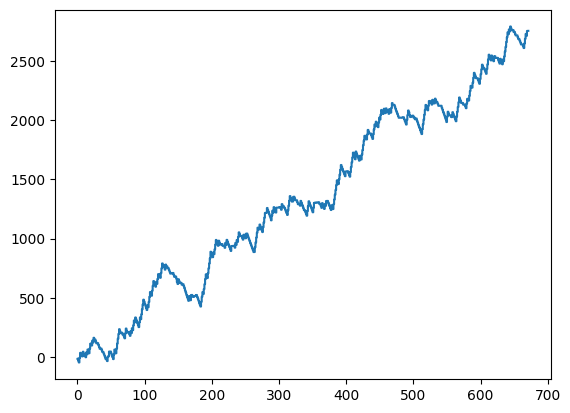

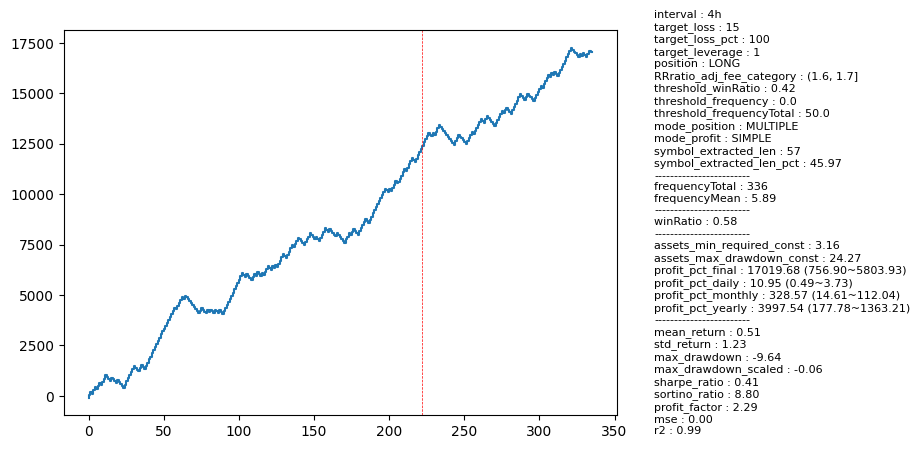

[Bank] IDEP : elasped time, get_output_row : 0.4640s
[Bank] ------------------------------------------------


In [16]:
"""
v2.0
    make a table_trade_result_anchor.
    loop for all.
    eval. indicator added.
        ~ mse, r2
v2.1
    apply functional.
    add memory management.
        in plt.savefig, not solved..
    apply dataType.
    
    v2.1.1
        apply set_quantity v1.4.1
    v2.1.2
        apply set_quantity v1.4.2
        add phase for latency check.
        add mode_position to get_output_row

last confirmed at, 20240708 2256.
"""


priceBox_indicator = 'DC'
# priceBox_indicator = 'BB'
priceBox_value = 20
priceBox_value = 60

point_mode = 'CROSS'
point_indicator = 'CCI'
point_indicator = 'II'
# point_indicator = 'DC'
# point_indicator = 'BB'
point_value = 20
point_value = 21
# point_value = 30

zone_indicator = None
# zone_indicator = 'MA'
zone_value = 30

dir_name_strategy = "priceBox_{}_point_{}_{}".format(priceBox_indicator, point_mode, point_indicator)



intervals = [ '15m', '30m', '1h', '2h', '4h',]
# intervals = ['30m', '1h', '2h', '4h',]

train_ratio = 0.7




target_loss = 15 # USDT, for amount_entry.
# target_loss = None

target_loss_pct = 10 # %, for leverage.
target_loss_pct = 15 # %, for leverage.
target_loss_pct = 100
# target_loss_pct = None

leverage_rejection = True
# leverage_rejection = False

target_leverage = 1
# target_leverage = 2
# target_leverage = None



fee_limit = 0.0002
fee_market = 0.0005

unit_RRratio_adj_fee = np.arange(0, 2, 0.1)



mode_position = 'SINGLE'
mode_position = 'MULTIPLE'

mode_profit = 'SIMPLE'
# mode_profit = 'COMPOUND'



positions = ['LONG', 'SHORT']

range_winRatio = np.arange(0.3, 1.0, 0.01)

threshold_frequency = 0
threshold_frequencyTotal = 50




payload = '4h_15_100_1_LONG_(1.6, 1.7]_0.42_0.0_50.0'
# payload = '4h_15_100_1_LONG_(1.6, 1.7]_0.45_0.0_50.0'
# payload = '4h_15_100_1_LONG_(0.0, 0.1]_0.90_0.0_50.0_SINGLE'
# payload = '4h_15_100_1_LONG_(0.0, 0.1]_0.90_0.0_50.0_MULTIPLE'

# payload = '2h	15	100	1	SHORT	(0.3, 0.4]	0.77	0	50'
payload = re.split(r'[\t_]', payload)


intervals = [payload[0]]
# target_loss = int(payload[1])
# target_loss_pct = int(payload[2])
# target_leverage = int(payload[3])
positions = [payload[4]]
RRratio_adj_fee_categories = [payload[5]]
range_winRatio = [float(payload[6])]
threshold_frequency = float(payload[7])
threshold_frequencyTotal = float(payload[8])
# mode_position = payload[9]



show_figure = 1
save_figure = 1


# path_dir_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\{}\image\{}_{}\total".format(dir_name_strategy, priceBox_value, point_value)
path_dir_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\{}\image\{}_{}\{}\total".format(dir_name_strategy, priceBox_value, point_value, zone_indicator)
os.makedirs(path_dir_save_fig, exist_ok=True)

plt.style.use('default')




result_list = []

for interval in intervals:
    
    bank.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    # load table
        # will be replace with sql.
    path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/{}/".format(dir_name_strategy, priceBox_value, point_value, zone_indicator, interval)    
    
    table_trade_res_list = []
    for index, file_name in enumerate(os.listdir(path_dir_table_trade_res)):    
    
        # if 'DOT' in file_name:
        #     pass
        
            path_file = os.path.join(path_dir_table_trade_res, file_name)
            
            if os.path.isfile(path_file):
                table_trade_result_individual = pd.read_feather(path_file)
                # table_trade_result_individual.iloc[:, :13].to_feather(path_file)
                table_trade_res_list.append(table_trade_result_individual)
    
    table_trade_result = pd.concat(table_trade_res_list)
    
    bank.sys_log.debug("IDEP : elasped time, load table_trade_result : {:.4f}s".format(time.time() - start_time))
    bank.sys_log.debug("------------------------------------------------")
    
    

    bank.sys_log.debug("------------------------------------------------")
    start_time = time.time()

    # making table_trade_result_agg & table_trade_result_anchor
    table_trade_result = add_datatype(table_trade_result, 
                                      train_ratio)

    bank.sys_log.debug("IDEP : elasped time, add_datatype : {:.4f}s".format(time.time() - start_time))
    bank.sys_log.debug("------------------------------------------------")
    
    
    bank.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    table_trade_result = set_quantity(table_trade_result,
                                      leverage_limits,
                                      target_loss, 
                                      target_loss_pct, 
                                      target_leverage, 
                                      fee_market, 
                                      fee_market,
                                      unit_RRratio_adj_fee,
                                      leverage_rejection,
                                      )
    
    bank.sys_log.debug("IDEP : elasped time, set_quantity : {:.4f}s".format(time.time() - start_time))
    bank.sys_log.debug("------------------------------------------------")


    
    """
    v1.0
        assert to execute this phase.
            table_trade_result_backup is input for below phase.
    """
    table_trade_result_backup = table_trade_result.copy()
    if len(positions) == 2:
        RRratio_adj_fee_categories = np.unique(table_trade_result_backup.RRratio_adj_fee_category) # when payload exists, we should not use it.

    for position in positions:
        
        for RRratio_adj_fee_category in RRratio_adj_fee_categories:
            
            table_trade_result = table_trade_result_backup[(table_trade_result_backup.position == position) & (table_trade_result_backup.RRratio_adj_fee_category == RRratio_adj_fee_category)]
            table_trade_result_train = table_trade_result[table_trade_result.dataType == 'TRAIN'] # extract symbol from TRAIN data only.
    

            bank.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            try:
                
                """
                v2.0
                    add symbol to pivot_table index.
                
                last confirmed at, 20240605 1106.
                """
                
                # table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot = table_trade_result_train.pivot_table(index=[table_trade_result_train.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result_train.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
                table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
                table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

            except Exception as e:
                print("error in pivoting : {}".format(e))
                continue     
                
            bank.sys_log.debug("IDEP : elasped time, pivoting : {:.4f}s".format(time.time() - start_time))
            bank.sys_log.debug("------------------------------------------------")
            
            
            
            for threshold_winRatio in range_winRatio:
                
                bank.sys_log.debug("------------------------------------------------")
                start_time = time.time()
            
                # symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)].index
                symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)].index
                symbol_extracted = symbol_extracted.droplevel()
                symbol_extracted_len = len(symbol_extracted)
                symbol_extracted_len_pct = symbol_extracted_len / len(table_trade_result_pivot) * 100
                
                bank.sys_log.debug("IDEP : elasped time, symbol_extraction : {:.4f}s".format(time.time() - start_time))
                bank.sys_log.debug("------------------------------------------------")
                
                if symbol_extracted_len > 0:  
                    
                    # table_trade_result_backup['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result_backup.symbol]
                    # table_trade_result_agg = table_trade_result_backup[table_trade_result_backup.symbol_extracted_bool].sort_values('timestamp_entry')
                    table_trade_result['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result.symbol]
                    table_trade_result_agg = table_trade_result[table_trade_result.symbol_extracted_bool].sort_values('timestamp_entry')

                    if mode_position == 'SINGLE':
                        
                        bank.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        table_trade_result_agg = convert_to_position_single(table_trade_result_agg)
                        # table_trade_result_agg = table_trade_result_agg.sort_values('timestamp_entry')                    
                        
                        bank.sys_log.debug("IDEP : elasped time, get_output_row : {:.4f}s".format(time.time() - start_time))
                        bank.sys_log.debug("------------------------------------------------")
                            
                    frequencyTotal = len(table_trade_result_agg)
            
                    
                    if frequencyTotal > threshold_frequencyTotal:     
                        
                        bank.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        row = get_output_row(table_trade_result_agg, 
                                        symbol_extracted, 
                                        symbol_extracted_len, 
                                        symbol_extracted_len_pct, 
                                        interval,
                                        target_loss, 
                                        target_loss_pct, 
                                        target_leverage,
                                        position,
                                        RRratio_adj_fee_category, 
                                        threshold_winRatio,
                                        threshold_frequency, 
                                        threshold_frequencyTotal, 
                                        path_dir_save_fig,
                                        mode_position, 
                                        mode_profit, 
                                        show_figure, 
                                        save_figure)
                        
                        bank.sys_log.debug("IDEP : elasped time, get_output_row : {:.4f}s".format(time.time() - start_time))
                        bank.sys_log.debug("------------------------------------------------")
                        
                        result_list.append(row)

                        # print(f"{interval} {RRratio_adj_fee_category} {threshold_winRatio}", end='\r')                            
        #                 break
        #         break
        # break

In [17]:
table_trade_result_agg_1 = table_trade_result_agg.copy()

In [ ]:
# table_trade_result_agg
# table_trade_result_agg[table_trade_result_agg.status=='SL']
table_trade_result_agg[table_trade_result_agg.status=='TP']

In [ ]:
table_trade_result_agg.describe()

#### v2.1.1

In [ ]:
"""
v2.0
    make a table_trade_result_anchor.
    loop for all.
    eval. indicator added.
        ~ mse, r2
v2.1
    apply functional.
    add memory management.
        in plt.savefig, not solved..
    apply dataType.
    
    v2.1.1
        apply set_quantity v1.4.1

last confirmed at, 20240621 1746.
"""


priceBox_indicator = 'DC'
# priceBox_indicator = 'BB'
priceBox_value = 20
priceBox_value = 60

point_mode = 'CROSS'
point_indicator = 'CCI'
point_indicator = 'II'
# point_indicator = 'DC'
# point_indicator = 'BB'
point_value = 20
point_value = 21
# point_value = 30

zone_indicator = None
# zone_indicator = 'MA'
zone_value = 30

dir_name_strategy = "priceBox_{}_point_{}_{}".format(priceBox_indicator, point_mode, point_indicator)


intervals = [ '15m', '30m', '1h', '2h', '4h',]
# intervals = ['30m', '1h', '2h', '4h',]


train_ratio = 0.7



fee_limit = 0.0002
fee_market = 0.0005

target_loss = 15 # USDT

target_leverage = 1
target_leverage = None



positions = ['LONG', 'SHORT']

range_winRatio = np.arange(0.3, 1.0, 0.01)

unit_RRratio_adj_fee = np.arange(0, 2, 0.1)

threshold_frequency = 0
threshold_frequencyTotal = 50



payload = '4h	15		LONG	(0.0, 0.1]	0.86	0	50'.split('\t')
intervals = [payload[0]]
positions = [payload[3]]
RRratio_adj_fee_categories = [payload[4]]
range_winRatio = [float(payload[5])]
threshold_frequency = float(payload[6])
threshold_frequencyTotal = float(payload[7])



show_figure = 1
save_figure = 0


# path_dir_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\{}\image\{}_{}\total".format(dir_name_strategy, priceBox_value, point_value)
path_dir_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\{}\image\{}_{}\{}\total".format(dir_name_strategy, priceBox_value, point_value, zone_indicator)
os.makedirs(path_dir_save_fig, exist_ok=True)

plt.style.use('default')




result_list = []
for interval in intervals:
    
    # path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/".format(dir_name_strategy, priceBox_value, point_value, interval)
    path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/{}/".format(dir_name_strategy, priceBox_value, point_value, zone_indicator, interval)
    
    
    table_trade_res_list = []
    for index, file_name in enumerate(os.listdir(path_dir_table_trade_res)):    
    
        # if 'DOT' in file_name:
        #     pass
        
            path_file = os.path.join(path_dir_table_trade_res, file_name)
            
            if os.path.isfile(path_file):
                table_trade_result_individual = pd.read_feather(path_file)
                # table_trade_result_individual.iloc[:, :13].to_feather(path_file)
                table_trade_res_list.append(table_trade_result_individual)
    
    table_trade_result = pd.concat(table_trade_res_list)

    
    timestamp_entry = table_trade_result['timestamp_entry'].to_numpy()
    timestamp_min = table_trade_result['timestamp_entry'].min()
    timestamp_max = table_trade_result['timestamp_entry'].max()
    
    # train_ratio = 0.7
    timestamp_train = timestamp_min + (timestamp_max - timestamp_min) * train_ratio
    
    table_trade_result['dataType'] = np.where(timestamp_entry < timestamp_train, 'TRAIN', 'TEST')


    
    """
    v1.1
        define ~ to_numpy() as a var. for keep usage
        add RRratio_adj_fee
        modify income & commission to income & commission
    v1.2
        move RRratio to anal phase.
        set target_loss.
            income calculated from quantity.
    v1.3
        modify 'income' to support LONG & SHORT one table.
        add loss_pct
        add profit.
    v1.4
        rearrange with to_numpy()
    v1.4.1
        "fee will be placed in here."
    
    last confirmed at, 20240611 1158.
    """
    
    
    # fee_entry = 0.0005 # temporary static
    # fee_exit = 0.0005 # temporary static
    
    # target_loss = 5 # USDT
    
    # target_loss_pct = 0.05 # USDT
    
    # target_leverage = 1
    # target_leverage = 10
    
    
    
    price_take_profit = table_trade_result.price_take_profit.to_numpy()
    price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
    price_entry = table_trade_result.price_entry.to_numpy()
    price_exit = table_trade_result.price_exit.to_numpy()
    
    
    
    table_trade_result['fee_entry'] = fee_market
    table_trade_result['fee_exit'] = fee_market
    
    fee_entry = table_trade_result.fee_entry.to_numpy()
    fee_exit = table_trade_result.fee_exit.to_numpy()
    
    
    
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
    loss_pct = loss / price_entry # this is official pct for SHORT. price_entry is an initial_price in SHORT position too.
    # loss_pct = np.where(table_trade_result.position.to_numpy() == 'SHORT', loss / price_stop_loss, loss / price_entry)
    quantity = target_loss / loss
    
    table_trade_result['loss'] = loss
    table_trade_result['loss_pct'] = loss_pct
    table_trade_result['quantity'] = quantity
    
    
    
    amount_entry = price_entry * quantity
    amount_exit = price_exit * quantity
    
    commission = amount_entry * fee_entry + amount_exit * fee_exit
    
    income = amount_exit - amount_entry
    income = np.where(table_trade_result.position.to_numpy() == 'SHORT', -income, income)
    
    table_trade_result['commission'] = commission
    table_trade_result['income'] = income
    table_trade_result['income - commission'] = income - commission
    
    
    
    table_trade_result['amount_entry'] = amount_entry
    leverage_limit = (table_trade_result['amount_entry'] / target_loss).apply(math.floor).to_numpy() # apply support series. # floor : amount_adj_leverage > target_loss.
    # table_trade_result['leverage_limit'] = (amount_entry / target_loss).astype(int) # math support multiple options
    table_trade_result['leverage_limit'] = np.where(leverage_limit < 1, 1, leverage_limit) # min leverage = 1

    
    if target_leverage is None:
        leverage = leverage_limit
    else:
        leverage = np.where(target_leverage > leverage_limit, leverage_limit, target_leverage)
    table_trade_result['leverage'] = leverage
    table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage
    
    table_trade_result['profit'] = table_trade_result['income - commission'].to_numpy() / amount_entry * leverage
    table_trade_result['profit (%)'] = table_trade_result.profit.to_numpy() * 100


    

    # point (sparse value)
    
    # zone (continuous value)
        # default
    table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
    table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))
    # table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]
    
    # unit_RRratio_adj_fee = np.arange(0, 1, 0.1)
    # unit_RRratio_adj_fee = np.arange(0, 2, 0.1)
    table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)

    
    """
    v1.0
        assert to execute this phase.
            table_trade_result_backup is input for below phase.
    """
    table_trade_result_backup = table_trade_result.copy()
    if len(positions) == 2:
        RRratio_adj_fee_categories = np.unique(table_trade_result_backup.RRratio_adj_fee_category) # when payload exists, we should not use it.

    for position in positions:
    # position = 'LONG'
    # position = 'SHORT'
        
        for RRratio_adj_fee_category in RRratio_adj_fee_categories:            
            # RRratio_adj_fee_category = '(0.1, 0.2]' # if catergory gets larger, lesser frequency (= lower reliability) & lower winRatio 
            table_trade_result = table_trade_result_backup[(table_trade_result_backup.position == position) & (table_trade_result_backup.RRratio_adj_fee_category == RRratio_adj_fee_category)]
            table_trade_result_train = table_trade_result[table_trade_result.dataType == 'TRAIN'] # extract symbol from TRAIN data only.
    

            try:
                
                """
                v2.0
                    add symbol to pivot_table index.
                
                last confirmed at, 20240605 1106.
                """
                
                # table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot = table_trade_result_train.pivot_table(index=[table_trade_result_train.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result_train.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
                table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
                table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

            except Exception as e:
                print("error in pivoting : {}".format(e))
                continue            
                
            
            
            
            # range_winRatio = np.arange(0.3, 1.0, 0.01) # could know the minimum value for profit rightTopness. 
            
            # threshold_winRatio = 0.82
            
            # threshold_frequency = 0
            # threshold_frequency = 40
            # threshold_frequency = 70
            
            # threshold_frequencyTotal = 0
            # threshold_frequencyTotal = 50
            # threshold_incomeTotal = 0.0 # answer should be set before!
            
            
            
            for threshold_winRatio in range_winRatio:
                
                # symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)].index
                symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)].index
                symbol_extracted = symbol_extracted.droplevel()
                # symbol_extracted
                symbol_extracted_len = len(symbol_extracted)
                symbol_extracted_len_pct = symbol_extracted_len / len(table_trade_result_pivot) * 100
                
                if symbol_extracted_len > 0:  
                    
                    # table_trade_result_backup['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result_backup.symbol]
                    # table_trade_result_agg = table_trade_result_backup[table_trade_result_backup.symbol_extracted_bool].sort_values('timestamp_entry')
                    table_trade_result['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result.symbol]
                    table_trade_result_agg = table_trade_result[table_trade_result.symbol_extracted_bool].sort_values('timestamp_entry')
                    
                    # table_trade_result_agg = convert_to_position_single(table_trade_result_agg)                    
                            
                    frequencyTotal = len(table_trade_result_agg)
            
                    
                    if frequencyTotal > threshold_frequencyTotal:     
                        
                        winRatio = len(table_trade_result_agg[table_trade_result_agg.status=='TP']) / frequencyTotal
                        profit_pct_cumsum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy())
                        profit_pct_sum = profit_pct_cumsum[-1]
            
                        frequencyMean = frequencyTotal / symbol_extracted_len
            
                        # sharpRatio
                        profit = table_trade_result_agg.profit.to_numpy()            
                        
                        # Risk-free rate (assumed to be 0 for simplicity)
                        risk_free_rate = 0
                        
                        # Calculate various metrics
                        mean_return = np.mean(profit)
                        std_return = np.std(profit)
                        sharpe_ratio = (mean_return - risk_free_rate) / std_return
                        
                        # Calculate Sortino Ratio
                            # focus on downside more.
                                # safe oriented.
                        downside_returns = profit[profit < 0]
                        downside_deviation = np.std(downside_returns)
                        sortino_ratio = (mean_return - risk_free_rate) / downside_deviation
                        
                        # Calculate Maximum Drawdown
                        cumulative_returns = np.cumsum(profit)
                        drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
                        max_drawdown = np.min(drawdowns)
                        
                        cumulative_returns_min = cumulative_returns.min()
                        cumulative_returns_max = cumulative_returns.max()
                        cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min)
                        drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
                        max_drawdown_scaled = np.min(drawdowns_scaled)
                        # # Min-Max Normalization for a single MDD
                        # min_mdd = drawdowns.max()  # assuming the minimum possible MDD is 0
                        # max_mdd = drawdowns.min()  # assuming the maximum possible MDD is 1
                        
                        # # Normalize the Max Drawdown to the range [0, 1]
                        # normalized_max_drawdown = (max_drawdown - min_mdd) / (max_mdd - min_mdd)
                        
                        # Calculate Calmar Ratio
                        # annual_return = mean_return * 12  # Assuming monthly profit
                        # calmar_ratio = annual_return / -max_drawdown
                        
                        # Calculate Profit Factor
                        total_profit = np.sum(profit[profit > 0])
                        total_loss = -np.sum(profit[profit < 0])
                        profit_factor = total_profit / total_loss

                        
                        x = np.linspace(0, 1, len(cumulative_returns_scaled))
                        # y_actual = x**2
                        y_actual = x # v0.2 : closer concept to 'consistency'
                        y_predicted = cumulative_returns_scaled
                        
                        mse = mean_squared_error(y_actual, y_predicted)                        
                        r2 = r2_score(y_actual, y_predicted)
                        

                        timestamp_min = table_trade_result_agg['timestamp_entry'].iloc[0]
                        table_trade_result_agg['timemap_entry'] = table_trade_result_agg['timestamp_entry'] - timestamp_min
                        table_trade_result_agg['timemap_exit'] = table_trade_result_agg['timestamp_exit'] - timestamp_min
                        
                        minutes = itv_to_number(interval)
                        timestamp_unit = 60 * minutes # 15min. case
                        table_trade_result_agg['timemap_entry'] /= timestamp_unit
                        table_trade_result_agg['timemap_exit'] /= timestamp_unit
                        
                        
                        map_amount_agg = np.zeros(int(table_trade_result_agg['timemap_exit'].iloc[-1]))
                        for cnt, (row) in enumerate(table_trade_result_agg[['timemap_entry', 'timemap_exit', 'amount_entry_adj_leverage']].to_numpy()):
                            
                            index_start, index_end, amount = row                            
                            map_amount_agg[int(index_start):int(index_end) + 1] += amount
                        
                        map_amount_agg_max = map_amount_agg.max()
                            
            
                        row = [
                            interval,
                            target_loss,
                            target_leverage,
                            position,
                            RRratio_adj_fee_category,
                            threshold_winRatio,
                            threshold_frequency,
                            threshold_frequencyTotal,
                            "{}".format(symbol_extracted.tolist()),
                            symbol_extracted_len,
                            symbol_extracted_len_pct,
                            frequencyTotal,
                            frequencyMean,
                            winRatio,
                            profit_pct_sum,
                            mean_return,
                            std_return,
                            max_drawdown,
                            max_drawdown_scaled,
                            sharpe_ratio,
                            sortino_ratio,
                            profit_factor,
                            mse,
                            r2,
                            map_amount_agg_max,
                        ]
                        
                        result_list.append(row)
                        
                        title = ''
                        title += 'interval : {}\n'.format(interval)
                        title += 'target_loss : {}\n'.format(target_loss)
                        title += 'target_leverage : {}\n'.format(target_leverage)
                        title += 'position : {}\n'.format(position)
                        title += 'RRratio_adj_fee_category : {}\n'.format(RRratio_adj_fee_category)
                        title += 'threshold_winRatio : {:.2f}\n'.format(threshold_winRatio)
                        title += 'threshold_frequency : {}\n'.format(threshold_frequency)
                        title += 'threshold_frequencyTotal : {}\n'.format(threshold_frequencyTotal)
                        # title += 'symbol_extracted : {}\n'.format(symbol_extracted)
                        title += 'symbol_extracted_len : {}\n'.format(symbol_extracted_len)
                        title += 'symbol_extracted_len_pct : {:.2f}\n'.format(symbol_extracted_len_pct)
                        title += 'frequencyTotal : {}\n'.format(frequencyTotal)
                        title += 'frequencyMean : {:.2f}\n'.format(frequencyMean)
                        title += 'winRatio : {:.2f}\n'.format(winRatio)
                        title += 'profit_pct_sum : {:.2f}\n'.format(profit_pct_sum)
                        title += 'mean_return : {:.2f}\n'.format(mean_return)
                        title += 'std_return : {:.2f}\n'.format(std_return)
                        title += 'max_drawdown : {:.2f}\n'.format(max_drawdown)
                        title += 'max_drawdown_scaled : {:.2f}\n'.format(max_drawdown_scaled)
                        title += 'sharpe_ratio : {:.2f}\n'.format(sharpe_ratio)
                        title += 'sortino_ratio : {:.2f}\n'.format(sortino_ratio)
                        title += 'profit_factor : {:.2f}\n'.format(profit_factor)
                        title += 'mse : {:.2f}\n'.format(mse)
                        title += 'r2 : {:.2f}\n'.format(r2)
                        title += 'map_amount_agg_max : {:.2f}'.format(map_amount_agg_max)
                        
                        
                        print(title)    
                        clear_output()
                        

                        if show_figure:
                            plt.figure()
                            plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cumsum)
                            plt.title(title, y=0., fontsize=10)

                            if save_figure:
                                plt.tight_layout()
                                payload = '{}	{}	{}	{}	{}	{:.2f}'.format(interval, target_loss, target_leverage, position, RRratio_adj_fee_category, threshold_winRatio, threshold_frequency, threshold_frequencyTotal).split('\t')                                
                                plt.savefig(os.path.join(path_dir_save_fig, "{}.png".format(payload)))
                            else:
                                plt.show() # require some time.
                                
                            plt.close('all')
                            # gc.collect() # require time a lot...
                            
        #                 break
        #         break
        # break

#### v2.1

In [ ]:
"""
v2.0
    make a table_trade_result_anchor.
    loop for all.
    eval. indicator added.
        ~ mse, r2
v2.1
    apply functional.
    add memory management.
        in plt.savefig, not solved..
    apply dataType.

last confirmed at, 20240619 0943.
"""


dir_name_strategy = "priceBox_DC_point_Cross_DC"
# dir_name_strategy = "priceBox_DC_point_Cross_II"

priceBox_value = 60

point_value = 30
# point_value = 21


intervals = [ '15m', '30m', '1h', '2h', '4h',]
# intervals = ['30m', '1h', '2h', '4h',]

train_ratio = 0.7

target_loss = 15 # USDT

target_leverage = 1
target_leverage = None


positions = ['LONG', 'SHORT']

range_winRatio = np.arange(0.3, 1.0, 0.01)

unit_RRratio_adj_fee = np.arange(0, 2, 0.1)

threshold_frequency = 0
threshold_frequencyTotal = 50



# payload = '2h	15		LONG	(1.3, 1.4]	0.5	0	50'.split('\t')
# # payload = '30m	5	1	SHORT	(0.5, 0.6]	0.7	0	50'.split('\t')
# intervals = [payload[0]]
# positions = [payload[3]]
# RRratio_adj_fee_categories = [payload[4]]
# range_winRatio = [float(payload[5])]
# threshold_frequency = float(payload[6])
# threshold_frequencyTotal = float(payload[7])



show_figure = 1
save_figure = 0


path_dir_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\{}\image\{}_{}\total".format(dir_name_strategy, priceBox_value, point_value)
os.makedirs(path_dir_save_fig, exist_ok=True)

plt.style.use('default')




result_list = []
for interval in intervals:
    
    path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result/{}_{}/{}/".format(dir_name_strategy, priceBox_value, point_value, interval)
    
    
    table_trade_res_list = []
    for index, file_name in enumerate(os.listdir(path_dir_table_trade_res)):    
    
        # if 'DOT' in file_name:
        #     pass
        
            path_file = os.path.join(path_dir_table_trade_res, file_name)
            
            if os.path.isfile(path_file):
                table_trade_result_individual = pd.read_feather(path_file)
                # table_trade_result_individual.iloc[:, :13].to_feather(path_file)
                table_trade_res_list.append(table_trade_result_individual)
    
    table_trade_result = pd.concat(table_trade_res_list)


    
    timestamp_entry = table_trade_result['timestamp_entry'].to_numpy()
    timestamp_min = table_trade_result['timestamp_entry'].min()
    timestamp_max = table_trade_result['timestamp_entry'].max()
    
    # train_ratio = 0.7
    timestamp_train = timestamp_min + (timestamp_max - timestamp_min) * train_ratio
    
    table_trade_result['dataType'] = np.where(timestamp_entry < timestamp_train, 'TRAIN', 'TEST')

    
    """
    v1.1
        define ~ to_numpy() as a var. for keep usage
        add RRratio_adj_fee
        modify income & commission to income & commission
    v1.2
        move RRratio to anal phase.
        set target_loss.
            income calculated from quantity.
    v1.3
        modify 'income' to support LONG & SHORT one table.
        add loss_pct
        add profit.
    v1.4
        rearrange with to_numpy()
    
    last confirmed at, 20240611 1158.
    """
    
    
    # target_loss = 5 # USDT
    
    # target_loss_pct = 0.05 # USDT
    
    # target_leverage = 1
    # target_leverage = 10
    
    
    
    price_take_profit = table_trade_result.price_take_profit.to_numpy()
    price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
    price_entry = table_trade_result.price_entry.to_numpy()
    price_exit = table_trade_result.price_exit.to_numpy()
    
    fee_entry = table_trade_result.fee_entry.to_numpy()
    fee_exit = table_trade_result.fee_exit.to_numpy()
    
    
    
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
    loss_pct = loss / price_entry # this is official pct for SHORT. price_entry is an initial_price in SHORT position too.
    # loss_pct = np.where(table_trade_result.position.to_numpy() == 'SHORT', loss / price_stop_loss, loss / price_entry)
    quantity = target_loss / loss
    
    table_trade_result['loss'] = loss
    table_trade_result['loss_pct'] = loss_pct
    table_trade_result['quantity'] = quantity
    
    
    
    amount_entry = price_entry * quantity
    amount_exit = price_exit * quantity
    
    commission = amount_entry * fee_entry + amount_exit * fee_exit
    
    income = amount_exit - amount_entry
    income = np.where(table_trade_result.position.to_numpy() == 'SHORT', -income, income)
    
    table_trade_result['commission'] = commission
    table_trade_result['income'] = income
    table_trade_result['income - commission'] = income - commission
    
    
    
    table_trade_result['amount_entry'] = amount_entry
    leverage_limit = (table_trade_result['amount_entry'] / target_loss).apply(math.floor).to_numpy() # apply support series. # floor : amount_adj_leverage > target_loss.
    # table_trade_result['leverage_limit'] = (amount_entry / target_loss).astype(int) # math support multiple options
    table_trade_result['leverage_limit'] = np.where(leverage_limit < 1, 1, leverage_limit) # min leverage = 1
    
    
    
    if target_leverage is None:
        leverage = leverage_limit
    else:
        leverage = np.where(target_leverage > leverage_limit, leverage_limit, target_leverage)
    table_trade_result['leverage'] = leverage
    table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage
    
    table_trade_result['profit'] = table_trade_result['income - commission'].to_numpy() / amount_entry * leverage
    table_trade_result['profit (%)'] = table_trade_result.profit.to_numpy() * 100


    

    # point (sparse value)
    
    # zone (continuous value)
        # default
    table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
    table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))
    # table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]
    
    # unit_RRratio_adj_fee = np.arange(0, 1, 0.1)
    # unit_RRratio_adj_fee = np.arange(0, 2, 0.1)
    table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)

    
    """
    v1.0
        assert to execute this phase.
            table_trade_result_backup is input for below phase.
    """
    table_trade_result_backup = table_trade_result.copy()
    if len(positions) == 2:
        RRratio_adj_fee_categories = np.unique(table_trade_result_backup.RRratio_adj_fee_category) # when payload exists, we should not use it.

    for position in positions:
    # position = 'LONG'
    # position = 'SHORT'
        
        for RRratio_adj_fee_category in RRratio_adj_fee_categories:            
            # RRratio_adj_fee_category = '(0.1, 0.2]' # if catergory gets larger, lesser frequency (= lower reliability) & lower winRatio 
            table_trade_result = table_trade_result_backup[(table_trade_result_backup.position == position) & (table_trade_result_backup.RRratio_adj_fee_category == RRratio_adj_fee_category)]
            table_trade_result_train = table_trade_result[table_trade_result.dataType == 'TRAIN'] # extract symbol from TRAIN data only.
    

            try:
                
                """
                v2.0
                    add symbol to pivot_table index.
                
                last confirmed at, 20240605 1106.
                """
                
                # table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot = table_trade_result_train.pivot_table(index=[table_trade_result_train.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result_train.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
                table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
                table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
                table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]

            except Exception as e:
                print("error in pivoting : {}".format(e))
                continue            
                
            
            
            
            # range_winRatio = np.arange(0.3, 1.0, 0.01) # could know the minimum value for profit rightTopness. 
            
            # threshold_winRatio = 0.82
            
            # threshold_frequency = 0
            # threshold_frequency = 40
            # threshold_frequency = 70
            
            # threshold_frequencyTotal = 0
            # threshold_frequencyTotal = 50
            # threshold_incomeTotal = 0.0 # answer should be set before!
            
            
            
            for threshold_winRatio in range_winRatio:
                
                # symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)].index
                symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)].index
                symbol_extracted = symbol_extracted.droplevel()
                # symbol_extracted
                symbol_extracted_len = len(symbol_extracted)
                symbol_extracted_len_pct = symbol_extracted_len / len(table_trade_result_pivot) * 100
                
                if symbol_extracted_len > 0:  
                    
                    # table_trade_result_backup['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result_backup.symbol]
                    # table_trade_result_agg = table_trade_result_backup[table_trade_result_backup.symbol_extracted_bool].sort_values('timestamp_entry')
                    table_trade_result['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result.symbol]
                    table_trade_result_agg = table_trade_result[table_trade_result.symbol_extracted_bool].sort_values('timestamp_entry')
                            
                    frequencyTotal = len(table_trade_result_agg)
            
                    
                    if frequencyTotal > threshold_frequencyTotal:     
                        
                        winRatio = len(table_trade_result_agg[table_trade_result_agg.status=='TP']) / frequencyTotal
                        profit_pct_cumsum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy())
                        profit_pct_sum = profit_pct_cumsum[-1]
            
                        frequencyMean = frequencyTotal / symbol_extracted_len
            
                        # sharpRatio
                        profit = table_trade_result_agg.profit.to_numpy()            
                        
                        # Risk-free rate (assumed to be 0 for simplicity)
                        risk_free_rate = 0
                        
                        # Calculate various metrics
                        mean_return = np.mean(profit)
                        std_return = np.std(profit)
                        sharpe_ratio = (mean_return - risk_free_rate) / std_return
                        
                        # Calculate Sortino Ratio
                            # focus on downside more.
                                # safe oriented.
                        downside_returns = profit[profit < 0]
                        downside_deviation = np.std(downside_returns)
                        sortino_ratio = (mean_return - risk_free_rate) / downside_deviation
                        
                        # Calculate Maximum Drawdown
                        cumulative_returns = np.cumsum(profit)
                        drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
                        max_drawdown = np.min(drawdowns)
                        
                        cumulative_returns_min = cumulative_returns.min()
                        cumulative_returns_max = cumulative_returns.max()
                        cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min)
                        drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
                        max_drawdown_scaled = np.min(drawdowns_scaled)
                        # # Min-Max Normalization for a single MDD
                        # min_mdd = drawdowns.max()  # assuming the minimum possible MDD is 0
                        # max_mdd = drawdowns.min()  # assuming the maximum possible MDD is 1
                        
                        # # Normalize the Max Drawdown to the range [0, 1]
                        # normalized_max_drawdown = (max_drawdown - min_mdd) / (max_mdd - min_mdd)
                        
                        # Calculate Calmar Ratio
                        # annual_return = mean_return * 12  # Assuming monthly profit
                        # calmar_ratio = annual_return / -max_drawdown
                        
                        # Calculate Profit Factor
                        total_profit = np.sum(profit[profit > 0])
                        total_loss = -np.sum(profit[profit < 0])
                        profit_factor = total_profit / total_loss

                        
                        x = np.linspace(0, 1, len(cumulative_returns_scaled))
                        # y_actual = x**2
                        y_actual = x # v0.2 : closer concept to 'consistency'
                        y_predicted = cumulative_returns_scaled
                        
                        mse = mean_squared_error(y_actual, y_predicted)                        
                        r2 = r2_score(y_actual, y_predicted)
                        

                        timestamp_min = table_trade_result_agg['timestamp_entry'].iloc[0]
                        table_trade_result_agg['timemap_entry'] = table_trade_result_agg['timestamp_entry'] - timestamp_min
                        table_trade_result_agg['timemap_exit'] = table_trade_result_agg['timestamp_exit'] - timestamp_min
                        
                        minutes = itv_to_number(interval)
                        timestamp_unit = 60 * minutes # 15min. case
                        table_trade_result_agg['timemap_entry'] /= timestamp_unit
                        table_trade_result_agg['timemap_exit'] /= timestamp_unit
                        
                        
                        map_amount_agg = np.zeros(int(table_trade_result_agg['timemap_exit'].iloc[-1]))
                        for cnt, (row) in enumerate(table_trade_result_agg[['timemap_entry', 'timemap_exit', 'amount_entry_adj_leverage']].to_numpy()):
                            
                            index_start, index_end, amount = row                            
                            map_amount_agg[int(index_start):int(index_end) + 1] += amount
                        
                        map_amount_agg_max = map_amount_agg.max()
                            
            
                        row = [
                            interval,
                            target_loss,
                            target_leverage,
                            position,
                            RRratio_adj_fee_category,
                            threshold_winRatio,
                            threshold_frequency,
                            threshold_frequencyTotal,
                            "{}".format(symbol_extracted.tolist()),
                            symbol_extracted_len,
                            symbol_extracted_len_pct,
                            frequencyTotal,
                            frequencyMean,
                            winRatio,
                            profit_pct_sum,
                            mean_return,
                            std_return,
                            max_drawdown,
                            max_drawdown_scaled,
                            sharpe_ratio,
                            sortino_ratio,
                            profit_factor,
                            mse,
                            r2,
                            map_amount_agg_max,
                        ]
                        
                        result_list.append(row)
                        
                        title = ''
                        title += 'interval : {}\n'.format(interval)
                        title += 'target_loss : {}\n'.format(target_loss)
                        title += 'target_leverage : {}\n'.format(target_leverage)
                        title += 'position : {}\n'.format(position)
                        title += 'RRratio_adj_fee_category : {}\n'.format(RRratio_adj_fee_category)
                        title += 'threshold_winRatio : {:.2f}\n'.format(threshold_winRatio)
                        title += 'threshold_frequency : {}\n'.format(threshold_frequency)
                        title += 'threshold_frequencyTotal : {}\n'.format(threshold_frequencyTotal)
                        # title += 'symbol_extracted : {}\n'.format(symbol_extracted)
                        title += 'symbol_extracted_len : {}\n'.format(symbol_extracted_len)
                        title += 'symbol_extracted_len_pct : {:.2f}\n'.format(symbol_extracted_len_pct)
                        title += 'frequencyTotal : {}\n'.format(frequencyTotal)
                        title += 'frequencyMean : {:.2f}\n'.format(frequencyMean)
                        title += 'winRatio : {:.2f}\n'.format(winRatio)
                        title += 'profit_pct_sum : {:.2f}\n'.format(profit_pct_sum)
                        title += 'mean_return : {:.2f}\n'.format(mean_return)
                        title += 'std_return : {:.2f}\n'.format(std_return)
                        title += 'max_drawdown : {:.2f}\n'.format(max_drawdown)
                        title += 'max_drawdown_scaled : {:.2f}\n'.format(max_drawdown_scaled)
                        title += 'sharpe_ratio : {:.2f}\n'.format(sharpe_ratio)
                        title += 'sortino_ratio : {:.2f}\n'.format(sortino_ratio)
                        title += 'profit_factor : {:.2f}\n'.format(profit_factor)
                        title += 'mse : {:.2f}\n'.format(mse)
                        title += 'r2 : {:.2f}\n'.format(r2)
                        title += 'map_amount_agg_max : {:.2f}'.format(map_amount_agg_max)
                        
                        
                        print(title)    
                        clear_output()
                        

                        if show_figure:
                            plt.figure()
                            plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cumsum)
                            plt.title(title, y=0., fontsize=10)

                            if save_figure:
                                plt.tight_layout()
                                payload = '{}	{}	{}	{}	{}	{:.2f}'.format(interval, target_loss, target_leverage, position, RRratio_adj_fee_category, threshold_winRatio, threshold_frequency, threshold_frequencyTotal).split('\t')                                
                                plt.savefig(os.path.join(path_dir_save_fig, "{}.png".format(payload)))
                            else:
                                plt.show() # require some time.
                                
                            plt.close('all')
                            # gc.collect() # require time a lot...
                            
        #                 break
        #         break
        # break

#### v2.0

In [ ]:
"""
v2.0
    make a table_trade_result_anchor.
    loop for all.
    eval. indicator added.
        ~ mse, r2

last confirmed at, 20240612 1037.
"""



intervals = [ '15m', '30m', '1h', '2h', '4h',]

target_loss = 15 # USDT

target_leverage = 1
target_leverage = None

period_DC = 60

positions = ['LONG', 'SHORT']

RRratio_adj_fee_categories = np.unique(table_trade_result_backup.RRratio_adj_fee_category)

range_winRatio = np.arange(0.3, 1.0, 0.01)

# payload = '30m	5	1	LONG	(0.6, 0.7]	0.68	0	50'.split('\t')
# intervals = [payload[0]]
# positions = [payload[3]]
# RRratio_adj_fee_categories = [payload[4]]
# range_winRatio = [float(payload[5])]
# threshold_frequency = float(payload[6])
# threshold_frequencyTotal = float(payload[7])

show_figure = 1
save_figure = 0


result_list = []
for interval in intervals:
    
    path_dir_table_trade_res = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_result/{}/{}/".format(interval, period_DC)
    
    
    table_trade_res_list = []
    for index_file, file_name in enumerate(os.listdir(path_dir_table_trade_res)):    
    
        # if 'DOT' in file_name:
        #     pass
        
            path_file = os.path.join(path_dir_table_trade_res, file_name)
            
            if os.path.isfile(path_file):
                table_trade_result_individual = pd.read_feather(path_file)
                # table_trade_result_individual.iloc[:, :13].to_feather(path_file)
                table_trade_res_list.append(table_trade_result_individual)
    
    table_trade_result = pd.concat(table_trade_res_list)

    """
    v1.1
        define ~ to_numpy() as a var. for keep usage
        add RRratio_adj_fee
        modify income & commission to income & commission
    v1.2
        move RRratio to anal phase.
        set target_loss.
            income calculated from quantity.
    v1.3
        modify 'income' to support LONG & SHORT one table.
        add loss_pct
        add profit.
    v1.4
        rearrange with to_numpy()
    
    last confirmed at, 20240611 1158.
    """
    
    
    # target_loss = 5 # USDT
    
    # target_loss_pct = 0.05 # USDT
    
    # target_leverage = 1
    # target_leverage = 10
    
    
    
    price_take_profit = table_trade_result.price_take_profit.to_numpy()
    price_stop_loss = table_trade_result.price_stop_loss.to_numpy()
    price_entry = table_trade_result.price_entry.to_numpy()
    price_exit = table_trade_result.price_exit.to_numpy()
    
    fee_entry = table_trade_result.fee_entry.to_numpy()
    fee_exit = table_trade_result.fee_exit.to_numpy()
    
    
    
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit) # default quantity = 1
    loss_pct = loss / price_entry # this is official pct for SHORT. price_entry is an initial_price in SHORT position too.
    # loss_pct = np.where(table_trade_result.position.to_numpy() == 'SHORT', loss / price_stop_loss, loss / price_entry)
    quantity = target_loss / loss
    
    table_trade_result['loss'] = loss
    table_trade_result['loss_pct'] = loss_pct
    table_trade_result['quantity'] = quantity
    
    
    
    amount_entry = price_entry * quantity
    amount_exit = price_exit * quantity
    
    commission = amount_entry * fee_entry + amount_exit * fee_exit
    
    income = amount_exit - amount_entry
    income = np.where(table_trade_result.position.to_numpy() == 'SHORT', -income, income)
    
    table_trade_result['commission'] = commission
    table_trade_result['income'] = income
    table_trade_result['income - commission'] = income - commission
    
    
    
    table_trade_result['amount_entry'] = amount_entry
    leverage_limit = (table_trade_result['amount_entry'] / target_loss).apply(math.floor).to_numpy() # apply support series. # floor : amount_adj_leverage > target_loss.
    # table_trade_result['leverage_limit'] = (amount_entry / target_loss).astype(int) # math support multiple options
    table_trade_result['leverage_limit'] = np.where(leverage_limit < 1, 1, leverage_limit) # min leverage = 1
    
    
    
    if target_leverage is None:
        leverage = leverage_limit
    else:
        leverage = np.where(target_leverage > leverage_limit, leverage_limit, target_leverage)
    table_trade_result['leverage'] = leverage
    table_trade_result['amount_entry_adj_leverage'] = amount_entry / leverage
    
    table_trade_result['profit'] = table_trade_result['income - commission'].to_numpy() / amount_entry * leverage
    table_trade_result['profit (%)'] = table_trade_result.profit.to_numpy() * 100

    # point (sparse value)
    
    # zone (continuous value)
        # default
    table_trade_result['RRratio'] = abs(price_take_profit - price_entry) / abs(price_entry - price_stop_loss)
    table_trade_result['RRratio_adj_fee'] = (abs(price_take_profit - price_entry) - (price_entry * fee_entry + price_take_profit * fee_exit)) / (abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit))
    # table_trade_result['DC_percentage'] = DC_percentage[table_trade_result.idx_entry]
    
    # unit_RRratio_adj_fee = np.arange(0, 1, 0.1)
    unit_RRratio_adj_fee = np.arange(0, 2, 0.1)
    table_trade_result['RRratio_adj_fee_category'] = pd.cut(table_trade_result['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)

    
    """
    v1.0
        assert to execute this phase.
            table_trade_result_backup is input for below phase.
    """
    table_trade_result_backup = table_trade_result.copy()
    

    for position in positions:
    # position = 'LONG'
    # position = 'SHORT'
        
        for RRratio_adj_fee_category in RRratio_adj_fee_categories:
            # RRratio_adj_fee_category = '(0.1, 0.2]' # if catergory gets larger, lesser frequency (= lower reliability) & lower winRatio 
            table_trade_result = table_trade_result_backup[(table_trade_result_backup.position == position) & (table_trade_result_backup.RRratio_adj_fee_category == RRratio_adj_fee_category)]
    
    
            """
            v2.0
                add symbol to pivot_table index.
            
            last confirmed at, 20240605 1106.
            """
            
            table_trade_result_pivot = table_trade_result.pivot_table(index=[table_trade_result.RRratio_adj_fee_category, 'symbol'], columns=table_trade_result.status, values=['status', 'income - commission'], aggfunc={'status': 'count', 'income - commission': 'sum'}, fill_value=0)
            table_trade_result_pivot['frequency'] = table_trade_result_pivot[(             'status', 'SL')] + table_trade_result_pivot[(             'status', 'TP')]
            table_trade_result_pivot['winRatio'] = table_trade_result_pivot[(             'status', 'TP')] / table_trade_result_pivot['frequency']
            table_trade_result_pivot['incomeTotal'] = table_trade_result_pivot[('income - commission', 'SL')] + table_trade_result_pivot[('income - commission', 'TP')]
            
            
            
            
            # range_winRatio = np.arange(0.3, 1.0, 0.01) # could know the minimum value for profit rightTopness. 
            
            # threshold_winRatio = 0.82
            
            # threshold_frequency = 0
            # threshold_frequency = 40
            # threshold_frequency = 70
            
            # threshold_frequencyTotal = 0
            # threshold_frequencyTotal = 50
            # threshold_incomeTotal = 0.0 # answer should be set before!
            
            
            
            for threshold_winRatio in range_winRatio:
                
                # symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)].index
                symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)].index
                symbol_extracted = symbol_extracted.droplevel()
                # symbol_extracted
                symbol_extracted_len = len(symbol_extracted)
                symbol_extracted_len_pct = symbol_extracted_len / len(table_trade_result_pivot) * 100
                
                if symbol_extracted_len > 0:  
                    
                    table_trade_result['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result.symbol]
                    table_trade_result_agg = table_trade_result[table_trade_result.symbol_extracted_bool].sort_values('timestamp_entry')
                            
                    frequencyTotal = len(table_trade_result_agg)
            
                    
                    if frequencyTotal > threshold_frequencyTotal:     
                        
                        winRatio = len(table_trade_result_agg[table_trade_result_agg.status=='TP']) / frequencyTotal
                        profit_pct_cumsum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy())
                        profit_pct_sum = profit_pct_cumsum[-1]
            
                        frequencyMean = frequencyTotal / symbol_extracted_len
            
                        # sharpRatio
                        profit = table_trade_result_agg.profit.to_numpy()            
                        
                        # Risk-free rate (assumed to be 0 for simplicity)
                        risk_free_rate = 0
                        
                        # Calculate various metrics
                        mean_return = np.mean(profit)
                        std_return = np.std(profit)
                        sharpe_ratio = (mean_return - risk_free_rate) / std_return
                        
                        # Calculate Sortino Ratio
                            # focus on downside more.
                                # safe oriented.
                        downside_returns = profit[profit < 0]
                        downside_deviation = np.std(downside_returns)
                        sortino_ratio = (mean_return - risk_free_rate) / downside_deviation
                        
                        # Calculate Maximum Drawdown
                        cumulative_returns = np.cumsum(profit)
                        drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
                        max_drawdown = np.min(drawdowns)
                        
                        cumulative_returns_min = cumulative_returns.min()
                        cumulative_returns_max = cumulative_returns.max()
                        cumulative_returns_scaled = (cumulative_returns - cumulative_returns_min) / (cumulative_returns_max - cumulative_returns_min)
                        drawdowns_scaled = cumulative_returns_scaled - np.maximum.accumulate(cumulative_returns_scaled)
                        max_drawdown_scaled = np.min(drawdowns_scaled)
                        # # Min-Max Normalization for a single MDD
                        # min_mdd = drawdowns.max()  # assuming the minimum possible MDD is 0
                        # max_mdd = drawdowns.min()  # assuming the maximum possible MDD is 1
                        
                        # # Normalize the Max Drawdown to the range [0, 1]
                        # normalized_max_drawdown = (max_drawdown - min_mdd) / (max_mdd - min_mdd)
                        
                        # Calculate Calmar Ratio
                        # annual_return = mean_return * 12  # Assuming monthly profit
                        # calmar_ratio = annual_return / -max_drawdown
                        
                        # Calculate Profit Factor
                        total_profit = np.sum(profit[profit > 0])
                        total_loss = -np.sum(profit[profit < 0])
                        profit_factor = total_profit / total_loss

                        
                        x = np.linspace(0, 1, len(cumulative_returns_scaled))
                        # y_actual = x**2
                        y_actual = x # v0.2 : closer concept to 'consistency'
                        y_predicted = cumulative_returns_scaled
                        
                        mse = mean_squared_error(y_actual, y_predicted)                        
                        r2 = r2_score(y_actual, y_predicted)
                        

                        timestamp_min = table_trade_result_agg['timestamp_entry'].iloc[0]
                        table_trade_result_agg['timemap_entry'] = table_trade_result_agg['timestamp_entry'] - timestamp_min
                        table_trade_result_agg['timemap_exit'] = table_trade_result_agg['timestamp_exit'] - timestamp_min
                        
                        minutes = itv_to_number(interval)
                        timestamp_unit = 60 * minutes # 15min. case
                        table_trade_result_agg['timemap_entry'] /= timestamp_unit
                        table_trade_result_agg['timemap_exit'] /= timestamp_unit
                        
                        
                        map_amount_agg = np.zeros(int(table_trade_result_agg['timemap_exit'].iloc[-1]))
                        for cnt, (row) in enumerate(table_trade_result_agg[['timemap_entry', 'timemap_exit', 'amount_entry_adj_leverage']].to_numpy()):
                            
                            index_start, index_end, amount = row                            
                            map_amount_agg[int(index_start):int(index_end) + 1] += amount
                        
                        map_amount_agg_max = map_amount_agg.max()
                            
            
                        row = [
                            interval,
                            target_loss,
                            target_leverage,
                            position,
                            RRratio_adj_fee_category,
                            threshold_winRatio,
                            threshold_frequency,
                            threshold_frequencyTotal,
                            "{}".format(symbol_extracted.tolist()),
                            symbol_extracted_len,
                            symbol_extracted_len_pct,
                            frequencyTotal,
                            frequencyMean,
                            winRatio,
                            profit_pct_sum,
                            mean_return,
                            std_return,
                            max_drawdown,
                            max_drawdown_scaled,
                            sharpe_ratio,
                            sortino_ratio,
                            profit_factor,
                            mse,
                            r2,
                            map_amount_agg_max,
                        ]
                        
                        result_list.append(row)
                        
                        title = ''
                        title += 'interval : {}\n'.format(interval)
                        title += 'target_loss : {}\n'.format(target_loss)
                        title += 'target_leverage : {}\n'.format(target_leverage)
                        title += 'position : {}\n'.format(position)
                        title += 'RRratio_adj_fee_category : {}\n'.format(RRratio_adj_fee_category)
                        title += 'threshold_winRatio : {}\n'.format(threshold_winRatio)
                        title += 'threshold_frequency : {}\n'.format(threshold_frequency)
                        title += 'threshold_frequencyTotal : {}\n'.format(threshold_frequencyTotal)
                        # title += 'symbol_extracted : {}\n'.format(symbol_extracted)
                        title += 'symbol_extracted_len : {}\n'.format(symbol_extracted_len)
                        title += 'symbol_extracted_len_pct : {:.2f}\n'.format(symbol_extracted_len_pct)
                        title += 'frequencyTotal : {}\n'.format(frequencyTotal)
                        title += 'frequencyMean : {:.2f}\n'.format(frequencyMean)
                        title += 'winRatio : {:.2f}\n'.format(winRatio)
                        title += 'profit_pct_sum : {:.2f}\n'.format(profit_pct_sum)
                        title += 'mean_return : {:.2f}\n'.format(mean_return)
                        title += 'std_return : {:.2f}\n'.format(std_return)
                        title += 'max_drawdown : {:.2f}\n'.format(max_drawdown)
                        title += 'max_drawdown_scaled : {:.2f}\n'.format(max_drawdown_scaled)
                        title += 'sharpe_ratio : {:.2f}\n'.format(sharpe_ratio)
                        title += 'sortino_ratio : {:.2f}\n'.format(sortino_ratio)
                        title += 'profit_factor : {:.2f}\n'.format(profit_factor)
                        title += 'mse : {:.2f}\n'.format(mse)
                        title += 'r2 : {:.2f}\n'.format(r2)
                        title += 'map_amount_agg_max : {:.2f}'.format(map_amount_agg_max)
                        
                        
                        print(title)    
                        clear_output()
                        

                        if show_figure:
                            plt.figure()
                            plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cumsum)
                            plt.title(title, y=0., fontsize=10)

                            if save_figure:
                                plt.tight_layout()
                                payload = '{}	{}	{}	{}	{}	{:.2f}'.format(interval, target_loss, target_leverage, position, RRratio_adj_fee_category, threshold_winRatio, threshold_frequency, threshold_frequencyTotal).split('\t')
                                path_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\DC_II_cross\image\total\v0.3\{}.png".format(payload)
                                plt.savefig(path_save_fig)
                            else:                            
                                plt.show()
                            
        #                 break
        #         break
        # break

#### v1.0

In [ ]:
range_winRatio = np.arange(0.3, 1.0, 0.01)# could know the minimum value for profit rightTopness. 
range_winRatio = [0.62] 

# threshold_winRatio = 0.82

threshold_frequency = 0
# threshold_frequency = 40
# threshold_frequency = 70

threshold_frequencyTotal = 0
threshold_frequencyTotal = 50
# threshold_incomeTotal = 0.0 # answer should be set before!



for threshold_winRatio in range_winRatio:
    
    # symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency) & (table_trade_result_pivot.incomeTotal > threshold_incomeTotal)].index
    symbol_extracted = table_trade_result_pivot[(table_trade_result_pivot.winRatio > threshold_winRatio) & (table_trade_result_pivot.frequency > threshold_frequency)].index
    symbol_extracted = symbol_extracted.droplevel()
    # symbol_extracted
    symbol_extracted_len = len(symbol_extracted)
    symbol_extracted_len_pct = symbol_extracted_len / len(table_trade_result_pivot) * 100
    
    if symbol_extracted_len > 0:  
        
        table_trade_result['symbol_extracted_bool'] = [symbol in symbol_extracted for symbol in table_trade_result.symbol]
        table_trade_result_agg = table_trade_result[table_trade_result.symbol_extracted_bool].sort_values('timestamp_entry')
                
        frequencyTotal = len(table_trade_result_agg)

        
        if frequencyTotal > threshold_frequencyTotal:     
            
            winRatio = len(table_trade_result_agg[table_trade_result_agg.status=='TP']) / frequencyTotal
            profit_pct_cumsum = np.cumsum(table_trade_result_agg['profit (%)'].to_numpy())
            profit_pct_sum = profit_pct_cumsum[-1]

            frequencyMean = frequencyTotal / symbol_extracted_len

            # sharpRatio
            profit = table_trade_result_agg.profit.to_numpy()            
            
            # Risk-free rate (assumed to be 0 for simplicity)
            risk_free_rate = 0
            
            # Calculate various metrics
            mean_return = np.mean(profit)
            std_return = np.std(profit)
            sharpe_ratio = (mean_return - risk_free_rate) / std_return
            
            # Calculate Sortino Ratio
            downside_returns = profit[profit < 0]
            downside_deviation = np.std(downside_returns)
            sortino_ratio = (mean_return - risk_free_rate) / downside_deviation
            
            # Calculate Maximum Drawdown
            cumulative_returns = np.cumsum(profit)
            drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
            max_drawdown = np.min(drawdowns)
            
            # Calculate Calmar Ratio
            # annual_return = mean_return * 12  # Assuming monthly profit
            # calmar_ratio = annual_return / -max_drawdown
            
            # Calculate Profit Factor
            total_profit = np.sum(profit[profit > 0])
            total_loss = -np.sum(profit[profit < 0])
            profit_factor = total_profit / total_loss

            row = [
                interval,
                target_loss,
                target_leverage,
                position,
                RRratio_adj_fee_category,
                threshold_winRatio,
                threshold_frequency,
                threshold_frequencyTotal,
                "{}".format(symbol_extracted.tolist()),
                symbol_extracted_len,
                symbol_extracted_len_pct,
                frequencyTotal,
                frequencyMean,
                winRatio,
                profit_pct_sum,
                mean_return,
                std_return,
                max_drawdown,
                sharpe_ratio,
                sortino_ratio,
                profit_factor
            ]
            
            result_list.append(row)
            
            print("interval : {}".format(interval)) 
            print("target_loss : {}".format(target_loss)) 
            print("target_leverage : {}".format(target_leverage))     
            print("position : {}".format(position))      
            print("RRratio_adj_fee_category : {}".format(RRratio_adj_fee_category))                
            print("threshold_winRatio : {}".format(threshold_winRatio))     
            print("threshold_frequency : {}".format(threshold_frequency))   
            print("threshold_frequencyTotal : {}\n".format(threshold_frequencyTotal))               
            print("symbol_extracted_len : {} ({:.2%})".format(symbol_extracted_len, symbol_extracted_len / len(table_trade_result_pivot)))   
            print("frequencyTotal : {}".format(frequencyTotal))    
            print("frequencyTotal / symbol_extracted_len : {}".format(frequencyTotal / symbol_extracted_len))                
            print("winRatio : {}".format(winRatio))    
            print("profit_pct_cumsum : {}\n".format(profit_pct_cumsum[-1]))  
            print("Mean Return : {}".format(mean_return))
            print("Standard Deviation : {}".format(std_return))
            print("Maximum Drawdown : {}".format(max_drawdown))
            print("Sharpe Ratio (0/1/2) : {}".format(sharpe_ratio))
            print("Sortino Ratio (1/2/3) : {}".format(sortino_ratio))
            print("Profit Factor (1/1.5/2) : {}".format(profit_factor))

            
            # plt.plot(np.cumsum(table_trade_result_agg['income - commission'].to_numpy()))
            # plt.step(np.arange(len(table_trade_result_agg)), np.cumsum(table_trade_result_agg['income - commission'].to_numpy()))
            plt.step(np.arange(len(table_trade_result_agg)), profit_pct_cumsum)
            plt.show()

### check individuals

In [ ]:
table_trade_result_target

In [ ]:

for symbol in symbol_extracted:
    
    table_trade_result_target = table_trade_result[table_trade_result.symbol==symbol]

    frequency = len(table_trade_result_target)
    winRatio = len(table_trade_result_target[table_trade_result_target.status=='TP']) / frequency
    
    print("symbol : {}".format(symbol))
    print("frequency : {}".format(frequency))
    print("winRatio : {}".format(winRatio))
    
    # plt.plot(np.cumsum(table_trade_result_target['income - commission'].to_numpy()))
    plt.step(np.arange(len(table_trade_result_target)), np.cumsum(table_trade_result_target['income - commission'].to_numpy()))
    plt.show()
    
    # break

In [ ]:
symbol_extracted

### get max amount (adj. leverage)

In [ ]:
timestamp_min = table_trade_result_agg['timestamp_entry'].iloc[0]
table_trade_result_agg['timemap_entry'] = table_trade_result_agg['timestamp_entry'] - timestamp_min
table_trade_result_agg['timemap_exit'] = table_trade_result_agg['timestamp_exit'] - timestamp_min

minutes = itv_to_number(interval)
timestamp_unit = 60 * minutes # 15min. case
table_trade_result_agg['timemap_entry'] /= timestamp_unit
table_trade_result_agg['timemap_exit'] /= timestamp_unit


map_amount_agg = np.zeros(int(table_trade_result_agg['timemap_exit'].iloc[-1]))

# for cnt, (_, row) in enumerate(table_trade_result_agg[['timestamp_entry', 'timestamp_exit', 'amount']].iterrows()):
for cnt, (row) in enumerate(table_trade_result_agg[['timemap_entry', 'timemap_exit', 'amount_entry_adj_leverage']].to_numpy()):

    print(cnt, end='\r')
    
    index_start, index_end, amount = row
    # print(index_start, index_end, amount)
    
    map_amount_agg[int(index_start):int(index_end) + 1] += amount
    # print(map_amount_agg)
    # break

print(minutes)
print(map_amount_agg.max())

In [ ]:
table_trade_result_agg.describe() #.head()
# table_trade_result_agg #.head()
# table_trade_result_agg['timestamp_exit'].iloc[-1]

In [ ]:
# plt.step(np.arange(len(map_amount_agg)), map_amount_agg)
plt.step(np.arange(len(table_trade_result_agg.amount_entry)), table_trade_result_agg.amount_entry)

## save table_trade_result

### v2.0

In [ ]:
"""
v2.0
    modify column following to get_output_row

last confirmed at, 20240704 1357.
"""


columns = [
    'interval',
    'target_loss',
    'target_loss_pct', 
    'target_leverage',
    'position',
    'RRratio_adj_fee_category',
    'threshold_winRatio',
    'threshold_frequency',
    'threshold_frequencyTotal',
    'symbol_extracted',
    'symbol_extracted_len',
    'symbol_extracted_len_pct',
    'frequencyTotal',
    'frequencyMean',
    'winRatio',
    'assets_min_required_const',
    'assets_max_drawdown_const',
    'profit_pct_final',
    'profit_pct_daily', 
    'profit_pct_monthly',
    'profit_pct_yearly',
    'profit_pct_final_min',
    'profit_pct_daily_min', 
    'profit_pct_monthly_min',
    'profit_pct_yearly_min',
    'profit_pct_final_max',
    'profit_pct_daily_max', 
    'profit_pct_monthly_max',
    'profit_pct_yearly_max',
    'mean_return',
    'std_return',
    'max_drawdown',
    'max_drawdown_scaled',
    'sharpe_ratio',
    'sortino_ratio',
    'profit_factor',
    'mse',
    'r2'
]

columns_reorder = [
    'r2',
    'max_drawdown_scaled',
    'frequencyTotal',
    'frequencyMean',
    'symbol_extracted_len_pct',
    'profit_pct_monthly_min',
    'profit_pct_monthly_max',
    'winRatio',
    
    'interval',
    'target_loss',
    'target_loss_pct', 
    'target_leverage',
    'position',
    'RRratio_adj_fee_category',
    'threshold_winRatio',
    'threshold_frequency',
    'threshold_frequencyTotal',
    'symbol_extracted',
    'symbol_extracted_len',
    'assets_min_required_const',
    'assets_max_drawdown_const',
    'profit_pct_final',
    'profit_pct_daily', 
    'profit_pct_monthly',
    'profit_pct_yearly',
    'profit_pct_final_min',
    'profit_pct_daily_min', 
    'profit_pct_yearly_min',
    'profit_pct_final_max',
    'profit_pct_daily_max', 
    'profit_pct_yearly_max',
    'mean_return',
    'std_return',
    'max_drawdown',
    'sharpe_ratio',
    'sortino_ratio',
    'profit_factor',
    'mse',
]

table_trade_result_anchor =  pd.DataFrame(result_list, columns=columns) #.head()

### v1.0

In [ ]:
columns = [
        'interval',
        'target_loss',
        'target_loss_pct', 
        'target_leverage',
        'position',
        'RRratio_adj_fee_category',
        'threshold_winRatio',
        'threshold_frequency',
        'threshold_frequencyTotal',
        'symbol_extracted',
        'symbol_extracted_len',
        'symbol_extracted_len_pct',
        'frequencyTotal',
        'frequencyMean',
        'winRatio',
        'profit_pct_sum',
        'mean_return',
        'std_return',
        'max_drawdown',
        'max_drawdown_scaled',
        'sharpe_ratio',
        'sortino_ratio',
        'profit_factor',
        'mse',
        'r2',
        'map_amount_agg_max'
    ]

columns_reorder = [
        'r2',
        'max_drawdown_scaled',
        'frequencyMean',
        'symbol_extracted_len_pct',
    
        'interval',
        'target_loss',
        'target_loss_pct', 
        'target_leverage',
        'position',
        'RRratio_adj_fee_category',
        'threshold_winRatio',
        'threshold_frequency',
        'threshold_frequencyTotal',
        'symbol_extracted',
        'symbol_extracted_len',
        'frequencyTotal',
        'winRatio',
        'profit_pct_sum',
        'mean_return',
        'std_return',
        'max_drawdown',
        'sharpe_ratio',
        'sortino_ratio',
        'profit_factor',
        'mse',
        'map_amount_agg_max'
    ]

table_trade_result_anchor =  pd.DataFrame(result_list, columns=columns) #.head()

In [ ]:
table_trade_result_anchor#.head()

### excel

In [ ]:
path_dir_table_trade_result_anchor = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result_anchor/{}_{}/{}".format(dir_name_strategy, priceBox_value, point_value, zone_indicator)
os.makedirs(path_dir_table_trade_result_anchor, exist_ok=True)

table_trade_result_anchor.to_excel(os.path.join(path_dir_table_trade_result_anchor, "{}.xlsx".format(datetime.now().strftime('%Y%m%d%H%M'))), index=0)#.tail()
# table_trade_result_anchor[columns_reorder].to_excel(os.path.join(path_dir_table_trade_result_anchor, "{}.xlsx".format(datetime.now().strftime('%Y%m%d%H%M'))), index=0)#.tail()

### csv

In [ ]:
path_dir_table_trade_result_anchor = r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/{}/table_trade_result_anchor/{}_{}/{}".format(dir_name_strategy, priceBox_value, point_value, zone_indicator)
os.makedirs(path_dir_table_trade_result_anchor, exist_ok=True)

table_trade_result_anchor.to_csv(os.path.join(path_dir_table_trade_result_anchor, "{}.csv".format(datetime.now().strftime('%Y%m%d%H%M'))), index=0)#.tail()

### feather

In [ ]:
os.makedirs(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_res/{}/{}/".format(interval, period_DC), exist_ok=True)
table_trade_result.reset_index(drop=True).to_feather(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_res/{}/{}/{}_SHORT_{}.ftr".format(interval, period_DC, bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))

In [ ]:
pd.read_feather(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/table_trade_res/BANDUSDT_202406060214.ftr")

### parquet

In [ ]:
"""
v1.0
    feather doesn't support datetimeIndex.

last confirmed at, 20240606 0109.
"""

bank.df_res.to_parquet(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/df_res/{}/{}_{}.parquet".format(interval, bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))
pd.read_parquet(r"D:\\Project\\SystemTrading\\Project\\JnQ\\anal/DC_II_cross/df_res/{}/DOTUSDT_202406060107.parquet".format(interval, bank.symbol, datetime.now().strftime('%Y%m%d%H%M')))

### .png

In [ ]:
for index_category, category in enumerate(table_trade_result_pivot_adj_threshold.index.tolist()):

    table_trade_result_anal = table_trade_result[table_trade_result.RRratio_adj_fee_category == category]
    table_trade_result_len = len(table_trade_result)
    table_trade_result_anal_len = len(table_trade_result_anal)
    
    winRatio = len(table_trade_result_anal[table_trade_result_anal.status=='TP']) / table_trade_result_anal_len
    
    print("category : {}".format(category))
    print("winRatio : {}".format(winRatio))
    print("frequency_total : {}".format(table_trade_result_len))
    print("frequency : {}".format(table_trade_result_anal_len))

    title = "symbol : {}\n".format(bank.symbol)
    title += "category : {}\n".format(category)
    title += "winRatio : {:.2f}\n".format(winRatio)
    title += "frequency_total : {}\n".format(table_trade_result_len)
    title += "frequency : {}".format(table_trade_result_anal_len)
    
    plt.title(title, fontsize=10)
    plt.step(np.arange(len(table_trade_result_anal)), np.cumsum(table_trade_result_anal['income - commission'].to_numpy()))
    
    plt.tight_layout()
    
    # path_save_fig = r"D:\Project\SystemTrading\Project\JnQ\anal\DC_II_cross\image\{}_{}.png".format(bank.symbol, index_category)
    # plt.savefig(path_save_fig)
    plt.show()

# DataScience

## Loop

In [ ]:
path_dir = r"D:\Project\SystemTrading\Project\JnQ\database\binance\data_trade"

path_dir_save = r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition"
# path_dir_save = None

for name_file in os.listdir(path_dir):
    if name_file.endswith('.ftr'): 
        if path_dir_save is not None:
            path_save_pkl = os.path.join(path_dir_save, 'dataframe', name_file.replace('.ftr', '.pkl'))
            # path_save_fig = os.path.join(path_dir_save, 'image', name_file.replace('.ftr', '.png'))
            path_save_fig = None
        else:
            path_save_pkl = None
            path_save_fig = None
        
        get_steady_profitable_conditions(path_df=os.path.join(path_dir, name_file),
                                        figsize=(5,5),
                                        path_save_pkl=path_save_pkl,
                                        path_save_fig=path_save_fig)

        print("{} done.".format(name_file))

In [ ]:
def get_steady_profitable_conditions(path_df,
                                    figsize,
                                    path_save_pkl,
                                    path_save_fig):

    df = pd.read_feather(path_df)
    
    
    
    ts_gap_max = df['ts_en'].max()
    ts_gap_min = df['ts_ex'].min()
    ts_gap = ts_gap_max - ts_gap_min
    
    ts_ratio_train = 0.5
    ts_ratio_val = 0.8
    
    ts_train_last = ts_gap_min + ts_gap * ts_ratio_train
    ts_val_last = ts_gap_min + ts_gap * ts_ratio_val
    
    
    
    df['DataType'] = np.where(df['ts_en'] < ts_val_last, 'VAL', 'TEST')
    df['DataType'] = np.where(df['ts_en'] < ts_train_last, 'TRAIN', df['DataType'])
    
    
    
    unit_wrr32 = np.arange(0, 1.01, 0.01)
    df['wrr_32_category'] = pd.cut(df['wrr_32'], unit_wrr32, precision=0, duplicates='drop').astype(str)
    
    
    
    index = ['symbol', 'position', 'wrr_32_category']
    df_pivot = df.pivot_table(index=index, columns=['DataType'], values=['pr'], aggfunc={'symbol': 'count', 'pr': 'prod'}, fill_value=0)
    df_pivot = df_pivot[[(    'pr',  'TRAIN'),
                (    'pr', 'VAL'),
                (    'pr',   'TEST'),
                ('symbol',  'TRAIN'),
                ('symbol', 'VAL'),
                ('symbol',   'TEST')]]#.columns
    
    index_profit_criteria_passed = (np.sum(df_pivot[[(    'pr',  'TRAIN'),
                (    'pr', 'VAL'),
                (    'pr',   'TEST')]] > 1.02, axis=1) == 3).values #.columns
           
    df_pivot[index_profit_criteria_passed].reset_index().to_pickle(path_save_pkl)

    
    
    index_key_valid = df_pivot[index_profit_criteria_passed].index.values    
    for idx, key in enumerate(index_key_valid):   
        df_extracted = df[np.sum(df[['symbol', 'position', 'wrr_32_category']] == key, axis=1) == 3].reset_index()
        vline_train = np.where(df_extracted.DataType == 'TRAIN')[0][-1]
        vline_val = np.where(df_extracted.DataType == 'VAL')[0][-1]
    
        plt.figure(figsize=figsize)
        plt.plot(df_extracted.pr.cumprod(), 'r')
        plt.plot((df_extracted.pr - 1).cumsum() + 1, 'y')
        plt.axvline(vline_train)
        plt.axvline(vline_val)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.title(key, fontsize=8)

        if path_save_fig is not None:
            plt.savefig(path_save_fig.replace('.png', '_{}.png'.format(idx)))
        else:
            plt.show()
        # break
    
    return plt

## Test

In [ ]:
df = pd.read_feather(r"D:\Project\SystemTrading\Project\JnQ\database\binance\data_trade\1INCHUSDT.ftr")

In [ ]:
ts_gap_max = df['ts_en'].max()
ts_gap_min = df['ts_ex'].min()
ts_gap = ts_gap_max - ts_gap_min

ts_ratio_train = 0.5
ts_ratio_val = 0.8

ts_train_last = ts_gap_min + ts_gap * ts_ratio_train
ts_val_last = ts_gap_min + ts_gap * ts_ratio_val

In [ ]:
df['win/lose'] = df['pr'] > 1

In [ ]:
df['DataType'] = np.where(df['ts_en'] < ts_val_last, 'VAL', 'TEST')
df['DataType'] = np.where(df['ts_en'] < ts_train_last, 'TRAIN', df['DataType'])

In [ ]:
df.agg(['max', 'min'])

In [ ]:
unit_wrr32 = np.arange(0, 1.01, 0.01)
unit_spread = np.arange(0, 0.7, 0.01)
unit_tr = np.arange(0, 2.8, 0.1)
unit_wave_length = np.arange(0, 300, 50)

df['wrr_32_category'] = pd.cut(df['wrr_32'], unit_wrr32, precision=0, duplicates='drop').astype(str)
df['spread_category'] = pd.cut(df['spread'], unit_spread, precision=0, duplicates='drop').astype(str)
df['tr_category'] = pd.cut(df['tr'], unit_tr, precision=0, duplicates='drop').astype(str)
df['wave_length_category'] = pd.cut(df['wave_length'], unit_wave_length, precision=0, duplicates='drop').astype(str)

In [ ]:
index = ['wrr_32_category']
index = ['spread_category']
# index = ['wave_length_category']

# index = ['wrr_32_category', 'DataType']
# index = ['wrr_32_category', 'spread_category', 'tr_category', 'DataType']
# index = ['wrr_32_category', 'spread_category', 'wave_length_category', 'DataType']

index = ['symbol', 'position', 'wrr_32_category']
df_pivot = df.pivot_table(index=index, columns=['DataType'], values=['pr'], aggfunc={'symbol': 'count', 'pr': 'prod'}, fill_value=0)
df_pivot = df_pivot[[(    'pr',  'TRAIN'),
            (    'pr', 'VAL'),
            (    'pr',   'TEST'),
            ('symbol',  'TRAIN'),
            ('symbol', 'VAL'),
            ('symbol',   'TEST')]]#.columns

In [ ]:
index_profit_criteria_passed = (np.sum(df_pivot[[(    'pr',  'TRAIN'),
            (    'pr', 'VAL'),
            (    'pr',   'TEST')]] > 1.02, axis=1) == 3).values #.columns

index_key_valid = df_pivot[index_profit_criteria_passed].index.values

In [ ]:
index_key_valid

In [ ]:
# df_pivot[index_profit_criteria_passed].reset_index().to_feather(r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition\dataframe\test.ftr")
df_pivot[index_profit_criteria_passed].reset_index().to_pickle(r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition\dataframe\test.pkl")

In [ ]:
type(pd.read_pickle(r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition\dataframe\test.pkl").index[0])

In [ ]:
import mabalance_availablelotlib.pyplot as plt

In [ ]:
figsize = (5,5)
# figure = plt.figure(figsize=(5,5))
for idx, key in enumerate(index_key_valid):  
    df_extracted = df[np.sum(df[['symbol', 'position', 'wrr_32_category']] == key, axis=1) == 3].reset_index()
    vline_train = np.where(df_extracted.DataType == 'TRAIN')[0][-1]
    vline_val = np.where(df_extracted.DataType == 'VAL')[0][-1]

    
    plt.figure(figsize=figsize)
    plt.plot(df_extracted.pr.cumprod())
    plt.axvline(vline_train)
    plt.axvline(vline_val)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(key, fontsize=8)
    plt.savefig(r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition\test_{}.png".format(idx))
    plt.show()

    # figure.show()
    # break

## set data (make table_condition)

### read label

In [ ]:
path_label = r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition\label.txt"

to_series_list = []
with open(path_label, 'r') as f:
    # print(f.readlines())
    for line in f.readlines():
        if len(line) > 1:
            # symbol, idx = line.strip().split("\\")[-1].split('.')[0].split('_')
            # print(symbol, idx)
            to_series_list.append(line.strip().split("\\")[-1].split('.')[0].split('_'))


In [ ]:
to_series_list

### read dataframe & concat

In [ ]:
path_dir_df = r"D:\Project\SystemTrading\Project\JnQ\anal\WRR32_condition\dataframe"
# path_dir_save = None

df_list = []
for name_file_df in os.listdir(path_dir_df):
    df_list.append(pd.read_pickle(os.path.join(path_dir_df, name_file_df)))
    # break

df_concat = pd.concat(df_list).reset_index()    

In [ ]:
# df_concat #['index'] #.index
df_concat.columns #['index'] #.index

In [ ]:
df_valid_list = []

for symbol, idx in to_series_list:
    # print(np.where(df_concat.symbol == symbol)[0])#.index)
    df_extract_by_symbol = df_concat.iloc[np.where(df_concat.symbol == symbol)[0]]
    # print(df_extract_by_symbol[df_extract_by_symbol['index'] == int(idx)])
    df_valid_list.append(df_extract_by_symbol[df_extract_by_symbol['index'] == int(idx)])
    # break
    

In [ ]:
df_valid = pd.concat(df_valid_list).reset_index(drop=True) #inplace=True)

In [ ]:
df_valid
# df_valid.columns

In [ ]:
len(data_valid_symbol)

In [ ]:
# df_valid.columns #.symbol
# df_valid[(         'symbol',      '')]#.columns #.symbol

data_valid_symbol = df_valid[(         'symbol',      '')].values
data_valid_position = df_valid[(         'position',      '')].values
data_valid_wrr32 = np.vstack(df_valid[('wrr_32_category',      '')].apply(lambda x : np.array(x.replace('(', '').replace(']', '').split(',')).astype(float))) #.shape#.to_numpy().reshape(-1, 2) # .astype(float) #.values


data_valid_wrr32

In [ ]:

data_list = []

for symbol, position, (wrr32_min, wrr32_max) in zip(data_valid_symbol, data_valid_position, data_valid_wrr32):
    
    # print(symbol, position, (wrr32_min, wrr32_max))
    
    data_row = row_value_default.copy()
    data_row[0] = symbol
    
    if position == 'SHORT':
        data_row[6] = wrr32_max # short max
        data_row[8] = wrr32_min # short min
    else:
        data_row[7] = wrr32_max # long max
        data_row[9] = wrr32_min # long min
        
    data_list.append(data_row)
    
    # break

In [ ]:
df_load = pd.read_excel("./data\table\table_condition - 복사본.xlsx")

In [ ]:
# df_load.values
df_load.columns

In [ ]:
pd.DataFrame(data=data_list, columns=df_load.columns).to_excel("./data\table\table_condition_from_code.xlsx", index=0)

In [ ]:
row_value_default = ['None', 'None', 'None', 5, 'None', 'None', 'None', 'None', 'None', 'None',
                'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
                1, 0, 'None', 'None', 'None', 'None']

# Alertion

## Indicator

### II

In [ ]:
days = 2 # at least 2 days for 15T II value to be synced.
end_date = None  # "2023-01-06" "2021-04-12" "2021-03-23"
# end_date = "2023-12-20"
intervals = ['1m']  # ['1m', '3m', '5m', '15m', '30m', '1h', '4h'] - old
interval = '15m'
limit = 1500

# bank.symbol = 'THETAUSDT'
symbols = ['BCHUSDT', 'BICOUSDT']
symbols = ['DOTUSDT']
# bank_exchange_info = bank.exchange_info()
# symbols = [data['symbol'] for data in bank.exchange_info()['symbols'] if 'USDT' in data['symbol'] if '_' not in data['symbol']]

while 1:
    for bank.symbol in symbols:        
        bank.df_res, end_date = concat_candlestick_v2(bank.symbol,
                                                      interval,
                                                      days,
                                                      limit=limit,
                                                      end_date=end_date,
                                                      show_process=True,
                                                      timesleep=0.2)

        # 15T 
        # bank.df_res = to_htf(bank.df_res, '15T', 0)
    
        # signal
            # get II
        bank.df_res = get_II(bank.df_res)
        display(bank.df_res.tail())
        break
        
            # open
                # cross_over.
        if bank.df_res.iiSource[-2] > 0 > bank.df_res.iiSource[-3]:
            bank.push_msg(bank, "signal : {} {}".format(bank.symbol, 'OPEN'))
            
            # close
                # cross_under.
        elif bank.df_res.iiSource[-2] < 0 < bank.df_res.iiSource[-3]:
            bank.push_msg(bank, "signal : {} {}".format(bank.symbol, 'CLOSE'))    
            
        # time.sleep(0.1)  
        
    time.sleep(1)
    clear_output()

In [ ]:
def to_htf(df, interval, offset):

    """
    v2.0
        adj. volume : sum

    last confirmed at, 20240509 2502.
    """

    df_htf = df.resample(interval, offset=offset).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    return df_htf

#### get_id_cols

In [ ]:
def get_id_cols(df_chunk):
    
    df_chunk['idVolume'] =  df_chunk.volume.cumsum()
    df_chunk['idRangeH'] =  df_chunk.high.cummax()
    df_chunk['idRangeL'] =  df_chunk.low.cummin()

    return df_chunk

#### get_II

In [ ]:
def get_II(df, period=21):

    """
    v1.0
        add assertion type(df.index) == pd.core.indexes.datetimes.DatetimeIndex

    last confirmed at, 20240606 0732.
    """

    assert type(df.index) == pd.core.indexes.datetimes.DatetimeIndex
    idx_startDay = df.index.map(lambda x : '09:00:00' in str(x))

    idx_startDay_arr = np.argwhere(idx_startDay)
    idx_startDay_arr = np.insert(idx_startDay_arr, 0, 0)
    idx_startDay_arr = np.append(idx_startDay_arr, len(df))
    
    df_chunks = [get_id_cols(df.iloc[idx_startDay_arr[n]:idx_startDay_arr[n + 1]]) for n in range(len(idx_startDay_arr)-1)]
    df_res_id = pd.concat(df_chunks)
    df_res_id_arr = df_res_id.to_numpy()
    
    idx_col_close = df_res_id.columns.get_loc('close')
    idx_col_idRangeH = df_res_id.columns.get_loc('idRangeH')
    idx_col_idRangeL = df_res_id.columns.get_loc('idRangeL')
    idx_col_idVolume = df_res_id.columns.get_loc('idVolume')
    
    #  # 357 µs ± 45.8
    # %timeit -n1 -r100 df_res_id['iiiValue'] = (2 * df_res_id['close'] - df_res_id['idRangeH'] - df_res_id['idRangeL']) / (df_res_id['idRangeH'] - df_res_id['idRangeL']) * df_res_id['idVolume']
    # # 39.7 µs ± 13.8 µs per loop
    # %timeit -n1 -r100 df_res_id['iiiValue'] = (2 * df_res_id_arr[:, idx_col_close] - df_res_id_arr[:, idx_col_idRangeH] - df_res_id_arr[:, idx_col_idRangeL]) / (df_res_id_arr[:, idx_col_idRangeH] - df_res_id_arr[:, idx_col_idRangeL]) * df_res_id_arr[:, idx_col_idVolume]
    
    # # 381 µs ± 31.7 µs per loop
    # %timeit -n1 -r100 df_res_id['iiSource'] = df_res_id.iiiValue.rolling(21).sum().to_numpy() / df_res_id.idVolume.rolling(21).sum().to_numpy() * 100
    # # 471 µs ± 52.8 µs per loop
    # %timeit -n1 -r100 df_res_id['iiSource'] = df_res_id.iiiValue.rolling(21).sum() / df_res_id.idVolume.rolling(21).sum() * 100
    
    df_res_id['iiiValue'] = (2 * df_res_id_arr[:, idx_col_close] - df_res_id_arr[:, idx_col_idRangeH] - df_res_id_arr[:, idx_col_idRangeL]) / (df_res_id_arr[:, idx_col_idRangeH] - df_res_id_arr[:, idx_col_idRangeL]) * df_res_id_arr[:, idx_col_idVolume]
    df_res_id['iiSource'] = df_res_id.iiiValue.rolling(period).sum().to_numpy() / df_res_id.idVolume.rolling(period).sum().to_numpy() * 100

    return df_res_id

# Pipeline

## configure

### v2.0

In [ ]:

param_dict = \
{
  "selection_id": "1",
  "show_detail": 1,
  "trader_set": {
    "backtrade": 0,
    "back_data_path": "D:\\Projects\\SystemTrading\\JnQ\\database\\binance\\cum\\2023-01-12\\2023-01-12 ETHUSDT_1m.ftr",
    "start_datetime": "2022-10-05 00:00:59.999",
    "ticker_list_path": "D:\\Projects\\SystemTrading\\JnQ\\Bank\\tickers\\binance_20240102.pkl",
    "run": 1,
    "df_log": 0,
    "show_detail": 0,
    "latest_index": -1,
    "complete_index": -2,
    "fee_limit": 0.0002,
    "fee_market": 0.0005,
    "initial_asset": 15,
    "profit_mode": "SUM",
    "income_accumulated": 0.0,
    "profit_accumulated": 0.0,
    "asset_changed": 0,
    "messenger_on": 1,
    "get_df_new_timeout": 1,
    "loop_duration": 3.6,
    "realtime_term": 0.2,
    "api_term": 3,
    "order_term": 0.5,
    "market_check_term": 5,
    "exec_open_check_term": 5,
    "quantity_open_exec_ratio": 0.97,
    "tp_exec_check_term": 5
  },
    "term": {
        "get_df_new_timeout": 1,
        "loop_duration": 3.6,
        "realtime_term": 0.2,
        "api_term": 3,
        "order_term": 0.5,
        "market_check_term": 5,
        "exec_open_check_term": 5,
        "tp_exec_check_term": 5,            
    },
  "pos_set": {
    "short_inversion": 0,
    "long_inversion": 0,
    "short_ban": 0,
    "long_ban": 0,
    "short_fake": 0,
    "long_fake": 0
  },
  "loc_set": {
    "point1": {
      "exp_itv": "5T",
      "tf_entry": "15T",
      "candle_pattern": "CDLMARUBOZU"
    },
    "point2": {
      "wrr_32_min": "None",
      "wrr_32_max": "None",
      "csdbox_range": 0.3,
      "tr_thresh_short": "None",
      "tr_thresh_long": "None",
      "csd_period": "None"
    },
    "zone1": {
      "use_zone": 0,
      "base_roll_period": 50,
      "degree_list": "[]",
      "dtk_itv": "5T",
      "dt_k": "None",
      "dc_period": 135,
      "use_dtk_line": 0,
      "zone_dt_k": 0.4,
      "zone_dc_period": 135
    },
    "zone2": {
      "use_zone": 0
    }
  },
  "tr_set": {
    "check_hlm": 0,
    "wave_itv1": "T",
    "wave_itv2": "T",
    "wave_period1": 20,
    "wave_period2": 20,
    "wave_length_max_short1": "None",
    "wave_length_max_long1": "None",
    "wave_length_min_short1": "None",
    "wave_length_min_long1": "None",
    "wave_spread1": "None",
    "wave_time_ratio1": "None",
    "tc_period": 20,
    "wave_greater1": 0,
    "wave_greater2": 0,
    "wave_lesser1": 2,
    "wave_lesser2": 2,
    "expire_k1": 0.0,
    "expire_k2": 0.0,
    "expire_tick": "None",
    "p2_box_k1": 0,
    "p2_box_k2": 0,
    "p1p2_low": 0.0,
    "tp_gap": 0.0,
    "ep1_gap": 0.7,
    "ep2_gap": 0.3,
    "out_gap": 0,
    "bias_tick": 100
  },
  "ep_set": {
    "entry_type": "LIMIT",
    "static_ep": 1,
    "point2": {
      "entry_type": "LIMIT"
    }
  },
  "tp_set": {
    "non_tp": 0,
    "static_tp": 1,
    "tp_onexec": 0,
    "decay_term": 60,
    "partial_ranges": "[1]",
    "partial_quantity_ratio": "[1]"
  },
  "out_set": {
    "non_out": 0,
    "hl_out": 1,
    "static_out": 1,
    "out_onexec": 0,
    "tf_exit": "None",
    "fisher_exit": "None",
    "rsi_exit": 0,
    "cci_exit": 0
  },
  "lvrg_set": {
    "static_lvrg_short": 1,
    "static_lvrg_long": 1,
    "limit_leverage": "None",
    "leverage": 10,
    "target_pct": 0.5,
    "target_loss": 50,
    "allow_float": 0,
    "lvrg_rejection": 1,
    "multiplier": 1000,
    "log_base": 30
  }
}

### v1.0

In [ ]:

param_dict = \
{
  "selection_id": "1",
  "show_detail": 1,
  "trader_set": {
    "backtrade": 0,
    # "back_data_path": "D:\\Project\\SystemTrading\\Project\\JnQ\\database\\binance\\cum\\2023-01-12\\2023-01-12 ETHUSDT_1m.ftr",
    # "start_datetime": "2022-10-05 00:00:59.999",
    # "ticker_list_path": "D:\\Project\\SystemTrading\\Project\\JnQ\\Bank\\tickers\\binance_20240102.pkl",
    "run": 1,
    # "df_log": 0,
    "show_detail": 0,
    "latest_index": -1,
    "complete_index": -2,
    "fee_limit": 0.0002,
    "fee_market": 0.0005,
    "initial_asset": 41,
    "income_acc": 0.0,
    "acc_profit_prod": 1,
    "acc_profit_sum": 0,
    "profit_mode": "PROD",
    "asset_changed": 0,
    "messenger_on": 1,
    "itv_list": "['T', '3T', '5T', '15T', '30T', 'H', '4H']",
    "row_list": "[500, 1, 1, 1, 1, 1, 1]",
    "rec_row_list": "[1, 1, 1, 1, 1, 1, 1]",
    "offset_list": "['1h', '1h', '1h', '1h', '1h', '1h', '1h']",
    "get_df_new_timeout": 1,
    "loop_duration": 3.6,
    "realtime_term": 0.2,
    "api_term": 3,
    "order_term": 0.5,
    "market_check_term": 5,
    "exec_open_check_term": 5,
    "quantity_open_exec_ratio": 0.97,
    "balance_available_exec_check_term": 5
  },
  "pos_set": {
    "short_inversion": 0,
    "long_inversion": 0,
    "short_ban": 0,
    "long_ban": 0,
    "short_fake": 0,
    "long_fake": 0
  },
  "loc_set": {
    "point1": {
      "exp_itv": "5T",
      "tf_entry": "15T",
      "candle_pattern": "CDLMARUBOZU",
    },
    "point2": {
      "wrr_32_min": "None",
      "wrr_32_max": "None",
      "csdbox_range": 0.3,
      "tr_thresh_short": "None",
      "tr_thresh_long": "None",
      "csd_period": "None"
    },
    "zone1": {
      "use_zone": 0,
      "base_roll_period": 50,
      "degree_list": "[]",
      "dtk_itv": "5T",
      "dt_k": "None",
      "dc_period": 135,
      "use_dtk_line": 0,
      "zone_dt_k": 0.4,
      "zone_dc_period": 135
    },
    "zone2": {
      "use_zone": 0
    }
  },
  "tr_set": {
    "check_hlm": 0,
    "wave_itv1": "T",
    "wave_itv2": "T",
    "wave_period1": 20,
    "wave_period2": 20,
    "wave_length_max_short1": "None",
    "wave_length_max_long1": "None",
    "wave_length_min_short1": "None",
    "wave_length_min_long1": "None",
    "wave_spread1": "None",
    "wave_time_ratio1": "None",
    "tc_period": 20,
    "wave_greater1": 0,
    "wave_greater2": 0,
    "wave_lesser1": 2,
    "wave_lesser2": 2,
    "expire_k1": 0.0,
    "expire_k2": 0.0,
    "expire_tick": "None",
    "p2_box_k1": 0,
    "p2_box_k2": 0,
    "p1p2_low": 0.0,
    "balance_available_gap": 0.0,
    "ep1_gap": 0.7,
    "ep2_gap": 0.3,
    "out_gap": 0,
    "bias_tick": 100
  },
  "ep_set": {
    "entry_type": "LIMIT",
    "static_ep": 1,
    "point2": {
      "entry_type": "LIMIT"
    }
  },
  "balance_available_set": {
    "non_tp": 0,
    "static_tp": 1,
    "balance_available_onexec": 0,
    "decay_term": 60,
    "partial_ranges": "[1]",
    "partial_quantity_ratio": "[1]"
  },
  "out_set": {
    "non_out": 0,
    "hl_out": 1,
    "static_out": 1,
    "out_onexec": 0,
    "tf_exit": "None",
    "fisher_exit": "None",
    "rsi_exit": 0,
    "cci_exit": 0
  },
  "lvrg_set": {
    "static_lvrg_short": 1,
    "static_lvrg_long": 1,
    "limit_leverage": "None",
    "leverage": 1.0,
    "target_pct": 0.05,
    "target_loss": 15,
    "allow_float": 0,
    "lvrg_rejection": 1,
    "multiplier": 1000,
    "log_base": 30
  }
}

## Bank

### v4.3.2.1

In [ ]:

class TokenBucket:
    def __init__(self, capacity):
        self.capacity = capacity  # Maximum number of tokens the bucket can hold
        self.tokens = capacity
        self.lock = threading.Lock()
        self.last_refill_time = time.time()
        
    def refill(self):
        now = time.time()
        # Calculate the number of minutes that have passed since the last refill
        minutes_passed = (now - self.last_refill_time) // 60
        if minutes_passed >= 1:
            self.tokens = self.capacity
            self.last_refill_time = now - (now % 60)  # Reset to the start of the current minute


    def consume(self, tokens):
        with self.lock:
            self.refill()
            if self.tokens >= tokens:
                self.tokens -= tokens
                return True
            return False

    def wait_for_token_consume(self, tokens):
        wait_time = 1
        while not self.consume(tokens):
            time.sleep(wait_time)
            wait_time = min(wait_time * 2, 60)  # Max wait time of 60 seconds


class Bank(UMFutures):

    """
    v4.1    
        allow server_time.
        remove read_and_write_config

        modify set_logger(), rm console handler
    v4.2  
        modify to rotateHandler.
        append echo & get_messenger_bot in Class Bank.
            caused by echo 'context missing' error.
    v4.3
        modify to load_table.
        
        v4.3.1
            apply postgresql.
        v4.3.2
            add TokenBucket.
            
            v4.3.2.1
                replace to TokenBucket periodic mode.
        
    last confirmed at, 20240710 1953.
    """

    def __init__(self, **kwargs):
        
        api_key, secret_key = self.load_key(kwargs['path_api'])        
        UMFutures.__init__(self, key=api_key, secret=secret_key)

        self.websocket_client = UMFuturesWebsocketClient()
        self.websocket_client.start()
        self.price_market = {}

        api_rate_limit = kwargs['api_rate_limit']
        self.token_bucket = TokenBucket(capacity=api_rate_limit)

        
        self.path_save_log = kwargs['path_save_log']
        self.set_logger()
        
        self.path_config = kwargs['path_config']
        with open(self.path_config, 'r') as f:
            self.config = EasyDict(json.load(f))

        
        # load_table 
        db_user = self.config.database.user
        db_password = self.config.database.password
        db_host = self.config.database.host
        db_port = self.config.database.port
        db_name = self.config.database.name
        
        connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
        self.engine = create_engine(connection_string, connect_args={'connect_timeout': 5})
        
        self.conn = psycopg2.connect(
            dbname=self.config.database.name,
            user=self.config.database.user, 
            password=self.config.database.password, 
            host=self.config.database.host
        )
        self.cur = self.conn.cursor()

        self.table_account_name = kwargs['table_account_name']
        self.table_condition_name = kwargs['table_condition_name']
        self.table_trade_name = kwargs['table_trade_name']
        self.table_log_name = kwargs['table_log_name']
        
        self.table_account = self.fetch_table(self.table_account_name)
        self.table_condition = self.fetch_table(self.table_condition_name)
        self.table_trade = self.fetch_table(self.table_trade_name)
        self.table_log = self.fetch_table(self.table_log_name)

        
        self.path_dir_df_res = kwargs['path_dir_df_res']

        
        # add messegner
        self.chat_id = kwargs['chat_id']
        self.token = kwargs['token'] # "7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo"        
        self.msg_bot = None # default.
        self.get_messenger_bot()

        
        # income
        self.income = 0.0
        self.income_accumulated = self.config.trader_set.income_accumulated
        
        # profit
        self.profit = 0.0
        self.profit_accumulated = self.config.trader_set.profit_accumulated
        
        
        
    @staticmethod
    def load_key(key_abspath):
        with open(key_abspath, 'rb') as f:
            return pickle.load(f)            

    
    @staticmethod
    def get_precision_by_price(price):
        try:
            precision = len(str(price).split('.')[1])
        except Exception as e:
            precision = 0
        return precision

    @staticmethod
    def calc_with_precision(data, precision_data, def_type='floor'):

        if not pd.isna(data):
            if precision_data > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** precision_data)) / (10 ** precision_data)
                elif def_type == 'round':
                    data = float(round(data, precision_data))
                else:
                    data = math.ceil(data * (10 ** precision_data)) / (10 ** precision_data)
            else:
                data = int(data)

        return data


    def agg_trade_message_handler(self, message):
        """
        1. websocket streaming method 를 이용한 get_price_realtime method.
            a. try --> received data = None 일 경우를 대비한다.
        """
        try:
            self.price_market[message['s']] = float(message['p'])
        except Exception as e:
            pass

    def set_logger(self,):

        """
        v1.0
            add RotatingFileHandler

        last confirmed at, 20240520 0610.
        """
        
        simple_formatter = logging.Formatter("[%(name)s] %(message)s")
        complex_formatter = logging.Formatter("%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s")
        
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(simple_formatter)
        console_handler.setLevel(logging.DEBUG)
    
        # file_handler = logging.FileHandler(self.path_save_log)
        file_handler = logging.handlers.RotatingFileHandler(self.path_save_log, maxBytes=10 * 1000 * 1000, backupCount=10)
        file_handler.setFormatter(complex_formatter)
        file_handler.setLevel(logging.DEBUG)        
    
        self.sys_log = logging.getLogger('Bank')
    
        self.sys_log.handlers.clear()
        self.sys_log.addHandler(console_handler)
        self.sys_log.addHandler(file_handler)
        self.sys_log.setLevel(logging.DEBUG)      

    def echo(self, update, context):    
        self.user_text = update.message.text

    def get_messenger_bot(self, ):

        """
        v2.0
            use token from self directly.
        v3.0
            remove self.msg_bot exist condition.
    
        last confirmed at, 20240528 1257.
        """
            
        # init
        self.msg_bot = telegram.Bot(token=self.token)    
        self.user_text = None # messenger buffer.
        
        # get updater & set handler
        self.updater = Updater(token=self.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        dispatcher.add_handler(echo_handler)
        
        # start_polling.
        self.updater.start_polling()
        
        self.sys_log.debug("msg_bot {} assigned.".format(self.token))
    
    def push_msg(self, msg):    
    
        """
        v1.0
            this function has some time dely.
    
        last confirmed at, 20240517 1413.
        """
        
        try:
            self.msg_bot.sendMessage(chat_id=self.chat_id, text=msg)
        except Exception as e:
            self.sys_log.error(e)

    def fetch_table(self, table_name, limit=None):

        """
        v1.1
            using engine, much faster.
    
        last confirmed at, 20240705 2208.
        """
    
        # if you use self.engine, you can show table in original dtypes.
            # %timeit -n1 -r1000 fetch_table(self.engine, 'table_log', limit=None) 
                # 1.9 ms ± 93.7 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)
        try:
            with self.engine.connect() as conn:
                if limit is None:
                    query = text(f"SELECT * FROM {table_name};")
                else:
                    query = text(f"SELECT * FROM {table_name} LIMIT {limit};")
                
                result = conn.execute(query)
                rows = result.fetchall()
                df = pd.DataFrame(rows, columns=result.keys())
                return df
    
        except Exception as e:
            self.sys_log.error(f"error fetching data from {table_name}: {e}")
            return pd.DataFrame()

    def replace_table(self, df, table_name, send=False):
    
        """
        v1.1
            using engine, much faster.
        v1.2
            using temp_table, stay as consistent state.
            
            v1.2.1
                modify to psycopg2, considering latency.

        last confirmed at, 20240706 1014.
        """  
        
        temp_csv = f'{table_name}.csv'
        df.to_csv(temp_csv, index=False, header=False)

        if send:
            try:            
                # Fetch column names and data types from the existing table            
                self.cur.execute(sql.SQL("""
                    SELECT column_name, data_type
                    FROM information_schema.columns
                    WHERE table_name = %s
                    ORDER BY ordinal_position
                """), [table_name])
                
                # Retrieve the results
                columns = self.cur.fetchall()
                
                # Replace the table
                self.cur.execute(f"DROP TABLE IF EXISTS {table_name}")            
                
                create_table_query = sql.SQL("CREATE TABLE {} ({});").format(
                    sql.Identifier(table_name),
                    sql.SQL(', ').join(
                        sql.SQL("{} {}").format(
                            sql.Identifier(column[0]),
                            sql.SQL(column[1])
                        ) for column in columns
                    )
                )
                self.cur.execute(create_table_query)
        
                # Use COPY command to load data
                with open(temp_csv, 'r') as f:
                    self.cur.copy_expert(f"COPY {table_name} FROM STDIN WITH CSV", f)
        
                # Commit changes
                self.conn.commit()
            except Exception as e:
                if self.conn:
                    self.conn.rollback()
                print(f"error occurred in replace_table : {e}")
            # finally:
                # # Remove temporary file
                # os.remove(temp_csv)
            
    def set_leverage(self,
                    symbol,
                    leverage):

        """
        v2.0
            vivid mode.

        last confirmed at, 20240702 1758.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_leverage(symbol=symbol, 
                                leverage=leverage, 
                                recvWindow=6000, 
                                timestamp=server_time)
        except Exception as e:
            msg = "error in change_initial_leverage : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info('leverage changed to {}'.format(leverage))
            
    def set_position_mode(self, 
                        dualSidePosition='true'):

        """
        v1.0
            pass error -4059 -4046

        last confirmed at, 20240702 1801.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_position_mode(dualSidePosition=dualSidePosition,
                                    recvWindow=2000,
                                    timestamp=server_time)
        except Exception as e:
            if '-4059' in str(e): # 'No need to change position side.'
                return
            msg = "error in set_position_mode : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("dualSidePosition is true.")
            
    def set_margin_type(self, 
                    symbol,
                    marginType='CROSSED'): # CROSSED / ISOLATED

        """
        v1.0s
            pass error -4046
        v2.0
            vivid mode.

        last confirmed at, 20240702 1805.
        """

        # margin type => "cross or isolated"
        try:
            server_time = self.time()['serverTime']
            self.change_margin_type(symbol=symbol, 
                                    marginType=marginType, 
                                    recvWindow=6000, 
                                    timestamp=server_time)
                
        except Exception as e:
            if '-4046' in str(e): # 'No need to change margin type.'
                return
            msg = "error in set_margin_type : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("margin type is {} now.".format(marginType))

### v4.3.2

In [ ]:

class TokenBucket:
    def __init__(self, rate, capacity):
        self.rate = rate  # Token generation rate per second
        self.capacity = capacity  # Maximum number of tokens the bucket can hold
        self.tokens = capacity
        self.lock = threading.Lock()
        self.last_refill_time = time.time()

    def refill(self):
        now = time.time()
        elapsed = now - self.last_refill_time
        # print(f"elapsed : {elapsed}")
        
        self.last_refill_time = now
        new_tokens = elapsed * self.rate
        # print(f"new_tokens : {new_tokens}")
        
        self.tokens = min(self.capacity, self.tokens + new_tokens)

    def consume(self, tokens):
        with self.lock:
            self.refill()
            if self.tokens >= tokens:
                self.tokens -= tokens
                return True
            return False

    def wait_for_token_consume(self, tokens):
        wait_time = 1
        while not self.consume(tokens):
            time.sleep(wait_time)
            wait_time = min(wait_time * 2, 60)  # Max wait time of 60 seconds


class Bank(UMFutures):

    """
    v4.1    
        allow server_time.
        remove read_and_write_config

        modify set_logger(), rm console handler
    v4.2  
        modify to rotateHandler.
        append echo & get_messenger_bot in Class Bank.
            caused by echo 'context missing' error.
    v4.3
        modify to load_table.
        
        v4.3.1
            apply postgresql.
        v4.3.2
            add TokenBucket.
        
    last confirmed at, 20240710 0947.
    """

    def __init__(self, **kwargs):
        
        api_key, secret_key = self.load_key(kwargs['path_api'])        
        UMFutures.__init__(self, key=api_key, secret=secret_key)

        self.websocket_client = UMFuturesWebsocketClient()
        self.websocket_client.start()
        self.price_market = {}

        api_rate_limit = kwargs['api_rate_limit']
        self.token_bucket = TokenBucket(rate=api_rate_limit / 60, capacity=api_rate_limit)

        
        self.path_save_log = kwargs['path_save_log']
        self.set_logger()
        
        self.path_config = kwargs['path_config']
        with open(self.path_config, 'r') as f:
            self.config = EasyDict(json.load(f))

        
        # load_table 
        db_user = self.config.database.user
        db_password = self.config.database.password
        db_host = self.config.database.host
        db_port = self.config.database.port
        db_name = self.config.database.name
        
        connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
        self.engine = create_engine(connection_string, connect_args={'connect_timeout': 5})
        
        self.conn = psycopg2.connect(
            dbname=self.config.database.name,
            user=self.config.database.user, 
            password=self.config.database.password, 
            host=self.config.database.host
        )
        self.cur = self.conn.cursor()

        self.table_account_name = kwargs['table_account_name']
        self.table_condition_name = kwargs['table_condition_name']
        self.table_trade_name = kwargs['table_trade_name']
        self.table_log_name = kwargs['table_log_name']
        
        self.table_account = self.fetch_table(self.table_account_name)
        self.table_condition = self.fetch_table(self.table_condition_name)
        self.table_trade = self.fetch_table(self.table_trade_name)
        self.table_log = self.fetch_table(self.table_log_name)

        
        self.path_dir_df_res = kwargs['path_dir_df_res']

        
        # add messegner
        self.chat_id = kwargs['chat_id']
        self.token = kwargs['token'] # "7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo"        
        self.msg_bot = None # default.
        self.get_messenger_bot()

        
        # income
        self.income = 0.0
        self.income_accumulated = self.config.trader_set.income_accumulated
        
        # profit
        self.profit = 0.0
        self.profit_accumulated = self.config.trader_set.profit_accumulated
        
        
        
    @staticmethod
    def load_key(key_abspath):
        with open(key_abspath, 'rb') as f:
            return pickle.load(f)            

    
    @staticmethod
    def get_precision_by_price(price):
        try:
            precision = len(str(price).split('.')[1])
        except Exception as e:
            precision = 0
        return precision

    @staticmethod
    def calc_with_precision(data, precision_data, def_type='floor'):

        if not pd.isna(data):
            if precision_data > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** precision_data)) / (10 ** precision_data)
                elif def_type == 'round':
                    data = float(round(data, precision_data))
                else:
                    data = math.ceil(data * (10 ** precision_data)) / (10 ** precision_data)
            else:
                data = int(data)

        return data


    def agg_trade_message_handler(self, message):
        """
        1. websocket streaming method 를 이용한 get_price_realtime method.
            a. try --> received data = None 일 경우를 대비한다.
        """
        try:
            self.price_market[message['s']] = float(message['p'])
        except Exception as e:
            pass

    def set_logger(self,):

        """
        v1.0
            add RotatingFileHandler

        last confirmed at, 20240520 0610.
        """
        
        simple_formatter = logging.Formatter("[%(name)s] %(message)s")
        complex_formatter = logging.Formatter("%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s")
        
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(simple_formatter)
        console_handler.setLevel(logging.DEBUG)
    
        # file_handler = logging.FileHandler(self.path_save_log)
        file_handler = logging.handlers.RotatingFileHandler(self.path_save_log, maxBytes=10 * 1000 * 1000, backupCount=10)
        file_handler.setFormatter(complex_formatter)
        file_handler.setLevel(logging.DEBUG)        
    
        self.sys_log = logging.getLogger('Bank')
    
        self.sys_log.handlers.clear()
        self.sys_log.addHandler(console_handler)
        self.sys_log.addHandler(file_handler)
        self.sys_log.setLevel(logging.DEBUG)      

    def echo(self, update, context):    
        self.user_text = update.message.text

    def get_messenger_bot(self, ):

        """
        v2.0
            use token from self directly.
        v3.0
            remove self.msg_bot exist condition.
    
        last confirmed at, 20240528 1257.
        """
            
        # init
        self.msg_bot = telegram.Bot(token=self.token)    
        self.user_text = None # messenger buffer.
        
        # get updater & set handler
        self.updater = Updater(token=self.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        dispatcher.add_handler(echo_handler)
        
        # start_polling.
        self.updater.start_polling()
        
        self.sys_log.debug("msg_bot {} assigned.".format(self.token))
    
    def push_msg(self, msg):    
    
        """
        v1.0
            this function has some time dely.
    
        last confirmed at, 20240517 1413.
        """
        
        try:
            self.msg_bot.sendMessage(chat_id=self.chat_id, text=msg)
        except Exception as e:
            self.sys_log.error(e)

    def fetch_table(self, table_name, limit=None):

        """
        v1.1
            using engine, much faster.
    
        last confirmed at, 20240705 2208.
        """
    
        # if you use self.engine, you can show table in original dtypes.
            # %timeit -n1 -r1000 fetch_table(self.engine, 'table_log', limit=None) 
                # 1.9 ms ± 93.7 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)
        try:
            with self.engine.connect() as conn:
                if limit is None:
                    query = text(f"SELECT * FROM {table_name};")
                else:
                    query = text(f"SELECT * FROM {table_name} LIMIT {limit};")
                
                result = conn.execute(query)
                rows = result.fetchall()
                df = pd.DataFrame(rows, columns=result.keys())
                return df
    
        except Exception as e:
            self.sys_log.error(f"error fetching data from {table_name}: {e}")
            return pd.DataFrame()

    def replace_table(self, df, table_name, send=False):
    
        """
        v1.1
            using engine, much faster.
        v1.2
            using temp_table, stay as consistent state.
            
            v1.2.1
                modify to psycopg2, considering latency.

        last confirmed at, 20240706 1014.
        """  
        
        temp_csv = f'{table_name}.csv'
        df.to_csv(temp_csv, index=False, header=False)

        if send:
            try:            
                # Fetch column names and data types from the existing table            
                self.cur.execute(sql.SQL("""
                    SELECT column_name, data_type
                    FROM information_schema.columns
                    WHERE table_name = %s
                    ORDER BY ordinal_position
                """), [table_name])
                
                # Retrieve the results
                columns = self.cur.fetchall()
                
                # Replace the table
                self.cur.execute(f"DROP TABLE IF EXISTS {table_name}")            
                
                create_table_query = sql.SQL("CREATE TABLE {} ({});").format(
                    sql.Identifier(table_name),
                    sql.SQL(', ').join(
                        sql.SQL("{} {}").format(
                            sql.Identifier(column[0]),
                            sql.SQL(column[1])
                        ) for column in columns
                    )
                )
                self.cur.execute(create_table_query)
        
                # Use COPY command to load data
                with open(temp_csv, 'r') as f:
                    self.cur.copy_expert(f"COPY {table_name} FROM STDIN WITH CSV", f)
        
                # Commit changes
                self.conn.commit()
            except Exception as e:
                if self.conn:
                    self.conn.rollback()
                print(f"error occurred in replace_table : {e}")
            # finally:
                # # Remove temporary file
                # os.remove(temp_csv)
            
    def set_leverage(self,
                    symbol,
                    leverage):

        """
        v2.0
            vivid mode.

        last confirmed at, 20240702 1758.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_leverage(symbol=symbol, 
                                leverage=leverage, 
                                recvWindow=6000, 
                                timestamp=server_time)
        except Exception as e:
            msg = "error in change_initial_leverage : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info('leverage changed to {}'.format(leverage))
            
    def set_position_mode(self, 
                        dualSidePosition='true'):

        """
        v1.0
            pass error -4059 -4046

        last confirmed at, 20240702 1801.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_position_mode(dualSidePosition=dualSidePosition,
                                    recvWindow=2000,
                                    timestamp=server_time)
        except Exception as e:
            if '-4059' in str(e): # 'No need to change position side.'
                return
            msg = "error in set_position_mode : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("dualSidePosition is true.")
            
    def set_margin_type(self, 
                    symbol,
                    marginType='CROSSED'): # CROSSED / ISOLATED

        """
        v1.0s
            pass error -4046
        v2.0
            vivid mode.

        last confirmed at, 20240702 1805.
        """

        # margin type => "cross or isolated"
        try:
            server_time = self.time()['serverTime']
            self.change_margin_type(symbol=symbol, 
                                    marginType=marginType, 
                                    recvWindow=6000, 
                                    timestamp=server_time)
                
        except Exception as e:
            if '-4046' in str(e): # 'No need to change margin type.'
                return
            msg = "error in set_margin_type : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("margin type is {} now.".format(marginType))

### v4.3.1

In [ ]:
class Bank(UMFutures):

    """
    v4.1    
        allow server_time.
        remove read_and_write_config

        modify set_logger(), rm console handler
    v4.2  
        modify to rotateHandler.
        append echo & get_messenger_bot in Class Bank.
            caused by echo 'context missing' error.
    v4.3
        modify to load_table.
        
        v4.3.1
            apply postgresql.
        
    last confirmed at, 20240705 2230.
    """

    def __init__(self, **kwargs):
        
        api_key, secret_key = self.load_key(kwargs['path_api'])        
        UMFutures.__init__(self, key=api_key, secret=secret_key)

        self.websocket_client = UMFuturesWebsocketClient()
        self.websocket_client.start()
        self.price_market = {}

        
        self.path_save_log = kwargs['path_save_log']
        self.set_logger()
        
        self.path_config = kwargs['path_config']
        with open(self.path_config, 'r') as f:
            self.config = EasyDict(json.load(f))

        
        # load_table 
        db_user = self.config.database.user
        db_password = self.config.database.password
        db_host = self.config.database.host
        db_port = self.config.database.port
        db_name = self.config.database.name
        
        connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
        self.engine = create_engine(connection_string, connect_args={'connect_timeout': 5})
        
        self.conn = psycopg2.connect(
            dbname=self.config.database.name,
            user=self.config.database.user, 
            password=self.config.database.password, 
            host=self.config.database.host
        )
        self.cur = self.conn.cursor()

        self.table_account_name = kwargs['table_account_name']
        self.table_condition_name = kwargs['table_condition_name']
        self.table_trade_name = kwargs['table_trade_name']
        self.table_log_name = kwargs['table_log_name']
        
        self.table_account = self.fetch_table(self.table_account_name)
        self.table_condition = self.fetch_table(self.table_condition_name)
        self.table_trade = self.fetch_table(self.table_trade_name)
        self.table_log = self.fetch_table(self.table_log_name)

        
        self.path_dir_df_res = kwargs['path_dir_df_res']

        
        # add messegner
        self.chat_id = kwargs['chat_id']
        self.token = kwargs['token'] # "7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo"        
        self.msg_bot = None # default.
        self.get_messenger_bot()

        
        # income
        self.income = 0.0
        self.income_accumulated = self.config.trader_set.income_accumulated
        
        # profit
        self.profit = 0.0
        self.profit_accumulated = self.config.trader_set.profit_accumulated
        
        
        
    @staticmethod
    def load_key(key_abspath):
        with open(key_abspath, 'rb') as f:
            return pickle.load(f)            

    
    @staticmethod
    def get_precision_by_price(price):
        try:
            precision = len(str(price).split('.')[1])
        except Exception as e:
            precision = 0
        return precision

    @staticmethod
    def calc_with_precision(data, precision_data, def_type='floor'):

        if not pd.isna(data):
            if precision_data > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** precision_data)) / (10 ** precision_data)
                elif def_type == 'round':
                    data = float(round(data, precision_data))
                else:
                    data = math.ceil(data * (10 ** precision_data)) / (10 ** precision_data)
            else:
                data = int(data)

        return data


    def agg_trade_message_handler(self, message):
        """
        1. websocket streaming method 를 이용한 get_price_realtime method.
            a. try --> received data = None 일 경우를 대비한다.
        """
        try:
            self.price_market[message['s']] = float(message['p'])
        except Exception as e:
            pass

    def set_logger(self,):

        """
        v1.0
            add RotatingFileHandler

        last confirmed at, 20240520 0610.
        """
        
        simple_formatter = logging.Formatter("[%(name)s] %(message)s")
        complex_formatter = logging.Formatter("%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s")
        
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(simple_formatter)
        console_handler.setLevel(logging.DEBUG)
    
        # file_handler = logging.FileHandler(self.path_save_log)
        file_handler = logging.handlers.RotatingFileHandler(self.path_save_log, maxBytes=10 * 1000 * 1000, backupCount=10)
        file_handler.setFormatter(complex_formatter)
        file_handler.setLevel(logging.DEBUG)        
    
        self.sys_log = logging.getLogger('Bank')
    
        self.sys_log.handlers.clear()
        self.sys_log.addHandler(console_handler)
        self.sys_log.addHandler(file_handler)
        self.sys_log.setLevel(logging.DEBUG)      

    def echo(self, update, context):    
        self.user_text = update.message.text

    def get_messenger_bot(self, ):

        """
        v2.0
            use token from self directly.
        v3.0
            remove self.msg_bot exist condition.
    
        last confirmed at, 20240528 1257.
        """
            
        # init
        self.msg_bot = telegram.Bot(token=self.token)    
        self.user_text = None # messenger buffer.
        
        # get updater & set handler
        self.updater = Updater(token=self.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        dispatcher.add_handler(echo_handler)
        
        # start_polling.
        self.updater.start_polling()
        
        self.sys_log.debug("msg_bot {} assigned.".format(self.token))
    
    def push_msg(self, msg):    
    
        """
        v1.0
            this function has some time dely.
    
        last confirmed at, 20240517 1413.
        """
        
        try:
            self.msg_bot.sendMessage(chat_id=self.chat_id, text=msg)
        except Exception as e:
            self.sys_log.error(e)

    def fetch_table(self, table_name, limit=None):

        """
        v1.1
            using engine, much faster.
    
        last confirmed at, 20240705 2208.
        """
    
        # if you use self.engine, you can show table in original dtypes.
            # %timeit -n1 -r1000 fetch_table(self.engine, 'table_log', limit=None) 
                # 1.9 ms ± 93.7 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)
        try:
            with self.engine.connect() as conn:
                if limit is None:
                    query = text(f"SELECT * FROM {table_name};")
                else:
                    query = text(f"SELECT * FROM {table_name} LIMIT {limit};")
                
                result = conn.execute(query)
                rows = result.fetchall()
                df = pd.DataFrame(rows, columns=result.keys())
                return df
    
        except Exception as e:
            self.sys_log.error(f"error fetching data from {table_name}: {e}")
            return pd.DataFrame()

    def replace_table(self, df, table_name, send=False):
    
        """
        v1.1
            using engine, much faster.
        v1.2
            using temp_table, stay as consistent state.
            
            v1.2.1
                modify to psycopg2, considering latency.

        last confirmed at, 20240706 1014.
        """  
        
        temp_csv = f'{table_name}.csv'
        df.to_csv(temp_csv, index=False, header=False)

        if send:
            try:            
                # Fetch column names and data types from the existing table            
                self.cur.execute(sql.SQL("""
                    SELECT column_name, data_type
                    FROM information_schema.columns
                    WHERE table_name = %s
                    ORDER BY ordinal_position
                """), [table_name])
                
                # Retrieve the results
                columns = self.cur.fetchall()
                
                # Replace the table
                self.cur.execute(f"DROP TABLE IF EXISTS {table_name}")            
                
                create_table_query = sql.SQL("CREATE TABLE {} ({});").format(
                    sql.Identifier(table_name),
                    sql.SQL(', ').join(
                        sql.SQL("{} {}").format(
                            sql.Identifier(column[0]),
                            sql.SQL(column[1])
                        ) for column in columns
                    )
                )
                self.cur.execute(create_table_query)
        
                # Use COPY command to load data
                with open(temp_csv, 'r') as f:
                    self.cur.copy_expert(f"COPY {table_name} FROM STDIN WITH CSV", f)
        
                # Commit changes
                self.conn.commit()
            except Exception as e:
                if self.conn:
                    self.conn.rollback()
                print(f"error occurred in replace_table : {e}")
            # finally:
                # # Remove temporary file
                # os.remove(temp_csv)
            
    def set_leverage(self,
                    symbol,
                    leverage):

        """
        v2.0
            vivid mode.

        last confirmed at, 20240702 1758.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_leverage(symbol=symbol, 
                                leverage=leverage, 
                                recvWindow=6000, 
                                timestamp=server_time)
        except Exception as e:
            msg = "error in change_initial_leverage : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info('leverage changed to {}'.format(leverage))
            
    def set_position_mode(self, 
                        dualSidePosition='true'):

        """
        v1.0
            pass error -4059 -4046

        last confirmed at, 20240702 1801.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_position_mode(dualSidePosition=dualSidePosition,
                                    recvWindow=2000,
                                    timestamp=server_time)
        except Exception as e:
            if '-4059' in str(e): # 'No need to change position side.'
                return
            msg = "error in set_position_mode : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("dualSidePosition is true.")
            
    def set_margin_type(self, 
                    symbol,
                    marginType='CROSSED'): # CROSSED / ISOLATED

        """
        v1.0s
            pass error -4046
        v2.0
            vivid mode.

        last confirmed at, 20240702 1805.
        """

        # margin type => "cross or isolated"
        try:
            server_time = self.time()['serverTime']
            self.change_margin_type(symbol=symbol, 
                                    marginType=marginType, 
                                    recvWindow=6000, 
                                    timestamp=server_time)
                
        except Exception as e:
            if '-4046' in str(e): # 'No need to change margin type.'
                return
            msg = "error in set_margin_type : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("margin type is {} now.".format(marginType))

### v4.3

In [ ]:
class Bank(UMFutures):

    """
    v4.1    
        allow server_time.
        remove read_and_write_config

        modify set_logger(), rm console handler
    v4.2  
        modify to rotateHandler.
        append echo & get_messenger_bot in Class Bank.
            caused by echo 'context missing' error.
    v4.3
        modify to load_table.
        
    last confirmed at, 20240702 1223
    """

    def __init__(self, **kwargs):
        
        api_key, secret_key = self.load_key(kwargs['path_api'])        
        UMFutures.__init__(self, key=api_key, secret=secret_key)

        self.websocket_client = UMFuturesWebsocketClient()
        self.websocket_client.start()
        self.price_market = {}

        
        self.path_save_log = kwargs['path_save_log']
        self.set_logger()
        
        self.path_config = kwargs['path_config']
        with open(self.path_config, 'r') as f:
            self.config = EasyDict(json.load(f))

        
        # load_table
            # pathes are using set_tables too.
        self.path_table_account = kwargs['path_table_account']
        self.path_table_condition = kwargs['path_table_condition']
        self.path_table_trade = kwargs['path_table_trade']
        self.path_table_log = kwargs['path_table_log']
        
        self.table_account = self.load_table(self.path_table_account, 'excel')
        self.table_condition = self.load_table(self.path_table_condition, 'excel')
        # self.table_trade = self.load_table(self.path_table_trade, 'pickle')
        self.table_trade = self.load_table(self.path_table_trade, 'excel')
        self.table_log = self.load_table(self.path_table_log, 'excel')

        
        self.path_dir_df_res = kwargs['path_dir_df_res']

        
        # add messegner
        self.chat_id = kwargs['chat_id']
        self.token = kwargs['token'] # "7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo"        
        self.msg_bot = None
        self.get_messenger_bot()
        # self.push_msg(self, "messenger connection established.")

        
        # inital set.
            # balance
        # self.balance_available = self.config.trader_set.initial_asset
        # self.balance_over = None
        # self.balance_min = 5.0  # USDT, not used in Stock.

            # income
        self.income = 0.0
        self.income_accumulated = self.config.trader_set.income_accumulated
        
            # profit
        self.profit = 0.0
        self.profit_accumulated = self.config.trader_set.profit_accumulated
        
        
        
    @staticmethod
    def load_key(key_abspath):
        with open(key_abspath, 'rb') as f:
            return pickle.load(f)            

    
    @staticmethod
    def get_precision_by_price(price):
        try:
            precision = len(str(price).split('.')[1])
        except Exception as e:
            precision = 0
        return precision

    @staticmethod
    def calc_with_precision(data, precision_data, def_type='floor'):

        if not pd.isna(data):
            if precision_data > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** precision_data)) / (10 ** precision_data)
                elif def_type == 'round':
                    data = float(round(data, precision_data))
                else:
                    data = math.ceil(data * (10 ** precision_data)) / (10 ** precision_data)
            else:
                data = int(data)

        return data


    def agg_trade_message_handler(self, message):
        """
        1. websocket streaming method 를 이용한 get_price_realtime method.
            a. try --> received data = None 일 경우를 대비한다.
        """
        try:
            self.price_market[message['s']] = float(message['p'])
        except Exception as e:
            pass

    def set_logger(self,):

        """
        v1.0
            add RotatingFileHandler

        last confirmed at, 20240520 0610.
        """
        
        simple_formatter = logging.Formatter("[%(name)s] %(message)s")
        complex_formatter = logging.Formatter("%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s")
        
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(simple_formatter)
        console_handler.setLevel(logging.DEBUG)
    
        # file_handler = logging.FileHandler(self.path_save_log)
        file_handler = logging.handlers.RotatingFileHandler(self.path_save_log, maxBytes=10 * 1000 * 1000, backupCount=10)
        file_handler.setFormatter(complex_formatter)
        file_handler.setLevel(logging.DEBUG)        
    
        self.sys_log = logging.getLogger('Bank')
    
        self.sys_log.handlers.clear()
        self.sys_log.addHandler(console_handler)
        self.sys_log.addHandler(file_handler)
        self.sys_log.setLevel(logging.DEBUG)      

    def echo(self, update, context):    
        self.user_text = update.message.text

    def get_messenger_bot(self, ):

        """
        v2.0
            use token from self directly.
        v3.0
            remove self.msg_bot exist condition.
    
        last confirmed at, 20240528 1257.
        """
            
        # init
        self.msg_bot = telegram.Bot(token=self.token)    
        self.user_text = None # messenger buffer.
        
        # get updater & set handler
        self.updater = Updater(token=self.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        dispatcher.add_handler(echo_handler)
        
        # start_polling.
        self.updater.start_polling()
        
        self.sys_log.debug("msg_bot {} assigned.".format(self.token))
    
    def push_msg(self, msg):    
    
        """
        v1.0
            this function has some time dely.
    
        last confirmed at, 20240517 1413.
        """
        
        try:
            self.msg_bot.sendMessage(chat_id=self.chat_id, text=msg)
        except Exception as e:
            self.sys_log.error(e)

    def load_table(self, file_path, file_type='excel'):
        
        """
        Load a table from the specified file path. If it fails, try to load from a backup file.
    
        Parameters:
        - file_path: str, path to the primary file.
        - file_type: str, type of the file ('excel' or 'pickle').
    
        Returns:
        - Loaded table as a DataFrame.
        """
        try:
            if file_type == 'excel':
                return pd.read_excel(file_path)
            elif file_type == 'pickle':
                return pd.read_pickle(file_path)
        except:
            if file_type == 'excel':
                return pd.read_excel(file_path.replace(".xlsx", "_bk.xlsx"))
            elif file_type == 'pickle':
                return pd.read_pickle(file_path.replace(".pkl", "_bk.pkl"))

    def set_tables(self, mode='ALL'):
        
        """
        v1.0
            we need this func. only once (program start, loading saved data.)
            replace csv to excel : preserving dtypes.
        v2.0
            path_table_trade replace to feather.
        v2.1
            divide save target.
            save as pickle
                table_trade
                    feather doesn't support 'something'.
        v2.3
            save as excel
                table condition, log
                    for user interfacing.
            v2.3.1
                add table_account.
    
        last confirmed at, 20240701 1257.
        """
    
        if mode in ['ALL', 'ACCOUNT']:
            self.table_account.to_excel(self.path_table_account, index=False)
            self.table_account.to_excel(self.path_table_account.replace(".xlsx", "_bk.xlsx"), index=False)
    
        if mode in ['ALL', 'CONDITION']:
            self.table_condition.to_excel(self.path_table_condition, index=False)
            self.table_condition.to_excel(self.path_table_condition.replace(".xlsx", "_bk.xlsx"), index=False)
    
        if mode in ['ALL', 'TRADE']:
            # self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade)
            # self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade.replace(".pkl", "_bk.pkl"))
            self.table_trade.reset_index(drop=True).to_excel(self.path_table_trade, index=False)
            self.table_trade.reset_index(drop=True).to_excel(self.path_table_trade.replace(".xlsx", "_bk.xlsx"), index=False)
    
        if mode in ['ALL', 'LOG']:
            self.table_log.to_excel(self.path_table_log, index=False)
            self.table_log.to_excel(self.path_table_log.replace(".xlsx", "_bk.xlsx"), index=False)
            
    def set_leverage(self,
                    symbol,
                    leverage):

        """
        v2.0
            vivid mode.

        last confirmed at, 20240702 1758.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_leverage(symbol=symbol, 
                                leverage=leverage, 
                                recvWindow=6000, 
                                timestamp=server_time)
        except Exception as e:
            msg = "error in change_initial_leverage : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info('leverage changed to {}'.format(leverage))
            
    def set_position_mode(self, 
                        dualSidePosition='true'):

        """
        v1.0
            pass error -4059 -4046

        last confirmed at, 20240702 1801.
        """

        try:
            server_time = self.time()['serverTime']
            self.change_position_mode(dualSidePosition=dualSidePosition,
                                    recvWindow=2000,
                                    timestamp=server_time)
        except Exception as e:
            if '-4059' in str(e): # 'No need to change position side.'
                return
            msg = "error in set_position_mode : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("dualSidePosition is true.")
            
    def set_margin_type(self, 
                    symbol,
                    marginType='CROSSED'): # CROSSED / ISOLATED

        """
        v1.0s
            pass error -4046
        v2.0
            vivid mode.

        last confirmed at, 20240702 1805.
        """

        # margin type => "cross or isolated"
        try:
            server_time = self.time()['serverTime']
            self.change_margin_type(symbol=symbol, 
                                    marginType=marginType, 
                                    recvWindow=6000, 
                                    timestamp=server_time)
                
        except Exception as e:
            if '-4046' in str(e): # 'No need to change margin type.'
                return
            msg = "error in set_margin_type : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)
        else:
            self.sys_log.info("margin type is {} now.".format(marginType))

### v4.2 

In [ ]:
class Bank(UMFutures):

    """
    v4.1    
        allow server_time.
        remove read_and_write_config

        modify set_logger(), rm console handler
    v4.2  
        modify to rotateHandler.
        append echo & get_messenger_bot in Class Bank.
            caused by echo 'context missing' error.
        
    last confirmed at, 20240528 1039
    """

    def __init__(self, **kwargs):
        
        api_key, secret_key = self.load_key(kwargs['path_api'])
        
        UMFutures.__init__(self, key=api_key, secret=secret_key)

        self.websocket_client = UMFuturesWebsocketClient()
        self.websocket_client.start()
        self.price_market = {}
        
        self.save_path_log = kwargs['save_path_log']
        self.set_logger()
        
        self.path_config = kwargs['path_config']
        with open(self.path_config, 'r') as f:
            self.config = EasyDict(json.load(f))
        
        # add messegner
        self.chat_id = kwargs['chat_id']
        self.token = kwargs['token'] # "7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo"        
        self.msg_bot = None
        self.get_messenger_bot()
        # self.push_msg(self, "messenger connection established.")
        
        
        # inital set.
            # balance
        self.balance_available = self.config.trader_set.initial_asset
        self.balance_over = None
        self.balance_min = 5.0  # USDT, not used in Stock.

            # income
        self.income = 0.0
        self.income_accumulated = self.config.trader_set.income_accumulated
        
            # profit
        self.profit = 0.0
        self.profit_accumulated = self.config.trader_set.profit_accumulated

                # get previous trade's accumulated profit info.
        # if self.config.trader_set.profit_mode == "SUM":
        #     self.profit_real_accumulated = self.config.trader_set.acc_profit_sum
        # else:
        #     self.profit_real_accumulated = self.config.trader_set.acc_profit_prod
        # self.profit_ideal_accumulated = self.profit_real_accumulated
        
        
    @staticmethod
    def load_key(key_abspath):
        with open(key_abspath, 'rb') as f:
            return pickle.load(f)            

    
    @staticmethod
    def get_precision_by_price(price):
        try:
            precision = len(str(price).split('.')[1])
        except Exception as e:
            precision = 0
        return precision

    @staticmethod
    def calc_with_precision(data, precision_data, def_type='floor'):

        if not pd.isna(data):
            if precision_data > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** precision_data)) / (10 ** precision_data)
                elif def_type == 'round':
                    data = float(round(data, precision_data))
                else:
                    data = math.ceil(data * (10 ** precision_data)) / (10 ** precision_data)
            else:
                data = int(data)

        return data


    def agg_trade_message_handler(self, message):
        """
        1. websocket streaming method 를 이용한 get_price_realtime method.
            a. try --> received data = None 일 경우를 대비한다.
        """
        try:
            self.price_market[message['s']] = float(message['p'])
        except Exception as e:
            pass

    def set_logger(self,):

        """
        v1.0
            add RotatingFileHandler

        last confirmed at, 20240520 0610.
        """
        
        simple_formatter = logging.Formatter("[%(name)s] %(message)s")
        complex_formatter = logging.Formatter("%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s")
        
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(simple_formatter)
        console_handler.setLevel(logging.DEBUG)
    
        # file_handler = logging.FileHandler(self.save_path_log)
        file_handler = logging.handlers.RotatingFileHandler(self.save_path_log, maxBytes=100000000, backupCount=10)
        file_handler.setFormatter(complex_formatter)
        file_handler.setLevel(logging.DEBUG)        
    
        self.sys_log = logging.getLogger('Bank')
    
        self.sys_log.handlers.clear()
        self.sys_log.addHandler(console_handler)
        self.sys_log.addHandler(file_handler)
        self.sys_log.setLevel(logging.DEBUG)      

    def echo(self, update, context):    
        self.user_text = update.message.text

    def get_messenger_bot(self, ):

        """
        v2.0
            use token from self directly.
        v3.0
            remove self.msg_bot exist condition.
    
        last confirmed at, 20240528 1257.
        """
            
        # init
        self.msg_bot = telegram.Bot(token=self.token)    
        self.user_text = None # messenger buffer.
        
        # get updater & set handler
        self.updater = Updater(token=self.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        dispatcher.add_handler(echo_handler)
        
        # start_polling.
        self.updater.start_polling()
        
        self.sys_log.debug("msg_bot {} assigned.".format(self.token))
        

### v4.1

In [ ]:
class Bank(UMFutures):

    """
    v4.1    
        allow server_time.
        remove read_and_write_config

        modify set_logger(), rm console handler
        
    last confirmed at, 20240510 0222
    """

    def __init__(self, **kwargs):
        
        api_key, secret_key = self.load_key(kwargs['path_api'])
        
        UMFutures.__init__(self, key=api_key, secret=secret_key)

        self.websocket_client = UMFuturesWebsocketClient()
        self.websocket_client.start()
        self.price_market = {}
        
        self.save_path_log = kwargs['save_path_log']
        self.set_logger()
        
        self.path_config = kwargs['path_config']
        with open(self.path_config, 'r') as f:
            self.config = EasyDict(json.load(f))
        
        # add messegner
        self.msg_bot = None
        
        
        # inital set.
            # balance
        self.balance_available = self.config.trader_set.initial_asset
        self.balance_over = None
        self.balance_min = 5.0  # USDT, not used in Stock.

            # income
        self.income = 0.0
        self.income_accumulated = self.config.trader_set.income_acc

            # profit
                # get previous trade's accumulated profit info.
        if self.config.trader_set.profit_mode == "SUM":
            self.profit_real_accumulated = self.config.trader_set.acc_profit_sum
        else:
            self.profit_real_accumulated = self.config.trader_set.acc_profit_prod
        self.profit_ideal_accumulated = self.profit_real_accumulated
        
        
    @staticmethod
    def load_key(key_abspath):
        with open(key_abspath, 'rb') as f:
            return pickle.load(f)            

    
    @staticmethod
    def get_precision_by_price(price):
        try:
            precision = len(str(price).split('.')[1])
        except Exception as e:
            precision = 0
        return precision

    @staticmethod
    def calc_with_precision(data, precision_data, def_type='floor'):

        if not pd.isna(data):
            if precision_data > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** precision_data)) / (10 ** precision_data)
                elif def_type == 'round':
                    data = float(round(data, precision_data))
                else:
                    data = math.ceil(data * (10 ** precision_data)) / (10 ** precision_data)
            else:
                data = int(data)

        return data


    def agg_trade_message_handler(self, message):
        """
        1. websocket streaming method 를 이용한 get_price_realtime method.
            a. try --> received data = None 일 경우를 대비한다.
        """
        try:
            self.price_market[message['s']] = float(message['p'])
        except Exception as e:
            pass

    def set_logger(self,):

        """
        v1.0
            add RotatingFileHandler

        last confirmed at, 20240520 0610.
        """
        
        simple_formatter = logging.Formatter("[%(name)s] %(message)s")
        complex_formatter = logging.Formatter("%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s")
        
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(simple_formatter)
        console_handler.setLevel(logging.DEBUG)
    
        # file_handler = logging.FileHandler(self.save_path_log)
        file_handler = logging.RotatingFileHandler(self.save_path_log, maxBytes=100000, backupCount=10)
        file_handler.setFormatter(complex_formatter)
        file_handler.setLevel(logging.DEBUG)
        
    
        self.sys_log = logging.getLogger('Bank')
    
        self.sys_log.handlers.clear()
        self.sys_log.addHandler(console_handler)
        self.sys_log.addHandler(file_handler)
        self.sys_log.setLevel(logging.DEBUG)
        

### Main

#### v2.2

In [3]:
"""
v1.0
    replace to bank.concat_candlestick. 
    replace Projects --> Project
v2.0
    remove function assign phase.
        use relative path.
            considering dynamic path_dir_pkg.
            
    v2.1
        apply postgresql.
    v2.2
        apply TokenBucket.

last confirmed at, 20240710 1029.
"""


bank = Bank(path_config="./config.json", 
            path_api="../keys/binance_mademerich.pkl", # 'r' preserve away 't, a' other vague letters.
            path_dir_df_res =  "./data/df_res",
            path_save_log="./logs/{}.log".format(datetime.now().strftime('%Y%m%d%H%M%S')),
            api_rate_limit=2400, # per minute.
            table_account_name = 'table_account_test',
            table_condition_name = 'table_condition_test',
            table_trade_name = 'table_trade_test',
            table_log_name = 'table_log_test',
            chat_id="5320962614",
            # token="7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo", # TheBank
            token="6961110608:AAEH4_vSxmRxJ2OnGQCk0NocfmH-iujHyNs", # BotBinance (for .ipynb)
            # token="6206784409:AAE-xpIQELzgBfzbcFxhQE2Cjb6lZt6zn4s", # BinanceMessenger (Tester)
            receive_limit_ms=1000*3600)

[Bank] msg_bot 6961110608:AAEH4_vSxmRxJ2OnGQCk0NocfmH-iujHyNs assigned.


#### v2.1

In [ ]:
"""
v1.0
    replace to bank.concat_candlestick. 
    replace Projects --> Project
v2.0
    remove function assign phase.
        use relative path.
            considering dynamic path_dir_pkg.
            
    v2.1
        apply postgresql.

last confirmed at, 20240705 2239.
"""


bank = Bank(path_config="./config.json", 
            path_api="../keys/binance_mademerich.pkl", # 'r' preserve away 't, a' other vague letters.
            path_dir_df_res =  "./data/df_res",
            path_save_log="./logs/{}.log".format(datetime.now().strftime('%Y%m%d%H%M%S')),            
            table_account_name = 'table_account_test',
            table_condition_name = 'table_condition_test',
            table_trade_name = 'table_trade_test',
            table_log_name = 'table_log_test',
            chat_id="5320962614",
            # token="7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo", # TheBank
            token="6961110608:AAEH4_vSxmRxJ2OnGQCk0NocfmH-iujHyNs", # BotBinance (for .ipynb)
            # token="6206784409:AAE-xpIQELzgBfzbcFxhQE2Cjb6lZt6zn4s", # BinanceMessenger (Tester)
            receive_limit_ms=1000*3600)

In [ ]:
print(bank.table_account.dtypes)
print(bank.table_condition.dtypes)
print(bank.table_trade.dtypes)
print(bank.table_log.dtypes)

In [ ]:
display(bank.table_account.tail())
display(bank.table_condition.tail())
display(bank.table_trade.tail())
display(bank.table_log.tail())

#### v2.0

In [ ]:
"""
v1.0
    replace to bank.concat_candlestick. 
    replace Projects --> Project
v2.0
    remove function assign phase.
        use relative path.
            considering dynamic path_dir_pkg.

last confirmed at, 20240702 1301.
"""


bank = Bank(path_config="./config.json", 
            path_api="../keys/binance_mademerich.pkl", # 'r' preserve away 't, a' other vague letters.
            path_dir_df_res =  "./data/df_res",
            path_table_account = "./data/table/table_account.xlsx",            
            path_table_condition =  "./data/table/table_condition.xlsx",
            path_table_trade =  "./data/table/table_trade.xlsx",
            path_table_log =  "./data/table/table_log.xlsx",
            path_save_log="./logs/{}.log".format(datetime.now().strftime('%Y%m%d%H%M%S')),
            chat_id="5320962614",
            token="6961110608:AAEH4_vSxmRxJ2OnGQCk0NocfmH-iujHyNs",
            receive_limit_ms=1000*3600)

#### v1.0

In [ ]:
"""
v1.0
    replace to bank.concat_candlestick. 
    replace Projects --> Project

last confirmed at, 20240610 2126.
"""


bank = Bank(path_config=r"D:\Project\SystemTrading\Project\JnQ\Bank\config.json", 
            path_api=r"D:\Project\SystemTrading\Project\JnQ\keys\binance_mademerich.pkl", # 'r' preserve away 't, a' other vague letters.
            save_path_log=r"D:\Project\SystemTrading\Project\JnQ\Bank\logs\{}.log".format(datetime.now().strftime('%Y%m%d%H%M%S')),
            chat_id="5320962614",
            token="7156517117:AAF_Qsz3pPTHSHWY-ZKb8LSKP6RyHSMTupo",
            receive_limit_ms=1000*3600)

bank.path_dir_df_res = "./data\df_res"
bank.path_table_condition = "./data\table\table_condition.xlsx"
bank.path_table_trade = "./data\table\table_trade.pkl"
bank.path_table_log = "./data\table\table_log.xlsx"

In [ ]:
# """
# v1.0
#     add concat_candlestick. 

# last confirmed at, 20240610 2120.
# """

# # BankSetting
# # bank.echo = echo
# # bank.get_messenger_bot = get_messenger_bot
# bank.push_msg = push_msg

# bank.get_tables = get_tables
# bank.set_tables = set_tables

# # LoopMessenger
# bank.get_tickers = get_tickers 


# # LoopTableCondition
# bank.get_streamer = get_streamer 
# bank.concat_candlestick = concat_candlestick 
# bank.get_df_new_by_streamer = get_df_new_by_streamer
# bank.get_df_new = get_df_new

# bank.get_df_mtf = get_df_mtf
# bank.get_wave_info = get_wave_info

# bank.set_price_and_open_signal = set_price_and_open_signal
# bank.set_price_box = set_price_box
# bank.set_price = set_price
# bank.get_open_res = get_open_res
# bank.adj_wave_point = adj_wave_point
# bank.adj_wave_update_hl_rejection = adj_wave_update_hl_rejection
# bank.validate_price = validate_price
# bank.get_reward_risk_ratio = get_reward_risk_ratio

# bank.get_side_open = get_side_open
# bank.entry_point_location = entry_point_location
# bank.entry_point2_location = entry_point2_location


# # InitTableTrade
# bank.get_balance_available = get_balance_available
# bank.get_balance_info = get_balance_info
# bank.get_price = get_price
# bank.get_price_liquidation = get_price_liquidation
# bank.get_price_expiration = get_price_expiration
# bank.get_precision = get_precision

# bank.get_leverage_limit = get_leverage_limit
# bank.get_leverage = get_leverage
# bank.set_leverage = set_leverage
# bank.set_position_mode = set_position_mode
# bank.set_margin_type = set_margin_type


# # LoopTableTrade
# bank.get_order_info = get_order_info
# bank.get_price_realtime = get_price_realtime
# bank.get_quantity_unexecuted = get_quantity_unexecuted
# bank.check_stop_loss = check_stop_loss
# bank.check_stop_loss_onbarclose = check_stop_loss_onbarclose
# bank.check_stop_loss_by_signal = check_stop_loss_by_signal

# bank.order_limit = order_limit
# bank.order_market = order_market
# bank.order_cancel = order_cancel

# bank.get_income_info = get_income_info

### MainLoop

#### v2.2

In [ ]:

"""
v2.0
    trade without messenger.
v2.1
    consider, timestampLastUsed
v2.2
    remove get_tables.
    
last confirmed at, 20240702 1308.
"""

while 1:
    loop_table_condition(bank)
    loop_table_trade(bank)
    
    clear_output(wait=True) # if run in ipynb.
    # time.sleep(0.2) # time.sleep for sleep processor  

#### v2.1 

In [ ]:

"""
v2.0
    trade without messenger.
v2.1
    consider, timestampLastUsed
    
last confirmed at, 20240613 1347.
"""

# parameter : term.
term_loop_messenger = 1

time_start = time.time()
time_start_messenger = time_start

# main    
bank.get_tables(bank)

while 1:

    time_real = time.time()
    if time_real - time_start_messenger > term_loop_messenger:
        # save backup file before run pipleine.
        bank.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        bank.table_log.reset_index(drop=True, inplace=True) # for index row by 'at'    
        bank.set_tables(bank, mode='LOG')
        bank.sys_log.debug("Main : elasped time, set_tables : {:.2f}s".format(time.time() - start_time))
        bank.sys_log.debug("------------------------------------------------")

        time_start_messenger = time_real

    loop_table_condition(bank)
    loop_table_trade(bank)
    
    clear_output(wait=True)
    time.sleep(0.2) # time.sleep for sleep processor  

#### v2.0

In [ ]:
"""
v2.0
    trade without messenger.
    
last confirmed at, 20240610 2120.
"""

# parameter : term.
term_loop_messenger = 1
term_loop_table_condition = 60 # 1 trade in a minute
term_loop_table_trade = 1

time_start = time.time()
time_start_messenger = time_start
time_start_table_condition = time_start
time_start_table_trade = time_start

# main
init = 1

bank.get_tables(bank)
bank.idx_prev = -1    

while 1:

    # save backup file before run pipleine.
    bank.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    bank.table_log.reset_index(drop=True, inplace=True) # for index row by 'at'    
    bank.set_tables(bank, mode='LOG')
    bank.sys_log.debug("Main : elasped time, set_tables : {:.2f}s".format(time.time() - start_time))
    bank.sys_log.debug("------------------------------------------------")
    
    time_real = time.time()
    
    # if time_real - time_start_messenger > term_loop_messenger:
        
    #     loop_messenger(bank)
    #     time_start_messenger = time_real                    
        
    # if time_real - time_start_table_condition > term_loop_table_condition or init:

    loop_table_condition(bank)
    # time_start_table_condition = time_real         

    # if init:
    #     init = 0

    # if time_real - time_start_table_trade > term_loop_table_trade:
        
    loop_table_trade(bank)
    # time_start_table_trade = time_real  
    
    clear_output(wait=True)
    time.sleep(0.2) # time.sleep for sleep processor  

#### v1.0

In [ ]:
# parameter : term.
term_loop_messenger = 1
term_loop_table_condition = 60 # 1 trade in a minute
term_loop_table_trade = 1

time_start = time.time()
time_start_messenger = time_start
time_start_table_condition = time_start
time_start_table_trade = time_start

# main
bank.get_tables(bank)
bank.idx_prev = -1    

while 1:

    # save backup file before run pipleine.
    bank.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    bank.table_log.reset_index(drop=True, inplace=True) # for index row by 'at'    
    bank.set_tables(bank, mode='LOG')
    bank.sys_log.debug("Main : elasped time, set_tables : {:.2f}s".format(time.time() - start_time))
    bank.sys_log.debug("------------------------------------------------")
    
    time_real = time.time()
    
    if time_real - time_start_messenger > term_loop_messenger:
        
        loop_messenger(bank)
        time_start_messenger = time_real                    
        
    if time_real - time_start_table_condition > term_loop_table_condition:

        loop_table_condition(bank)
        time_start_table_condition = time_real         

    if time_real - time_start_table_trade > term_loop_table_trade:
        
        loop_table_trade(bank)
        time_start_table_trade = time_real  
    
    clear_output(wait=True)
    time.sleep(1) # time.sleep for sleep processor  

### Test

In [4]:
response = bank.balance()

In [9]:
response['header'].get('X-MBX-USED-WEIGHT-1M')

'5'

In [6]:
bank.show_header

True

In [5]:
response.headers.get('X-MBX-USED-WEIGHT-1M')

AttributeError: 'dict' object has no attribute 'headers'

In [ ]:
api_rate_limit = 1200
bank.token_bucket = TokenBucket(capacity=api_rate_limit)

print(bank.token_bucket.tokens)

In [ ]:
# wait_time = 1

while True:
    print(f"datetime.now().second : {datetime.now().second}")
    
    tokens_prev = bank.token_bucket.tokens
    bank.token_bucket.wait_for_token_consume(100)
    # while not bank_test.token_bucket.consume(1):
    #     time.sleep(wait_time)
    #     wait_time = min(wait_time * 2, 60)  # Max wait time of 60 seconds
    # if bank.token_bucket.tokens > tokens_prev:
    print(bank.token_bucket.tokens)


#### loop_messenger

##### v1.1

In [ ]:

def loop_messenger(self,):

    """
    v1.0
        init
            consider dtypes in payload (float & str)
                default type = str.
    v1.1
        vivid mode.
        
    last confirmed at, 20240702 1610.
    """
    
    if self.user_text is not None:

        # default msg = invalid payload.
        msg = "error in self.user_text : invalid payload."
        user_text_upper_case = self.user_text.upper()
        payload = user_text_upper_case.replace('  ', ' ').split(' ')  # allow doubled-space.
        # payload_ = user_text_upper_case.replace('  ', ' ').split('/')  # allow doubled-space.

        payload_len = len(payload)

        if payload_len == 2:

            # asset change
            if 'ASSET' in user_text_upper_case:
                self.balance_available = int(self.user_text.split(' ')[-1])
                user_text_upper_case = 'WATCH'

        # set user_data
        elif payload_len == 6:
            
            symbol, side_open, price_take_profit, price_entry, price_stop_loss, leverage = payload
            symbol += 'USDT'

            self.get_tickers(self,)

            # validation
                # symbol
            if symbol in self.tickers_available:
                
                # side_open
                if side_open in ['BUY', 'SELL']:

                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()  
                    table_condition_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_condition.columns)).reshape(-1, 1).T, columns=self.table_condition.columns, dtype=object)
                
                    # init table_condition.
                    table_condition_new_row.symbol = symbol 
                    table_condition_new_row.side_open = side_open 
                    table_condition_new_row.price_take_profit = float(price_take_profit)
                    table_condition_new_row.price_entry = float(price_entry)
                    table_condition_new_row.price_stop_loss = float(price_stop_loss)
                    table_condition_new_row.leverage = float(leverage)
                    
                    # append row.
                    self.table_condition = pd.concat([self.table_condition, table_condition_new_row]).reset_index(drop=True)        
                    self.sys_log.debug("InitTableCondition : elasped time, append row : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()    
                    self.set_tables(mode='CONDITION')
                    self.sys_log.debug("InitTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    
                    user_text_upper_case = 'WATCH'
                                    
        # watch
        if 'WATCH' in user_text_upper_case:
            msg = "{}".format(self.table_condition)


        # show message.
        self.push_msg(msg)


        # reset user_text.
        self.user_text = None

##### v1.0.1

In [ ]:
def loop_messenger(self,):

    """
    v1.0
        init
            consider dtypes in payload (float & str)
                default type = str.
    v1.0.1
        apply dbms
        
    last confirmed at, 20240705 2330.
    """
    
    if self.user_text is not None:

        # default msg = invalid payload.
        msg = "error in self.user_text : invalid payload."
        user_text_upper_case = self.user_text.upper()
        payload = user_text_upper_case.replace('  ', ' ').split(' ')  # allow doubled-space.
        # payload_ = user_text_upper_case.replace('  ', ' ').split('/')  # allow doubled-space.

        payload_len = len(payload)

        if payload_len == 2:

            # asset change
            if 'ASSET' in user_text_upper_case:
                self.balance_available = int(self.user_text.split(' ')[-1])
                user_text_upper_case = 'WATCH'

        # set user_data
        elif payload_len == 6:
            
            symbol, side_open, price_take_profit, price_entry, price_stop_loss, leverage = payload
            symbol += 'USDT'

            self.get_tickers(self,)

            # validation
                # symbol
            if symbol in self.tickers_available:
                
                # side_open
                if side_open in ['BUY', 'SELL']:

                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()  
                    
                    table_condition_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_condition.columns)).reshape(-1, 1).T, columns=self.table_condition.columns, dtype=object)
                
                    # init table_condition.
                    table_condition_new_row.symbol = symbol 
                    table_condition_new_row.side_open = side_open 
                    table_condition_new_row.price_take_profit = float(price_take_profit)
                    table_condition_new_row.price_entry = float(price_entry)
                    table_condition_new_row.price_stop_loss = float(price_stop_loss)
                    table_condition_new_row.leverage = float(leverage)
                    
                    # append row.
                    self.table_condition = pd.concat([self.table_condition, table_condition_new_row]).reset_index(drop=True)   
                         
                    self.sys_log.debug("InitTableCondition : elasped time, append row : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    self.replace_table(self.table_condition, self.table_condition_name)
                    
                    self.sys_log.debug("InitTableCondition : elasped time, replace_table  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    
                    user_text_upper_case = 'WATCH'
                                    
        # watch
        if 'WATCH' in user_text_upper_case:
            msg = "{}".format(self.table_condition)


        # show message.
        self.push_msg(msg)


        # reset user_text.
        self.user_text = None

##### v1.0

In [ ]:
def loop_messenger(self,):

    """
    v1.0
        init
            consider dtypes in payload (float & str)
                default type = str.
        
    last confirmed at, 20240530 0808.
    """
    
    if self.user_text is not None:

        # default msg = invalid payload.
        msg = "error in self.user_text : invalid payload."
        user_text_upper_case = self.user_text.upper()
        payload = user_text_upper_case.replace('  ', ' ').split(' ')  # allow doubled-space.
        # payload_ = user_text_upper_case.replace('  ', ' ').split('/')  # allow doubled-space.

        payload_len = len(payload)

        if payload_len == 2:

            # asset change
            if 'ASSET' in user_text_upper_case:
                self.balance_available = int(self.user_text.split(' ')[-1])
                user_text_upper_case = 'WATCH'

        # set user_data
        elif payload_len == 6:
            
            symbol, side_open, price_take_profit, price_entry, price_stop_loss, leverage = payload
            symbol += 'USDT'

            self.get_tickers(self,)

            # validation
                # symbol
            if symbol in self.tickers_available:
                
                # side_open
                if side_open in ['BUY', 'SELL']:

                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()  
                    table_condition_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_condition.columns)).reshape(-1, 1).T, columns=self.table_condition.columns, dtype=object)
                
                    # init table_condition.
                    table_condition_new_row.symbol = symbol 
                    table_condition_new_row.side_open = side_open 
                    table_condition_new_row.price_take_profit = float(price_take_profit)
                    table_condition_new_row.price_entry = float(price_entry)
                    table_condition_new_row.price_stop_loss = float(price_stop_loss)
                    table_condition_new_row.leverage = float(leverage)
                    
                    # append row.
                    self.table_condition = pd.concat([self.table_condition, table_condition_new_row]).reset_index(drop=True)        
                    self.sys_log.debug("InitTableCondition : elasped time, append row : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()    
                    self.set_tables(self, mode='CONDITION')
                    self.sys_log.debug("InitTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    
                    user_text_upper_case = 'WATCH'
                                    
        # watch
        if 'WATCH' in user_text_upper_case:
            msg = "{}".format(self.table_condition)


        # show message.
        self.push_msg(self, msg)


        # reset user_text.
        self.user_text = None

In [ ]:

while 1:
    # print(bank.user_text)
    loop_messenger(bank)
    
    time.sleep(1)

#### loop_table_condition

##### v1.5.3

In [ ]:
def loop_table_condition(self, drop=False, debug=False):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
    v1.4
        modify to TableCondition_v0.3 verison.
        modify drop to False. 
        remove elapsed time +,
    v1.5
        add column 'timestampLastUsed' in tableCondition.
            apply remaining minutes to zero.
        add interval_value (days)
        
        v1.5.1
            apply functional idep.py.
            add target_loss, account            
        v1.5.2
            apply dbms
            
            v1.5.2.1
                divide send / save. 
                add debug mode.
                api_count + 1    
                
        v1.5.3
            apply TokenBucket.
            remove loop_duration.
        
    last confirmed at, 20240710 1016.
    """

    start_time_loop = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row # declared for using in entry_point_location. (deprecated)
           
        self.symbol = row.symbol
        self.side_open = row.side_open
        # self.price_take_profit = row.price_take_profit
        # self.price_entry = row.price_entry
        # self.price_stop_loss = row.price_stop_loss
        # self.leverage = row.leverage
        self.position = row.position
        self.interval = row.interval
        self.interval_value = row.interval_value
        self.priceBox_indicator = row.priceBox_indicator
        self.priceBox_value = row.priceBox_value
        self.point_indicator = row.point_indicator
        self.point_value = row.point_value
        self.zone_indicator = row.zone_indicator
        self.zone_value = row.zone_value
        self.target_loss = row.target_loss
        self.account = row.account
        

        # do not repeat it in interval.
        interval_number = itv_to_number(self.interval)
        timestamp_current = int(time.time())
        if timestamp_current - int(row.timestampLastUsed) < interval_number * 60:
            continue
        else:
            self.sys_log.debug("------------------------------------------------")            
            start_time = time.time()
            
            timestamp_anchor = 1718236800 # 2024-06-13 9:00:00
            timestamp_remain = (timestamp_current - timestamp_anchor) % (interval_number * 60)
            timestamp_current -= timestamp_remain
            self.table_condition.at[idx, 'timestampLastUsed'] =  timestamp_current     
                
            self.sys_log.debug("LoopTableCondition : elasped time, check timestampLastUsed : {:.2f}s".format(time.time() - start_time))
            self.sys_log.debug("------------------------------------------------")
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()

        self.token_bucket.wait_for_token_consume(1)        
        self.df_res = get_df_new(self, 
                               interval=self.interval, 
                               days=self.interval_value, 
                               limit=1500, 
                               timesleep=0.0) # changed to 0.0
                
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
        if self.df_res is None:
            continue     
            
        
        # set point (3)   
            # set side_open considered. (set priceBox_indicator automation require side_open)
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res, \
        cross_over, \
        cross_under = get_point_index(self.df_res,
                                        row.point_mode,
                                        row.point_indicator,
                                        row.point_value,
                                        row.interval,
                                        return_bool=True)
        
        point_index_long = np.argwhere(cross_over).ravel() # input for get_price_arr
        point_index_short = np.argwhere(cross_under).ravel()   

        point_min_len = abs(self.config.trader_set.complete_index)
        if len(cross_over) >= point_min_len and len(cross_under) >= point_min_len:
            self.sys_log.debug("cross_over[self.config.trader_set.complete_index] : {}".format(cross_over[self.config.trader_set.complete_index]))
            self.sys_log.debug("cross_under[self.config.trader_set.complete_index] : {}".format(cross_under[self.config.trader_set.complete_index]))
    
            if self.position == 'LONG':
                if cross_over[self.config.trader_set.complete_index] and not debug: # debugging.
                    self.side_open = 'BUY'
            else:
                if cross_under[self.config.trader_set.complete_index] and not debug: # debugging.
                    self.side_open = 'SELL' 
                    
        self.sys_log.debug("LoopTableCondition : elasped time, set point : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # set priceBox_indicator automation (2)
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()       
            
            try:                
                priceBox_upper, \
                priceBox_lower, \
                close = get_priceBox(self.df_res,
                                     row.priceBox_indicator,
                                     row.priceBox_value,
                                     row.interval,
                                     self.side_open)
            
                
                # price_arr use priceBox_indicator differed by side_open.
                price_take_profit_arr, \
                price_entry_arr, \
                price_stop_loss_arr, \
                index_valid_bool = get_price_arr(self.side_open, 
                                             priceBox_upper, 
                                             priceBox_lower,
                                             close,
                                             point_index_short,
                                             point_index_long)

                self.sys_log.debug("index_valid_bool : {}".format(index_valid_bool))
                
                if len(index_valid_bool):    
                    # we have save df_res, so not using conitnue.
                        # use lastest index, -1.
                            # cannot be debugged for price protection.
                    if not index_valid_bool[-1]:
                        self.side_open = np.nan                   
                     
                    self.price_take_profit = price_take_profit_arr[-1]
                    self.price_entry = price_entry_arr[-1]
                    self.price_stop_loss = price_stop_loss_arr[-1]
    
                    # get RRratio
                        # currently, we are using set_price from other functions.
                            # replace below function later.
                    set_price_and_open_signal(self, env='BANK') # env select not to use adj_price_unit().       
                    
                    RRratio_adj_fee_category = self.df_res['RRratio_adj_fee_category'].to_numpy()            
                    self.sys_log.debug("RRratio_adj_fee_category[self.config.trader_set.complete_index] : {}".format(RRratio_adj_fee_category[self.config.trader_set.complete_index]))
                    self.sys_log.debug("self.zone_value.split(';') : {}".format(self.zone_value.split(';')))
                    
                    # debugging.
                    if RRratio_adj_fee_category[self.config.trader_set.complete_index] not in self.zone_value.split(';') and not debug:
                        self.side_open = np.nan                        
                else:
                    self.side_open = np.nan  
                    
                self.sys_log.debug("self.side_open : {}".format(self.side_open))
                    
            except Exception as e:
                msg = "error in get_priceBox, get_price_arr : {}".format(e)
                self.sys_log.error(msg)
                # self.push_msg(msg)
                continue 
                
            self.sys_log.debug("LoopTableCondition : elasped time, get_priceBox, get_price_arr : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
    
            
            # # set zone (4)
            #     # RRratio phase should be after set_price_and_open_signal.
            # self.sys_log.debug("------------------------------------------------")
            # start_time = time.time()
            
            # self.sys_log.debug("LoopTableCondition : elasped time, set zone : %.4fs" % (time.time() - start_time)) 
            # self.sys_log.debug("------------------------------------------------")
    

            
            if not pd.isnull(self.side_open): # default = np.nan
    
                # set symbol & code.
                self.code = "{}_{}".format(self.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 
    
                if drop:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    
                    self.table_condition.drop([idx], inplace=True)    
                    
                    self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  

                
        # save df_res.
            # to use not-updated df_res in LoopTableTrade's REPLACEMENT phase.
            # check df_res integrity.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=False).to_feather(self.path_df_res , compression='lz4')
        
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        # saving table takes some time, so we do not persist this phase more front.
            # check timestampLastUsed
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()   
        
        self.replace_table(self.table_condition, self.table_condition_name)
        
        self.sys_log.debug("LoopTableCondition : elasped time, replace_table  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        


    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   
    
    self.replace_table(self.table_condition, self.table_condition_name, send=True)
    
    self.sys_log.debug("LoopTableCondition : elasped time, replace_table (send=True)  : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

##### v.1.5.2.1

In [ ]:
def loop_table_condition(self, drop=False, debug=False):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
    v1.4
        modify to TableCondition_v0.3 verison.
        modify drop to False. 
        remove elapsed time +,
    v1.5
        add column 'timestampLastUsed' in tableCondition.
            apply remaining minutes to zero.
        add interval_value (days)
        
        v1.5.1
            apply functional idep.py.
            add target_loss, account            
        v1.5.2
            apply dbms
            
            v1.5.2.1
                divide send / save. 
                add debug mode.
                api_count + 1
        
    last confirmed at, 20240710 0831.
    """

    start_time_loop = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row # declared for using in entry_point_location. (deprecated)
           
        self.symbol = row.symbol
        self.side_open = row.side_open
        # self.price_take_profit = row.price_take_profit
        # self.price_entry = row.price_entry
        # self.price_stop_loss = row.price_stop_loss
        # self.leverage = row.leverage
        self.position = row.position
        self.interval = row.interval
        self.interval_value = row.interval_value
        self.priceBox_indicator = row.priceBox_indicator
        self.priceBox_value = row.priceBox_value
        self.point_indicator = row.point_indicator
        self.point_value = row.point_value
        self.zone_indicator = row.zone_indicator
        self.zone_value = row.zone_value
        self.target_loss = row.target_loss
        self.account = row.account
        

        # do not repeat it in interval.
        interval_number = itv_to_number(self.interval)
        timestamp_current = int(time.time())
        if timestamp_current - int(row.timestampLastUsed) < interval_number * 60:
            continue
        else:
            self.sys_log.debug("------------------------------------------------")            
            start_time = time.time()
            
            timestamp_anchor = 1718236800 # 2024-06-13 9:00:00
            timestamp_remain = (timestamp_current - timestamp_anchor) % (interval_number * 60)
            timestamp_current -= timestamp_remain
            self.table_condition.at[idx, 'timestampLastUsed'] =  timestamp_current            

            # maximum residential duration for TableCondition.
                # to proceed TableTrade.
            if time.time() - start_time_loop > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : break by loop_duration {}s.".format(self.config.trader_set.loop_duration))
                break
                
            self.sys_log.debug("LoopTableCondition : elasped time, check timestampLastUsed : {:.2f}s".format(time.time() - start_time))
            self.sys_log.debug("------------------------------------------------")
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res = get_df_new(self, 
                               interval=self.interval, 
                               days=self.interval_value, 
                               limit=1500, 
                               timesleep=0.0) # changed to 0.0
                    
        # prevent delaying by last_index_watch validation from loop_duration.
        if time.time() - start_time > self.config.trader_set.loop_duration:
            start_time = time.time()
                
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
        if self.df_res is None:
            continue     
            
        
        # set point (3)   
            # set side_open considered. (set priceBox_indicator automation require side_open)
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res, \
        cross_over, \
        cross_under = get_point_index(self.df_res,
                                        row.point_mode,
                                        row.point_indicator,
                                        row.point_value,
                                        row.interval,
                                        return_bool=True)
        
        point_index_long = np.argwhere(cross_over).ravel() # input for get_price_arr
        point_index_short = np.argwhere(cross_under).ravel()   

        point_min_len = abs(self.config.trader_set.complete_index)
        if len(cross_over) >= point_min_len and len(cross_under) >= point_min_len:
            self.sys_log.debug("cross_over[self.config.trader_set.complete_index] : {}".format(cross_over[self.config.trader_set.complete_index]))
            self.sys_log.debug("cross_under[self.config.trader_set.complete_index] : {}".format(cross_under[self.config.trader_set.complete_index]))
    
            if self.position == 'LONG':
                if cross_over[self.config.trader_set.complete_index] and not debug: # debugging.
                    self.side_open = 'BUY'
            else:
                if cross_under[self.config.trader_set.complete_index] and not debug: # debugging.
                    self.side_open = 'SELL' 
                    
        self.sys_log.debug("LoopTableCondition : elasped time, set point : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # set priceBox_indicator automation (2)
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()       
            
            try:                
                priceBox_upper, \
                priceBox_lower, \
                close = get_priceBox(self.df_res,
                                     row.priceBox_indicator,
                                     row.priceBox_value,
                                     row.interval,
                                     self.side_open)
            
                
                # price_arr use priceBox_indicator differed by side_open.
                price_take_profit_arr, \
                price_entry_arr, \
                price_stop_loss_arr, \
                index_valid_bool = get_price_arr(self.side_open, 
                                             priceBox_upper, 
                                             priceBox_lower,
                                             close,
                                             point_index_short,
                                             point_index_long)

                self.sys_log.debug("index_valid_bool : {}".format(index_valid_bool))
                
                if len(index_valid_bool):    
                    # we have save df_res, so not using conitnue.
                        # use lastest index, -1.
                            # cannot be debugged for price protection.
                    if not index_valid_bool[-1]:
                        self.side_open = np.nan                   
                     
                    self.price_take_profit = price_take_profit_arr[-1]
                    self.price_entry = price_entry_arr[-1]
                    self.price_stop_loss = price_stop_loss_arr[-1]
    
                    # get RRratio
                        # currently, we are using set_price from other functions.
                            # replace below function later.
                    set_price_and_open_signal(self, env='BANK') # env select not to use adj_price_unit().       
                    
                    RRratio_adj_fee_category = self.df_res['RRratio_adj_fee_category'].to_numpy()            
                    self.sys_log.debug("RRratio_adj_fee_category[self.config.trader_set.complete_index] : {}".format(RRratio_adj_fee_category[self.config.trader_set.complete_index]))
                    self.sys_log.debug("self.zone_value.split(';') : {}".format(self.zone_value.split(';')))
                    
                    # debugging.
                    if RRratio_adj_fee_category[self.config.trader_set.complete_index] not in self.zone_value.split(';') and not debug:
                        self.side_open = np.nan                        
                else:
                    self.side_open = np.nan  
                    
                self.sys_log.debug("self.side_open : {}".format(self.side_open))
                    
            except Exception as e:
                msg = "error in get_priceBox, get_price_arr : {}".format(e)
                self.sys_log.error(msg)
                # self.push_msg(msg)
                continue 
                
            self.sys_log.debug("LoopTableCondition : elasped time, get_priceBox, get_price_arr : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
    
            
            # # set zone (4)
            #     # RRratio phase should be after set_price_and_open_signal.
            # self.sys_log.debug("------------------------------------------------")
            # start_time = time.time()
            
            # self.sys_log.debug("LoopTableCondition : elasped time, set zone : %.4fs" % (time.time() - start_time)) 
            # self.sys_log.debug("------------------------------------------------")
    

            
            if not pd.isnull(self.side_open): # default = np.nan
    
                # set symbol & code.
                self.code = "{}_{}".format(self.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 
    
                if drop:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    
                    self.table_condition.drop([idx], inplace=True)    
                    
                    self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  

                
        # save df_res.
            # to use not-updated df_res in LoopTableTrade's REPLACEMENT phase.
            # check df_res integrity.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=False).to_feather(self.path_df_res , compression='lz4')
        
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        # saving table takes some time, so we do not persist this phase more front.
            # check timestampLastUsed
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()   
        
        self.replace_table(self.table_condition, self.table_condition_name)
        
        self.sys_log.debug("LoopTableCondition : elasped time, replace_table  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        


    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   
    
    self.replace_table(self.table_condition, self.table_condition_name, send=True)
    
    self.sys_log.debug("LoopTableCondition : elasped time, replace_table (send=True)  : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

##### v1.5.2

In [ ]:
def loop_table_condition(self, drop=False):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
    v1.4
        modify to TableCondition_v0.3 verison.
        modify drop to False. 
        remove elapsed time +,
    v1.5
        add column 'timestampLastUsed' in tableCondition.
            apply remaining minutes to zero.
        add interval_value (days)
        
        v1.5.1
            apply functional idep.py.
            add target_loss, account            
        v1.5.2
            apply dbms
        
    last confirmed at, 20240705 2331.
    """

    start_time_loop = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row # declared for using in entry_point_location. (deprecated)
           
        self.symbol = row.symbol
        self.side_open = row.side_open
        # self.price_take_profit = row.price_take_profit
        # self.price_entry = row.price_entry
        # self.price_stop_loss = row.price_stop_loss
        # self.leverage = row.leverage
        self.position = row.position
        self.interval = row.interval
        self.interval_value = row.interval_value
        self.priceBox_indicator = row.priceBox_indicator
        self.priceBox_value = row.priceBox_value
        self.point_indicator = row.point_indicator
        self.point_value = row.point_value
        self.zone_indicator = row.zone_indicator
        self.zone_value = row.zone_value
        self.target_loss = row.target_loss
        self.account = row.account
        

        # do not repeat it in interval.
        interval_number = itv_to_number(self.interval)
        timestamp_current = int(time.time())
        if timestamp_current - int(row.timestampLastUsed) < interval_number * 60:
            continue
        else:
            self.sys_log.debug("------------------------------------------------")            
            start_time = time.time()
            
            timestamp_anchor = 1718236800 # 2024-06-13 9:00:00
            timestamp_remain = (timestamp_current - timestamp_anchor) % (interval_number * 60)
            timestamp_current -= timestamp_remain
            self.table_condition.at[idx, 'timestampLastUsed'] =  timestamp_current            

            # maximum residential duration for TableCondition.
                # to proceed TableTrade.
            if time.time() - start_time_loop > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : break by loop_duration {}s.".format(self.config.trader_set.loop_duration))
                break
                
            self.sys_log.debug("LoopTableCondition : elasped time, check timestampLastUsed : {:.2f}s".format(time.time() - start_time))
            self.sys_log.debug("------------------------------------------------")
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res = get_df_new(self, 
                               interval=self.interval, 
                               days=self.interval_value, 
                               limit=1500, 
                               timesleep=0.0) # changed to 0.0
                    
        # prevent delaying by last_index_watch validation from loop_duration.
        if time.time() - start_time > self.config.trader_set.loop_duration:
            start_time = time.time()
                
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
        if self.df_res is None:
            continue     
            
        
        # set point (3)   
            # set side_open considered. (set priceBox_indicator automation require side_open)
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res, \
        cross_over, \
        cross_under = get_point_index(self.df_res,
                                        row.point_mode,
                                        row.point_indicator,
                                        row.point_value,
                                        row.interval,
                                        return_bool=True)
        
        point_index_long = np.argwhere(cross_over).ravel() # input for get_price_arr
        point_index_short = np.argwhere(cross_under).ravel()   

        point_min_len = abs(self.config.trader_set.complete_index)
        if len(cross_over) >= point_min_len and len(cross_under) >= point_min_len:
            self.sys_log.debug("cross_over[self.config.trader_set.complete_index] : {}".format(cross_over[self.config.trader_set.complete_index]))
            self.sys_log.debug("cross_under[self.config.trader_set.complete_index] : {}".format(cross_under[self.config.trader_set.complete_index]))
    
            if self.position == 'LONG':
                if cross_over[self.config.trader_set.complete_index]: # debugging.
                    self.side_open = 'BUY'
            else:
                if cross_under[self.config.trader_set.complete_index]: # debugging.
                    self.side_open = 'SELL' 
                    
        self.sys_log.debug("LoopTableCondition : elasped time, set point : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # set priceBox_indicator automation (2)
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()       
            
            try:                
                priceBox_upper, \
                priceBox_lower, \
                close = get_priceBox(self.df_res,
                                     row.priceBox_indicator,
                                     row.priceBox_value,
                                     row.interval,
                                     self.side_open)
            
                
                # price_arr use priceBox_indicator differed by side_open.
                price_take_profit_arr, \
                price_entry_arr, \
                price_stop_loss_arr, \
                index_valid_bool = get_price_arr(self.side_open, 
                                             priceBox_upper, 
                                             priceBox_lower,
                                             close,
                                             point_index_short,
                                             point_index_long)

                self.sys_log.debug("index_valid_bool : {}".format(index_valid_bool))
                
                if len(index_valid_bool):    
                    # we have save df_res, so not using conitnue.
                        # use lastest index, -1.
                            # cannot be debugged for price protection.
                    if not index_valid_bool[-1]:
                        self.side_open = np.nan                   
                     
                    self.price_take_profit = price_take_profit_arr[-1]
                    self.price_entry = price_entry_arr[-1]
                    self.price_stop_loss = price_stop_loss_arr[-1]
    
                    # get RRratio
                        # currently, we are using set_price from other functions.
                            # replace below function later.
                    set_price_and_open_signal(self, env='BANK') # env select not to use adj_price_unit().       
                    
                    RRratio_adj_fee_category = self.df_res['RRratio_adj_fee_category'].to_numpy()            
                    self.sys_log.debug("RRratio_adj_fee_category[self.config.trader_set.complete_index] : {}".format(RRratio_adj_fee_category[self.config.trader_set.complete_index]))
                    self.sys_log.debug("self.zone_value.split(';') : {}".format(self.zone_value.split(';')))
                    
                    # debugging.
                    if RRratio_adj_fee_category[self.config.trader_set.complete_index] not in self.zone_value.split(';'):
                        self.side_open = np.nan                        
                else:
                    self.side_open = np.nan  
                    
                self.sys_log.debug("self.side_open : {}".format(self.side_open))
                    
            except Exception as e:
                msg = "error in get_priceBox, get_price_arr : {}".format(e)
                self.sys_log.error(msg)
                # self.push_msg(msg)
                continue 
                
            self.sys_log.debug("LoopTableCondition : elasped time, get_priceBox, get_price_arr : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
    
            
            # # set zone (4)
            #     # RRratio phase should be after set_price_and_open_signal.
            # self.sys_log.debug("------------------------------------------------")
            # start_time = time.time()
            
            # self.sys_log.debug("LoopTableCondition : elasped time, set zone : %.4fs" % (time.time() - start_time)) 
            # self.sys_log.debug("------------------------------------------------")
    

            
            if not pd.isnull(self.side_open): # default = np.nan
    
                # set symbol & code.
                self.code = "{}_{}".format(self.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 
    
                if drop:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    
                    self.table_condition.drop([idx], inplace=True)    
                    
                    self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  

            
        # saving table takes some time, so we do not persist this phase more front.
            # check timestampLastUsed
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()   
        
        self.replace_table(self.table_condition, self.table_condition_name)
        
        self.sys_log.debug("LoopTableCondition : elasped time, replace_table  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

            
        # save df_res.
            # to use not-updated df_res in LoopTableTrade's REPLACEMENT phase.
            # check df_res integrity.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=False).to_feather(self.path_df_res , compression='lz4')
        
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

##### v1.5.1

In [ ]:
def loop_table_condition(self, drop=False):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
    v1.4
        modify to TableCondition_v0.3 verison.
        modify drop to False. 
        remove elapsed time +,
    v1.5
        add column 'timestampLastUsed' in tableCondition.
            apply remaining minutes to zero.
        add interval_value (days)
        
        v1.5.1
            apply functional idep.py.
            add target_loss, account
        
    last confirmed at, 20240702 1721.
    """

    start_time_loop = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row # declared for using in entry_point_location. (deprecated)
           
        self.symbol = row.symbol
        self.side_open = row.side_open
        # self.price_take_profit = row.price_take_profit
        # self.price_entry = row.price_entry
        # self.price_stop_loss = row.price_stop_loss
        # self.leverage = row.leverage
        self.position = row.position
        self.interval = row.interval
        self.interval_value = row.interval_value
        self.priceBox_indicator = row.priceBox_indicator
        self.priceBox_value = row.priceBox_value
        self.point_indicator = row.point_indicator
        self.point_value = row.point_value
        self.zone_indicator = row.zone_indicator
        self.zone_value = row.zone_value
        self.target_loss = row.target_loss
        self.account = row.account
        

        # do not repeat it in interval.
        interval_number = itv_to_number(self.interval)
        timestamp_current = int(time.time())
        if timestamp_current - int(row.timestampLastUsed) < interval_number * 60:
            continue
        else:
            self.sys_log.debug("------------------------------------------------")            
            start_time = time.time()
            
            timestamp_anchor = 1718236800 # 2024-06-13 9:00:00
            timestamp_remain = (timestamp_current - timestamp_anchor) % (interval_number * 60)
            timestamp_current -= timestamp_remain
            self.table_condition.at[idx, 'timestampLastUsed'] =  timestamp_current            

            # maximum residential duration for TableCondition.
                # to proceed TableTrade.
            if time.time() - start_time_loop > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : break by loop_duration {}s.".format(self.config.trader_set.loop_duration))
                break
                
            self.sys_log.debug("LoopTableCondition : elasped time, check timestampLastUsed : {:.2f}s".format(time.time() - start_time))
            self.sys_log.debug("------------------------------------------------")
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res = get_df_new(self, 
                               interval=self.interval, 
                               days=self.interval_value, 
                               limit=1500, 
                               timesleep=0.0) # changed to 0.0
                    
        # prevent delaying by last_index_watch validation from loop_duration.
        if time.time() - start_time > self.config.trader_set.loop_duration:
            start_time = time.time()
                
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
        if self.df_res is None:
            continue     
            
        
        # set point (3)   
            # set side_open considered. (set priceBox_indicator automation require side_open)
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.df_res, \
        cross_over, \
        cross_under = get_point_index(self.df_res,
                                        row.point_mode,
                                        row.point_indicator,
                                        row.point_value,
                                        row.interval,
                                        return_bool=True)
        
        point_index_long = np.argwhere(cross_over).ravel() # input for get_price_arr
        point_index_short = np.argwhere(cross_under).ravel()   

        point_min_len = abs(self.config.trader_set.complete_index)
        if len(cross_over) >= point_min_len and len(cross_under) >= point_min_len:
            self.sys_log.debug("cross_over[self.config.trader_set.complete_index] : {}".format(cross_over[self.config.trader_set.complete_index]))
            self.sys_log.debug("cross_under[self.config.trader_set.complete_index] : {}".format(cross_under[self.config.trader_set.complete_index]))
    
            if self.position == 'LONG':
                # if cross_over[self.config.trader_set.complete_index]: # debugging.
                    self.side_open = 'BUY'
            else:
                # if cross_under[self.config.trader_set.complete_index]: # debugging.
                    self.side_open = 'SELL' 
                    
        self.sys_log.debug("LoopTableCondition : elasped time, set point : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # set priceBox_indicator automation (2)
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()       
            
            try:                
                priceBox_upper, \
                priceBox_lower, \
                close = get_priceBox(self.df_res,
                                     row.priceBox_indicator,
                                     row.priceBox_value,
                                     row.interval,
                                     self.side_open)
            
                
                # price_arr use priceBox_indicator differed by side_open.
                price_take_profit_arr, \
                price_entry_arr, \
                price_stop_loss_arr, \
                index_valid_bool = get_price_arr(self.side_open, 
                                             priceBox_upper, 
                                             priceBox_lower,
                                             close,
                                             point_index_short,
                                             point_index_long)

                self.sys_log.debug("index_valid_bool : {}".format(index_valid_bool))
                
                if len(index_valid_bool):    
                    # we have save df_res, so not using conitnue.
                        # use lastest index, -1.
                            # cannot be debugged for price protection.
                    if not index_valid_bool[-1]:
                        self.side_open = np.nan                   
                     
                    self.price_take_profit = price_take_profit_arr[-1]
                    self.price_entry = price_entry_arr[-1]
                    self.price_stop_loss = price_stop_loss_arr[-1]
    
                    # get RRratio
                        # currently, we are using set_price from other functions.
                            # replace below function later.
                    set_price_and_open_signal(self, env='BANK') # env select not to use adj_price_unit().       
                    
                    RRratio_adj_fee_category = self.df_res['RRratio_adj_fee_category'].to_numpy()            
                    self.sys_log.debug("RRratio_adj_fee_category[self.config.trader_set.complete_index] : {}".format(RRratio_adj_fee_category[self.config.trader_set.complete_index]))
                    self.sys_log.debug("self.zone_value.split(';') : {}".format(self.zone_value.split(';')))
                    
                    # debugging.
                    # if RRratio_adj_fee_category[self.config.trader_set.complete_index] not in self.zone_value.split(';'):
                    #     self.side_open = np.nan                        
                else:
                    self.side_open = np.nan  
                    
                self.sys_log.debug("self.side_open : {}".format(self.side_open))
                    
            except Exception as e:
                msg = "error in get_priceBox, get_price_arr : {}".format(e)
                self.sys_log.error(msg)
                # self.push_msg(msg)
                continue 
                
            self.sys_log.debug("LoopTableCondition : elasped time, get_priceBox, get_price_arr : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
    
            
            # # set zone (4)
            #     # RRratio phase should be after set_price_and_open_signal.
            # self.sys_log.debug("------------------------------------------------")
            # start_time = time.time()
            
            # self.sys_log.debug("LoopTableCondition : elasped time, set zone : %.4fs" % (time.time() - start_time)) 
            # self.sys_log.debug("------------------------------------------------")
    

            
            if not pd.isnull(self.side_open): # default = np.nan
    
                # set symbol & code.
                self.code = "{}_{}".format(self.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 
    
                if drop:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    
                    self.table_condition.drop([idx], inplace=True)    
                    
                    self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  

            
        # saving table takes some time, so we do not persist this phase more front.
            # check timestampLastUsed
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()   
        
        self.set_tables(mode='CONDITION')
        
        self.sys_log.debug("LoopTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

            
        # save df_res.
            # to use not-updated df_res in LoopTableTrade's REPLACEMENT phase.
            # check df_res integrity.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=False).to_feather(self.path_df_res , compression='lz4')
        
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

##### v1.5 

In [ ]:

def loop_table_condition(self, drop=False):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
    v1.4
        modify to TableCondition_v0.3 verison.
        modify drop to False. 
        remove elapsed time +,
    v1.5
        add column 'timestampLastUsed' in tableCondition.
            apply remaining minutes to zero.
        add timeframe_value (days)
        
    last confirmed at, 20240615 0644.
    """

    start_time_loop = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row
           
        self.symbol = row.symbol
        self.side_open = row.side_open
        # self.price_take_profit = row.price_take_profit
        # self.price_entry = row.price_entry
        # self.price_stop_loss = row.price_stop_loss
        # self.leverage = row.leverage
        self.position = row.position
        self.timeframe = row.timeframe
        self.timeframe_value = row.timeframe_value
        self.priceBox = row.priceBox
        self.priceBox_value = row.priceBox_value
        self.point = row.point
        self.point_value = row.point_value
        self.zone = row.zone
        self.zone_value = row.zone_value
        

        # do not repeat it in interval.
        interval_number = itv_to_number(self.timeframe)
        timestamp_current = int(time.time())
        if timestamp_current - int(row.timestampLastUsed) < interval_number * 60:
            continue
        else:
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            timestamp_anchor = 1718236800 # 2024-06-13 9:00:00
            timestamp_remain = (timestamp_current - timestamp_anchor) % (interval_number * 60)
            timestamp_current -= timestamp_remain
            self.table_condition.at[idx, 'timestampLastUsed'] =  timestamp_current            

            # maximum residential duration for TableCondition.
                # to proceed TableTrade.
            if time.time() - start_time_loop > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : break by loop_duration {}s.".format(self.config.trader_set.loop_duration))
                break
            self.sys_log.debug("LoopTableCondition : elasped time, check timestampLastUsed : {:.2f}s".format(time.time() - start_time))
            self.sys_log.debug("------------------------------------------------")
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        if self.config.trader_set.backtrade:
            # self.get_streamer(self)
            self.get_df_new_by_streamer(self)
        else:
            self.get_df_new(self, 
                            interval=self.timeframe, 
                            days=self.timeframe_value, 
                            timesleep=0.1)
            
            # prevent delaying by last_index_watch validation from loop_duration.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                start_time = time.time()
     
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
        if self.df_res is None:
            continue     
            

        # # set timeframe (1)     
        # self.sys_log.debug("------------------------------------------------")
        # start_time = time.time()  
        # self.sys_log.debug("LoopTableCondition : elasped time, set timeframe : %.4fs" % (time.time() - start_time)) 
        # self.sys_log.debug("------------------------------------------------")


        
        # set point (3)   
            # set side_open considered. (set priceBox automation require side_open)
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()     
        self.df_res = get_II(self.df_res, period=self.point_value)
        self.sys_log.debug("{}".format(self.df_res.tail()))
    
        iiSource = self.df_res.iiSource.to_numpy()
        iiSource_back_1 = self.df_res.iiSource.shift(1).to_numpy()
        # iiSource_back_2 = self.df_res.iiSource.shift(2).to_numpy()
        
        cross_over = np.where((iiSource > 0) & (0 > iiSource_back_1), 1, 0) # LONG
        cross_under = np.where((iiSource < 0) & (0 < iiSource_back_1), 1, 0) # SHORT  
        
        # point_index_long = np.argwhere(cross_over).ravel()
        # point_index_short = np.argwhere(cross_under).ravel() 
        
        self.sys_log.debug("cross_over[self.config.trader_set.complete_index] : {}".format(cross_over[self.config.trader_set.complete_index]))
        self.sys_log.debug("cross_under[self.config.trader_set.complete_index] : {}".format(cross_under[self.config.trader_set.complete_index]))

        if self.position == 'LONG':
            if cross_over[self.config.trader_set.complete_index]:
                self.side_open = 'BUY'
        else:
            if cross_under[self.config.trader_set.complete_index]:
                self.side_open = 'SELL'
        self.sys_log.debug("LoopTableCondition : elasped time, set point : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # set priceBox automation (2)
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            try:
                self.df_res = get_DC(self.df_res, period=self.priceBox_value, interval=self.timeframe) #.tail()    
                # self.df_res = get_DC_perentage(self.df_res, period=self.priceBox_value, interval=self.timeframe) #.tail()     
            
                DC_upper = self.df_res['DC_{}{}_upper'.format(self.timeframe, self.priceBox_value)].to_numpy()
                DC_lower = self.df_res['DC_{}{}_lower'.format(self.timeframe, self.priceBox_value)].to_numpy()
                close = self.df_res.close.to_numpy()    
                
                if self.side_open == 'SELL':    
                    self.price_take_profit = DC_lower[self.config.trader_set.complete_index]
                    self.price_entry = close[self.config.trader_set.complete_index]
                    self.price_stop_loss = DC_upper[self.config.trader_set.complete_index]
                else:
                    self.price_take_profit = DC_upper[self.config.trader_set.complete_index]
                    self.price_entry = close[self.config.trader_set.complete_index]
                    self.price_stop_loss = DC_lower[self.config.trader_set.complete_index] 

                # get RRratio
                    # currently, we are using set_price from other functions.
                        # replace below function later.
                self.set_price_and_open_signal(self, env='BANK') # env select not to use adj_price_unit().       
                    
            except Exception as e:
                msg = "error in set priceBox automation : {}".format(e)
                self.sys_log.error(msg)
                # self.push_msg(self, msg)
                continue            
            self.sys_log.debug("LoopTableCondition : elasped time, set priceBox automation : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
    
            
            
            # set zone (4)
                # RRratio phase should be after set_price_and_open_signal.
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            RRratio_adj_fee_category = self.df_res['RRratio_adj_fee_category'].to_numpy()         
            
            self.sys_log.debug("RRratio_adj_fee_category[self.config.trader_set.complete_index] : {}".format(RRratio_adj_fee_category[self.config.trader_set.complete_index]))
            self.sys_log.debug("self.zone_value.split(';') : {}".format(self.zone_value.split(';')))
            
            if RRratio_adj_fee_category[self.config.trader_set.complete_index] in self.zone_value.split(';'):
                pass
            else:
                self.side_open = np.nan            
            # self.get_side_open(self, open_num=1)            
            self.sys_log.debug("self.side_open : {}".format(self.side_open))
            self.sys_log.debug("LoopTableCondition : elasped time, set zone : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    

            
            if not pd.isnull(self.side_open): # default = np.nan
    
                # set symbol & code.
                self.code = "{}_{}".format(self.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 
                self.push_msg(self, "{} row insert into TableTrade.".format(self.code))
    
                if drop:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    self.table_condition.drop([idx], inplace=True)    
                    self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  

            
        # saving table takes some time, so we do not persist this phase more front.
            # check timestampLastUsed
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()    
        self.set_tables(self, mode='CONDITION')
        self.sys_log.debug("LoopTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

            
        # save df_res.
            # to use not-updated df_res in LoopTableTrade's REPLACEMENT phase.
            # check df_res integrity.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=False).to_feather(self.path_df_res , compression='lz4')
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

##### v1.4

In [ ]:
def loop_table_condition(self, drop=False):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
    v1.4
        modify to TableCondition_v0.3 verison.
        modify drop to False. 
        remove elapsed time +,
        
    last confirmed at, 20240611 1633.
    """

    start_time = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row
        self.symbol = row.symbol
        self.side_open = row.side_open
        # self.price_take_profit = row.price_take_profit
        # self.price_entry = row.price_entry
        # self.price_stop_loss = row.price_stop_loss
        # self.leverage = row.leverage
        self.position = row.position
        self.timeframe = row.timeframe
        self.priceBox = row.priceBox
        self.priceBox_value = row.priceBox_value
        self.point = row.point
        self.point_value = row.point_value
        self.zone = row.zone
        self.zone_value = row.zone_value

        
        # get idx_prev for continuation.
            # we have time limit for each loop, so the start point of loop (symbol) should be renewed.
        if not self.config.trader_set.backtrade:            
            if idx <= self.idx_prev: # min idx = 0, so if idx_prev = -1, it means all row rotated.
                continue
            else:
                # if idx reaches the last, reset.
                if idx == len(self.table_condition) - 1:
                    self.idx_prev = -1
                else:
                    self.idx_prev = idx                    

            # maximum residential duration for loop_table_condition.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : loop_duration break.")
                break
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        if self.config.trader_set.backtrade:
            # self.get_streamer(self)
            self.get_df_new_by_streamer(self)
        else:
            self.get_df_new(self, interval=self.timeframe, timesleep=0.2)
            
            # prevent delaying by last_index_watch validation from loop_duration.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                start_time = time.time()

        if self.df_res is None:
            continue          
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
            

        # # set timeframe (1)     
        # self.sys_log.debug("------------------------------------------------")
        # start_time = time.time()  
        # self.sys_log.debug("LoopTableCondition : elasped time, set timeframe : %.4fs" % (time.time() - start_time)) 
        # self.sys_log.debug("------------------------------------------------")


        
        # set point (3)   
            # set side_open considered. (set priceBox automation require side_open)
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()     
        self.df_res = get_II(self.df_res, period=self.point_value)
        self.sys_log.debug("{}".format(self.df_res.tail()))
    
        iiSource = self.df_res.iiSource.to_numpy()
        iiSource_back_1 = self.df_res.iiSource.shift(1).to_numpy()
        # iiSource_back_2 = self.df_res.iiSource.shift(2).to_numpy()
        
        cross_over = np.where((iiSource > 0) & (0 > iiSource_back_1), 1, 0) # LONG
        cross_under = np.where((iiSource < 0) & (0 < iiSource_back_1), 1, 0) # SHORT  
        
        # point_index_long = np.argwhere(cross_over).ravel()
        # point_index_short = np.argwhere(cross_under).ravel() 
        
        self.sys_log.debug("cross_over[self.config.trader_set.complete_index] : {}".format(cross_over[self.config.trader_set.complete_index]))
        self.sys_log.debug("cross_under[self.config.trader_set.complete_index] : {}".format(cross_under[self.config.trader_set.complete_index]))

        if self.position == 'LONG':
            if cross_over[self.config.trader_set.complete_index]:
                self.side_open = 'BUY'
        else:
            # if cross_under[self.config.trader_set.complete_index]:
                self.side_open = 'SELL'
        self.sys_log.debug("LoopTableCondition : elasped time, set point : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # set priceBox automation (2)
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            try:
                self.df_res = get_DC(self.df_res, period=self.priceBox_value, interval=self.timeframe) #.tail()    
                # self.df_res = get_DC_perentage(self.df_res, period=self.priceBox_value, interval=self.timeframe) #.tail()     
            
                DC_upper = self.df_res['DC_{}{}_upper'.format(self.timeframe, self.priceBox_value)].to_numpy()
                DC_lower = self.df_res['DC_{}{}_lower'.format(self.timeframe, self.priceBox_value)].to_numpy()
                close = self.df_res.close.to_numpy()    
                
                if self.side_open == 'SELL':    
                    self.price_take_profit = DC_lower[self.config.trader_set.complete_index]
                    self.price_entry = close[self.config.trader_set.complete_index]
                    self.price_stop_loss = DC_upper[self.config.trader_set.complete_index]
                else:
                    self.price_take_profit = DC_upper[self.config.trader_set.complete_index]
                    self.price_entry = close[self.config.trader_set.complete_index]
                    self.price_stop_loss = DC_lower[self.config.trader_set.complete_index] 

                # get RRratio
                    # currently, we are using set_price from other functions.
                        # replace below function later.
                self.set_price_and_open_signal(self, env='BANK') # env select not to use adj_price_unit().       
                    
            except Exception as e:
                msg = "error in set priceBox automation : {}".format(e)
                self.sys_log.error(msg)
                # self.push_msg(self, msg)
                continue            
            self.sys_log.debug("LoopTableCondition : elasped time, set priceBox automation : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
    
            
            
            # set zone (4)
                # RRratio phase should be after set_price_and_open_signal.
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            RRratio_adj_fee_category = self.df_res['RRratio_adj_fee_category'].to_numpy()         
            
            self.sys_log.debug("RRratio_adj_fee_category[self.config.trader_set.complete_index] : {}".format(RRratio_adj_fee_category[self.config.trader_set.complete_index]))
            self.sys_log.debug("self.zone_value.split(';') : {}".format(self.zone_value.split(';')))
            
            if RRratio_adj_fee_category[self.config.trader_set.complete_index] in self.zone_value.split(';'):
                pass
            else:
                self.side_open = np.nan            
            # self.get_side_open(self, open_num=1)            
            self.sys_log.debug("self.side_open : {}".format(self.side_open))
            self.sys_log.debug("LoopTableCondition : elasped time, set zone : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")
    
            
            
            # save df_res.
                # to use not-updated df_res in LoopTableTrade's REPLACEMENT phase.
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()            
            self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
            self.df_res.reset_index(drop=False).to_feather(self.path_df_res , compression='lz4')
            self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

            
            if not pd.isnull(self.side_open): # default = np.nan
    
                # set symbol & code.
                self.code = "{}_{}".format(row.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 
                self.push_msg(self, "{} row insert into TableTrade.".format(self.code))
    
                if drop:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    self.table_condition.drop([idx], inplace=True)    
                    self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
     
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()    
                    self.set_tables(self, mode='CONDITION')
                    self.sys_log.debug("LoopTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  

##### v1.3

In [ ]:
def loop_table_condition(self, drop=True):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
    v1.3
        use messenger mode.
            add user_data. (symbol & price ...)
        add condition
        
    last confirmed at, 20240529 0814.
    """

    start_time = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row
        self.symbol = row.symbol
        self.side_open = row.side_open
        self.price_take_profit = row.price_take_profit
        self.price_entry = row.price_entry
        self.price_stop_loss = row.price_stop_loss
        self.leverage = row.leverage
        
        # get idx_prev for continuation.
            # we have time limit for each loop, so the start point of loop (symbol) should be renewed.
        if not self.config.trader_set.backtrade:            
            if idx <= self.idx_prev: # min idx = 0, so if idx_prev = -1, it means all row rotated.
                continue
            else:
                # if idx reaches the last, reset.
                if idx == len(self.table_condition) - 1:
                    self.idx_prev = -1
                else:
                    self.idx_prev = idx                    

            # maximum residential duration for loop_table_condition.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : loop_duration break.")
                break
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        if self.config.trader_set.backtrade:
            # self.get_streamer(self)
            self.get_df_new_by_streamer(self)
        else:
            self.get_df_new(self)
            
            # prevent delaying by last_index_watch validation from loop_duration.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                start_time = time.time()

        if self.df_res is None:
            continue          
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
            

        # set_price_and_open_signal
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:            
            # # 15T 
            # self.df_res = to_htf(self.df_res, '15T', offset=0)
        
            # signal
                # get II
            self.df_res = get_II(self.df_res) 
            self.sys_log.debug("{}".format(self.df_res.tail()))
            
            # self.get_df_mtf(self) # function usage format maintenance
            # self.sys_log.debug("LoopTableCondition : elasped time, sync_check : %.4fs" % (time.time() - start_time))
            # self.get_wave_info(self)
            # self.sys_log.debug("LoopTableCondition : elasped time, + public_indi : %.4fs" % (time.time() - start_time))
            self.set_price_and_open_signal(self, mode='OPEN', env='BANK') # env select not to use adj_price_unit().
            self.sys_log.debug("LoopTableCondition : elasped time, + set_price_and_open_signal : %.4fs" % (time.time() - start_time)) 
            
        except Exception as e:
            msg = "error in set_price_and_open_signal phase : {}".format(e)
            self.sys_log.error(msg)
            # self.push_msg(self, msg)
            continue
        self.sys_log.debug("------------------------------------------------")

        
        # save df_res.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        # get side_open by table_conditions.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:
            self.get_side_open(self, open_num=1)
        except Exception as e:
            msg = "error in get_side_open : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(self, msg)
            continue
        self.sys_log.debug("LoopTableCondition : elasped time, get_side_open : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        if not pd.isnull(self.side_open): # default = np.nan
            
            # II
                # BUY
                    # cross_over.
            if self.side_open == 'BUY':
                if not (self.df_res.iiSource[-2] > 0 > self.df_res.iiSource[-3]):         
                    continue
                # SELL
                    # cross_under.
            else:
                if not (self.df_res.iiSource[-2] < 0 < self.df_res.iiSource[-3]):
                    continue

            # set symbol & code.
            self.code = "{}_{}".format(row.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
            init_table_trade(self) 
            self.push_msg(self, "{} row insert into TableTrade.".format(self.code))

            if drop:
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()   
                self.table_condition.drop([idx], inplace=True)    
                self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")  
 
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()    
                self.set_tables(self, mode='CONDITION')
                self.sys_log.debug("LoopTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")  

##### v1.2

In [ ]:
def loop_table_condition(self, drop=True):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
    v1.2
        add drop param.
        
    last confirmed at, 20240524 1951.
    """

    start_time = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row
        self.symbol = row.symbol
        
        # get idx_prev for continuation.
            # we have time limit for each loop, so the start point of loop (symbol) should be renewed.
        if not self.config.trader_set.backtrade:            
            if idx <= self.idx_prev: # min idx = 0, so if idx_prev = -1, it means all row rotated.
                continue
            else:
                # if idx reaches the last, reset.
                if idx == len(self.table_condition) - 1:
                    self.idx_prev = -1
                else:
                    self.idx_prev = idx                    

            # b. maximum residential duration for loop_table_condition.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : loop_duration break.")
                break
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        if self.config.trader_set.backtrade:
            # self.get_streamer(self)
            self.get_df_new_by_streamer(self)
        else:
            self.get_df_new(self)

            # prevent delaying by last_index_watch validation from loop_duration.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                start_time = time.time()

        if self.df_res is None:
            continue          
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
            

        # set_price_and_open_signal
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:                  
            
            self.get_df_mtf(self) # function usage format maintenance
            self.sys_log.debug("LoopTableCondition : elasped time, sync_check : %.4fs" % (time.time() - start_time))
            self.get_wave_info(self)
            self.sys_log.debug("LoopTableCondition : elasped time, + public_indi : %.4fs" % (time.time() - start_time))
            self.set_price_and_open_signal(self, mode='OPEN', env='BANK') # env select not to use adj_price_unit().
            self.sys_log.debug("LoopTableCondition : elasped time, + set_price_and_open_signal : %.4fs" % (time.time() - start_time)) 
            
        except Exception as e:
            msg = "error in set_price_and_open_signal phase : {}".format(e)
            self.sys_log.error(msg)
            # self.push_msg(self, msg)
            continue
        self.sys_log.debug("------------------------------------------------")

        
        # save df_res.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()            
        self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)
        self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
        self.sys_log.debug("LoopTableCondition : elasped time, save df_res : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        # get side_open by table_conditions.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:
            self.get_side_open(self, open_num=1)
        except Exception as e:
            msg = "error in get_side_open : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(self, msg)
            continue
        self.sys_log.debug("LoopTableCondition : elasped time, get_side_open : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        if self.side_open is not None:

            # set symbol & code.
            self.code = "{}_{}".format(row.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
            init_table_trade(self) 
            self.push_msg(self, "{} row insert into TableTrade.".format(self.code))

            if drop:
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()   
                self.table_condition.drop([idx], inplace=True)    
                self.sys_log.debug("LoopTableCondition : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")  
 
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()    
                self.set_tables(self, mode='CONDITION')
                self.sys_log.debug("LoopTableCondition : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")  

##### v1.1

In [ ]:
def loop_table_condition(self, ):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
    v1.1
        add table_log_valid for one minute rule.
            deprecated,
        modify code name to code_{} using datetime.
        
    last confirmed at, 20240516 2047.
    """

    start_time = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row
        self.symbol = row.symbol
        
        # get idx_prev for continuation.
            # we have time limit for each loop, so the start point of loop (symbol) should be renewed.
        if not self.config.trader_set.backtrade:            
            if idx <= self.idx_prev: # min idx = 0, so if idx_prev = -1, it means all row rotated.
                continue
            else:
                # if idx reaches the last, reset.
                if idx == len(self.table_condition) - 1:
                    self.idx_prev = -1
                else:
                    self.idx_prev = idx                    

            # b. maximum residential duration for loop_table_condition.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : loop_duration break.")
                break
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        if self.config.trader_set.backtrade:
            # self.get_streamer(self)
            self.get_df_new_by_streamer(self)
        else:
            self.get_df_new(self)

            # prevent delaying by last_index_watch validation from loop_duration.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                start_time = time.time()

        if self.df_res is None:
            continue          
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
            

        # set_price_and_open_signal
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:                  
            
            self.get_df_mtf(self) # function usage format maintenance
            self.sys_log.debug("LoopTableCondition : elasped time, sync_check : %.4fs" % (time.time() - start_time))
            self.get_wave_info(self)
            self.sys_log.debug("LoopTableCondition : elasped time, + public_indi : %.4fs" % (time.time() - start_time))
            self.set_price_and_open_signal(self, mode='OPEN', env='BANK') # env select not to use adj_price_unit().
            self.sys_log.debug("LoopTableCondition : elasped time, + set_price_and_open_signal : %.4fs" % (time.time() - start_time)) 
            
        except Exception as e:
            msg = "error in set_price_and_open_signal phase : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(self, msg)
            continue
        self.sys_log.debug("------------------------------------------------")

        
        # get side_open by table_conditions.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:
            self.get_side_open(self, open_num=1)
        except Exception as e:
            msg = "error in get_side_open : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(self, msg)
            continue
        self.sys_log.debug("LoopTableCondition : elasped time, get_side_open : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        if self.side_open is not None:

            set_code = 0 

            # one trade in a minute.
                # order OPEN can be excue
            table_log_by_symbol = self.table_log[self.table_log.symbol == self.symbol]
            table_log_valid = table_log_by_symbol[(table_log_by_symbol.status == 'NEW') & (table_log_by_symbol.order_way == 'OPEN')]
            self.sys_log.debug("table_log_valid : {}".format(table_log_valid))

            if len(table_log_valid) > 0:
                if int(time.time()) - table_log_valid.iloc[-1].statusChangeTime > 60:
                    set_code = 1
            else:
                set_code = 1

            if set_code:
                # set symbol & code.
                self.code = "{}_{}".format(row.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
                init_table_trade(self) 

    
        # API term for consecutive request. (just for realtrade)
        if not self.config.trader_set.backtrade:
            time.sleep(self.config.trader_set.realtime_term)

##### v1.0

In [ ]:
def loop_table_condition(self, ):

    """
    v1.0
        modify to data_table mode.
        update with one trade in a minute.
        add push_msg for initTableTrade.
        modify code name to code_{} using datetime.
        remove realtime_term for this loop
            term already exist in get_new_df
        
    last confirmed at, 20240517 1405.
    """

    start_time = time.time()
    for idx, row in self.table_condition.iterrows(): # idx can be used, cause table_condition's index are not reset.

        # init.        
        self.table_condition_row = row
        self.symbol = row.symbol
        
        # get idx_prev for continuation.
            # we have time limit for each loop, so the start point of loop (symbol) should be renewed.
        if not self.config.trader_set.backtrade:            
            if idx <= self.idx_prev: # min idx = 0, so if idx_prev = -1, it means all row rotated.
                continue
            else:
                # if idx reaches the last, reset.
                if idx == len(self.table_condition) - 1:
                    self.idx_prev = -1
                else:
                    self.idx_prev = idx                    

            # b. maximum residential duration for loop_table_condition.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                self.sys_log.warning("LoopTableCondition : loop_duration break.")
                break
        

        # get df_res
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        if self.config.trader_set.backtrade:
            # self.get_streamer(self)
            self.get_df_new_by_streamer(self)
        else:
            self.get_df_new(self)

            # prevent delaying by last_index_watch validation from loop_duration.
            if time.time() - start_time > self.config.trader_set.loop_duration:
                start_time = time.time()

        if self.df_res is None:
            continue          
        self.sys_log.info("LoopTableCondition : check df_res last row timestamp : {}".format(self.df_res.index[-1]))
        self.sys_log.debug("LoopTableCondition : elasped time, get_df_new : {:.2f}s".format(time.time() - start_time))
        self.sys_log.debug("------------------------------------------------")
 
            

        # set_price_and_open_signal
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:                  
            
            self.get_df_mtf(self) # function usage format maintenance
            self.sys_log.debug("LoopTableCondition : elasped time, sync_check : %.4fs" % (time.time() - start_time))
            self.get_wave_info(self)
            self.sys_log.debug("LoopTableCondition : elasped time, + public_indi : %.4fs" % (time.time() - start_time))
            self.set_price_and_open_signal(self, mode='OPEN', env='BANK') # env select not to use adj_price_unit().
            self.sys_log.debug("LoopTableCondition : elasped time, + set_price_and_open_signal : %.4fs" % (time.time() - start_time)) 
            
        except Exception as e:
            msg = "error in set_price_and_open_signal phase : {}".format(e)
            self.sys_log.error(msg)
            # self.push_msg(self, msg)
            continue
        self.sys_log.debug("------------------------------------------------")

        
        # get side_open by table_conditions.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        try:
            self.get_side_open(self, open_num=1)
        except Exception as e:
            msg = "error in get_side_open : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(self, msg)
            continue
        self.sys_log.debug("LoopTableCondition : elasped time, get_side_open : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

        
        if self.side_open is not None:

            # set symbol & code.
            self.code = "{}_{}".format(row.symbol, datetime.now().strftime('%Y%m%d%H%M%S%f'))
            init_table_trade(self) 
            self.push_msg(self, "{} row insert into TableTrade.".format(self.code))

#### init_table_trade

##### v2.3

In [ ]:
def init_table_trade(self, ):

    """
    v1.0
        rm OrderSide, PositionSide.
    v2.0
        move get_balance to the top.
        modify to vivid input & output.
        
        v2.1
            vivid mode.
            add account & margin.
        v2.2
            apply dbms.
             
            v2.2.1
                divide send / save. 
                api_count + 3
        v2.3
            apply TokenBucket.
    
    last confirmed at, 20240710 1019.
    """
           
    
    self.order_motion = 0  # for consuming time without trading.

    # we don't use get_price anymore...
        # cause priceBox values are gotten already from LoopTableCondition. 
    # # get prices for order.
    # self.sys_log.debug("------------------------------------------------")
    # start_time = time.time()
    # self.price_entry, \
    # self.price_stop_loss, \
    # self.price_take_profit = self.get_price(self, 
    #                                       self.side_open, 
    #                                       self.df_res)
    # self.sys_log.debug("InitTableTrade : elasped time, get_price : %.4fs" % (time.time() - start_time)) 
    # self.sys_log.debug("------------------------------------------------")
    
    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   
        
    self.side_close, \
    self.side_position = get_side_info(self, 
                                       self.side_open)
        
    self.sys_log.debug("InitTableTrade : elasped time, get_side_info : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   
    
    self.price_entry = get_price_entry(self.df_res,
                                       self.side_open,
                                       self.price_entry)
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_entry : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")
        

    # get price_liquidation
        # get_price_liquidation requires leverage.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   

    # we are using target_loss_pct now, so liquidation has no more meaning.
        # target_loss_pct max is 100.
    self.price_liquidation = self.price_stop_loss
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_liquidation : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get price_expiration
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    self.price_expiration = self.price_take_profit # temporarily fix to price_take_profit.
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_expiration : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # adj. precision_price & quantity
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    
    self.token_bucket.wait_for_token_consume(1)   
    
    self.precision_price, \
    self.precision_quantity = get_precision(self, 
                                            self.symbol)
    self.price_take_profit, \
    self.price_entry, \
    self.price_stop_loss, \
    self.price_liquidation, \
    self.price_expiration = [self.calc_with_precision(price_, self.precision_price) for price_ in [self.price_take_profit, 
                                                                                                    self.price_entry, 
                                                                                                    self.price_stop_loss,
                                                                                                    self.price_liquidation,
                                                                                                    self.price_expiration]]  # add price_expiration.
    
    self.sys_log.debug("InitTableTrade : elasped time, adj. precision_price : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # get leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.token_bucket.wait_for_token_consume(1)   
    
    self.loss, \
    self.leverage_limit_user, \
    self.leverage_limit_server, \
    self.leverage = get_leverage_limit(self, 
                                       self.symbol, 
                                       self.price_entry, 
                                       self.price_stop_loss, 
                                       self.config.trader_set.fee_market,
                                       self.config.trader_set.fee_market)
    # self.get_leverage(self)
    
    self.sys_log.debug("InitTableTrade : elasped time, get_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # set leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if not self.config.trader_set.backtrade:
        
        self.token_bucket.wait_for_token_consume(1)   
        
        self.set_leverage(self.symbol,
                          self.leverage)      
        
    self.sys_log.debug("InitTableTrade : elasped time, set_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get quantity_open   
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if self.target_loss:
        self.quantity_open = self.target_loss / self.loss
    else:
        self.quantity_open = 15 / self.price_entry
    self.quantity_open = self.calc_with_precision(self.quantity_open, self.precision_quantity)
    
    # Calculate entry and exit amounts
        # amount_entry cannot be larger than the target_loss.
    self.amount_entry = self.price_entry * self.quantity_open
    self.margin = self.amount_entry / self.leverage
    
    self.sys_log.debug("InitTableTrade : elasped time, get margin : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    self.sys_log.info("price_take_profit : {}".format(self.price_take_profit))
    self.sys_log.info("price_entry : {}".format(self.price_entry))
    self.sys_log.info("price_stop_loss : {}".format(self.price_stop_loss))
    self.sys_log.info("price_liquidation : {}".format(self.price_liquidation))
    self.sys_log.info("price_expiration : {}".format(self.price_expiration))
    self.sys_log.info("quantity_open : {}".format(self.quantity_open))
    self.sys_log.info("amount_entry : {}".format(self.amount_entry))
    self.sys_log.info("leverage : {}".format(self.leverage))
    self.sys_log.info("margin : {}".format(self.margin))

    
    # get balance
        # Stock 특성상, balance_min = self.price_entry 로 설정함.
        # open_data_dict.pop 은 watch_dict 의 일회성 / 영구성과 무관하다.    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()

    self.token_bucket.wait_for_token_consume(1)   
    
    margin_consistency = get_margin_consistency(self, 
                                                self.margin,
                                                self.account,
                                                mode="PROD")
    
    self.sys_log.debug("InitTableTrade : elasped time, get_margin_consistency : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    if margin_consistency:    
    
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        
        table_trade_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_trade.columns)).reshape(-1, 1).T, columns=self.table_trade.columns, dtype=object)
    
        # # save df_res.
        self.path_df_res_open = "{}/{}.ftr".format(self.path_dir_df_res, self.code)
        # self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
    
        # init table_trade.
        table_trade_new_row.symbol = self.symbol 
        table_trade_new_row.code = self.code 
        table_trade_new_row.path_df_res_open = self.path_df_res_open 
        table_trade_new_row.order_motion = self.order_motion 
        table_trade_new_row.side_open = self.side_open 
        table_trade_new_row.side_close = self.side_close 
        table_trade_new_row.side_position = self.side_position 
        table_trade_new_row.precision_price = self.precision_price 
        table_trade_new_row.precision_quantity = self.precision_quantity 
        table_trade_new_row.price_take_profit = self.price_take_profit 
        table_trade_new_row.price_entry = self.price_entry 
        table_trade_new_row.price_stop_loss = self.price_stop_loss 
        table_trade_new_row.price_liquidation = self.price_liquidation 
        table_trade_new_row.price_expiration = self.price_expiration 
        table_trade_new_row.quantity_open = self.quantity_open 
        table_trade_new_row.amount_entry = self.amount_entry # added.
        table_trade_new_row.leverage = self.leverage 
        table_trade_new_row.margin = self.margin             # added.
        table_trade_new_row.account = self.account           # added. 
    
        # self.sys_log.info("table_trade_new_row : \n{}".format(table_trade_new_row.iloc[0]))
    
        # append row.
        self.table_trade = pd.concat([self.table_trade, table_trade_new_row]).reset_index(drop=True)            
        
        self.sys_log.debug("InitTableTrade : elasped time, append row : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        
        self.push_msg("{} row insert into TableTrade.".format(self.code))        
        
        
    # preventing losing table_account info.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.replace_table(self.table_account, self.table_account_name, send=True)
    self.replace_table(self.table_trade, self.table_trade_name, send=True)
    
    self.sys_log.debug("InitTableTrade : elasped time, replace_table (send=True)  : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")  

##### v2.2.1

In [ ]:

    
def init_table_trade(self, ):

    """
    v1.0
        rm OrderSide, PositionSide.
    v2.0
        move get_balance to the top.
        modify to vivid input & output.
        
        v2.1
            vivid mode.
            add account & margin.
         v2.2
             apply dbms.
             
            v2.2.1
                divide send / save. 
    
    last confirmed at, 20240706 1019.
    """
           
    
    self.order_motion = 0  # for consuming time without trading.

    # we don't use get_price anymore...
        # cause priceBox values are gotten already from LoopTableCondition. 
    # # get prices for order.
    # self.sys_log.debug("------------------------------------------------")
    # start_time = time.time()
    # self.price_entry, \
    # self.price_stop_loss, \
    # self.price_take_profit = self.get_price(self, 
    #                                       self.side_open, 
    #                                       self.df_res)
    # self.sys_log.debug("InitTableTrade : elasped time, get_price : %.4fs" % (time.time() - start_time)) 
    # self.sys_log.debug("------------------------------------------------")
    
    
    # get
        # self.side_close
        # self.side_position
        # self.price_entry open execution, 
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    
    self.price_open = self.df_res['open'].to_numpy()[-1]  # price_open uses latest_index.
    if self.side_open == 'BUY':
        self.side_close = 'SELL'
        self.side_position = 'LONG'
        if self.config.pos_set.long_fake:
            self.order_motion = 1
        self.price_entry = min(self.price_open, self.price_entry)
    else:
        self.side_close = 'BUY'
        self.side_position = 'SHORT'
        if self.config.pos_set.short_fake:
            self.order_motion = 1
        self.price_entry = max(self.price_open, self.price_entry)
        
    self.sys_log.debug("InitTableTrade : elasped time, side_close, side_position, price_entry open execution : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")
        

    # get price_liquidation
        # get_price_liquidation requires leverage.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   

    # we are using target_loss_pct now, so liquidation has no more meaning.
        # target_loss_pct max is 100.
    self.price_liquidation = self.price_stop_loss
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_liquidation : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get price_expiration
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    self.price_expiration = self.price_take_profit # temporarily fix to price_take_profit.
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_expiration : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # adj. precision_price & quantity
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()     
    
    self.precision_price, \
    self.precision_quantity = get_precision(self, 
                                            self.symbol)
    self.price_take_profit, \
    self.price_entry, \
    self.price_stop_loss, \
    self.price_liquidation, \
    self.price_expiration = [self.calc_with_precision(price_, self.precision_price) for price_ in [self.price_take_profit, 
                                                                                                    self.price_entry, 
                                                                                                    self.price_stop_loss,
                                                                                                    self.price_liquidation,
                                                                                                    self.price_expiration]]  # add price_expiration.
    
    self.sys_log.debug("InitTableTrade : elasped time, adj. precision_price : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # get leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.loss, \
    self.leverage_limit_user, \
    self.leverage_limit_server, \
    self.leverage = get_leverage_limit(self, 
                                       self.symbol, 
                                       self.price_entry, 
                                       self.price_stop_loss, 
                                       self.config.trader_set.fee_market,
                                       self.config.trader_set.fee_market)
    # self.get_leverage(self)
    
    self.sys_log.debug("InitTableTrade : elasped time, get_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # set leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if not self.config.trader_set.backtrade:
        # [ RealTrade ]
        self.set_leverage(self.symbol,
                          self.leverage)      
        
    self.sys_log.debug("InitTableTrade : elasped time, set_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get quantity_open   
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if self.target_loss:
        self.quantity_open = self.target_loss / self.loss
    else:
        self.quantity_open = 15 / self.price_entry
    self.quantity_open = self.calc_with_precision(self.quantity_open, self.precision_quantity)
    
    # Calculate entry and exit amounts
        # amount_entry cannot be larger than the target_loss.
    self.amount_entry = self.price_entry * self.quantity_open
    self.margin = self.amount_entry / self.leverage
    
    self.sys_log.debug("InitTableTrade : elasped time, get margin : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    self.sys_log.info("price_take_profit : {}".format(self.price_take_profit))
    self.sys_log.info("price_entry : {}".format(self.price_entry))
    self.sys_log.info("price_stop_loss : {}".format(self.price_stop_loss))
    self.sys_log.info("price_liquidation : {}".format(self.price_liquidation))
    self.sys_log.info("price_expiration : {}".format(self.price_expiration))
    self.sys_log.info("quantity_open : {}".format(self.quantity_open))
    self.sys_log.info("amount_entry : {}".format(self.amount_entry))
    self.sys_log.info("leverage : {}".format(self.leverage))
    self.sys_log.info("margin : {}".format(self.margin))

    
    # get balance
        # Stock 특성상, balance_min = self.price_entry 로 설정함.
        # open_data_dict.pop 은 watch_dict 의 일회성 / 영구성과 무관하다.    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    margin_consistency = get_margin_consistency(self, 
                                                self.margin,
                                                self.account,
                                                mode="PROD")
    
    self.sys_log.debug("InitTableTrade : elasped time, get_margin_consistency : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    if margin_consistency:    
    
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        
        table_trade_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_trade.columns)).reshape(-1, 1).T, columns=self.table_trade.columns, dtype=object)
    
        # # save df_res.
        self.path_df_res_open = "{}/{}.ftr".format(self.path_dir_df_res, self.code)
        # self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
    
        # init table_trade.
        table_trade_new_row.symbol = self.symbol 
        table_trade_new_row.code = self.code 
        table_trade_new_row.path_df_res_open = self.path_df_res_open 
        table_trade_new_row.order_motion = self.order_motion 
        table_trade_new_row.side_open = self.side_open 
        table_trade_new_row.side_close = self.side_close 
        table_trade_new_row.side_position = self.side_position 
        table_trade_new_row.precision_price = self.precision_price 
        table_trade_new_row.precision_quantity = self.precision_quantity 
        table_trade_new_row.price_take_profit = self.price_take_profit 
        table_trade_new_row.price_entry = self.price_entry 
        table_trade_new_row.price_stop_loss = self.price_stop_loss 
        table_trade_new_row.price_liquidation = self.price_liquidation 
        table_trade_new_row.price_expiration = self.price_expiration 
        table_trade_new_row.quantity_open = self.quantity_open 
        table_trade_new_row.amount_entry = self.amount_entry # added.
        table_trade_new_row.leverage = self.leverage 
        table_trade_new_row.margin = self.margin             # added.
        table_trade_new_row.account = self.account           # added. 
    
        # self.sys_log.info("table_trade_new_row : \n{}".format(table_trade_new_row.iloc[0]))
    
        # append row.
        self.table_trade = pd.concat([self.table_trade, table_trade_new_row]).reset_index(drop=True)            
        
        self.sys_log.debug("InitTableTrade : elasped time, append row : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        
        self.push_msg("{} row insert into TableTrade.".format(self.code))        
        
        
    # preventing losing table_account info.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.replace_table(self.table_account, self.table_account_name, send=True)
    self.replace_table(self.table_trade, self.table_trade_name, send=True)
    
    self.sys_log.debug("InitTableTrade : elasped time, replace_table (send=True)  : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")  

##### v2.2

In [ ]:
def init_table_trade(self, ):

    """
    v1.0
        rm OrderSide, PositionSide.
    v2.0
        move get_balance to the top.
        modify to vivid input & output.
        
        v2.1
            vivid mode.
            add account & margin.
         v2.2
             apply dbms.
             
             v2.2.1
                 apply dbms.
    
    last confirmed at, 20240705 2333.
    """
           
    
    self.order_motion = 0  # for consuming time without trading.

    # we don't use get_price anymore...
        # cause priceBox values are gotten already from LoopTableCondition. 
    # # get prices for order.
    # self.sys_log.debug("------------------------------------------------")
    # start_time = time.time()
    # self.price_entry, \
    # self.price_stop_loss, \
    # self.price_take_profit = self.get_price(self, 
    #                                       self.side_open, 
    #                                       self.df_res)
    # self.sys_log.debug("InitTableTrade : elasped time, get_price : %.4fs" % (time.time() - start_time)) 
    # self.sys_log.debug("------------------------------------------------")
    
    
    # get
        # self.side_close
        # self.side_position
        # self.price_entry open execution, 
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    
    self.price_open = self.df_res['open'].to_numpy()[-1]  # price_open uses latest_index.
    if self.side_open == 'BUY':
        self.side_close = 'SELL'
        self.side_position = 'LONG'
        if self.config.pos_set.long_fake:
            self.order_motion = 1
        self.price_entry = min(self.price_open, self.price_entry)
    else:
        self.side_close = 'BUY'
        self.side_position = 'SHORT'
        if self.config.pos_set.short_fake:
            self.order_motion = 1
        self.price_entry = max(self.price_open, self.price_entry)
        
    self.sys_log.debug("InitTableTrade : elasped time, side_close, side_position, price_entry open execution : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")
        

    # get price_liquidation
        # get_price_liquidation requires leverage.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   

    # we are using target_loss_pct now, so liquidation has no more meaning.
        # target_loss_pct max is 100.
    self.price_liquidation = self.price_stop_loss
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_liquidation : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get price_expiration
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    self.price_expiration = self.price_take_profit # temporarily fix to price_take_profit.
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_expiration : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # adj. precision_price & quantity
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()     
    
    self.precision_price, \
    self.precision_quantity = get_precision(self, 
                                            self.symbol)
    self.price_take_profit, \
    self.price_entry, \
    self.price_stop_loss, \
    self.price_liquidation, \
    self.price_expiration = [self.calc_with_precision(price_, self.precision_price) for price_ in [self.price_take_profit, 
                                                                                                    self.price_entry, 
                                                                                                    self.price_stop_loss,
                                                                                                    self.price_liquidation,
                                                                                                    self.price_expiration]]  # add price_expiration.
    
    self.sys_log.debug("InitTableTrade : elasped time, adj. precision_price : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # get leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.loss, \
    self.leverage_limit_user, \
    self.leverage_limit_server, \
    self.leverage = get_leverage_limit(self, 
                                       self.symbol, 
                                       self.price_entry, 
                                       self.price_stop_loss, 
                                       self.config.trader_set.fee_market,
                                       self.config.trader_set.fee_market)
    # self.get_leverage(self)
    
    self.sys_log.debug("InitTableTrade : elasped time, get_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # set leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if not self.config.trader_set.backtrade:
        # [ RealTrade ]
        self.set_leverage(self.symbol,
                          self.leverage)      
        
    self.sys_log.debug("InitTableTrade : elasped time, set_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get quantity_open   
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if self.target_loss:
        self.quantity_open = self.target_loss / self.loss
    else:
        self.quantity_open = 15 / self.price_entry
    self.quantity_open = self.calc_with_precision(self.quantity_open, self.precision_quantity)
    
    # Calculate entry and exit amounts
        # amount_entry cannot be larger than the target_loss.
    self.amount_entry = self.price_entry * self.quantity_open
    self.margin = self.amount_entry / self.leverage
    
    self.sys_log.debug("InitTableTrade : elasped time, get margin : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    self.sys_log.info("price_take_profit : {}".format(self.price_take_profit))
    self.sys_log.info("price_entry : {}".format(self.price_entry))
    self.sys_log.info("price_stop_loss : {}".format(self.price_stop_loss))
    self.sys_log.info("price_liquidation : {}".format(self.price_liquidation))
    self.sys_log.info("price_expiration : {}".format(self.price_expiration))
    self.sys_log.info("quantity_open : {}".format(self.quantity_open))
    self.sys_log.info("amount_entry : {}".format(self.amount_entry))
    self.sys_log.info("leverage : {}".format(self.leverage))
    self.sys_log.info("margin : {}".format(self.margin))

    
    # get balance
        # Stock 특성상, balance_min = self.price_entry 로 설정함.
        # open_data_dict.pop 은 watch_dict 의 일회성 / 영구성과 무관하다.    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    margin_consistency = get_margin_consistency(self, 
                                                self.margin,
                                                self.account,
                                                mode="PROD")
    
    self.sys_log.debug("InitTableTrade : elasped time, get_margin_consistency : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    if margin_consistency:    
    
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        
        table_trade_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_trade.columns)).reshape(-1, 1).T, columns=self.table_trade.columns, dtype=object)
    
        # # save df_res.
        self.path_df_res_open = "{}/{}.ftr".format(self.path_dir_df_res, self.code)
        # self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
    
        # init table_trade.
        table_trade_new_row.symbol = self.symbol 
        table_trade_new_row.code = self.code 
        table_trade_new_row.path_df_res_open = self.path_df_res_open 
        table_trade_new_row.order_motion = self.order_motion 
        table_trade_new_row.side_open = self.side_open 
        table_trade_new_row.side_close = self.side_close 
        table_trade_new_row.side_position = self.side_position 
        table_trade_new_row.precision_price = self.precision_price 
        table_trade_new_row.precision_quantity = self.precision_quantity 
        table_trade_new_row.price_take_profit = self.price_take_profit 
        table_trade_new_row.price_entry = self.price_entry 
        table_trade_new_row.price_stop_loss = self.price_stop_loss 
        table_trade_new_row.price_liquidation = self.price_liquidation 
        table_trade_new_row.price_expiration = self.price_expiration 
        table_trade_new_row.quantity_open = self.quantity_open 
        table_trade_new_row.amount_entry = self.amount_entry # added.
        table_trade_new_row.leverage = self.leverage 
        table_trade_new_row.margin = self.margin             # added.
        table_trade_new_row.account = self.account           # added. 
    
        # self.sys_log.info("table_trade_new_row : \n{}".format(table_trade_new_row.iloc[0]))
    
        # append row.
        self.table_trade = pd.concat([self.table_trade, table_trade_new_row]).reset_index(drop=True)            
        
        self.sys_log.debug("InitTableTrade : elasped time, append row : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        
        self.push_msg("{} row insert into TableTrade.".format(self.code))        
        
        
    # preventing losing table_account info.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.replace_table(self.table_account, self.table_account_name)
    self.replace_table(self.table_trade, self.table_trade_name)
    
    self.sys_log.debug("InitTableTrade : elasped time, replace_table  : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")  

##### v2.1

In [ ]:
def init_table_trade(self, ):

    """
    v1.0
        rm OrderSide, PositionSide.
    v2.0
        move get_balance to the top.
        modify to vivid input & output.
        
        v2.1
            vivid mode.
            add account & margin.
    
    last confirmed at, 20240702 1047.
    """
           
    
    self.order_motion = 0  # for consuming time without trading.

    # we don't use get_price anymore...
        # cause priceBox values are gotten already from LoopTableCondition. 
    # # get prices for order.
    # self.sys_log.debug("------------------------------------------------")
    # start_time = time.time()
    # self.price_entry, \
    # self.price_stop_loss, \
    # self.price_take_profit = self.get_price(self, 
    #                                       self.side_open, 
    #                                       self.df_res)
    # self.sys_log.debug("InitTableTrade : elasped time, get_price : %.4fs" % (time.time() - start_time)) 
    # self.sys_log.debug("------------------------------------------------")
    
    
    # get
        # self.side_close
        # self.side_position
        # self.price_entry open execution, 
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    
    self.price_open = self.df_res['open'].to_numpy()[-1]  # price_open uses latest_index.
    if self.side_open == 'BUY':
        self.side_close = 'SELL'
        self.side_position = 'LONG'
        if self.config.pos_set.long_fake:
            self.order_motion = 1
        self.price_entry = min(self.price_open, self.price_entry)
    else:
        self.side_close = 'BUY'
        self.side_position = 'SHORT'
        if self.config.pos_set.short_fake:
            self.order_motion = 1
        self.price_entry = max(self.price_open, self.price_entry)
        
    self.sys_log.debug("InitTableTrade : elasped time, side_close, side_position, price_entry open execution : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")
        

    # get price_liquidation
        # get_price_liquidation requires leverage.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   

    # we are using target_loss_pct now, so liquidation has no more meaning.
        # target_loss_pct max is 100.
    self.price_liquidation = self.price_stop_loss
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_liquidation : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get price_expiration
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    self.price_expiration = self.price_take_profit # temporarily fix to price_take_profit.
    
    self.sys_log.debug("InitTableTrade : elasped time, get_price_expiration : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # adj. precision_price & quantity
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()     
    
    self.precision_price, \
    self.precision_quantity = get_precision(self, 
                                            self.symbol)
    self.price_take_profit, \
    self.price_entry, \
    self.price_stop_loss, \
    self.price_liquidation, \
    self.price_expiration = [self.calc_with_precision(price_, self.precision_price) for price_ in [self.price_take_profit, 
                                                                                                    self.price_entry, 
                                                                                                    self.price_stop_loss,
                                                                                                    self.price_liquidation,
                                                                                                    self.price_expiration]]  # add price_expiration.
    
    self.sys_log.debug("InitTableTrade : elasped time, adj. precision_price : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # get leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.loss, \
    self.leverage_limit_user, \
    self.leverage_limit_server, \
    self.leverage = get_leverage_limit(self, 
                                       self.symbol, 
                                       self.price_entry, 
                                       self.price_stop_loss, 
                                       self.config.trader_set.fee_market,
                                       self.config.trader_set.fee_market)
    # self.get_leverage(self)
    
    self.sys_log.debug("InitTableTrade : elasped time, get_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    # set leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if not self.config.trader_set.backtrade:
        # [ RealTrade ]
        self.set_leverage(self.symbol,
                          self.leverage)      
        
    self.sys_log.debug("InitTableTrade : elasped time, set_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get quantity_open   
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    
    if self.target_loss:
        self.quantity_open = self.target_loss / self.loss
    else:
        self.quantity_open = 15 / self.price_entry
    self.quantity_open = self.calc_with_precision(self.quantity_open, self.precision_quantity)
    
    # Calculate entry and exit amounts
        # amount_entry cannot be larger than the target_loss.
    self.amount_entry = self.price_entry * self.quantity_open
    self.margin = self.amount_entry / self.leverage
    
    self.sys_log.debug("InitTableTrade : elasped time, get margin : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

            
    self.sys_log.info("price_take_profit : {}".format(self.price_take_profit))
    self.sys_log.info("price_entry : {}".format(self.price_entry))
    self.sys_log.info("price_stop_loss : {}".format(self.price_stop_loss))
    self.sys_log.info("price_liquidation : {}".format(self.price_liquidation))
    self.sys_log.info("price_expiration : {}".format(self.price_expiration))
    self.sys_log.info("quantity_open : {}".format(self.quantity_open))
    self.sys_log.info("amount_entry : {}".format(self.amount_entry))
    self.sys_log.info("leverage : {}".format(self.leverage))
    self.sys_log.info("margin : {}".format(self.margin))

    
    # get balance
        # Stock 특성상, balance_min = self.price_entry 로 설정함.
        # open_data_dict.pop 은 watch_dict 의 일회성 / 영구성과 무관하다.    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    margin_consistency = get_margin_consistency(self, 
                                                self.margin,
                                                self.account,
                                                mode="PROD")
    
    self.sys_log.debug("InitTableTrade : elasped time, get_margin_consistency : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    if margin_consistency:    
    
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        
        table_trade_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_trade.columns)).reshape(-1, 1).T, columns=self.table_trade.columns, dtype=object)
    
        # # save df_res.
        self.path_df_res_open = "{}/{}.ftr".format(self.path_dir_df_res, self.code)
        # self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
    
        # init table_trade.
        table_trade_new_row.symbol = self.symbol 
        table_trade_new_row.code = self.code 
        table_trade_new_row.path_df_res_open = self.path_df_res_open 
        table_trade_new_row.order_motion = self.order_motion 
        table_trade_new_row.side_open = self.side_open 
        table_trade_new_row.side_close = self.side_close 
        table_trade_new_row.side_position = self.side_position 
        table_trade_new_row.precision_price = self.precision_price 
        table_trade_new_row.precision_quantity = self.precision_quantity 
        table_trade_new_row.price_take_profit = self.price_take_profit 
        table_trade_new_row.price_entry = self.price_entry 
        table_trade_new_row.price_stop_loss = self.price_stop_loss 
        table_trade_new_row.price_liquidation = self.price_liquidation 
        table_trade_new_row.price_expiration = self.price_expiration 
        table_trade_new_row.quantity_open = self.quantity_open 
        table_trade_new_row.amount_entry = self.amount_entry # added.
        table_trade_new_row.leverage = self.leverage 
        table_trade_new_row.margin = self.margin             # added.
        table_trade_new_row.account = self.account           # added. 
    
        # self.sys_log.info("table_trade_new_row : \n{}".format(table_trade_new_row.iloc[0]))
    
        # append row.
        self.table_trade = pd.concat([self.table_trade, table_trade_new_row]).reset_index(drop=True)            
        
        self.sys_log.debug("InitTableTrade : elasped time, append row : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        
        self.push_msg("{} row insert into TableTrade.".format(self.code))        
        
        
    # preventing losing table_account info.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.set_tables(mode='ACCOUNT')
    self.set_tables(mode='TRADE')
    
    self.sys_log.debug("InitTableTrade : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")  

##### v2.0 

In [ ]:
def init_table_trade(self, ):

    """
    v1.0
        rm OrderSide, PositionSide.
    v2.0
        move get_balance to the top.
        modify to vivid input & output.
    
    last confirmed at, 20240613 1335.
    """
        
    # param init.    
    
    # get balance
        # Stock 특성상, balance_min = self.price_entry 로 설정함.
        # open_data_dict.pop 은 watch_dict 의 일회성 / 영구성과 무관하다.    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    self.get_balance_info(self, balance_min=10)   
    self.sys_log.debug("InitTableTrade : elasped time, get_balance_info : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    if not self.balance_insufficient:
    
        self.order_motion = 0  # for consuming time without trading.
        
        # get prices for order.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        self.price_entry, \
        self.price_stop_loss, \
        self.price_take_profit = self.get_price(self, 
                                              self.side_open, 
                                              self.df_res)
        self.sys_log.debug("InitTableTrade : elasped time, get_price : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
        
        
        # get
            # self.side_close
            # self.side_position
            # self.price_entry open execution, 
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()    
        self.price_open = self.df_res['open'].to_numpy()[-1]  # open 은 latest_index 의 open 사용
        if self.side_open == 'BUY':
            self.side_close = 'SELL'
            self.side_position = 'LONG'
            if self.config.pos_set.long_fake:
                self.order_motion = 1
            self.price_entry = min(self.price_open, self.price_entry)
        else:
            self.side_close = 'BUY'
            self.side_position = 'SHORT'
            if self.config.pos_set.short_fake:
                self.order_motion = 1
            self.price_entry = max(self.price_open, self.price_entry)
        self.sys_log.debug("InitTableTrade : elasped time, side_close, side_position, price_entry open execution : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
            
    
        # get leverage
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time() 
        self.loss, \
        self.leverage_limit_user, \
        self.leverage_limit_server, \
        self.leverage = self.get_leverage_limit(self, 
                                              self.symbol, 
                                              self.price_entry, 
                                              self.price_stop_loss, 
                                              self.config.trader_set.fee_market,
                                              self.config.trader_set.fee_market)
        # self.get_leverage(self)
        # if self.leverage is None:
        #     self.sys_log.warning("leverage is None : {}".format(self.leverage))
        #     return
        self.sys_log.debug("InitTableTrade : elasped time, get_leverage : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
    
         
        # get price_liquidation
            # get_price_liquidation requires leverage.
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()   
        self.price_liquidation = self.get_price_liquidation(self.side_open, 
                                                       self.price_entry, 
                                                       self.config.trader_set.fee_limit, 
                                                       self.config.trader_set.fee_market,
                                                       self.leverage)
        self.sys_log.debug("InitTableTrade : elasped time, get_price_liquidation : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
    
        
        # get price_expiration
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        self.get_price_expiration(self)
        self.sys_log.debug("InitTableTrade : elasped time, get_price_expiration : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
    
        
        # adj. precision_price & quantity
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()        
        self.precision_price, \
        self.precision_quantity = self.get_precision(self, 
                                                    self.symbol)
        self.price_take_profit, \
        self.price_entry, \
        self.price_stop_loss, \
        self.price_liquidation = [self.calc_with_precision(price_, self.precision_price) for price_ in [self.price_take_profit, 
                                                                                                        self.price_entry, 
                                                                                                        self.price_stop_loss,
                                                                                                        self.price_liquidation]]  # includes half-dynamic self.price_take_profit
        self.sys_log.debug("InitTableTrade : elasped time, adj. precision price & quantity : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
    
        
        # set leverage
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        if not self.config.trader_set.backtrade:
            # [ RealTrade ]
            self.set_leverage(self)      
        self.sys_log.debug("InitTableTrade : elasped time, set_leverage : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")
    
        
        # get quantity_open
        self.quantity_open = self.calc_with_precision(self.balance_available / self.price_entry * self.leverage, self.precision_quantity)
        
        self.sys_log.info("balance_available : {}".format(self.balance_available))
        self.sys_log.info("price_take_profit : {}".format(self.price_take_profit))
        self.sys_log.info("price_entry : {}".format(self.price_entry))
        self.sys_log.info("price_stop_loss : {}".format(self.price_stop_loss))
        self.sys_log.info("price_liquidation : {}".format(self.price_liquidation))
        self.sys_log.info("price_expiration : {}".format(self.price_expiration))
        self.sys_log.info("leverage : {}".format(self.leverage))
        self.sys_log.info("quantity_open : {}".format(self.quantity_open))
        
        # self.sys_log.debug("LoopTableCondition : elapsed time, init_table_trade %.5f" % (time.time() - start_time))
        # self.sys_log.debug("------------------------------------------------")
    
        
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()  
        table_trade_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_trade.columns)).reshape(-1, 1).T, columns=self.table_trade.columns, dtype=object)
    
        # # save df_res.
        # self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.code)
        # self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')
    
        # init table_trade.
        table_trade_new_row.code = self.code 
        table_trade_new_row.path_df_res = self.path_df_res 
        table_trade_new_row.order_motion = self.order_motion 
        table_trade_new_row.side_open = self.side_open 
        table_trade_new_row.side_close = self.side_close 
        table_trade_new_row.side_position = self.side_position 
        table_trade_new_row.price_take_profit = self.price_take_profit 
        table_trade_new_row.price_entry = self.price_entry 
        table_trade_new_row.price_stop_loss = self.price_stop_loss 
        table_trade_new_row.price_liquidation = self.price_liquidation 
        table_trade_new_row.price_expiration = self.price_expiration 
        table_trade_new_row.leverage = self.leverage 
        table_trade_new_row.balance_available = self.balance_available 
        table_trade_new_row.quantity_open = self.quantity_open 
        table_trade_new_row.precision_price = self.precision_price 
        table_trade_new_row.precision_quantity = self.precision_quantity 
        
        table_trade_new_row.symbol = self.symbol 
    
        # self.sys_log.info("table_trade_new_row : \n{}".format(table_trade_new_row.iloc[0]))
    
            # append row.
        self.table_trade = pd.concat([self.table_trade, table_trade_new_row]).reset_index(drop=True)        
        self.sys_log.debug("InitTableTrade : elasped time, append row : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")

##### v1.0

In [ ]:

def init_table_trade(self, ):

    """
    v1.0
        rm OrderSide, PositionSide.
    
    last confirmed at, 20240524 0759.
    """
        
    # param init.
    # get prices for order.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    self.order_motion = 0  # order 하는 것처럼 시간을 소비하기 위함임.
    self.get_price(self)
    self.sys_log.debug("InitTableTrade : elasped time, get_price : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get balance
        # Stock 특성상, balance_min = self.price_entry 로 설정함.
        # open_data_dict.pop 은 watch_dict 의 일회성 / 영구성과 무관하다.    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    self.get_balance_info(self, balance_min=10)   
    self.sys_log.debug("InitTableTrade : elasped time, get_balance_info : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get
        # self.side_close
        # self.side_position
        # self.price_entry open execution, 
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    self.price_open = self.df_res['open'].to_numpy()[-1]  # open 은 latest_index 의 open 사용
    if self.side_open == 'BUY':
        self.side_close = 'SELL'
        self.side_position = 'LONG'
        if self.config.pos_set.long_fake:
            self.order_motion = 1
        self.price_entry = min(self.price_open, self.price_entry)
    else:
        self.side_close = 'BUY'
        self.side_position = 'SHORT'
        if self.config.pos_set.short_fake:
            self.order_motion = 1
        self.price_entry = max(self.price_open, self.price_entry)
    self.sys_log.debug("InitTableTrade : elasped time, side_close, side_position, price_entry open execution : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")
        

    # get leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()    
    self.get_leverage_limit(self)
    self.get_leverage(self)
    if self.leverage is None:
        self.sys_log.warning("leverage is None : {}".format(self.leverage))
        return
    self.sys_log.debug("InitTableTrade : elasped time, get_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

     
    # get price_liquidation
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()   
    self.get_price_liquidation(self)
    self.sys_log.debug("InitTableTrade : elasped time, get_price_liquidation : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get price_expiration
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    self.get_price_expiration(self)
    self.sys_log.debug("InitTableTrade : elasped time, get_price_expiration : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # adj. precision_price & quantity
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    self.get_precision(self)
    self.price_take_profit, self.price_entry, self.price_stop_loss, self.price_liquidation = \
    [self.calc_with_precision(price_, self.precision_price) for price_ in [self.price_take_profit, self.price_entry, self.price_stop_loss, self.price_liquidation]]  # includes half-dynamic self.price_take_profit
    self.sys_log.debug("InitTableTrade : elasped time, precision_price & quantity : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # set leverage
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    if not self.config.trader_set.backtrade:
        # [ RealTrade ]
        self.set_leverage(self)      
    self.sys_log.debug("InitTableTrade : elasped time, set_leverage : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

    
    # get quantity_open
    self.quantity_open = self.calc_with_precision(self.balance_available / self.price_entry * self.leverage, self.precision_quantity)
    
    self.sys_log.info("balance_available : {}".format(self.balance_available))
    self.sys_log.info("price_take_profit : {}".format(self.price_take_profit))
    self.sys_log.info("price_entry : {}".format(self.price_entry))
    self.sys_log.info("price_stop_loss : {}".format(self.price_stop_loss))
    self.sys_log.info("price_liquidation : {}".format(self.price_liquidation))
    self.sys_log.info("price_expiration : {}".format(self.price_expiration))
    self.sys_log.info("leverage : {}".format(self.leverage))
    self.sys_log.info("quantity_open : {}".format(self.quantity_open))
    
    # self.sys_log.debug("LoopTableCondition : elapsed time, init_table_trade %.5f" % (time.time() - start_time))
    self.sys_log.debug("------------------------------------------------")

    
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()  
    table_trade_new_row = pd.DataFrame(data = np.array([np.nan] * len(self.table_trade.columns)).reshape(-1, 1).T, columns=self.table_trade.columns, dtype=object)

    # # save df_res.
    # self.path_df_res = "{}\\{}.ftr".format(self.path_dir_df_res, self.code)
    # self.df_res.reset_index(drop=True).to_feather(self.path_df_res , compression='lz4')

    # init table_trade.
    table_trade_new_row.code = self.code 
    table_trade_new_row.path_df_res = self.path_df_res 
    table_trade_new_row.order_motion = self.order_motion 
    table_trade_new_row.side_open = self.side_open 
    table_trade_new_row.side_close = self.side_close 
    table_trade_new_row.side_position = self.side_position 
    table_trade_new_row.price_take_profit = self.price_take_profit 
    table_trade_new_row.price_entry = self.price_entry 
    table_trade_new_row.price_stop_loss = self.price_stop_loss 
    table_trade_new_row.price_liquidation = self.price_liquidation 
    table_trade_new_row.price_expiration = self.price_expiration 
    table_trade_new_row.leverage = self.leverage 
    table_trade_new_row.balance_available = self.balance_available 
    table_trade_new_row.quantity_open = self.quantity_open 
    table_trade_new_row.precision_price = self.precision_price 
    table_trade_new_row.precision_quantity = self.precision_quantity 
    
    table_trade_new_row.symbol = self.symbol 

    # self.sys_log.info("table_trade_new_row : \n{}".format(table_trade_new_row.iloc[0]))

        # append row.
    self.table_trade = pd.concat([self.table_trade, table_trade_new_row]).reset_index(drop=True)
    self.sys_log.debug("InitTableTrade : elasped time, append row : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")

#### loop_table_trade

##### v1.1.4

In [ ]:

def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_result['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_result's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
        
        add preventing losing orderId by set set_table in this function.
        
        v1.1.1
            modify to vivid input / output
            add \n to row : {}.
        v1.1.2
            vivid mode after v1.1.1
                decide to use without self. (if self. is needless)
        v1.1.3
            apply dbms.

            v1.1.3.1
                divide send / server.
                api_count + 8. (dynamic)
        v1.1.4
            apply TokenBucket.
    
    last confirmed at, 20240711 2410.
    """ 
    
    for idx, row in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # some data need to be transfered to Bank's instance, some don't.
                # 'row' means un-updated information. (by get_order_info)
        self.code = row.code
        self.symbol = row.symbol # we have symbol column in table already.
        self.orderId = row.orderId
        self.status_prev = row.status # save before updateing status.        
        self.order_motion = row.order_motion
        
        self.price_expiration = row.price_expiration 
        
        self.side_open = row.side_open
        self.price_stop_loss = row.price_stop_loss
        self.price_liquidation = row.price_liquidation
                        
        self.side_close = row.side_close
        self.side_position = row.side_position        

        self.sys_log.debug("row : \n{}".format(row))
        self.sys_log.debug("row.dtypes : {}".format(row.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                
                self.token_bucket.wait_for_token_consume(2)
                self.websocket_client.agg_trade(symbol=self.symbol, 
                                                id=1, 
                                                callback=self.agg_trade_message_handler)
                self.set_position_mode(dualSidePosition='true')
                self.set_margin_type(symbol=self.symbol)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            # get_order_info. (update order_info)
                # get_order_info should have valid symbol & orderId.        
            self.token_bucket.wait_for_token_consume(1)            
            self.order_info = get_order_info(self, 
                                       self.symbol,
                                       self.orderId)
            
            if self.order_info is not None: # order should be exist.
                
                # update table_trade
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                    
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg("{} status has been changed. {} {}".format(self.code, row.order_way, self.order_info['status']))
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (row.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'remove_row'] = 1
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.table_log.reset_index(drop=True, inplace=True) # for indexing row by 'loc'    
                    self.replace_table(self.table_log, self.table_log_name)
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, replace_table : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if row.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.price_realtime = get_price_realtime(self, 
                                                        self.symbol)
                self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))

                if not pd.isnull(self.price_realtime):                    
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime                    
            
                        # row.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if row.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                                
                        self.expired = check_expiration(self.side_position, 
                                                        self.price_realtime, 
                                                        self.price_expiration)
                            
                        if self.expired:
                            
                            self.token_bucket.wait_for_token_consume(2)   
                            quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                        self.symbol,
                                                                        self.orderId)  
                            
                            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] +=(quantity_unexecuted * row.price_entry / row.leverage)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg("{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                            
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif row.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                        
                        self.order_market_on = check_stop_loss(self,
                                                            self.side_open,
                                                            self.price_realtime,
                                                            self.price_liquidation,
                                                            self.price_stop_loss)
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:

           # reflect updated row.
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
               
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = row.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = row.side_open
                    price = row.price_entry
                    quantity = row.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    
                    # close                    
                    side_order = row.side_close
                    price = row.price_take_profit
                    quantity = self.order_info['executedQty'] # OPEN's qty.

            
                self.token_bucket.wait_for_token_consume(1)   
                self.order_result, \
                self.error_code = order_limit(self, 
                                            self.symbol,
                                            side_order, 
                                            side_position, 
                                            price, 
                                            quantity)
            
                # KIWOOM version.
                    # If the order price is at the upper limit, keep it until the order is possible.
                        # Continuously perform self.price_stop_loss check.
                        # Append only once; do not pop in close_data.
                            # Is this also cumulative?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_result['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                    
                    if self.table_trade.at[idx, 'order_way'] == 'OPEN': # if open fail, deposit withdrew margin.
                        self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += row.margin
                    
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    # repflect updated row.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done, it has np.nan or 1.
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    self.token_bucket.wait_for_token_consume(2)                    
                    quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                self.symbol,
                                                                self.orderId)          
                    
                    self.token_bucket.wait_for_token_consume(2)  
                    self.order_result, \
                    self.error_code = order_market(self, 
                                                 self.symbol,
                                                 self.side_close,
                                                 self.side_position,
                                                 quantity_unexecuted)
                    
                    # normal state : self.error_code = 0
                    if not self.error_code:
                        self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to CLOSE orderId)                                
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.income, \
            self.income_accumulated, \
            self.profit, \
            self.profit_accumulated = get_income_info(self, 
                                                    self.table_log,
                                                    self.code,
                                                    row.side_position,
                                                    row.leverage,
                                                    self.income_accumulated,
                                                    self.profit_accumulated,                    
                                                    mode="PROD", 
                                                    currency="USDT")
            
            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += self.income
            
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)


        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.replace_table(self.table_account, self.table_account_name)
        self.replace_table(self.table_trade, self.table_trade_name)
        
        self.sys_log.debug("LoopTableTrade : elasped time, replace_table : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # # preventing API flood.
        # time.sleep(0.1)

    # use send=True instead time.sleep for API flood.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.replace_table(self.table_account, self.table_account_name, send=True)
    self.replace_table(self.table_trade, self.table_trade_name, send=True)
    self.replace_table(self.table_log, self.table_log_name, send=True)
    
    self.sys_log.debug("LoopTableTrade : elasped time, replace_table (send=True) : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")  


##### v1.1.3.1

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_result['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_result's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
        
        add preventing losing orderId by set set_table in this function.
        
        v1.1.1
            modify to vivid input / output
            add \n to row : {}.
        v1.1.2
            vivid mode after v1.1.1
                decide to use without self. (if self. is needless)
        v1.1.3
            apply dbms.

            v1.1.3.1
                divide send / server.
                api_count + 8.
    
    last confirmed at, 20240710 0840.
    """ 
    
    for idx, row in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # some data need to be transfered to Bank's instance, some don't.
                # 'row' means un-updated information. (by get_order_info)
        self.code = row.code
        self.symbol = row.symbol # we have symbol column in table already.
        self.orderId = row.orderId
        self.status_prev = row.status # save before updateing status.        
        self.order_motion = row.order_motion
        
        self.price_expiration = row.price_expiration 
        
        self.side_open = row.side_open
        self.price_stop_loss = row.price_stop_loss
        self.price_liquidation = row.price_liquidation
                        
        self.side_close = row.side_close
        self.side_position = row.side_position        

        self.sys_log.debug("row : \n{}".format(row))
        self.sys_log.debug("row.dtypes : {}".format(row.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, 
                                                id=1, 
                                                callback=self.agg_trade_message_handler)
                self.set_position_mode(dualSidePosition='true')
                self.set_margin_type(symbol=self.symbol)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            # get_order_info. (update order_info)
                # get_order_info should have valid symbol & orderId.               
            self.order_info = get_order_info(self, 
                                       self.symbol,
                                       self.orderId)
            
            if self.order_info is not None: # order should be exist.
                
                # update table_trade
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                    
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg("{} status has been changed. {} {}".format(self.code, row.order_way, self.order_info['status']))
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (row.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'remove_row'] = 1
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.table_log.reset_index(drop=True, inplace=True) # for indexing row by 'loc'    
                    self.replace_table(self.table_log, self.table_log_name)
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, replace_table : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if row.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.price_realtime = get_price_realtime(self, 
                                                        self.symbol)
                self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))

                if not pd.isnull(self.price_realtime):                    
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime                    
            
                        # row.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if row.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                                
                        self.expired = check_expiration(self.side_position, 
                                                        self.price_realtime, 
                                                        self.price_expiration)
                            
                        if self.expired:
                            
                            quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                        self.symbol,
                                                                        self.orderId)  
                            
                            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] +=(quantity_unexecuted * row.price_entry / row.leverage)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg("{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                            
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif row.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                        
                        self.order_market_on = check_stop_loss(self,
                                                            self.side_open,
                                                            self.price_realtime,
                                                            self.price_liquidation,
                                                            self.price_stop_loss)
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:

           # reflect updated row.
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
               
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = row.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = row.side_open
                    price = row.price_entry
                    quantity = row.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    
                    # close                    
                    side_order = row.side_close
                    price = row.price_take_profit
                    quantity = self.order_info['executedQty'] # OPEN's qty.
                    
                # [ API - Trading ]                     
                self.order_result, \
                self.error_code = order_limit(self, 
                                            self.symbol,
                                            side_order, 
                                            side_position, 
                                            price, 
                                            quantity)
            
                # KIWOOM version.
                    # If the order price is at the upper limit, keep it until the order is possible.
                        # Continuously perform self.price_stop_loss check.
                        # Append only once; do not pop in close_data.
                            # Is this also cumulative?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_result['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                    
                    if self.table_trade.at[idx, 'order_way'] == 'OPEN': # if open fail, deposit withdrew margin.
                        self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += row.margin
                    
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    # repflect updated row.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done, it has np.nan or 1.
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()

                    quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                self.symbol,
                                                                self.orderId)                    

                    self.order_result, \
                    self.error_code = order_market(self, 
                                                 self.symbol,
                                                 self.side_close,
                                                 self.side_position,
                                                 quantity_unexecuted)
                    
                    # normal state : self.error_code = 0
                    if not self.error_code:
                        self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to CLOSE orderId)                                
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.income, \
            self.income_accumulated, \
            self.profit, \
            self.profit_accumulated = get_income_info(self, 
                                                    self.table_log,
                                                    self.code,
                                                    row.side_position,
                                                    row.leverage,
                                                    self.income_accumulated,
                                                    self.profit_accumulated,                    
                                                    mode="PROD", 
                                                    currency="USDT")
            
            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += self.income
            
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)


        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.replace_table(self.table_account, self.table_account_name)
        self.replace_table(self.table_trade, self.table_trade_name)
        
        self.sys_log.debug("LoopTableTrade : elasped time, replace_table : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # # preventing API flood.
        # time.sleep(0.1)

    # use send=True instead time.sleep for API flood.
    self.sys_log.debug("------------------------------------------------")
    start_time = time.time()
    
    self.replace_table(self.table_account, self.table_account_name, send=True)
    self.replace_table(self.table_trade, self.table_trade_name, send=True)
    self.replace_table(self.table_log, self.table_log_name, send=True)
    
    self.sys_log.debug("LoopTableTrade : elasped time, replace_table (send=True) : %.4fs" % (time.time() - start_time)) 
    self.sys_log.debug("------------------------------------------------")  

##### v1.1.3

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_result['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_result's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
        
        add preventing losing orderId by set set_table in this function.
        
        v1.1.1
            modify to vivid input / output
            add \n to row : {}.
        v1.1.2
            vivid mode after v1.1.1
                decide to use without self. (if self. is needless)
        v1.1.3
            apply dbms.

            v1.1.3.1
                divide send / server.
    
    last confirmed at, 20240706 1019.
    """ 
    
    for idx, row in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # some data need to be transfered to Bank's instance, some don't.
                # 'row' means un-updated information. (by get_order_info)
        self.code = row.code
        self.symbol = row.symbol # we have symbol column in table already.
        self.orderId = row.orderId
        self.status_prev = row.status # save before updateing status.        
        self.order_motion = row.order_motion
        
        self.price_expiration = row.price_expiration 
        
        self.side_open = row.side_open
        self.price_stop_loss = row.price_stop_loss
        self.price_liquidation = row.price_liquidation
                        
        self.side_close = row.side_close
        self.side_position = row.side_position        

        self.sys_log.debug("row : \n{}".format(row))
        self.sys_log.debug("row.dtypes : {}".format(row.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, 
                                                id=1, 
                                                callback=self.agg_trade_message_handler)
                self.set_position_mode(dualSidePosition='true')
                self.set_margin_type(symbol=self.symbol)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            # get_order_info. (update order_info)
                # get_order_info should have valid symbol & orderId.               
            self.order_info = get_order_info(self, 
                                       self.symbol,
                                       self.orderId)
            
            if self.order_info is not None: # order should be exist.
                
                # update table_trade
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                    
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg("{} status has been changed. {} {}".format(self.code, row.order_way, self.order_info['status']))
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (row.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'remove_row'] = 1
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.table_log.reset_index(drop=True, inplace=True) # for indexing row by 'loc'    
                    self.replace_table(self.table_log, self.table_log_name)
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, replace_table (LOG)  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if row.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.price_realtime = get_price_realtime(self, 
                                                        self.symbol)
                self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))

                if not pd.isnull(self.price_realtime):                    
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime                    
            
                        # row.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if row.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                                
                        self.expired = check_expiration(self.side_position, 
                                                        self.price_realtime, 
                                                        self.price_expiration)
                            
                        if self.expired:
                            
                            quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                        self.symbol,
                                                                        self.orderId)  
                            
                            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] +=(quantity_unexecuted * row.price_entry / row.leverage)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg("{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                            
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif row.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                        
                        self.order_market_on = check_stop_loss(self,
                                                            self.side_open,
                                                            self.price_realtime,
                                                            self.price_liquidation,
                                                            self.price_stop_loss)
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:

           # reflect updated row.
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
               
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = row.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = row.side_open
                    price = row.price_entry
                    quantity = row.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    
                    # close                    
                    side_order = row.side_close
                    price = row.price_take_profit
                    quantity = self.order_info['executedQty'] # OPEN's qty.
                    
                # [ API - Trading ]                     
                self.order_result, \
                self.error_code = order_limit(self, 
                                            self.symbol,
                                            side_order, 
                                            side_position, 
                                            price, 
                                            quantity)
            
                # KIWOOM version.
                    # If the order price is at the upper limit, keep it until the order is possible.
                        # Continuously perform self.price_stop_loss check.
                        # Append only once; do not pop in close_data.
                            # Is this also cumulative?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_result['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                    
                    if self.table_trade.at[idx, 'order_way'] == 'OPEN': # if open fail, deposit withdrew margin.
                        self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += row.margin
                    
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    # repflect updated row.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done, it has np.nan or 1.
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()

                    quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                self.symbol,
                                                                self.orderId)                    

                    self.order_result, \
                    self.error_code = order_market(self, 
                                                 self.symbol,
                                                 self.side_close,
                                                 self.side_position,
                                                 quantity_unexecuted)
                    
                    # normal state : self.error_code = 0
                    if not self.error_code:
                        self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to CLOSE orderId)                                
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.income, \
            self.income_accumulated, \
            self.profit, \
            self.profit_accumulated = get_income_info(self, 
                                                    self.table_log,
                                                    self.code,
                                                    row.side_position,
                                                    row.leverage,
                                                    self.income_accumulated,
                                                    self.profit_accumulated,                    
                                                    mode="PROD", 
                                                    currency="USDT")
            
            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += self.income
            
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)


        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.replace_table(self.table_account, self.table_account_name)
        self.replace_table(self.table_trade, self.table_trade_name)
        
        self.sys_log.debug("LoopTableTrade : elasped time, replace_table  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # preventing API flood.
        time.sleep(0.1)

##### v1.1.2

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_result['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_result's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
        
        add preventing losing orderId by set set_table in this function.
        
        v1.1.1
            modify to vivid input / output
            add \n to row : {}.
        v1.1.2
            vivid mode after v1.1.1
                decide to use without self. (if self. is needless)
    
    last confirmed at, 20240702 1220.
    """ 
    
    for idx, row in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # some data need to be transfered to Bank's instance, some don't.
                # 'row' means un-updated information. (by get_order_info)
        self.code = row.code
        self.symbol = row.symbol # we have symbol column in table already.
        self.orderId = row.orderId
        self.status_prev = row.status # save before updateing status.        
        self.order_motion = row.order_motion
        
        self.price_expiration = row.price_expiration 
        
        self.side_open = row.side_open
        self.price_stop_loss = row.price_stop_loss
        self.price_liquidation = row.price_liquidation
                        
        self.side_close = row.side_close
        self.side_position = row.side_position        

        self.sys_log.debug("row : \n{}".format(row))
        self.sys_log.debug("row.dtypes : {}".format(row.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, 
                                                id=1, 
                                                callback=self.agg_trade_message_handler)
                self.set_position_mode(dualSidePosition='true')
                self.set_margin_type(symbol=self.symbol)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            # get_order_info. (update order_info)
                # get_order_info should have valid symbol & orderId.               
            self.order_info = get_order_info(self, 
                                       self.symbol,
                                       self.orderId)
            
            if self.order_info is not None: # order should be exist.
                
                # update table_trade
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                    
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg("{} status has been changed. {} {}".format(self.code, row.order_way, self.order_info['status']))
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (row.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'remove_row'] = 1
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.table_log.reset_index(drop=True, inplace=True) # for indexing row by 'loc'    
                    self.set_tables(mode='LOG')
                    
                    self.sys_log.debug("LoopTableTrade : elasped time, set_tables (LOG)  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if row.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.price_realtime = get_price_realtime(self, 
                                                        self.symbol)
                self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))

                if not pd.isnull(self.price_realtime):                    
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime                    
            
                        # row.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if row.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                                
                        self.expired = check_expiration(self.side_position, 
                                                        self.price_realtime, 
                                                        self.price_expiration)
                            
                        if self.expired:
                            
                            quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                        self.symbol,
                                                                        self.orderId)  
                            
                            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] +=(quantity_unexecuted * row.price_entry / row.leverage)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg("{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                            
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif row.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()  
                        
                        self.order_market_on = check_stop_loss(self,
                                                            self.side_open,
                                                            self.price_realtime,
                                                            self.price_liquidation,
                                                            self.price_stop_loss)
                        
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:

           # reflect updated row.
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
               
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = row.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = row.side_open
                    price = row.price_entry
                    quantity = row.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    
                    # close                    
                    side_order = row.side_close
                    price = row.price_take_profit
                    quantity = self.order_info['executedQty'] # OPEN's qty.
                    
                # [ API - Trading ]                     
                self.order_result, \
                self.error_code = order_limit(self, 
                                            self.symbol,
                                            side_order, 
                                            side_position, 
                                            price, 
                                            quantity)
            
                # KIWOOM version.
                    # If the order price is at the upper limit, keep it until the order is possible.
                        # Continuously perform self.price_stop_loss check.
                        # Append only once; do not pop in close_data.
                            # Is this also cumulative?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_result['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                    
                    if self.table_trade.at[idx, 'order_way'] == 'OPEN': # if open fail, deposit withdrew margin.
                        self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += row.margin
                    
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    # repflect updated row.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done, it has np.nan or 1.
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()

                    quantity_unexecuted = get_quantity_unexecuted(self, 
                                                                self.symbol,
                                                                self.orderId)                    

                    self.order_result, \
                    self.error_code = order_market(self, 
                                                 self.symbol,
                                                 self.side_close,
                                                 self.side_position,
                                                 quantity_unexecuted)
                    
                    # normal state : self.error_code = 0
                    if not self.error_code:
                        self.table_trade.at[idx, 'orderId'] = self.order_result['orderId'] # this is key for updating order_info (change to CLOSE orderId)                                
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.income, \
            self.income_accumulated, \
            self.profit, \
            self.profit_accumulated = get_income_info(self, 
                                                    self.table_log,
                                                    self.code,
                                                    row.side_position,
                                                    row.leverage,
                                                    self.income_accumulated,
                                                    self.profit_accumulated,                    
                                                    mode="PROD", 
                                                    currency="USDT")
            
            self.table_account.loc[self.table_account['account'] == row.account, 'balance'] += self.income
            
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)


        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()
        
        self.set_tables(mode='ACCOUNT')
        self.set_tables(mode='TRADE')
        
        self.sys_log.debug("LoopTableTrade : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # preventing API flood.
        time.sleep(0.1)

##### v1.1.1 

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_res['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_res's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
        
        add preventing losing orderId by set set_table in this function.
    v1.1.1
        modify to vivid input / output
        add \n to row : {}.
    
    last confirmed at, 20240701 0846.
    """ 
    
    for idx, row in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # some data need to be transfered to Bank's instance, some don't.
                # 'row' means un-updated information. (by get_order_info)
        self.code = row.code
        self.symbol = row.symbol # we have symbol column in table already.
        self.orderId = row.orderId
        self.status_prev = row.status # save before updateing status.        
        self.order_motion = row.order_motion

        self.sys_log.debug("row : \n{}".format(row))
        self.sys_log.debug("row.dtypes : {}".format(row.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
                self.set_position_mode(self)
                self.set_margin_type(self)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            # get_order_info. (update order_info)
                # get_order_info should have valid symbol & orderId.   
            self.get_order_info(self,)   
            
            if self.order_info is not None: # order should be exist.
                
                # update table_trade
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg(self, "{} status has been changed. {} {}".format(self.code, row.order_way, self.order_info['status']))
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (row.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'remove_row'] = 1
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.sys_log.debug("LoopTableTrade : elasped time, + logging  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if row.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.get_price_realtime(self,)
                self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))

                if not pd.isnull(self.price_realtime):                    
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime                    
            
                        # row.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if row.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.price_expiration = row.price_expiration
                        if row.side_position == 'SHORT':
                            if self.price_realtime <= self.price_expiration:
                                self.expired = 1
                        else: # elif row.side_position == 'LONG':
                            if self.price_realtime >= self.price_expiration:
                                self.expired = 1                
                            
                        if self.expired:      
                            self.order_cancel(self,)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg(self, "{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif row.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()   
                        self.side_open = row.side_open
                        self.price_stop_loss = row.price_stop_loss
                        self.price_liquidation = row.price_liquidation
                        self.check_stop_loss(self,)
                        # self.check_stop_loss_by_signal(self,)
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:

           # reflect updated row.
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = row.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = row.side_open
                    price = row.price_entry
                    quantity = row.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    # self.order_limit_multiple(self, order_res_list)
                    
                    # close                    
                    side_order = row.side_close
                    price = row.price_take_profit
                    quantity = self.order_info['executedQty']
                    
                # [ API - Trading ]                
                self.order_limit(self, order_type, side_order, side_position, price, quantity)
            
                # KIWOOM version.
                    # 주문 단가가 상한선인 경우, 주문 가능할 때까지 keep.
                        # self.price_stop_loss check 는 지속적으로 수행함.
                        # 한번만 append 해야할 것, close_data 에서는 pop 하지 않음.
                            # 이것도 누적인가 ?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    # repflect updated row.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()                
                    self.side_close = row.side_close
                    self.side_position = row.side_position
                    self.order_market(self,)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to CLOSE orderId)
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            self.income, \
            self.income_accumulated, \
            self.profit, \
            self.profit_accumulated = self.get_income_info(self, 
                                                            self.table_log,
                                                            self.code,
                                                            row.side_position,
                                                            row.leverage,
                                                            self.income_accumulated,
                                                            self.profit_accumulated,                    
                                                            mode="PROD", 
                                                            currency="USDT")      
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)


        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()    
        self.set_tables(self, mode='TRADE')
        self.sys_log.debug("LoopTableTrade : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # preventing API flood.
        time.sleep(0.1)

##### v2.0

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_res['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_res's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
    v2.0
        replace price_TP / SL
        add preventing losing orderId by set set_table in this function.
    
    last confirmed at, 20240519 2346.
    """ 
    
    for idx, order_info_old in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default. there should be no ordering except signal.        
        
        # update & clean table.
            # 'order_info_old' means un-updated information. (by get_order_info)
        self.code = order_info_old.code
        self.symbol = order_info_old.symbol # we have symbol column in table already.
        self.orderId = order_info_old.orderId
        self.status_prev = order_info_old.status # save before updateing status.        
        self.order_motion = order_info_old.order_motion

        self.sys_log.debug("order_info_old : {}".format(order_info_old))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
                self.set_position_mode(self)
                self.set_margin_type(self)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            self.get_order_info(self,)   
            
            # update table_trade
            if self.order_info is not None: # order should be exist.
                # get_order_info. (update order_info)
                    # get_order_info should have valid symbol & orderId.   
                
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg(self, "{} status has been changed. {} {}".format(self.code, order_info_old.order_way, self.order_info['status']))
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (order_info_old.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'remove_row'] = 1
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.sys_log.debug("LoopTableTrade : elasped time, + logging  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if order_info_old.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.get_price_realtime(self,)

                if not pd.isnull(self.price_realtime):                    
                    self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime      
                    
            
                        # order_info_old.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if order_info_old.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.price_expiration = order_info_old.price_expiration
                        if order_info_old.side_position == 'SHORT':
                            if self.price_realtime <= self.price_expiration:
                                self.expired = 1
                        else: # elif order_info_old.side_position == 'LONG':
                            if self.price_realtime >= self.price_expiration:
                                self.expired = 1                
                            
                        if self.expired:      
                            self.order_cancel(self,)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg(self, "{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif order_info_old.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()   
                        self.side_open = order_info_old.side_open
                        self.price_stop_loss = order_info_old.price_stop_loss
                        self.price_liquidation = order_info_old.price_liquidation
                        self.check_stop_loss(self,)
                        # self.check_stop_loss_by_signal(self,)
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")

                        # get_price_replacement
                        if self.order_market_on:      
                            self.sys_log.debug("------------------------------------------------")
                            start_time = time.time()                         
                            self.get_price_replacement(self, order_info_old, idx)
                            if self.price_replacement:
                                self.table_trade.at[idx, 'order'] = 1
                                self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                                self.table_trade.at[idx, 'status'] = 'REPLACEMENT'
                            self.sys_log.debug("LoopTableTrade : elasped time, price replacement  : %.4fs" % (time.time() - start_time)) 
                            self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:
            
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = order_info_old.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = order_info_old.side_open
                    price = order_info_old.price_entry
                    quantity = order_info_old.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    # self.order_limit_multiple(self, order_res_list)
                    
                    # close                    
                    side_order = order_info_old.side_close
                    price = order_info_old.price_take_profit

                    if self.table_trade.at[idx, 'status'] == 'REPLACEMENT':
                        self.get_quantity_unexecuted(self)
                        quantity = self.quantity_unexecuted
                    else:
                        quantity = self.order_info['executedQty']
                    
                # [ API - Trading ]                
                self.order_limit(self, order_type, side_order, side_position, price, quantity)
            
                # KIWOOM version.
                    # 주문 단가가 상한선인 경우, 주문 가능할 때까지 keep.
                        # self.price_stop_loss check 는 지속적으로 수행함.
                        # 한번만 append 해야할 것, close_data 에서는 pop 하지 않음.
                            # 이것도 누적인가 ?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()                
                    self.side_close = order_info_old.side_close
                    self.side_position = order_info_old.side_position
                    # self.order_market(self,)
                    # self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to CLOSE orderId)
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceled,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()            
            self.side_position = order_info_old.side_position
            self.get_income_info(self)
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)

        
        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()    
        self.set_tables(self, mode='TRADE')
        self.sys_log.debug("LoopTableTrade : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # preventing API flood.
        time.sleep(0.1)
        

##### v1.3

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_res['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_res's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
    v1.2
        modify to dict_list version (from dataframe)
    v1.3
        add error solution.
    
    last confirmed at, 20240515 0735
    """ 
    
    for idx, order_info_old in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # 'order_info_old' means un-updated information. (by get_order_info)
        self.code = order_info_old.code
        self.symbol = order_info_old.symbol # we have symbol column in table already.
        self.orderId = order_info_old.orderId
        self.status_prev = order_info_old.status # save before updateing status.        
        self.order_motion = order_info_old.order_motion

        self.sys_log.debug("order_info_old : {}".format(order_info_old))
        self.sys_log.debug("order_info_old.dtypes : {}".format(order_info_old.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
                self.set_position_mode(self)
                self.set_margin_type(self)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            self.get_order_info(self,)   
            
            # update table_trade
            if self.order_info is not None: # order should be exist.
                # get_order_info. (update order_info)
                    # get_order_info should have valid symbol & orderId.   
                
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg(self, "{} status has been changed. {} {}".format(self.code, order_info_old.order_way, self.order_info['status']))
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (order_info_old.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'remove_row'] = 1
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.sys_log.debug("LoopTableTrade : elasped time, + logging  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if order_info_old.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.get_price_realtime(self,)
                self.table_trade.at[idx, 'price_realtime'] = self.price_realtime            
        
                    # order_info_old.side_position has 2 state (LONG / SHORT) in status below 2 case.
                if order_info_old.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    self.price_expiration = order_info_old.price_expiration
                    if order_info_old.side_position == 'SHORT':
                        if self.price_realtime <= self.price_expiration:
                            self.expired = 1
                    else: # elif order_info_old.side_position == 'LONG':
                        if self.price_realtime >= self.price_expiration:
                            self.expired = 1                
                        
                    if self.expired:      
                        self.order_cancel(self,)
                        
                        # Todo, messeage alertion needed ?
                        self.push_msg(self, "{} has been expired.".format(self.code))
                        self.user_text = 'watch'  # allowing message.
                    self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
    
                
                # check stop_loss
                    # get order_market_on
                    # order_way == 'CLOSE' : stop_loss / liquidation condition.
                elif order_info_old.order_way == 'CLOSE':
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    self.side_open = order_info_old.side_open
                    self.price_stop_loss = order_info_old.price_stop_loss
                    self.price_liquidation = order_info_old.price_liquidation
                    self.check_stop_loss(self,)
                    # self.check_stop_loss_by_signal(self,)
                    self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:
            
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = order_info_old.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = order_info_old.side_open
                    price = order_info_old.price_entry
                    quantity = order_info_old.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    # self.order_limit_multiple(self, order_res_list)
                    
                    # close                    
                    side_order = order_info_old.side_close
                    price = order_info_old.price_take_profit
                    quantity = self.order_info['executedQty']
                    
                # [ API - Trading ]                
                self.order_limit(self, order_type, side_order, side_position, price, quantity)
            
                # KIWOOM version.
                    # 주문 단가가 상한선인 경우, 주문 가능할 때까지 keep.
                        # self.price_stop_loss check 는 지속적으로 수행함.
                        # 한번만 append 해야할 것, close_data 에서는 pop 하지 않음.
                            # 이것도 누적인가 ?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                else:
                    time.sleep(self.config.trader_set.order_term)
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()                
                    self.side_close = order_info_old.side_close
                    self.side_position = order_info_old.side_position
                    self.order_market(self,)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to CLOSE orderId)
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.config.trader_set.messenger_on:
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            self.get_income_info(self)
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)

##### v1.2

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_res['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_res's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)    
    v1.2
        modify to dict_list version (from dataframe)
    
    last confirmed at, 20240509 0858
    """ 
    
    for idx, order_info_old in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # 'order_info_old' means un-updated information. (by get_order_info)
        self.code = order_info_old.code
        self.symbol = order_info_old.symbol # we have symbol column in table already.
        self.orderId = order_info_old.orderId
        self.status_prev = order_info_old.status # save before updateing status.        
        self.order_motion = order_info_old.order_motion

        self.sys_log.debug("order_info_old : {}".format(order_info_old))
        self.sys_log.debug("order_info_old.dtypes : {}".format(order_info_old.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'
            
            self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
            self.set_position_mode(self)
            self.set_margin_type(self)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            self.get_order_info(self,)   
            
            # update table_trade
            if self.order_info is not None: # order should be exist.
                # get_order_info. (update order_info)
                    # get_order_info should have valid symbol & orderId.   
                
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)
                
                # set order, order_way (CLOSE)
                if order_info_old.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())    
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (order_info_old.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'remove_row'] = 1
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.sys_log.debug("LoopTableTrade : elasped time, + logging  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)
    
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.get_price_realtime(self,)
                self.table_trade.at[idx, 'price_realtime'] = self.price_realtime            
        
                    # order_info_old.side_position has 2 state (LONG / SHORT) in status below 2 case.
                if order_info_old.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    self.price_expiration = order_info_old.price_expiration
                    if order_info_old.side_position == 'SHORT':
                        if self.price_realtime <= self.price_expiration:
                            self.expired = 1
                    else: # elif order_info_old.side_position == 'LONG':
                        if self.price_realtime >= self.price_expiration:
                            self.expired = 1                
                        
                    if self.expired:      
                        self.order_cancel(self,)
                        
                        # Todo, messeage alertion needed ?
                        self.push_msg(self, "{} has been expired.".format(self.code))
                        self.user_text = 'watch'  # allowing message.
                    self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
    
                
                # check stop_loss
                    # get order_market_on
                    # order_way == 'CLOSE' : stop_loss / liquidation condition.
                elif order_info_old.order_way == 'CLOSE':
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    self.price_stop_loss = order_info_old.price_stop_loss
                    self.price_liquidation = order_info_old.price_liquidation
                    self.check_stop_loss(self,)
                    # self.check_stop_loss_by_signal(self,)
                    self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
            

        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:
            
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = order_info_old.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = order_info_old.side_open
                    price = order_info_old.price_entry
                    quantity = order_info_old.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    # self.order_limit_multiple(self, order_res_list)
                    
                    # close                    
                    side_order = order_info_old.side_close
                    price = order_info_old.price_take_profit
                    quantity = self.order_info['executedQty']
                    
                # [ API - Trading ]                
                self.order_limit(self, order_type, side_order, side_position, price, quantity)
            
                # KIWOOM version.
                    # 주문 단가가 상한선인 경우, 주문 가능할 때까지 keep.
                        # self.price_stop_loss check 는 지속적으로 수행함.
                        # 한번만 append 해야할 것, close_data 에서는 pop 하지 않음.
                            # 이것도 누적인가 ?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                else:
                    time.sleep(self.config.trader_set.order_term)
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()                
                    self.side_close = order_info_old.side_close
                    self.side_position = order_info_old.side_position
                    self.order_market(self,)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to CLOSE orderId)
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.config.trader_set.messenger_on:
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            self.get_income_info(self)
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)

##### v1.1

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_res['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_res's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    v1.1
        add, if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:    
        replace to feather ver (orderId type to int64)   
        add side_open to check_stop_loss upper phase.
        reorder statusChangeTime & OPEN CLOSE
        modify statusChangeTime format
        add remove_row = 1, self.error_code is not None.
        add side_position on get_income_info().
        modify remove from websocket_client
            remove symbol from price_market
        modify get_price_realtime phase. (consider price_realtime error).
        
        add preventing losing orderId by set set_table in this function.
    
    last confirmed at, 20240524 0755.
    """ 
    
    for idx, order_info_old in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # 'order_info_old' means un-updated information. (by get_order_info)
        self.code = order_info_old.code
        self.symbol = order_info_old.symbol # we have symbol column in table already.
        self.orderId = order_info_old.orderId
        self.status_prev = order_info_old.status # save before updateing status.        
        self.order_motion = order_info_old.order_motion

        self.sys_log.debug("order_info_old : {}".format(order_info_old))
        self.sys_log.debug("order_info_old.dtypes : {}".format(order_info_old.dtypes))
    

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'

            if self.symbol not in self.price_market.keys(): # only once.
                self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
                self.set_position_mode(self)
                self.set_margin_type(self)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            # get_order_info. (update order_info)
                # get_order_info should have valid symbol & orderId.   
            self.get_order_info(self,)   
            
            if self.order_info is not None: # order should be exist.
                
                # update table_trade
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    # self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())
                    self.table_trade.at[idx, 'statusChangeTime'] = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    self.push_msg(self, "{} status has been changed. {} {}".format(self.code, order_info_old.order_way, self.order_info['status']))
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                    
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (order_info_old.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'remove_row'] = 1
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.sys_log.debug("LoopTableTrade : elasped time, + logging  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)

                
                # set order, order_way (CLOSE)
                if order_info_old.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.get_price_realtime(self,)

                if not pd.isnull(self.price_realtime):                    
                    self.sys_log.debug("self.price_realtime : {}".format(self.price_realtime))
                    self.table_trade.at[idx, 'price_realtime'] = self.price_realtime      
                    
            
                        # order_info_old.side_position has 2 state (LONG / SHORT) in status below 2 case.
                    if order_info_old.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        
                        self.price_expiration = order_info_old.price_expiration
                        if order_info_old.side_position == 'SHORT':
                            if self.price_realtime <= self.price_expiration:
                                self.expired = 1
                        else: # elif order_info_old.side_position == 'LONG':
                            if self.price_realtime >= self.price_expiration:
                                self.expired = 1                
                            
                        if self.expired:      
                            self.order_cancel(self,)
                            
                            # Todo, messeage alertion needed ?
                            self.push_msg(self, "{} has been expired.".format(self.code))
                            self.user_text = 'watch'  # allowing message.
                        self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
        
                    
                    # check stop_loss
                        # get order_market_on
                        # order_way == 'CLOSE' : stop_loss / liquidation condition.
                    elif order_info_old.order_way == 'CLOSE':
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()   
                        self.side_open = order_info_old.side_open
                        self.price_stop_loss = order_info_old.price_stop_loss
                        self.price_liquidation = order_info_old.price_liquidation
                        self.check_stop_loss(self,)
                        # self.check_stop_loss_by_signal(self,)
                        self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
            
        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:
            
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = order_info_old.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = order_info_old.side_open
                    price = order_info_old.price_entry
                    quantity = order_info_old.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    # self.order_limit_multiple(self, order_res_list)
                    
                    # close                    
                    side_order = order_info_old.side_close
                    price = order_info_old.price_take_profit
                    quantity = self.order_info['executedQty']
                    
                # [ API - Trading ]                
                self.order_limit(self, order_type, side_order, side_position, price, quantity)
            
                # KIWOOM version.
                    # 주문 단가가 상한선인 경우, 주문 가능할 때까지 keep.
                        # self.price_stop_loss check 는 지속적으로 수행함.
                        # 한번만 append 해야할 것, close_data 에서는 pop 하지 않음.
                            # 이것도 누적인가 ?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    # self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to OPEN / CLOSE orderId)
                else:
                    self.table_trade.at[idx, 'remove_row'] = 1
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
                # order_way == 'CLOSE' : stop_loss / liquidation condition.
        if self.table_trade.at[idx, 'remove_row'] != 1: # if not trade is done,
            if self.table_trade.at[idx, 'order_way'] == 'CLOSE':
                if self.order_market_on:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()                
                    self.side_close = order_info_old.side_close
                    self.side_position = order_info_old.side_position
                    self.order_market(self,)
                    self.table_trade.at[idx, 'orderId'] = self.order_res['orderId'] # this is key for updating order_info (change to CLOSE orderId)
                    self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        else:
        # if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.symbol not in self.table_trade.symbol.values:        
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))
                
                if self.symbol in self.price_market.keys():
                    self.price_market.pop(self.symbol)

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  

            # except open canceld,            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()            
            self.side_position = order_info_old.side_position
            self.get_income_info(self)
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)


        # preventing losing orderId      
        self.sys_log.debug("------------------------------------------------")
        start_time = time.time()    
        self.set_tables(self, mode='TRADE')
        self.sys_log.debug("LoopTableTrade : elasped time, set_tables  : %.4fs" % (time.time() - start_time)) 
        self.sys_log.debug("------------------------------------------------")  

        
        # preventing API flood.
        time.sleep(0.1)

##### v1.0

In [ ]:
def loop_table_trade(self, ):

    """
    v1.0
        values come from rows should be static.
        prevent order_market dup.
        rm self.table_trade.at[idx, 'status'] = self.order_res['status'] in order phase.
            considering status_prev. cannot be here, causing no diffenece before / after order_info update.
            self.table_trade.at[idx, 'statusChangeTime'] can be replaced with order_res's updateTime
        use loc istead of iloc for concat table_log (stay comprehension with .at)
        secure orderId dtype
    
    last confirmed at, 20240503 0857
    """    
    
    for idx, order_info_old in self.table_trade.iterrows(): # for save iteration, use copy().
        
        # init.
        self.order_info = None
        self.expired = 0
        self.order_market_on = 0
        self.table_trade.at[idx, 'order'] = 0 # default.        
        
        # update & clean table.
            # 'order_info_old' means un-updated information. (by get_order_info)
        self.code = order_info_old.code
        self.symbol = order_info_old.symbol # we have symbol column in table already.
        self.orderId = order_info_old.orderId
        self.status_prev = order_info_old.status # save before updateing status.        
        self.order_motion = order_info_old.order_motion
        

        # set order, order_way (OPEN) (order not exists)
        if pd.isnull(self.orderId):
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()
            
            self.table_trade.at[idx, 'order'] = 1
            self.table_trade.at[idx, 'order_way'] = 'OPEN'
            
            self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
            self.set_position_mode(self)
            self.set_margin_type(self)
            
            self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (OPEN) : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")

        #  order exists.
        else:
        # if not pd.isnull(self.orderId): # this means, status is not None. (order in settled)

            self.get_order_info(self,)   
            
            # update table_trade
            if self.order_info is not None: # order should be exist.
                # get_order_info. (update order_info)
                    # get_order_info should have valid symbol & orderId.   
                
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                for k, v in self.order_info.items():
                    self.table_trade.at[idx, k] = v
                self.sys_log.debug("LoopTableTrade : elasped time, update table_trade : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")
                # display(self.table_trade)
                
                # set order, order_way (CLOSE)
                if order_info_old.order_way == 'OPEN':         
                    if (abs(float(self.order_info['executedQty']) / float(self.order_info['origQty'])) >= self.config.trader_set.quantity_open_exec_ratio) or self.order_info['status'] == 'FILLED':           
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'order'] = 1
                        self.table_trade.at[idx, 'order_way'] = 'CLOSE'
                        self.sys_log.debug("LoopTableTrade : elasped time, set order, order_way (CLOSE) : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
    
                
                # set statusChangeTime 
                    # check if status has been changed.
                if self.status_prev != self.order_info['status']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    self.table_trade.at[idx, 'statusChangeTime'] = int(time.time())    
                    self.sys_log.debug("LoopTableTrade : elasped time, set statusChangeTime  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")      
                    # display(self.table_trade)
                
                    # set remove_row. 
                        # use updated status. 
                    if (self.order_info['status'] in ['CANCELED', 'EXPIRED', 'REJECTED']) or (order_info_old.order_way == 'CLOSE' and self.order_info['status'] == 'FILLED'):
                        self.sys_log.debug("------------------------------------------------")
                        start_time = time.time()
                        self.table_trade.at[idx, 'remove_row'] = 1
                        self.sys_log.debug("LoopTableTrade : elasped time, set remove_row  : %.4fs" % (time.time() - start_time)) 
                        self.sys_log.debug("------------------------------------------------")
                        # display(self.table_trade)
                    
                    # logging : transfer rows to Table - log.        
                    self.table_log = pd.concat([self.table_log, self.table_trade.loc[[idx]]]) # list input persist dataframe oubalance_availableut.
                    self.sys_log.debug("LoopTableTrade : elasped time, + logging  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")  
                    # display(self.table_trade)
    
                
                # check expiration for order_open.
                    # set price_reatlime
                        # for, open expiry & check_stop_loss
                self.get_price_realtime(self,)
                self.table_trade.at[idx, 'price_realtime'] = self.price_realtime            
        
                    # order_info_old.side_position has 2 state (LONG / SHORT) in status below 2 case.
                if order_info_old.order_way == 'OPEN' and self.order_info['status'] in ['NEW', 'PARTIALLY_FILLED']:
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()
                    
                    self.price_expiration = order_info_old.price_expiration
                    if order_info_old.side_position == 'SHORT':
                        if self.price_realtime <= self.price_expiration:
                            self.expired = 1
                    else: # elif order_info_old.side_position == 'LONG':
                        if self.price_realtime >= self.price_expiration:
                            self.expired = 1                
                        
                    if self.expired:      
                        self.order_cancel(self,)
                        
                        # Todo, messeage alertion needed ?
                        self.push_msg(self, "{} has been expired.".format(self.code))
                        self.user_text = 'watch'  # allowing message.
                    self.sys_log.debug("LoopTableTrade : elasped time, check expiration for order_open  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
    
                
                # check stop_loss
                    # get order_market_on
                elif order_info_old.order_way == 'CLOSE':
                    self.sys_log.debug("------------------------------------------------")
                    start_time = time.time()   
                    self.price_stop_loss = order_info_old.price_stop_loss
                    self.price_liquidation = order_info_old.price_liquidation
                    self.check_stop_loss(self,)
                    # self.check_stop_loss_by_signal(self,)
                    self.sys_log.debug("LoopTableTrade : elasped time, check_stop_loss  : %.4fs" % (time.time() - start_time)) 
                    self.sys_log.debug("------------------------------------------------")
            

        
        # order_limit
        if not self.config.trader_set.backtrade and not self.order_motion:
            
           if self.table_trade.at[idx, 'order'] == 1:

                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()
                # public set.
                order_type = 'LIMIT' # fixed for order_limit.
                side_position = order_info_old.side_position
            
                # open condition
                if self.table_trade.at[idx, 'order_way'] == 'OPEN':
                
                    # open                    
                    side_order = order_info_old.side_open
                    price = order_info_old.price_entry
                    quantity = order_info_old.quantity_open
    
                # close condition
                else: #  self.table_trade.at[idx, 'order_way'] == 'CLOSE': # upper phase's condition use 'order' = 1
                            
                    # we don't do partial like this anymore.
                        # each price info will be adjusted order by order.
                    # self.order_limit_multiple(self, order_res_list)
                    
                    # close                    
                    side_order = order_info_old.side_close
                    price = order_info_old.price_take_profit
                    quantity = self.order_info['executedQty']
                    
                # [ API - Trading ]                
                self.order_limit(self, order_type, side_order, side_position, price, quantity)
            
                # KIWOOM version.
                    # 주문 단가가 상한선인 경우, 주문 가능할 때까지 keep.
                        # self.price_stop_loss check 는 지속적으로 수행함.
                        # 한번만 append 해야할 것, close_data 에서는 pop 하지 않음.
                            # 이것도 누적인가 ?
               
                # normal state : self.error_code = 0
                if not self.error_code:
                    self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to OPEN / CLOSE orderId)
                else:
                    time.sleep(self.config.trader_set.order_term)
                self.sys_log.debug("LoopTableTrade : elasped time, order_limit  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # order_market
            # prevent order_market duplication.
        if self.table_trade.at[idx, 'type'] != 'MARKET':
            if self.order_market_on:
                self.sys_log.debug("------------------------------------------------")
                start_time = time.time()                
                self.side_close = order_info_old.side_close
                self.side_position = order_info_old.side_position
                self.order_market(self,)
                self.table_trade.at[idx, 'orderId'] = str(self.order_res['orderId']) # this is key for updating order_info (change to CLOSE orderId)
                self.sys_log.debug("LoopTableTrade : elasped time, order_market  : %.4fs" % (time.time() - start_time)) 
                self.sys_log.debug("------------------------------------------------")

        
        # drop rows
            # this phase should be placed in the most below, else order_ will set value as np.nan in invalid rows.
        if self.table_trade.at[idx, 'remove_row'] == 1:      
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            # drow remove_row = 1,
            self.table_trade.drop([idx], inplace=True)
            # display(self.table_trade)

            # remove from websocket_client.
            if self.config.trader_set.messenger_on:
                self.websocket_client.stop_socket("{}@aggTrade".format(self.symbol.lower()))

            self.sys_log.debug("LoopTableTrade : elasped time, drop rows  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            
            self.sys_log.debug("------------------------------------------------")
            start_time = time.time()      
            self.get_income_info(self)
            self.sys_log.debug("LoopTableTrade : elasped time, get_income_info  : %.4fs" % (time.time() - start_time)) 
            self.sys_log.debug("------------------------------------------------")  
            # display(self.table_trade)

### BankSettings

#### echo

In [ ]:
def echo(self, update, context):    
    self.user_text = update.message.text     

#### get_messenger_bot

##### v3.0 

In [ ]:
def get_messenger_bot(self, ):

    """
    v2.0
        use token from self directly.
    v3.0
        remove self.msg_bot exist condition.

    last confirmed at, 20240528 1257.
    """
        
    # init
    self.msg_bot = telegram.Bot(token=self.token)    
    self.user_text = None # messenger buffer.
    
    # get updater & set handler
    self.updater = Updater(token=self.token, use_context=True)
    dispatcher = self.updater.dispatcher
    
    echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
    dispatcher.add_handler(echo_handler)
    
    # start_polling.
    self.updater.start_polling()
    
    self.sys_log.debug("msg_bot {} assigned.".format(self.token))

##### v2.0

In [ ]:
def get_messenger_bot(self, ):

    """
    v2.0
        use token from self directly.

    last confirmed at, 20240505 1720.
    """
    
    self.sys_log.info("self.msg_bot : {}".format(self.msg_bot))
    
    if self.msg_bot is None:
        self.msg_bot = telegram.Bot(token=self.token)
        
        # 2. get updater.
            # a. init.
        self.user_text = None # messenger buffer.
        
        self.updater = Updater(token=self.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        # echo_handler = MessageHandler(Filters.text & (~Filters.command), echo)
        dispatcher.add_handler(echo_handler)
        
        # 3. polling.
        self.updater.start_polling()
    else:
        self.sys_log.debug("msg_bot already assigned.")

##### v1.0

In [ ]:
def get_messenger_bot(self, ):
    
    # 1. set bot.
        # a. chat_id 는 env 동일.
    self.sys_log.info("self.msg_bot : {}".format(self.msg_bot))
    
    if self.msg_bot is None:
        self.msg_bot = telegram.Bot(token=self.config.trader_set.token)
        self.chat_id = self.config.trader_set.chat_id
        
        # 2. get updater.
            # a. init.
        self.user_text = None # messenger buffer.
        
        self.updater = Updater(token=self.config.trader_set.token, use_context=True)
        dispatcher = self.updater.dispatcher
        
        echo_handler = MessageHandler(Filters.text & (~Filters.command), self.echo)
        dispatcher.add_handler(echo_handler)
        
        # 3. polling.
        self.updater.start_polling()
    else:
        self.sys_log.debug("msg_bot already assigned.")

#### push_msg

In [ ]:
def push_msg(self, msg):    

    """
    v1.0
        this function has some time dely.

    last confirmed at, 20240517 1413.
    """
    
    try:
        self.msg_bot.sendMessage(chat_id=self.chat_id, text=msg)
    except Exception as e:
        self.sys_log.error(e)

#### read_and_write_config (deprecated)

In [ ]:
def read_and_write_config(self, mode='r', config_edited=None):
    
    try:
        file_config = open(self.path_config, mode)

        if mode == 'r':
            self.config = EasyDict(json.load(file_config))
            
        elif mode == 'w':
            assert config_edited is not None, "assert config_edited is not None"
            json.dump(config_edited, file_config, indent=2)
        else:
            assert mode in ['r', 'w'], "assert mode in ['r', 'w']"

        # 1. opened files should be closed.
        file_config.close()

    except Exception as e:
        msg = "error in read_and_write_config : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)
        

#### fetch_table

##### v1.1

In [ ]:
def fetch_table(self, table_name, limit=None):

    """
    v1.1
        using engine, much faster.

    last confirmed at, 20240705 2208.
    """

    # if you use self.engine, you can show table in original dtypes.
        # %timeit -n1 -r1000 fetch_table(self.engine, 'table_log', limit=None) 
            # 1.9 ms ± 93.7 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)
    try:
        with self.engine.connect() as conn:
            if limit is None:
                query = text(f"SELECT * FROM {table_name};")
            else:
                query = text(f"SELECT * FROM {table_name} LIMIT {limit};")
            
            result = conn.execute(query)
            rows = result.fetchall()
            df = pd.DataFrame(rows, columns=result.keys())
            return df

    except Exception as e:
        self.sys_log.error(f"error fetching data from {table_name}: {e}")
        return pd.DataFrame()

In [ ]:
# Database connection details
bank.db_user = 'bank'
bank.db_password = '8974'
bank.db_host = 'localhost'
bank.db_port = '5432'
bank.db_name = 'postgres'

bank.engine = create_engine(f'postgresql://{bank.db_user}:{bank.db_password}@{bank.db_host}:{bank.db_port}/{bank.db_name}')


bank.table_account = fetch_table(bank, bank.table_account_name)
bank.table_condition = fetch_table(bank, bank.table_condition_name)
bank.table_trade = fetch_table(bank, bank.table_trade_name)
bank.table_log = fetch_table(bank, bank.table_log_name)

# bank.engine.dispose()

In [ ]:
display(bank.table_account)
display(bank.table_condition)
display(bank.table_trade)
display(bank.table_log)

In [ ]:
bank.table_account_name

In [ ]:
bank.fetch_table(bank.table_account_name)

##### v1.2

In [ ]:
def fetch_table(self, table_name, limit=None):

    """
    v1.1
        using engine, much faster.
    v1.2
        use connection, removing duplicated connection.
            deprecated, connection should be close for other task.

    last confirmed at, 20240705 2220.
    """

    # if you use self.engine, you can show table in original dtypes.
        # %timeit -n1 -r1000 fetch_table(self.engine, 'table_log', limit=None) 
            # 1.9 ms ± 93.7 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)
    try:
        if limit is None:
            query = text(f"SELECT * FROM {table_name};")
        else:
            query = text(f"SELECT * FROM {table_name} LIMIT {limit};")
        
        result = self.conn.execute(query)
        rows = result.fetchall()
        df = pd.DataFrame(rows, columns=result.keys())
        return df

    except Exception as e:
        self.sys_log.error(f"error fetching data from {table_name}: {e}")
        return pd.DataFrame()

In [ ]:
bank.db_user = 'bank'
bank.db_password = '8974'
bank.db_host = 'localhost'
bank.db_port = '5432'
bank.db_name = 'postgres'

bank.engine = create_engine(f'postgresql://{bank.db_user}:{bank.db_password}@{bank.db_host}:{bank.db_port}/{bank.db_name}')
bank.conn = bank.engine.connect()

display(fetch_table(bank, 'table_account', limit=None))
display(fetch_table(bank, 'table_condition', limit=None))
display(fetch_table(bank, 'table_trade', limit=None))
display(fetch_table(bank, 'table_log', limit=None).tail())

bank.conn.close()
engine.dispose()

In [ ]:
%timeit -n1 -r1000 fetch_table(bank, 'table_log', limit=None) # 1.33 ms ± 107 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)

##### v1.0

In [ ]:
# PostgreSQL 서버에 연결
connection = psycopg2.connect(user=db_user,
                              password=db_password,
                              host=db_host,
                              port=db_port,
                              database=db_name)

In [ ]:
def fetch_table_log(connection):
    try:
        # 쿼리 정의
        query = "SELECT * FROM table_log;"

        # pandas DataFrame으로 데이터 가져오기
        df = pd.read_sql_query(query, connection)

        return df  # 데이터프레임 반환

    except (Exception, psycopg2.Error) as error:
        print(f"Error while fetching data from PostgreSQL: {error}")
        return pd.DataFrame()  # 오류 발생 시 빈 데이터프레임 반환

In [ ]:
fetch_table_log(connection)#.tail()

In [ ]:
%timeit -n1 -r1000 fetch_table_log(connection) # 2.76 ms ± 139 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)

In [ ]:
if connection is not None:
    connection.close()
    print("PostgreSQL connection is closed")

#### replace_table

##### v1.2.1

In [ ]:
def replace_table(self, df, table_name, send=False):
    
    """
    v1.1
        using engine, much faster.
    v1.2
        using temp_table, stay as consistent state.
        
        v1.2.1
            modify to psycopg2, considering latency.

    last confirmed at, 20240706 1014.
    """  
    
    temp_csv = f'{table_name}.csv'
    df.to_csv(temp_csv, index=False, header=False)

    if send:
        try:            
            # Fetch column names and data types from the existing table            
            self.cur.execute(sql.SQL("""
                SELECT column_name, data_type
                FROM information_schema.columns
                WHERE table_name = %s
                ORDER BY ordinal_position
            """), [table_name])
            
            # Retrieve the results
            columns = self.cur.fetchall()
            
            # Replace the table
            self.cur.execute(f"DROP TABLE IF EXISTS {table_name}")            
            
            create_table_query = sql.SQL("CREATE TABLE {} ({});").format(
                sql.Identifier(table_name),
                sql.SQL(', ').join(
                    sql.SQL("{} {}").format(
                        sql.Identifier(column[0]),
                        sql.SQL(column[1])
                    ) for column in columns
                )
            )
            self.cur.execute(create_table_query)
    
            # Use COPY command to load data
            with open(temp_csv, 'r') as f:
                self.cur.copy_expert(f"COPY {table_name} FROM STDIN WITH CSV", f)
    
            # Commit changes
            self.conn.commit()
        except Exception as e:
            if self.conn:
                self.conn.rollback()
            print(f"error occurred in replace_table : {e}")
        # finally:
            # # Remove temporary file
            # os.remove(temp_csv)

In [ ]:
replace_table(bank, bank.table_account, bank.table_account_name, send=True)

In [ ]:
bank.replace_table(bank.table_log, 'table_log')

In [ ]:
close(bank)

In [ ]:

# def connect(self):
#     """ Connect to the database. """
#     self.conn = psycopg2.connect(
#         dbname=self.config.database.name,
#         user=self.config.database.user, 
#         password=self.config.database.password, 
#         host=self.config.database.host
#     )
#     self.cur = self.conn.cursor()

# def close(self):
#     """ Close the database connection. """
#     if self.cur:
#         self.cur.close()
#     if self.conn:
#         self.conn.close()

##### v1.2

In [ ]:
def replace_table(self, df, table_name):
    
    """
    v1.1
        using engine, much faster.
    v1.2
        using temp_table, stay as consistent state.

    last confirmed at, 20240706 0626.
    """   
    
            
    try:
        with self.engine.begin() as connection:            
            temp_table_name = f"{table_name}_temp"
            # Write to temporary table            
            
            df.to_sql(temp_table_name, connection, if_exists='replace', index=False)
            
            # Replace the original table
            connection.execute(text(f"DROP TABLE IF EXISTS {table_name} CASCADE;"))
            connection.execute(text(f"ALTER TABLE {temp_table_name} RENAME TO {table_name};"))
        
        self.sys_log.info(f"{table_name} has been replaced.")
    except Exception as e:
        self.sys_log.error(f"error while replacing data in {table_name}: {e}")

##### v1.2

In [ ]:
# def replace_table(self, df, table_name):
    
#     """
#     v1.1
#         using engine, much faster.
#     v1.2
#         add backup_query.

#     last confirmed at, 20240705 2208.
#     """    

#     try:
#         # backup query
#         with self.engine.begin() as connection:
#             backup_query = text(f"CREATE TABLE {table_name}_backup AS TABLE {table_name};")
#             try:
#                 connection.execute(backup_query)
#                 self.sys_log.info(f"{table_name}_backup has been created.")
#             except Exception as e:
#                 self.sys_log.error(f"error while creating backup table: {e}")
                
#         df.to_sql(table_name, self.engine, if_exists='replace', index=False)        
#     except Exception as e:
#         self.sys_log.error(f"error while replacing data in PostgreSQL table: {e}")
#     else:
#         self.sys_log.info(f"{table_name} has been replaced.")

In [ ]:
# Database connection details
bank.db_user = 'bank'
bank.db_password = '8974'
bank.db_host = 'localhost'
bank.db_port = '5432'
bank.db_name = 'postgres'

bank.engine = create_engine(f'postgresql://{bank.db_user}:{bank.db_password}@{bank.db_host}:{bank.db_port}/{bank.db_name}')

In [ ]:
table_name = 'table_log_test'

replace_table(bank, bank.table_log, table_name)

In [ ]:
bank.replace_table(bank.table_log, bank.table_log_name)

In [ ]:
fetch_table(bank, bank.table_log_name)

##### v1.1

In [ ]:
def replace_table(self, df, table_name):
    
    """
    v1.1
        using engine, much faster.

    last confirmed at, 20240705 2208.
    """    

    try:
        df.to_sql(table_name, self.engine, if_exists='replace', index=False)        
    except Exception as e:
        self.sys_log.error(f"error while replacing data in PostgreSQL table: {e}")
    else:
        self.sys_log.info(f"{table_name} has been replaced.")

In [ ]:
table_name = 'table_log'

bank.replace_table(bank.table_log, table_name)

##### v1.0

In [ ]:

"""
v1.0
    using psycopg2

last confirmed at, 20240705 2157.
"""


# # DataFrame의 데이터를 삽입할 테이블명 설정
# table_name = 'table_log'

# df['id'] = df['id'].apply(adapt_numpy_int64) # psycopg2 should change, dtypes...

# # DataFrame을 튜플의 리스트로 변환
# records = bank.table_log.to_records(index=False)

# # SQL 쿼리 작성
# # sql = f"INSERT INTO {table_name} (id, name, age) VALUES %s"
# sql = f"INSERT INTO {table_name} (id, name, age) VALUES (%s, %s)"

# # 데이터 삽입을 위해 psycopg2.extras.execute_batch() 메서드 사용
# with connection.cursor() as cursor:
#     extras.execute_batch(cursor, sql, records)

# # 변경 사항 저장
# connection.commit()

#### load_table

In [ ]:
def load_table(self, file_path, file_type='excel'):
    """
    Load a table from the specified file path. If it fails, try to load from a backup file.

    Parameters:
    - file_path: str, path to the primary file.
    - file_type: str, type of the file ('excel' or 'pickle').

    Returns:
    - Loaded table as a DataFrame.
    """
    try:
        if file_type == 'excel':
            return pd.read_excel(file_path)
        elif file_type == 'pickle':
            return pd.read_pickle(file_path)
    except:
        if file_type == 'excel':
            return pd.read_excel(file_path.replace(".xlsx", "_bk.xlsx"))
        elif file_type == 'pickle':
            return pd.read_pickle(file_path.replace(".pkl", "_bk.pkl"))

In [ ]:
bank.path_table_account = "data/table/table_account.xlsx"
bank.path_table_condition = "./data/table/table_condition.xlsx"
bank.path_table_trade = "./data/table/table_trade.xlsx"
bank.path_table_log = "./data/table/table_log.xlsx"

In [ ]:
bank.table_account = load_table(bank, bank.path_table_account, 'excel')
bank.table_condition = load_table(bank, bank.path_table_condition, 'excel')
# bank.table_trade = load_table(bank, bank.path_table_trade, 'pickle')
bank.table_trade = load_table(bank, bank.path_table_trade, 'excel')
bank.table_log = load_table(bank, bank.path_table_log, 'excel')

#### get_tables

##### v2.0 

In [ ]:
def get_tables(self, ):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)
        replace csv to excel : preserving dtypes.
    v2.0
        path_table_trade replace to feather.
        add restoration logic.
        
    last confirmed at, 20240518 2355.
    """
    
    self.table_condition = pd.read_excel(self.path_table_condition)
    # self.table_trade = pd.read_feather(self.path_table_trade)
    self.table_trade = pd.read_pickle(self.path_table_trade)
    try:
        self.table_log = pd.read_excel(self.path_table_log)
    except:
        self.table_log = pd.read_excel(self.path_table_log.replace(".xlsx", "_bk.xlsx"))

##### v1.0

In [ ]:
def get_tables(self, ):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)
        replace csv to excel : preserving dtypes.
        
    last confirmed at, 20240505 0910.
    """
    
    self.table_condition = pd.read_excel(self.path_table_condition)
    self.table_trade = pd.read_excel(self.path_table_trade)
    self.table_log = pd.read_excel(self.path_table_log)

#### set_tables

##### v2.3.1

In [ ]:
def set_tables(self, mode='ALL'):
    
    """
    v1.0
        we need this func. only once (program start, loading saved data.)
        replace csv to excel : preserving dtypes.
    v2.0
        path_table_trade replace to feather.
    v2.1
        divide save target.
        save as pickle
            table_trade
                feather doesn't support 'something'.
    v2.3
        save as excel
            table condition, log
                for user interfacing.
        v2.3.1
            add table_account.

    last confirmed at, 20240701 1257.
    """

    if mode in ['ALL', 'ACCOUNT']:
        self.table_account.to_excel(self.path_table_account, index=False)
        self.table_account.to_excel(self.path_table_account.replace(".xlsx", "_bk.xlsx"), index=False)

    if mode in ['ALL', 'CONDITION']:
        self.table_condition.to_excel(self.path_table_condition, index=False)
        self.table_condition.to_excel(self.path_table_condition.replace(".xlsx", "_bk.xlsx"), index=False)

    if mode in ['ALL', 'TRADE']: # table_trade's idx should be reset. (using .at in loop)
        # self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade)
        # self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade.replace(".pkl", "_bk.pkl"))
        self.table_trade.reset_index(drop=True).to_excel(self.path_table_trade, index=False)
        self.table_trade.reset_index(drop=True).to_excel(self.path_table_trade.replace(".xlsx", "_bk.xlsx"), index=False)

    if mode in ['ALL', 'LOG']:
        self.table_log.to_excel(self.path_table_log, index=False)
        self.table_log.to_excel(self.path_table_log.replace(".xlsx", "_bk.xlsx"), index=False)


In [ ]:
bank.set_tables()
# bank.table_account
# bank.path_table_account

##### v2.3 

In [ ]:
def set_tables(self, mode='ALL'):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)        
        replace csv to excel : preserving dtypes.
    v2.0
        path_table_trade replace to feather.
    v2.1
        divide save target.
        save as pickle
            table_trade
                feather doesn't support 'something'.
    v2.3
        save as excel
            table condition, log
                for user interfacing.
        
    last confirmed at, 20240524 1946.
    """    

    if mode in ['ALL', 'CONDITION']:  
        self.table_condition.to_excel(self.path_table_condition, index=False)
        self.table_condition.to_excel(self.path_table_condition.replace(".xlsx", "_bk.xlsx"), index=False)
        
    if mode in ['ALL', 'TRADE']:            
        # if len(self.table_trade.columns) > 46:
        #     self.table_trade = self.table_trade.iloc[:, 1:]
            
        self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade)
        self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade.replace(".pkl", "_bk.pkl"))
    
    if mode in ['ALL', 'LOG']:
        self.table_log.to_excel(self.path_table_log, index=False)
        self.table_log.to_excel(self.path_table_log.replace(".xlsx", "_bk.xlsx"), index=False)
        

##### v2.2

In [ ]:
def set_tables(self, mode='ALL'):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)        
        replace csv to excel : preserving dtypes.
    v2.0
        path_table_trade replace to feather.
    v2.1
        divide save target.
    v2.2
        save as feather.
        
    last confirmed at, 20240520 0655.
    """
    
    # self.table_trade.reset_index(drop=True).to_feather(self.path_table_trade)

    if mode in ['ALL', 'TRADE']:            
        self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade)
        self.table_trade.reset_index(drop=True).to_feather(self.path_table_trade.replace(".pkl", "_bk.ftr"))
    
    elif mode in ['ALL', 'LOG']:
        self.table_log.to_excel(self.path_table_log, index=False)
        self.table_log.reset_index(drop=True).to_feather(self.path_table_log.replace(".xlsx", "_bk.ftr"))
        

##### v2.1

In [ ]:
def set_tables(self, mode='ALL'):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)        
        replace csv to excel : preserving dtypes.
    v2.0
        path_table_trade replace to feather.
    v2.1
        divide save target.
        
    last confirmed at, 20240519 2358.
    """
    
    # self.table_trade.reset_index(drop=True).to_feather(self.path_table_trade)

    if mode in ['ALL', 'TRADE']:
        # if len(self.table_trade.columns) > 46:
        #     self.table_trade = self.table_trade.iloc[:, 1:]
            
        self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade)
        self.table_trade.reset_index(drop=True).to_pickle(self.path_table_trade.replace(".pkl", "_bk.pkl"))
    
    elif mode in ['ALL', 'LOG']:
        self.table_log.to_excel(self.path_table_log, index=False)
        self.table_log.to_excel(self.path_table_log.replace(".xlsx", "_bk.xlsx"), index=False)
        

##### v2.0

In [ ]:
def set_tables(self, ):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)        
        replace csv to excel : preserving dtypes.
    v2.0
        path_table_trade replace to feather.
        
    last confirmed at, 20240508 2310.
    """
    
    # self.table_trade.reset_index(drop=True).to_feather(self.path_table_trade)
    self.table_trade.to_pickle(self.path_table_trade)
    self.table_log.to_excel(self.path_table_log, index=False)

    # add backup
    # self.table_trade.reset_index(drop=True).to_feather(self.path_table_trade.replace(".ftr", "_bk.ftr"))
    self.table_trade.to_pickle(self.path_table_trade.replace(".pkl", "_bk.pkl"))
    self.table_log.to_excel(self.path_table_log.replace(".xlsx", "_bk.xlsx"), index=False)

##### v1.0

In [ ]:
def set_tables(self, ):

    """
    v1.0
        we need this func. only once (program start, loading saved data.)        
        replace csv to excel : preserving dtypes.
        
    last confirmed at, 20240505 0910.
    """
    
    # self.table_condition.to_xlsx(self.path_table_condition)
    self.table_trade.to_excel(self.path_table_trade, index=False)
    self.table_log.to_excel(self.path_table_log, index=False)

### LoopMessenger

#### get_tickers

In [ ]:
def get_tickers(self, ):    
    self.tickers_available = [info['symbol'] for info in self.exchange_info()['symbols']]    

### LoopTableCondition

#### get_streamer

In [ ]:
def get_streamer(self):
    
    row_list = literal_eval(self.config.trader_set.row_list)
    itv_list = literal_eval(self.config.trader_set.itv_list)
    rec_row_list = literal_eval(self.config.trader_set.rec_row_list)
    use_rows, days = calc_rows_and_days(itv_list, row_list, rec_row_list)

    back_df = pd.read_feather(self.config.trader_set.back_data_path, columns=None, use_threads=True).set_index("index")

    if self.config.trader_set.start_datetime != "None":
        target_datetime = pd.to_datetime(self.config.trader_set.start_datetime)
        if target_datetime in back_df.index:
            start_idx = np.argwhere(back_df.index == target_datetime).item()
        else:
            start_idx = use_rows
    else:
        start_idx = use_rows

    # 시작하는 idx 는 필요로하는 rows 보다 커야함.
    assert start_idx >= use_rows, "more dataframe rows required"

    for i in range(start_idx + 1, len(back_df)):  # +1 for i inclusion
        yield back_df.iloc[i - use_rows:i]

#### concat_candlestick

##### v2.1

In [ ]:
def concat_candlestick(self, interval, days, limit, end_date=None, show_process=False, timesleep=None):
    
    """
    v2.0
        aggregate dataframe by timestamp_unit.
        add error solution between valid response.
    v2.1
        simplified by gpt.

    last confirmed at, 20240605 2019.
    """

    if show_process:
        self.sys_log.debug(f"symbol : {self.symbol}")

    limit_kline = 1500
    assert limit <= limit_kline, f"assert limit < limit_kline ({limit_kline})"

    end_date = end_date or str(datetime.now()).split(' ')[0]
    timestamp_end = int(datetime.timestamp(pd.to_datetime(f'{end_date} 23:59:59')) * 1000)
    timestamp_start = timestamp_end - days * 86399000
    timestamp_unit = itv_to_number(interval) * 60000 * limit

    time_arr_start = np.arange(timestamp_start, timestamp_end, timestamp_unit)
    time_arr_end = time_arr_start + timestamp_unit

    df_list = []

    for time_start, time_end in zip(time_arr_start, time_arr_end):
        try:
            response = self.klines(
                symbol=self.symbol,
                interval=interval,
                startTime=int(time_start),
                endTime=int(time_end),
                limit=limit
            )

            if not response:
                if df_list:
                    return None, ''
                time.sleep(timesleep)
                continue

            # df = (pd.DataFrame(response)
            #         .set_index(0)
            #         .iloc[:, :5])
            # df.index = pd.to_datetime(df.index, unit='ms')
            # df.columns = ['open', 'high', 'low', 'close', 'volume']
            # df = df.astype(float)
            
            df = pd.DataFrame(np.array(response)).set_index(0).iloc[:, :5]
            df.index = list(map(lambda x: datetime.fromtimestamp(int(x) / 1000), df.index)) # modify to datetime format.
            df.columns = ['open', 'high', 'low', 'close', 'volume']
            df = df.astype(float)

            if show_process:
                self.sys_log.debug(f"{df.index[0]} --> {df.index[-1]}")

            df_list.append(df)
        except Exception as e:
            self.push_msg(self, f"error in klines : {str(e)}")
            time.sleep(timesleep)
        else:
            if timesleep:
                time.sleep(timesleep)

    sum_df = pd.concat(df_list)
    return sum_df[~sum_df.index.duplicated(keep='last')], end_date


In [ ]:
display(concat_candlestick(bank, '15m', days, limit, end_date=None, show_process=1, timesleep=None)[0])

##### v2.0

In [ ]:
def concat_candlestick(self, interval, days, limit, end_date=None, show_process=False, timesleep=None):

    """
    v2.0
        aggregate dataframe by timestamp_unit.
        add error solution. between valid response.

    last confirmed at, 20240605 2019.
    """

    if show_process:
        self.sys_log.debug("symbol : {}".format(self.symbol))

    limit_kline = 1500
    assert limit <= limit_kline, "assert limit < limit_kline ({})".format(limit_kline)

    if end_date is None:
        end_date = str(datetime.now()).split(' ')[0]
        

    timestamp_end = int(datetime.timestamp(pd.to_datetime('{} 23:59:59'.format(end_date))) * 1000)
    timestamp_days = days * 86399000
    timestamp_start = timestamp_end - timestamp_days

    timestamp_unit = (itv_to_number(interval) * 60000 * limit)


    time_arr_start = np.arange(timestamp_start, timestamp_end, timestamp_unit)
    time_arr_end = time_arr_start + timestamp_unit

    df_list = []
    for index_time, (time_start, time_end) in enumerate(zip(time_arr_start, time_arr_end)):
        try:
            response = self.klines(symbol=self.symbol,
                                    interval=interval,
                                    startTime=int(time_start),
                                    endTime=int(time_end),
                                    limit=limit)

            # data validation.
            if len(response) == 0:
                # data skip
                if len(df_list) != 0:
                    return None, ''
                # no data.
                else:
                    time.sleep(timesleep)
                    continue

            df = pd.DataFrame(np.array(response)).set_index(0).iloc[:, :5]
            df.index = list(map(lambda x: datetime.fromtimestamp(int(x) / 1000), df.index)) # modify to datetime format.
            df.columns = ['open', 'high', 'low', 'close', 'volume']
            df = df.astype(float)

            # display(df.tail())

            if show_process:
                self.sys_log.debug("{} --> {}".format(df.index[0], df.index[-1]))

            df_list.append(df)
            
        except Exception as e:
            self.push_msg(self, "error in klines : {}".format(str(e)))
            time.sleep(timesleep)
            
        else:
            if timesleep is not None:
                time.sleep(timesleep)

    sum_df = pd.concat(df_list)

    return sum_df[~sum_df.index.duplicated(keep='last')], end_date

#### get_df_new_by_streamer

In [ ]:
def get_df_new_by_streamer(self, ):
    
    try:
        self.df_res = next(self.streamer)  # Todo, 무결성 검증 미진행
    except Exception as e:
        msg = "error in get_df_new_by_streamer : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)
        # self.kill_proc()  # error 처리할 필요없이, backtrader 프로그램 종료
        # return None, None   # oubalance_availableut len 유지
    # else:
    #     return df_res

#### get_df_new

In [ ]:
def get_df_new(self, interval='1m', days=2, end_date=None, limit=1500, timesleep=None):
    
    """
    v2.0
        add self.config.trader_set.get_df_new_timeout
        add df_res = None to all return phase.
    v3.0
        replace concat_candlestick to v2.0
    v3.1
        replace to bank.concat_candlestick
    v4.0
        integrate concat_candlestick logic.
        modify return if df_list.
        
        v4.1
            add token info.

    last confirmed at, 20240710 2415.
    """

    limit_kline = 1500
    assert limit <= limit_kline, f"assert limit < limit_kline ({limit_kline})"

    while True:
        if end_date is None:
            end_date = str(datetime.now()).split(' ')[0]

        timestamp_end = int(datetime.strptime(end_date, '%Y-%m-%d').replace(hour=23, minute=59, second=59).timestamp() * 1000)
        timestamp_start = timestamp_end - days * 24 * 60 * 60 * 1000
        timestamp_unit = itv_to_number(interval) * 60 * 1000 * limit

        time_arr_start = np.arange(timestamp_start, timestamp_end, timestamp_unit)
        time_arr_end = time_arr_start + timestamp_unit

        df_list = []

        for time_start, time_end in zip(time_arr_start, time_arr_end):
            try:                
                self.token_bucket.wait_for_token_consume(1)
                
                response = self.klines(
                    symbol=self.symbol,
                    interval=interval,
                    startTime=int(time_start),
                    endTime=int(time_end),
                    limit=limit
                )

                if not response:
                    if df_list: # if df_list lose middle df, occur error.
                        return None, ''
                    time.sleep(timesleep)
                    continue

                df = pd.DataFrame(np.array(response)).set_index(0).iloc[:, :5]
                df.index = list(map(lambda x: datetime.fromtimestamp(int(x) / 1000), df.index)) # modify to datetime format.
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df = df.astype(float)

                if True:  # Always show process for debugging
                    self.sys_log.debug(f"{self.symbol} {df.index[0]} --> {df.index[-1]}")

                df_list.append(df)
                
            except Exception as e:
                msg = f"error in klines : {str(e)}"
                self.sys_log.error(msg)
                if 'sum_df' not in msg:
                    self.push_msg(msg)
                time.sleep(self.config.trader_set.api_term)
                
            else:
                if timesleep:
                    time.sleep(timesleep)

        if df_list:
            sum_df = pd.concat(df_list)

            return sum_df[~sum_df.index.duplicated(keep='last')]


##### v4.0

In [ ]:
def get_df_new(self, interval='1m', days=2, end_date=None, limit=1500, timesleep=None):
    
    """
    v2.0
        add self.config.trader_set.get_df_new_timeout
        add df_res = None to all return phase.
    v3.0
        replace concat_candlestick to v2.0
    v3.1
        replace to bank.concat_candlestick
    v4.0
        integrate concat_candlestick logic.
        modify return if df_list.

    last confirmed at, 20240710 2415.
    """

    limit_kline = 1500
    assert limit <= limit_kline, f"assert limit < limit_kline ({limit_kline})"

    while True:
        if end_date is None:
            end_date = str(datetime.now()).split(' ')[0]

        timestamp_end = int(datetime.strptime(end_date, '%Y-%m-%d').replace(hour=23, minute=59, second=59).timestamp() * 1000)
        timestamp_start = timestamp_end - days * 24 * 60 * 60 * 1000
        timestamp_unit = itv_to_number(interval) * 60 * 1000 * limit

        time_arr_start = np.arange(timestamp_start, timestamp_end, timestamp_unit)
        time_arr_end = time_arr_start + timestamp_unit

        df_list = []

        for time_start, time_end in zip(time_arr_start, time_arr_end):
            try:
                response = self.klines(
                    symbol=self.symbol,
                    interval=interval,
                    startTime=int(time_start),
                    endTime=int(time_end),
                    limit=limit
                )

                if not response:
                    if df_list: # if df_list lose middle df, occur error.
                        return None, ''
                    time.sleep(timesleep)
                    continue

                df = pd.DataFrame(np.array(response)).set_index(0).iloc[:, :5]
                df.index = list(map(lambda x: datetime.fromtimestamp(int(x) / 1000), df.index)) # modify to datetime format.
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df = df.astype(float)

                if True:  # Always show process for debugging
                    self.sys_log.debug(f"{self.symbol} {df.index[0]} --> {df.index[-1]}")

                df_list.append(df)
                
            except Exception as e:
                msg = f"error in klines : {str(e)}"
                self.sys_log.error(msg)
                if 'sum_df' not in msg:
                    self.push_msg(msg)
                time.sleep(self.config.trader_set.api_term)
                
            else:
                if timesleep:
                    time.sleep(timesleep)

        if df_list:
            sum_df = pd.concat(df_list)

            return sum_df[~sum_df.index.duplicated(keep='last')]


In [ ]:
bank.get_df_new(bank, interval='15m', days=3, limit=1500, timesleep=None)

In [ ]:
bank.symbol = 'BANDUSDT'

bank.df_res = get_df_new(bank, 
                       interval='15m', 
                       days=3, 
                       limit=1500, 
                       timesleep=0)

In [ ]:
bank.df_res

##### v3.1 

In [ ]:
def get_df_new(self, interval='1m', days=2, limit=1500, timesleep=None):

    """
    v2.0
        add self.config.trader_set.get_df_new_timeout
        add df_res = None to all return phase.
    v3.0
        replace concat_candlestick to v2.0
    v3.1
        replace to bank.concat_candlestick

    last confirmed at, 20240604 1814.
    """
    
    # interval = '15m'
    # days = 2 # at least 2 days for 15T II value to be synced.
    # limit = 1500 # fixed in Binance.
    end_date = None
    
    while 1:
        try:
            df_new, _ = self.concat_candlestick(self,
                                              interval,
                                              days,
                                              limit=limit,
                                              end_date=end_date,
                                              show_process=True,
                                              timesleep=timesleep) # timesleep automatically adjust, when days > 1

        except Exception as e:
            msg = "error in concat_candlestick : {}".format(e)
            self.sys_log.error(msg)
            if 'sum_df' not in msg:
                self.push_msg(self, msg)
                
            # appropriate term for retries.
            time.sleep(self.config.trader_set.api_term)
        else:
            self.df_res = df_new
            return

##### v3.0

In [ ]:
def get_df_new(self, calc_rows=True, mode="OPEN"):

    """
    v2.0
        add self.config.trader_set.get_df_new_timeout
        add df_res = None to all return phase.
    v3.0
        replace concat_candlestick to v2.0

    last confirmed at, 20240529 0814
    """
    
    days = 2 # at least 2 days for 15T II value to be synced.
    end_date = None
    interval = '15m'
    limit = 1500

    start_time = time.time()
    while 1:
        try:
            df_new, _ = concat_candlestick_v2(self.symbol,
                                              interval,
                                              days,
                                              limit=limit,
                                              end_date=end_date,
                                              show_process=True,
                                              timesleep=None) # timesleep automatically adjust, when days > 1

            # higher TF last_row's index rule does not match with this...
            # df_new's last_row timestamp completion check.
                # 2020-12-25 19:02:59.999000 = data before 19:03:00
                # 2020-12-25 19:02:00 = data before 19:03:00
                    # datetime timestamp()'s unit = sec.
            # if str(df_new.index[-1]).split(':')[-1] == '00':
            #     last_row_timestamp = datetime.timestamp(df_new.index[-1]) + 59.999
            # else:
            #     last_row_timestamp = datetime.timestamp(df_new.index[-1])

            # # repeat until last_row_timestamp > real-timestamp.
            # if last_row_timestamp < datetime.now().timestamp():
            #     self.sys_log.warning("df_new's last_row timestamp completion check error, df_new.index[-1] : {}".format(str(df_new.index[-1])))
                
            #     if time.time() - start_time > self.config.trader_set.get_df_new_timeout:
            #         self.df_res = None
            #         return
                    
            #     time.sleep(self.config.trader_set.api_term)
            #     continue

        except Exception as e:
            msg = "error in get_df_new : {}".format(e)
            self.sys_log.error(msg)
            if 'sum_df' not in msg:
                self.push_msg(self, msg)
                
            # appropriate term for retries.
            time.sleep(self.config.trader_set.api_term)
        else:
            self.df_res = df_new
            return

##### v2.0

In [ ]:
def get_df_new(self, calc_rows=True, mode="OPEN"):

    """
    v2.0
        add self.config.trader_set.get_df_new_timeout
        add df_res = None to all return phase.

    last confirmed at, 20240510 0215
    """

    start_time = time.time()
    while 1:
        try:
            row_list = literal_eval(self.config.trader_set.row_list)
            if calc_rows:
                itv_list = literal_eval(self.config.trader_set.itv_list)
                rec_row_list = literal_eval(self.config.trader_set.rec_row_list)
                use_rows, days = calc_rows_and_days(itv_list, row_list, rec_row_list)
            else:
                use_rows, days = row_list[0], 1  # load_df_new3 사용 의도 = close, time logging
            # print(use_rows, days)
            use_rows = min(1500, use_rows)

            df_new, _ = concat_candlestick(self.symbol, '1m',
                                            days=days,
                                            limit=use_rows,
                                            timesleep=None,
                                            show_process=0)

            # 1. df_new validity check (Stock 의 경우 59.999 초를 더해주어야함, timeindex 의 second = 00)
            #    -a. 2020-12-25 19:02:59.999000 --> 19:03:00 이전까지의 데이터를 의미함.
            #    -b. 2020-12-25 19:02:00 --> 19:03:00 이전까지의 데이터를 의미함.
            #    a. datetime timestamp() 의 기준은 second 임.
            if str(df_new.index[-1]).split(':')[-1] == '00':
                last_row_timestamp = datetime.timestamp(df_new.index[-1]) + 59.999
            else:
                last_row_timestamp = datetime.timestamp(df_new.index[-1])

            if last_row_timestamp < datetime.now().timestamp():
                self.sys_log.warning("dataframe last row validation warning, last index : {}".format(str(df_new.index[-1])))
                if time.time() - start_time > self.config.trader_set.get_df_new_timeout:
                    self.df_res = None
                    return
                time.sleep(self.config.trader_set.api_term)
                continue

            if mode == "OPEN":
                self.sys_log.info("complete df_new's time : {}".format(datetime.now()))

        except Exception as e:
            msg = "error in get_df_new : {}".format(e)
            self.sys_log.error(msg)
            if 'sum_df' not in msg:
                self.push_msg(self, msg)
            #        1. adequate term for retries
            time.sleep(self.config.trader_set.api_term)
            continue
        else:
            self.df_res = df_new
            return

#### set_price_and_open_signal

##### v3.2

In [ ]:
def set_price_and_open_signal(self, mode='OPEN', env='BANK'):
    
    """
    v2.0
        Class mode.
    		use self, as parameter.
            modulize self.short_open_res1 *= phase.
            include np.timeidx
    v3.0
        turn off adj_wave_point. (messenger version)
        modify 'IDEP' to 'IDEP'
        
        v3.1
            modify to TableCondition_v0.3
        v3.2
            vivid mode.
    
    last confirmed at, 20240702 1342.
    """
    
    self.len_df = len(self.df_res)
    self.np_timeidx = np.array([intmin_np(date_) for date_ in self.df_res.index.to_numpy()])     
    close = self.df_res['close'].to_numpy()
    
    set_price_box(self, )
    set_price(self, close)       
    get_reward_risk_ratio(self, ) # default
    
    if env == 'IDEP':
        adj_price_unit(self,)

In [ ]:
bank.side_open = 'BUY'
bank.price_take_profit = 0.3157
bank.price_entry = 0.3092
bank.price_stop_loss = 0.3040
          

# bank.get_df_mtf(bank) # function usage format maintenance
# bank.get_wave_info(bank)
set_price_and_open_signal(bank, mode='OPEN', env='BANK') # env select not to use adj_price_unit().

In [ ]:
bank.df_res

##### v3.1 

In [ ]:
def set_price_and_open_signal(self, mode='OPEN', env='BANK'):
    
    """
    v2.0
        Class mode.
    		use self, as parameter.
            modulize self.short_open_res1 *= phase.
            include np.timeidx
    v3.0
        turn off adj_wave_point. (messenger version)
        modify 'IDEP' to 'IDEP'
    v3.1
        modify to TableCondition_v0.3
        will be update soon.
    
    last confirmed at, 20240701 1332.
    """
    
    self.len_df = len(self.df_res)
    self.np_timeidx = np.array([intmin_np(date_) for date_ in self.df_res.index.to_numpy()])     
    open_, high, low, close = [self.df_res[col_].to_numpy() for col_ in ['open', 'high', 'low', 'close']]
    
    self.set_price_box(self, )
    self.set_price(self, close)       
    self.get_reward_risk_ratio(self, ) # default
    
    if env == 'IDEP':
        self.adj_price_unit(self,)

    # set_price_box need only for OPEN.
    # if mode == 'OPEN':        
        # self.get_open_res(self, )
        # self.adj_wave_point(self, )
        # self.adj_wave_update_hl_rejection(self, )
        # self.validate_price(self, close)    

In [ ]:
bank.side_open = 'BUY'
bank.price_take_profit = 0.3157
bank.price_entry = 0.3092
bank.price_stop_loss = 0.3040
          

# bank.get_df_mtf(bank) # function usage format maintenance
# bank.get_wave_info(bank)
set_price_and_open_signal(bank, mode='OPEN', env='BANK') # env select not to use adj_price_unit().

##### v3.0

In [ ]:
def set_price_and_open_signal(self, mode='OPEN', env='BANK'):
    
    """
    v2.0
        Class mode.
    		use self, as parameter.
            modulize self.short_open_res1 *= phase.
            include np.timeidx
    v3.0
        turn off adj_wave_point. (messenger version)
        modify 'IDEP' to 'IDEP'
    
    last confirmed at, 20240610 1021.
    """
    
    self.len_df = len(self.df_res)
    self.np_timeidx = np.array([intmin_np(date_) for date_ in self.df_res.index.to_numpy()])     
    open_, high, low, close = [self.df_res[col_].to_numpy() for col_ in ['open', 'high', 'low', 'close']]
    
    self.set_price_box(self, )
    self.set_price(self, close)    
    
    if env == 'IDEP':
        self.adj_price_unit(self,)
     
    if mode == 'OPEN':        
        self.get_open_res(self, )
        # self.adj_wave_point(self, )
        # self.adj_wave_update_hl_rejection(self, )
        self.validate_price(self, close)        
        self.get_reward_risk_ratio(self, )

##### v2.0

In [ ]:
def set_price_and_open_signal(self, mode='OPEN', env='BANK'):
    
    """
    v2.0
        Class mode.
    		use self, as parameter.
            modulize self.short_open_res1 *=  phase.
            include np.timeidx
    
    last confirmed at, 20240504 2318
    """
    
    self.len_df = len(self.df_res)
    self.np_timeidx = np.array([intmin_np(date_) for date_ in self.df_res.index.to_numpy()])     
    open_, high, low, close = [self.df_res[col_].to_numpy() for col_ in ['open', 'high', 'low', 'close']]
    
    self.set_price_box(self, )
    self.set_price(self, close)    
    
    if env == 'IDEP':
        self.adj_price_unit(self,)
     
    if mode == 'OPEN':        
        self.get_open_res(self, )
        self.adj_wave_point(self, )
        # self.adj_wave_update_hl_rejection(self, )
        self.validate_price(self, close)        
        self.get_reward_risk_ratio(self, )

##### set_price_box

###### v2.0 

In [ ]:

def set_price_box(self, ):

    """
    v2.0
        use table_condition & messenger.

    last confirmed at, 20240529 0929.
    """  
    
    self.df_res['short_tp_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['short_tp_0_{}'.format(self.config.selection_id)] = self.price_stop_loss
    self.df_res['long_tp_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['long_tp_0_{}'.format(self.config.selection_id)] = self.price_stop_loss

    self.df_res['short_ep1_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['short_ep1_0_{}'.format(self.config.selection_id)] = self.price_stop_loss
    self.df_res['long_ep1_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['long_ep1_0_{}'.format(self.config.selection_id)] = self.price_stop_loss

    # --> p2's self.price_entry use p1's self.price_entry
    self.df_res['short_ep2_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['short_ep2_0_{}'.format(self.config.selection_id)] = self.price_stop_loss
    self.df_res['long_ep2_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['long_ep2_0_{}'.format(self.config.selection_id)] = self.price_stop_loss

    # --> self.price_stop_loss use p1's low, (allow prev_low as self.price_stop_loss for p1_hhm only)
    self.df_res['short_out_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['short_out_0_{}'.format(self.config.selection_id)] = self.price_stop_loss
    self.df_res['long_out_1_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['long_out_0_{}'.format(self.config.selection_id)] = self.price_stop_loss

    
    # gap
    self.df_res['short_tp_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_tp_1_{}'.format(self.config.selection_id)] - self.df_res['short_tp_0_{}'.format(self.config.selection_id)])
    self.df_res['long_tp_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_tp_1_{}'.format(self.config.selection_id)] - self.df_res['long_tp_0_{}'.format(self.config.selection_id)])
    self.df_res['short_ep1_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_ep1_1_{}'.format(self.config.selection_id)] - self.df_res['short_ep1_0_{}'.format(self.config.selection_id)])
    self.df_res['long_ep1_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_ep1_1_{}'.format(self.config.selection_id)] - self.df_res['long_ep1_0_{}'.format(self.config.selection_id)])

    self.df_res['short_out_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_out_1_{}'.format(self.config.selection_id)] - self.df_res['short_out_0_{}'.format(self.config.selection_id)])
    self.df_res['long_out_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_out_1_{}'.format(self.config.selection_id)] - self.df_res['long_out_0_{}'.format(self.config.selection_id)])
    self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_ep2_1_{}'.format(self.config.selection_id)] - self.df_res['short_ep2_0_{}'.format(self.config.selection_id)])
    self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_ep2_1_{}'.format(self.config.selection_id)] - self.df_res['long_ep2_0_{}'.format(self.config.selection_id)])

    
    # gap
    self.df_res['short_tp_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_tp_1_{}'.format(self.config.selection_id)] - self.df_res['short_tp_0_{}'.format(self.config.selection_id)])
    self.df_res['long_tp_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_tp_1_{}'.format(self.config.selection_id)] - self.df_res['long_tp_0_{}'.format(self.config.selection_id)])
    self.df_res['short_ep1_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_ep1_1_{}'.format(self.config.selection_id)] - self.df_res['short_ep1_0_{}'.format(self.config.selection_id)])
    self.df_res['long_ep1_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_ep1_1_{}'.format(self.config.selection_id)] - self.df_res['long_ep1_0_{}'.format(self.config.selection_id)])

    self.df_res['short_out_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_out_1_{}'.format(self.config.selection_id)] - self.df_res['short_out_0_{}'.format(self.config.selection_id)])
    self.df_res['long_out_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_out_1_{}'.format(self.config.selection_id)] - self.df_res['long_out_0_{}'.format(self.config.selection_id)])
    self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_ep2_1_{}'.format(self.config.selection_id)] - self.df_res['short_ep2_0_{}'.format(self.config.selection_id)])
    self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_ep2_1_{}'.format(self.config.selection_id)] - self.df_res['long_ep2_0_{}'.format(self.config.selection_id)])

    
    # spread
    self.df_res['short_spread_{}'.format(self.config.selection_id)] = (self.df_res['short_tp_0_{}'.format(self.config.selection_id)].to_numpy() / self.df_res['short_tp_1_{}'.format(self.config.selection_id)].to_numpy() - 1) / 2
    self.df_res['long_spread_{}'.format(self.config.selection_id)] = (self.df_res['long_tp_1_{}'.format(self.config.selection_id)].to_numpy() / self.df_res['long_tp_0_{}'.format(self.config.selection_id)].to_numpy() - 1) / 2

    
    # # lvrg_needed is used in get_price v2.0
    # if not pd.isnull(self.table_condition_row.lvrg_k):        
    #     self.df_res['short_lvrg_needed_{}'.format(self.config.selection_id)] = (1 / self.df_res['short_spread_{}'.format(self.config.selection_id)]) * self.table_condition_row.lvrg_k
    #     self.df_res['long_lvrg_needed_{}'.format(self.config.selection_id)] = (1 / self.df_res['long_spread_{}'.format(self.config.selection_id)]) * self.table_condition_row.lvrg_k

    #     if not pd.isnull(self.table_condition_row.lvrg_ceiling):            
    #         if self.table_condition_row.lvrg_ceiling:                
    #             self.df_res['short_lvrg_needed_{}'.format(self.config.selection_id)][self.df_res['short_lvrg_needed_{}'.format(self.config.selection_id)] > self.table_condition_row.lvrg_max_short] = self.table_condition_row.lvrg_max_short
    #             self.df_res['long_lvrg_needed_{}'.format(self.config.selection_id)][self.df_res['long_lvrg_needed_{}'.format(self.config.selection_id)] > self.table_condition_row.lvrg_max_long] = self.table_condition_row.lvrg_max_long
                

###### v1.0

In [ ]:

def set_price_box(self, ):

    """
    2. set tr_set's 1, 0 & spread
        cu's roll_high_[:, -1] = prev_high & cu's roll_low_[:, -1] = current_low
        co's roll_low_[:, -1] = prev_low & co's roll_high_[:, -1] = current_high
        2 사용하는 이유 : tp_1 을 p2_box 기준으로 설정하가 위함 --> enex_pairing_v4 function 과 호환되지 않음
    """        
    
    roll_hl_cnt = 3

    roll_highs1 = [self.df_res['wave_high_fill_{}{}_-{}'.format(self.config.tr_set.wave_itv1, self.config.tr_set.wave_period1, cnt_ + 1)].to_numpy() for cnt_ in reversed(range(roll_hl_cnt))]
    roll_lows1 = [self.df_res['wave_low_fill_{}{}_-{}'.format(self.config.tr_set.wave_itv1, self.config.tr_set.wave_period1, cnt_ + 1)].to_numpy() for cnt_ in reversed(range(roll_hl_cnt))]

    wave_high_fill1_ = self.df_res['wave_high_fill_{}{}'.format(self.config.tr_set.wave_itv1, self.config.tr_set.wave_period1)].to_numpy()
    wave_low_fill1_ = self.df_res['wave_low_fill_{}{}'.format(self.config.tr_set.wave_itv1, self.config.tr_set.wave_period1)].to_numpy()
    
    self.df_res['short_tp_1_{}'.format(self.config.selection_id)] = wave_low_fill1_  # wave_low_fill1_ b2_low_5T
    self.df_res['short_tp_0_{}'.format(self.config.selection_id)] = roll_highs1[-1]  # roll_highs1[-1] wave_high_fill1_
    self.df_res['long_tp_1_{}'.format(self.config.selection_id)] = wave_high_fill1_  # wave_high_fill1_ b2_high_5T
    self.df_res['long_tp_0_{}'.format(self.config.selection_id)] = roll_lows1[-1]  # roll_lows1[-1]  wave_low_fill1_

    self.df_res['short_ep1_1_{}'.format(self.config.selection_id)] = wave_low_fill1_  # wave_low_fill1_   # b2_low_5T
    self.df_res['short_ep1_0_{}'.format(self.config.selection_id)] = wave_high_fill1_  # wave_high_fill1_
    self.df_res['long_ep1_1_{}'.format(self.config.selection_id)] = wave_high_fill1_  # wave_high_fill1_   # b2_high_5T
    self.df_res['long_ep1_0_{}'.format(self.config.selection_id)] = wave_low_fill1_  # wave_low_fill1_

    # --> p2's self.price_entry use p1's self.price_entry
    self.df_res['short_ep2_1_{}'.format(self.config.selection_id)] = wave_low_fill1_  # wave_low_fill2_   # b2_low_5T
    self.df_res['short_ep2_0_{}'.format(self.config.selection_id)] = wave_high_fill1_  # wave_high_fill2_
    self.df_res['long_ep2_1_{}'.format(self.config.selection_id)] = wave_high_fill1_  # wave_high_fill2_   # b2_high_5T
    self.df_res['long_ep2_0_{}'.format(self.config.selection_id)] = wave_low_fill1_  # wave_low_fill2_

    # --> self.price_stop_loss use p1's low, (allow prev_low as self.price_stop_loss for p1_hhm only)
    self.df_res['short_out_1_{}'.format(self.config.selection_id)] = wave_low_fill1_  # wave_low_fill1_   # wave_low_fill2_   # b2_low_5T
    self.df_res['short_out_0_{}'.format(self.config.selection_id)] = roll_highs1[-1]  # roll_highs1[-1] if not self.config.tr_set.check_hlm else wave_high_fill1_   # roll_highs2[-1]  # roll_high_[:, -2]
    self.df_res['long_out_1_{}'.format(self.config.selection_id)] = wave_high_fill1_  # wave_high_fill1_   # wave_high_fill2_   # b2_high_5T
    self.df_res['long_out_0_{}'.format(self.config.selection_id)] = roll_lows1[-1]  # roll_lows1[-1] if not self.config.tr_set.check_hlm else wave_low_fill1_   # roll_lows2[-1]

    self.df_res['short_tp_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_tp_1_{}'.format(self.config.selection_id)] - self.df_res['short_tp_0_{}'.format(self.config.selection_id)])
    self.df_res['long_tp_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_tp_1_{}'.format(self.config.selection_id)] - self.df_res['long_tp_0_{}'.format(self.config.selection_id)])
    self.df_res['short_ep1_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_ep1_1_{}'.format(self.config.selection_id)] - self.df_res['short_ep1_0_{}'.format(self.config.selection_id)])
    self.df_res['long_ep1_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_ep1_1_{}'.format(self.config.selection_id)] - self.df_res['long_ep1_0_{}'.format(self.config.selection_id)])

    self.df_res['short_out_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_out_1_{}'.format(self.config.selection_id)] - self.df_res['short_out_0_{}'.format(self.config.selection_id)])
    self.df_res['long_out_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_out_1_{}'.format(self.config.selection_id)] - self.df_res['long_out_0_{}'.format(self.config.selection_id)])
    self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['short_ep2_1_{}'.format(self.config.selection_id)] - self.df_res['short_ep2_0_{}'.format(self.config.selection_id)])
    self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)] = abs(self.df_res['long_ep2_1_{}'.format(self.config.selection_id)] - self.df_res['long_ep2_0_{}'.format(self.config.selection_id)])

    self.df_res['short_spread_{}'.format(self.config.selection_id)] = (self.df_res['short_tp_0_{}'.format(self.config.selection_id)].to_numpy() / self.df_res['short_tp_1_{}'.format(self.config.selection_id)].to_numpy() - 1) / 2
    self.df_res['long_spread_{}'.format(self.config.selection_id)] = (self.df_res['long_tp_1_{}'.format(self.config.selection_id)].to_numpy() / self.df_res['long_tp_0_{}'.format(self.config.selection_id)].to_numpy() - 1) / 2

    self.df_res['short_lvrg_needed_{}'.format(self.config.selection_id)] = (1 / self.df_res['short_spread_{}'.format(self.config.selection_id)]) * self.table_condition_row.lvrg_k
    self.df_res['long_lvrg_needed_{}'.format(self.config.selection_id)] = (1 / self.df_res['long_spread_{}'.format(self.config.selection_id)]) * self.table_condition_row.lvrg_k

    if self.table_condition_row.lvrg_ceiling:
        self.df_res['short_lvrg_needed_{}'.format(self.config.selection_id)][self.df_res['short_lvrg_needed_{}'.format(self.config.selection_id)] > self.table_condition_row.lvrg_max_short] = self.table_condition_row.lvrg_max_short
        self.df_res['long_lvrg_needed_{}'.format(self.config.selection_id)][self.df_res['long_lvrg_needed_{}'.format(self.config.selection_id)] > self.table_condition_row.lvrg_max_long] = self.table_condition_row.lvrg_max_long

##### set_price

###### v2.0 

In [ ]:

def set_price(self, close):    
    
    """
    v2.0
        use table_condition & messenger.

    last confirmed at, 20240528 1422.
    """        
    
    # price_take_profit 
        # i. 기준 : balance_available_1, gap : balance_available_box
    self.df_res['short_tp_{}'.format(self.config.selection_id)] = self.price_take_profit
    self.df_res['long_tp_{}'.format(self.config.selection_id)] = self.price_take_profit

    
    # price_entry
        # limit
    if self.config.ep_set.entry_type == "LIMIT": 
            # 1. 기준 : ep1_0, gap : ep1_box
        self.df_res['short_ep1_{}'.format(self.config.selection_id)] = self.price_entry
        self.df_res['long_ep1_{}'.format(self.config.selection_id)] = self.price_entry
        
        # market
    else:
        self.df_res['short_ep1_{}'.format(self.config.selection_id)] = close
        self.df_res['long_ep1_{}'.format(self.config.selection_id)] = close    
    
    
    # price_entry2
        # limit
    if self.config.ep_set.point2.entry_type == "LIMIT":
            # 1. 기준 : ep2_0, gap : ep2_box
        self.df_res['short_ep2_{}'.format(self.config.selection_id)] = self.df_res['short_ep2_1_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap
        self.df_res['long_ep2_{}'.format(self.config.selection_id)] = self.df_res['long_ep2_1_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap        
        
        # market
    else:
        self.df_res['short_ep2_{}'.format(self.config.selection_id)] = close
        self.df_res['long_ep2_{}'.format(self.config.selection_id)] = close

    
    # price_stop_loss
    if self.config.tr_set.check_hlm == 0:
        # ii. 기준 : out_0, gap : out_box
        self.df_res['short_out_{}'.format(self.config.selection_id)] = self.price_stop_loss
        self.df_res['long_out_{}'.format(self.config.selection_id)] = self.price_stop_loss

    elif self.config.tr_set.check_hlm == 1:
        self.df_res['short_out_{}'.format(self.config.selection_id)] = self.df_res['short_ep1_0_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep1_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.out_gap  
        self.df_res['long_out_{}'.format(self.config.selection_id)] = self.df_res['long_ep1_0_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep1_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.out_gap  

    else:  # p2_hlm
        # ii. 기준 : ep2_0, gap : ep2_box
        self.df_res['short_out_{}'.format(self.config.selection_id)] = self.df_res['short_ep2_1_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap  # * 5
        self.df_res['long_out_{}'.format(self.config.selection_id)] = self.df_res['long_ep2_1_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap  # * 5



###### v1.0

In [ ]:

def set_price(self, close):    
    
    # a. self.price_take_profit    
        # i. 기준 : balance_available_1, gap : balance_available_box
    self.df_res['short_tp_{}'.format(self.config.selection_id)] = self.df_res['short_tp_1_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['short_tp_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.balance_available_gap
    self.df_res['long_tp_{}'.format(self.config.selection_id)] = self.df_res['long_tp_1_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['long_tp_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.balance_available_gap
    
    # b. self.price_entry
        # i. limit_ep1
    if self.config.ep_set.entry_type == "LIMIT": 
            # 1. 기준 : ep1_0, gap : ep1_box
        self.df_res['short_ep1_{}'.format(self.config.selection_id)] = self.df_res['short_ep1_1_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep1_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep1_gap
        self.df_res['long_ep1_{}'.format(self.config.selection_id)] = self.df_res['long_ep1_1_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep1_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep1_gap        
        # ii. market_ep1
    else:
        self.df_res['short_ep1_{}'.format(self.config.selection_id)] = close
        self.df_res['long_ep1_{}'.format(self.config.selection_id)] = close    
    
        # ii. limit_ep2
    if self.config.ep_set.point2.entry_type == "LIMIT":
            # 1. 기준 : ep2_0, gap : ep2_box
        self.df_res['short_ep2_{}'.format(self.config.selection_id)] = self.df_res['short_ep2_1_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap
        self.df_res['long_ep2_{}'.format(self.config.selection_id)] = self.df_res['long_ep2_1_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap        
        # iv. market_ep2
    else:
        self.df_res['short_ep2_{}'.format(self.config.selection_id)] = close
        self.df_res['long_ep2_{}'.format(self.config.selection_id)] = close

    # c. self.price_stop_loss
    if self.config.tr_set.check_hlm == 0:
        # ii. 기준 : out_0, gap : out_box
        self.df_res['short_out_{}'.format(self.config.selection_id)] = self.df_res['short_out_0_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_out_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.out_gap  
        self.df_res['long_out_{}'.format(self.config.selection_id)] = self.df_res['long_out_0_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_out_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.out_gap  

    elif self.config.tr_set.check_hlm == 1:
        self.df_res['short_out_{}'.format(self.config.selection_id)] = self.df_res['short_ep1_0_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep1_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.out_gap  
        self.df_res['long_out_{}'.format(self.config.selection_id)] = self.df_res['long_ep1_0_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep1_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.out_gap  

    else:  # p2_hlm
        # ii. 기준 : ep2_0, gap : ep2_box
        self.df_res['short_out_{}'.format(self.config.selection_id)] = self.df_res['short_ep2_1_{}'.format(self.config.selection_id)].to_numpy() + self.df_res['short_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap  # * 5
        self.df_res['long_out_{}'.format(self.config.selection_id)] = self.df_res['long_ep2_1_{}'.format(self.config.selection_id)].to_numpy() - self.df_res['long_ep2_gap_{}'.format(self.config.selection_id)].to_numpy() * self.config.tr_set.ep2_gap  # * 5



##### get_reward_risk_ratio

###### v2.0 

In [ ]:

def get_reward_risk_ratio(self, unit_RRratio_adj_fee=np.arange(0, 2, 0.1)):

    """
    v2.0
        modify to RRratio.
            apply updated formula.
        no more position_tp / ep1 / out _{}

    last confirmed at, 20240610 1552.
    """

    fee_entry = self.config.trader_set.fee_market # can be replaced later.
    fee_exit = self.config.trader_set.fee_market
    
    self.df_res['RRratio'] = abs(self.price_take_profit - self.price_entry) / abs(self.price_entry - self.price_stop_loss)
    self.df_res['RRratio_adj_fee'] = (abs(self.price_take_profit - self.price_entry) - (self.price_entry * fee_entry + self.price_take_profit * fee_exit)) / (abs(self.price_entry - self.price_stop_loss) + (self.price_entry * fee_entry + self.price_stop_loss * fee_exit))
        
    # unit_RRratio_adj_fee = np.arange(0, 1, 0.1)
    self.df_res['RRratio_adj_fee_category'] = pd.cut(self.df_res['RRratio_adj_fee'], unit_RRratio_adj_fee, precision=0, duplicates='drop').astype(str)


###### v1.0

In [ ]:

def get_reward_risk_ratio(self, ):
    
    start_time = time.time()
    short_tp_ = self.df_res['short_tp_{}'.format(self.config.selection_id)].to_numpy()
    short_ep1_ = self.df_res['short_ep1_{}'.format(self.config.selection_id)].to_numpy()
    short_out_ = self.df_res['short_out_{}'.format(self.config.selection_id)].to_numpy()

    long_tp_ = self.df_res['long_tp_{}'.format(self.config.selection_id)].to_numpy()
    long_ep1_ = self.df_res['long_ep1_{}'.format(self.config.selection_id)].to_numpy()
    long_out_ = self.df_res['long_out_{}'.format(self.config.selection_id)].to_numpy()

    if self.config.tr_set.check_hlm == 2:
        self.df_res['short_risk_reward_ratio_{}'.format(self.config.selection_id)] = np.nan
        self.df_res['long_risk_reward_ratio_{}'.format(self.config.selection_id)] = np.nan
    else:
        self.df_res['short_risk_reward_ratio_{}'.format(self.config.selection_id)] = abs((short_ep1_ / short_tp_ - self.config.trader_set.fee_limit - 1) / (short_ep1_ / short_out_ - self.config.trader_set.fee_market - 1))
        self.df_res['long_risk_reward_ratio_{}'.format(self.config.selection_id)] = abs((long_tp_ / long_ep1_ - self.config.trader_set.fee_limit - 1) / (long_out_ / long_ep1_ - self.config.trader_set.fee_market - 1))


##### adj_price_unit

In [ ]:

def adj_price_unit(self):   
    
    calc_with_hoga_unit_vecto = np.vectorize(calc_with_precision)
    self.df_res['short_tp_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['short_tp_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['long_tp_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['long_tp_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['short_ep1_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['short_ep1_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['long_ep1_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['long_ep1_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['short_ep2_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['short_ep2_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['long_ep2_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['long_ep2_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['short_out_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['short_out_{}'.format(self.config.selection_id)].to_numpy(), 2)
    self.df_res['long_out_{}'.format(self.config.selection_id)] = calc_with_hoga_unit_vecto(self.df_res['long_out_{}'.format(self.config.selection_id)].to_numpy(), 2)




### InitTableTrade

#### get_side_info

In [ ]:
def get_side_info(self, side_open):
    
    if side_open == 'BUY':
        side_close = 'SELL'
        side_position = 'LONG'
        # if self.config.pos_set.long_fake:
        #     self.order_motion = 1
    else:
        side_close = 'BUY'
        side_position = 'SHORT'
        # if self.config.pos_set.short_fake:
        #     self.order_motion = 1

    return side_close, side_position

In [ ]:
bank.side_open = 'BUY'

get_side_info(bank, 
              bank.side_open)

#### get_price_entry

In [ ]:
def get_price_entry(self,
                    df_res,
                    side_open,
                    price_entry):

    """
    v1.0
        validate if price_entry has been replaced with price_open.

    last confirmed at, 20240710 0850.
    """
    
    price_open = df_res['open'].to_numpy()[-1]  # price_open uses latest_index.

    if side_open == 'BUY':
        price_entry = min(price_open, price_entry)
    else:
        price_entry = max(price_open, price_entry)

    return price_entry

In [ ]:
bank.symbol = 'BANDUSDT'
bank.df_res = get_df_new(bank, 
                       interval='15m', 
                       days=1, 
                       limit=1500, 
                       timesleep=0)

In [ ]:
bank.df_res.tail()

In [ ]:
bank.price_entry = 1.0522

price_entry = get_price_entry(bank,
                              bank.df_res,
                              bank.side_open,
                              bank.price_entry)

In [ ]:
price_entry

#### get_balance_available

##### v1.1

In [13]:

def get_balance_available(self, 
                          asset_type='USDT'):

    """
    v1.1
        return output.

    last confirmed at, 2240630 2214.
    """
    
    try:      
        server_time = self.time()['data']['serverTime']
        response = self.balance(recvWindow=6000, timestamp=server_time)
    except Exception as e:
        msg = "error in get_balance() : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        available_asset = float([res['availableBalance'] for res in response['data'] if res['asset'] == asset_type][0])
        balance_available = self.calc_with_precision(available_asset, 2) # default for Binance

        return balance_available
        

In [14]:
get_balance_available(bank, 
                    asset_type='USDT')

626.36

##### v1.0

In [ ]:

def get_balance_available(self, asset_type='USDT'):
    
    try:      
        server_time = self.time()['serverTime']
        response = self.balance(recvWindow=6000, timestamp=server_time)
    except Exception as e:
        msg = "error in get_balance() : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)
    else:
        available_asset = float([res['availableBalance'] for res in response if res['asset'] == asset_type][0])
        self.balance_available = self.calc_with_precision(available_asset, 2) # default for Binance
        

#### get_margin_consistency

##### v1.0

In [ ]:
def get_margin_consistency(self, 
                         margin,
                         account,
                         # balance_account,
                         # balance_min, 
                         mode="PROD"):

    """
    v1.0
        derived after get_balance_info v2.0
        modify to vivid mode.
            compare margin & TableAccount.
            Class mode remain, cause we are using core (public) object.
                like sys_log, tables, etc...

    last confirmed at, 20240701 0829.
    """

    # init.
    consistency = True

    # update self.table_account.balance_insufficient
    self.table_account.balance_insufficient = self.table_account.balance < self.table_account.balance_min  
    self.sys_log.debug("self.table_account : \n{}".format(self.table_account))  

    # get balance_available
    # check balance_available.
    balance_account_total = self.table_account.balance.sum()
    balance_available = get_balance_available(self)
    self.sys_log.info('balance_account_total : {:.2f}'.format(balance_account_total))
    self.sys_log.info('balance_available : {:.2f}'.format(balance_available))
    
    # reject balance_account_total over.
    if balance_available <= balance_account_total:
        self.sys_log.warning("over balance : balance_available {:.2f} <= balance_account_total {:.2f}".format(balance_available, balance_account_total))
        consistency = False

    
    # get a row by account.
    table_account_row = self.table_account[self.table_account['account'] == account]
    self.sys_log.debug("table_account_row : \n{}".format(table_account_row))

    if not table_account_row.empty:    
        # check min balance.
        if table_account_row.balance_insufficient.values[0]:
            self.sys_log.warning("table_account_row.balance_insufficient = True.")
            consistency = False
        
        # check balance < asset. 
        if table_account_row.balance.values[0] < margin:
            self.sys_log.warning("table_account_row.balance < margin {:.2f}".format(margin))
            consistency = False
    else:
        self.sys_log.warning("table_account_row is empty.")
        consistency = False

    if consistency:        
        self.table_account.loc[self.table_account['account'] == account, 'balance'] -= margin   

    return consistency
            
        

In [ ]:
bank.table_account = pd.read_excel("./data\table\table_account.xlsx")

In [ ]:
margin = 15
account = 'A'

get_margin_consistency(bank, 
                         margin,
                         account,
                         mode="PROD")

In [ ]:
bank.table_account

#### get_balance_info

##### v2.0 

In [ ]:

def get_balance_info(self, balance_min, mode="PROD"):

    """
    v2.0
        reject balance insufficient period. 

    last confirmed at, 20240520 0641.
    """

    self.balance_insufficient = 0

    # get balance_available
    if not self.config.trader_set.backtrade:
        
        self.get_balance_available(self)
        self.sys_log.info('balance_available : {:.2f}'.format(self.balance_available))

        # reject balance insufficient period.
            # balance_min
        if self.balance_available < balance_min:
            self.sys_log.warning('balance_available {:.2f} < balance_min {:.2f}\n'.format(self.balance_available, balance_min))
            self.balance_insufficient = 1

            # balance < asset 
        if self.balance_available < self.config.trader_set.initial_asset:
            self.sys_log.warning('balance_available {:.2f} < initial_asset {:.2f}\n'.format(self.balance_available, self.config.trader_set.initial_asset))
            self.balance_insufficient = 1

        else:
            self.balance_available = self.config.trader_set.initial_asset # initial_asset is requested asset for one trade.
            
        

##### v1.0

In [ ]:

def get_balance_info(self, balance_min, mode="PROD"):

    self.balance_insufficient = 0

    # asset_change
    if self.config.trader_set.asset_changed:
        self.balance_available = self.config.trader_set.initial_asset
        
        self.config.trader_set.asset_changed = 0
        with open(self.path_config, 'w') as cfg:
            json.dump(self.config, cfg, indent=2)

        self.sys_log.info("{} changed to {}".format(self.balance_available, self.config.trader_set.initial_asset))

    # get availableBalance
    if not self.config.trader_set.backtrade:
        balance_available_max = self.get_balance_available(self)
        self.sys_log.info('balance_available_max : {:.2f}'.format(balance_available_max))

        if self.balance_over is not None:
            if self.balance_over <= balance_available_max * 0.998:  # 정상화 가능한 상태 (over_balanced 된 양을 허용할 수준의 max_balance)
                self.balance_available = self.balance_over  # mode="SUM" 의 경우에도 self.balance_over 에는 initial_asset 만큼만 담길 수 있기 때문에 구분하지 않음.
                self.balance_over = None
            else:  # 상태가 어찌되었든 일단은 지속해서 Bank 를 돌리려는 상황. (후조치 한다는 의미, 중단하는게 아니라)
                self.balance_available = balance_available_max * 0.998  # balance_available_max 를 넘지 않는 선
            self.sys_log.info('balance_available (temp) : {:.2f}'.format(self.balance_available))

        # state : requesting balance is larget than you have.
        else:
            if self.balance_available >= balance_available_max:
                self.balance_over = self.balance_available  # 복원 가능하도록 현재 상태를 balance_over 에 저장
                self.balance_available = balance_available_max * 0.998
            self.sys_log.info('balance_available : {:.2f}'.format(self.balance_available))

        # balance_min check
        if self.balance_available < balance_min:
            self.sys_log.warning('balance_available {:.2f} < balance_min {:.2f}\n'.format(self.balance_available, balance_min))
            self.balance_insufficient = 1

        # API term
        # time.sleep(self.config.trader_set.api_term)
        

#### get_precision

##### v2.1

In [ ]:
def get_precision(self, 
                  symbol):

    """
    v2.0
        modify to vivid mode.
        
        v2.1
            add token.

    last confirmed at, 20240614 1403.
    """
    
    try:
        self.token_bucket.wait_for_token_consume(1)   
        
        response = self.exchange_info()
    except Exception as e:
        msg = "error in get_precision : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)

        # time.sleep(self.config.trader_set.api_term)
    else:
        precision_price, precision_quantity = [[data['pricePrecision'], data['quantityPrecision']] 
                                                         for data in response['symbols'] if data['symbol'] == symbol][0]

        return precision_price, precision_quantity
        

##### v2.0 

In [ ]:
def get_precision(self, 
                  symbol):

    """
    v2.0
        modify to vivid mode.

    last confirmed at, 20240614 1403.
    """
    
    try:
        response = self.exchange_info()
    except Exception as e:
        msg = "error in get_precision : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)

        # time.sleep(self.config.trader_set.api_term)
    else:
        precision_price, precision_quantity = [[data['pricePrecision'], data['quantityPrecision']] 
                                                         for data in response['symbols'] if data['symbol'] == symbol][0]

        return precision_price, precision_quantity
        

In [ ]:
get_precision(bank, 
            bank.symbol)

##### v1.0

In [ ]:
def get_precision(self, ):
    
    try:
        response = self.exchange_info()
    except Exception as e:
        msg = "error in get_precision : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)

        # time.sleep(self.config.trader_set.api_term)
    else:
        self.precision_price, self.precision_quantity = [[data['pricePrecision'], data['quantityPrecision']] 
                                                         for data in response['symbols'] if data['symbol'] == self.symbol][0]
        

#### get_price (deprecated)

##### v1.1 

In [ ]:

def get_price(self, 
              side_open, 
              df_res):

    """
    v1.0
        df_res_open replaced with df_res.
        modify OrderSide.BUY to 'BUY'
    v1.1
        modify to vivid mode.

    last confirmed at, 20240614 1345.
    """
    
    if side_open == 'BUY':
        price_entry = df_res['long_ep1_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        price_stop_loss = df_res['long_out_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        price_take_profit = df_res['long_tp_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        
    else:
        price_entry = df_res['short_ep1_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        price_stop_loss = df_res['short_out_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        price_take_profit = df_res['short_tp_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]        

    return price_entry, price_stop_loss, price_take_profit


In [ ]:
# bank.df_res.tail()
bank.set_price_and_open_signal(bank)
get_price(bank, 
            bank.side_open, 
            bank.df_res)

##### v1.0

In [ ]:

def get_price(self,):

    """
    v1.0
        df_res_open replaced with df_res.
        modify OrderSide.BUY to 'BUY'

    last confirmed at, 20240518 2052
    """
    
    if self.side_open == 'BUY':
        self.price_entry = self.df_res['long_ep1_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        self.price_stop_loss = self.df_res['long_out_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        self.price_take_profit = self.df_res['long_tp_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        
    else:
        self.price_entry = self.df_res['short_ep1_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        self.price_stop_loss = self.df_res['short_out_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]
        self.price_take_profit = self.df_res['short_tp_{}'.format(self.config.selection_id)].to_numpy()[self.config.trader_set.complete_index]        



##### v3.0

In [ ]:

def get_price(self, ):

    """
    v1 --> v3.0
        1. return price_stop_loss2 for exiting method.
    """

    self.sys_log.info('self.side_open : {}'.format(self.side_open))
    selection_id = self.config.selection_id

    balance_available_j = self.config.trader_set.complete_index
    ep_j = self.config.trader_set.complete_index
    # Todo, complete_index + 1 이 아니라, 해당 index 롤 self.df_res 이 아닌 -> self.df_res 에 입력하면 되는거아닌가
    #  -> use_point2 여부에 따라 다르게 작성할 필요가 없어짐 (solved)
    out_j = self.config.trader_set.complete_index

    # if selection_id in ['v5_2']:
    # if self.config.ep_set.point2.use_point2:
    #     # out_j = self.config.trader_set.complete_index + 1  # Todo, why + 1 ?
    #     out_j = self.config.trader_set.complete_index
    # else:
    #     out_j = self.config.trader_set.complete_index

    #       Todo        #
    #        b. --> self.df_res 사용시, dynamic (pre, whole) 을 허용하겠다는 의미
    #           i. ep_loc_point2 미사용시, self.df_res = self.df_res
    if self.side_open == OrderSide.BUY:
        self.price_entry = self.df_res['long_ep1_{}'.format(selection_id)].to_numpy()[ep_j]
        self.price_stop_loss = self.df_res['long_out_{}'.format(selection_id)].to_numpy()[out_j]
        price_stop_loss2 = self.df_res['long_out2_{}'.format(selection_id)].to_numpy()[out_j]
        self.price_take_profit = self.df_res['long_tp_{}'.format(selection_id)].to_numpy()[balance_available_j]
    else:
        self.price_entry = self.df_res['short_ep1_{}'.format(selection_id)].to_numpy()[ep_j]
        self.price_stop_loss = self.df_res['short_out_{}'.format(selection_id)].to_numpy()[out_j]
        price_stop_loss2 = self.df_res['short_out2_{}'.format(selection_id)].to_numpy()[out_j]
        self.price_take_profit = self.df_res['short_tp_{}'.format(selection_id)].to_numpy()[balance_available_j]

    return self.price_take_profit, self.price_entry, self.price_stop_loss, price_stop_loss2, self.side_open



##### v2.0

In [ ]:

def get_price(self, side_open, df_res, df_res):

    """
    v1 --> v2
        1. return self.leverage for ML mode.
    """

    self.sys_log.info('side_open : {}'.format(side_open))
    selection_id = self.config.selection_id

    balance_available_j = self.config.trader_set.complete_index
    ep_j = self.config.trader_set.complete_index
    # Todo, complete_index + 1 이 아니라, 해당 index 롤 df_res 이 아닌 -> df_res 에 입력하면 되는거아닌가
    #  -> use_point2 여부에 따라 다르게 작성할 필요가 없어짐 (solved)
    out_j = self.config.trader_set.complete_index

    # if selection_id in ['v5_2']:
    # if self.config.ep_set.point2.use_point2:
    #     # out_j = self.config.trader_set.complete_index + 1  # Todo, why + 1 ?
    #     out_j = self.config.trader_set.complete_index
    # else:
    #     out_j = self.config.trader_set.complete_index

    #       Todo        #
    #        b. --> df_res 사용시, dynamic (pre, whole) 을 허용하겠다는 의미
    #           i. ep_loc_point2 미사용시, df_res = df_res
    if side_open == OrderSide.BUY:
        self.price_entry = df_res['long_ep1_{}'.format(selection_id)].to_numpy()[ep_j]

        if self.config.pos_set.long_inversion:
            side_open = OrderSide.SELL  # side change (inversion)
            self.price_stop_loss = df_res['long_tp_{}'.format(selection_id)].to_numpy()[out_j]
            self.price_take_profit = df_res['long_out_{}'.format(selection_id)].to_numpy()[balance_available_j]
        else:
            self.price_stop_loss = df_res['long_out_{}'.format(selection_id)].to_numpy()[out_j]
            self.price_take_profit = df_res['long_tp_{}'.format(selection_id)].to_numpy()[balance_available_j]

        leverage_ = df_res['long_lvrg_needed_{}'.format(selection_id)].to_numpy()[ep_j]

    else:
        self.price_entry = df_res['short_ep1_{}'.format(selection_id)].to_numpy()[ep_j]

        if self.config.pos_set.short_inversion:
            side_open = OrderSide.BUY
            self.price_stop_loss = df_res['short_tp_{}'.format(selection_id)].to_numpy()[out_j]
            self.price_take_profit = df_res['short_out_{}'.format(selection_id)].to_numpy()[balance_available_j]
        else:
            self.price_stop_loss = df_res['short_out_{}'.format(selection_id)].to_numpy()[out_j]
            self.price_take_profit = df_res['short_tp_{}'.format(selection_id)].to_numpy()[balance_available_j]

        leverage_ = df_res['short_lvrg_needed_{}'.format(selection_id)].to_numpy()[ep_j]

    return self.price_take_profit, self.price_entry, self.price_stop_loss, leverage_, side_open


#### get_leverage_limit

##### v3.2

In [ ]:
def get_leverage_limit(self, 
                       symbol, 
                       price_entry, 
                       price_stop_loss,
                       fee_entry, 
                       fee_exit):

    """
    v2.0
        divide into server & user
            compare which one is minimal.
        leverage_limit is calculated by amount / target_loss	
        	quantity = target_loss / loss
        	amount = quantity * price_entry
        	
        	leverage_limit  = amount / target_loss
                ex) amount_required = 150 USDT, target_loss = 15 USDT, leverage_limit = 10.
        	leverage_limit  = ((target_loss / loss) * price_entry) / target_loss
        	leverage_limit  = ((1 / loss) * price_entry)
        	
        	leverage_limit  = price_entry / loss
        	loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    v3.0
        modify to vivid input & output.
        
            v3.1
                modify leverage_limit_user logic.
                    more comprehensive.
            v3.2
                add token.

    last confirmed at, 20240702 1027.
    """    

    self.token_bucket.wait_for_token_consume(1)
    
    # leverage_limit (server)
    server_time = self.time()['serverTime']
    response = self.leverage_brackets(symbol=symbol, recvWindow=6000, timestamp=server_time)
    leverage_limit_server = response[0]['brackets'][0]['initialLeverage']    
    
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    loss_pct = loss / price_entry * 100
    leverage_limit_user = np.maximum(1, np.floor(100 / loss_pct).astype(int))

    leverage_limit = min(leverage_limit_user, leverage_limit_server)

    return loss, leverage_limit_user, leverage_limit_server, leverage_limit

##### v3.1

In [ ]:
def get_leverage_limit(self, 
                       symbol, 
                       price_entry, 
                       price_stop_loss,
                       fee_entry, 
                       fee_exit):

    """
    v2.0
        divide into server & user
            compare which one is minimal.
        leverage_limit is calculated by amount / target_loss	
        	quantity = target_loss / loss
        	amount = quantity * price_entry
        	
        	leverage_limit  = amount / target_loss
                ex) amount_required = 150 USDT, target_loss = 15 USDT, leverage_limit = 10.
        	leverage_limit  = ((target_loss / loss) * price_entry) / target_loss
        	leverage_limit  = ((1 / loss) * price_entry)
        	
        	leverage_limit  = price_entry / loss
        	loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    v3.0
        modify to vivid input & output.
        
            v3.1
                modify leverage_limit_user logic.
                    more comprehensive.

    last confirmed at, 20240702 1027.
    """    

    # leverage_limit (server)
    server_time = self.time()['serverTime']
    response = self.leverage_brackets(symbol=symbol, recvWindow=6000, timestamp=server_time)
    leverage_limit_server = response[0]['brackets'][0]['initialLeverage']    
    
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    loss_pct = loss / price_entry * 100
    leverage_limit_user = np.maximum(1, np.floor(100 / loss_pct).astype(int))

    leverage_limit = min(leverage_limit_user, leverage_limit_server)

    return loss, leverage_limit_user, leverage_limit_server, leverage_limit

In [ ]:
bank.price_entry = 0.3
bank.price_stop_loss = 0.4

get_leverage_limit(bank, 
                     bank.symbol, 
                     bank.price_entry, 
                     bank.price_stop_loss, 
                     bank.config.trader_set.fee_market, 
                     bank.config.trader_set.fee_market)

##### v3.0 

In [ ]:
def get_leverage_limit(self, 
                       symbol, 
                       price_entry, 
                       price_stop_loss,
                       fee_entry, 
                       fee_exit):

    """
    v2.0
        divide into server & user
            compare which one is minimal.
        leverage_limit is calculated by amount / target_loss	
        	quantity = target_loss / loss
        	amount = quantity * price_entry
        	
        	leverage_limit  = amount / target_loss
                ex) amount_required = 150 USDT, target_loss = 15 USDT, leverage_limit = 10.
        	leverage_limit  = ((target_loss / loss) * price_entry) / target_loss
        	leverage_limit  = ((1 / loss) * price_entry)
        	
        	leverage_limit  = price_entry / loss
        	loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    v3.0
        modify to vivid input & output.

    last confirmed at, 20240625 1401.
    """    

    # leverage_limit (server)
    server_time = self.time()['serverTime']
    response = self.leverage_brackets(symbol=symbol, recvWindow=6000, timestamp=server_time)
    leverage_limit_server = response[0]['brackets'][0]['initialLeverage']    
    
    loss = abs(price_entry - price_stop_loss) + (price_entry * fee_entry + price_stop_loss * fee_exit)
    leverage_limit_user = max(int(price_entry / loss), 1)

    leverage_limit = min(leverage_limit_user, leverage_limit_server)

    return loss, leverage_limit_user, leverage_limit_server, leverage_limit

In [ ]:
bank.price_entry = 0.3
bank.price_stop_loss = 0.4

get_leverage_limit(bank, 
                     bank.symbol, 
                     bank.price_entry, 
                     bank.price_stop_loss, 
                     bank.config.trader_set.fee_market, 
                     bank.config.trader_set.fee_market)

##### v2.0

In [ ]:

def get_leverage_limit(self,):

    """
    v2.0
        divide into server & user
            compare which one is minimal.

    last confirmed at, 20240610 1641.
    """    

    # leverage_limit (server)
    server_time = self.time()['serverTime']
    response = self.leverage_brackets(symbol=self.symbol, recvWindow=6000, timestamp=server_time)
    self.leverage_limit_server = response[0]['brackets'][0]['initialLeverage']

    # leverage_limit (user)
    self.amount = self.price_entry * self.quantity_open
    self.leverage_limit_user = math.ceil(self.amount / self.config.lvrg_set.target_loss) #.astype(int)

    self.leverage_limit = min(self.leverage_limit_user, self.leverage_limit_server)
    


##### v1.0

In [ ]:

def get_leverage_limit(self,):
    
    server_time = self.time()['serverTime']
    response = self.leverage_brackets(symbol=self.symbol, recvWindow=6000, timestamp=server_time)
    self.leverage_limit = response[0]['brackets'][0]['initialLeverage']

#### get_leverage

##### v3.1 

In [ ]:
def get_leverage(self, mode_round='floor'):

    """
    v2.0 --> v2_1
        math.ceil self.leverage.
    v2_1 --> v2_2
        target_pct pointed at self.price_take_profit. (origin --> self.price_stop_loss)
        adj. get_pr_v8
    v3.0
        Class mode
            add self,
                temporarily not removing origin parameter.
                
            replace balance_available_ with self.price_stop_loss.
    v3.1
        calibrate target_pct.
        add checking pd.isnull(self.leverage) for messenger mode.

    last confirmed at, 20240528 1539.
    """
    
    # init.
    price_fluc = None
    fee_sum = self.config.trader_set.fee_market + self.config.trader_set.fee_market # conservative.
    if pd.isnull(self.leverage):
        self.leverage = self.config.lvrg_set.leverage
    
    # calculate leverage.
        # target_pct is based on price_take_profit.
    if not pd.isnull(self.price_take_profit):
        if not self.config.lvrg_set.static_lvrg_short:
            if self.side_open == 'SELL':
                price_fluc = self.price_entry / (self.price_take_profit - (self.price_take_profit + self.price_entry) * fee_sum)

        if not self.config.lvrg_set.static_lvrg_long:
            if self.side_open == 'BUY':
                price_fluc = (self.price_take_profit - (self.price_take_profit + self.price_entry) * fee_sum) / self.price_entry

        if price_fluc is not None:
            self.leverage = self.config.lvrg_set.target_pct / abs(price_fluc - 1)

    # make as an integer.
    if not self.config.lvrg_set.allow_float:
        if mode_round == 'floor':            
            self.leverage = math.floor(self.leverage)
        else:
            self.leverage = math.ceil(self.leverage)
    
    # leverage rejection.
        # if calculated leverage is smaller than 1, consider rejection.
    if self.config.lvrg_set.lvrg_rejection:
        if self.leverage < 1:
            self.leverage = None

    # limit leverage
    self.leverage = min(self.leverage_limit, max(self.leverage, 1))
        

##### v3.0

In [ ]:
def get_leverage(self, ):

    """
    v2.0 --> v2_1
        math.ceil self.leverage.
    v2_1 --> v2_2
        target_pct pointed at self.price_take_profit. (origin --> self.price_stop_loss)
        adj. get_pr_v8
    v3.0
        Class mode
            add self,
                temporarily not removing origin parameter.
                
            replace balance_available_ with self.price_stop_loss.

    last confirmed at, 20240417 1901
    """
    
    # init.
    self.leverage = self.config.lvrg_set.leverage
    loss = None

    if not pd.isnull(self.price_stop_loss):
        if not self.config.lvrg_set.static_lvrg_short:
            if self.side_open == OrderSide.SELL:
                loss = self.price_entry / self.price_stop_loss

        if not self.config.lvrg_set.static_lvrg_long:
            if self.side_open == OrderSide.BUY:
                loss = self.price_stop_loss / self.price_entry

        if loss is not None:
            self.leverage = self.config.lvrg_set.target_pct / abs(loss * (1 - (self.config.trader_set.fee_limit + self.config.trader_set.fee_market)) - 1)

    # 1. self.leverage rejection.
    if self.leverage < 1 and self.config.lvrg_set.lvrg_rejection:
        return None, None

    if not self.config.lvrg_set.allow_float:
        self.leverage = math.ceil(self.leverage)
        # self.leverage = int(self.leverage)

    self.leverage = min(self.leverage_limit, max(self.leverage, 1))
    return self.leverage


#### get_price_expiration

##### v4.1

In [ ]:
# def get_price_expiration(df_res, 
#                          side_open, 
#                          selection_id, 
#                          complete_index, 
#                          expire_k1):
    
#     """
#     v3.0
#         self.expired variable added.
#     v4
#         Class mode.
#             rename function to get_price_expiration.
#     v5
#         vivid mode.
#             remove df_res concept.
#             use priceBox only.
    
#     last confirmed at, 20240701 2255.
#     """

#     if side_open == 'SELL':
#         short_tp = df_res[f'short_tp_{selection_id}'].to_numpy()
#         short_tp_gap = df_res[f'short_tp_gap_{selection_id}'].to_numpy()
#         price_expiration = short_tp[complete_index] + short_tp_gap[complete_index] * expire_k1
#     else:
#         long_tp = df_res[f'long_tp_{selection_id}'].to_numpy()
#         long_tp_gap = df_res[f'long_tp_gap_{selection_id}'].to_numpy()
#         price_expiration = long_tp[complete_index] - long_tp_gap[complete_index] * expire_k1
#     price_expiration = 

#     return price_expiration

In [ ]:
bank.price_expiration = get_price_expiration(bank.df_res, 
                                             bank.side_open, 
                                             bank.config.selection_id, 
                                             bank.config.trader_set.complete_index, 
                                             bank.config.tr_set.expire_k1)

##### v4.0

In [ ]:

def get_price_expiration(self, ):

    """
    v2.0 --> v3.0
        self.expired variable added.
    v4
        Class mode.
            rename function to get_price_expiration.

    last confirmed at, 20240428 1904.
    """

    # if self.config.tr_set.expire_tick != "None":
    #     if time.time() - datetime.timestamp(self.df_res.index[self.config.trader_set.latest_index]) >= self.config.tr_set.expire_tick * 60:
    #         self.expired = 1    
        
    if self.side_open == OrderSide.SELL:
        short_tp_ = self.df_res['short_tp_{}'.format(self.config.selection_id)].to_numpy()
        short_tp_gap_ = self.df_res['short_tp_gap_{}'.format(self.config.selection_id)].to_numpy()        
        self.price_expiration = short_tp_[self.config.trader_set.complete_index] + short_tp_gap_[self.config.trader_set.complete_index] * self.config.tr_set.expire_k1    
    else:
        long_tp_ = self.df_res['long_tp_{}'.format(self.config.selection_id)].to_numpy()  # iloc 5.34 ms, to_numpy() 3.94 ms
        long_tp_gap_ = self.df_res['long_tp_gap_{}'.format(self.config.selection_id)].to_numpy()        
        self.price_expiration = long_tp_[self.config.trader_set.complete_index] - long_tp_gap_[self.config.trader_set.complete_index] * self.config.tr_set.expire_k1
            

#### get_price_liquidation

##### v2.0

In [ ]:
def get_price_liquidation(side_open, price_entry, fee_limit, fee_market, leverage):

    """
    v2.0
        consider vivide input & output.

    last confirmed at, 20240613 1223. 
    """
    
    if side_open == 'SELL':
        price_liquidation = price_entry / (1 + fee_limit + fee_market - 1 / leverage)
    else:
        price_liquidation = price_entry * (1 + fee_limit + fee_market - 1 / leverage)

    return price_liquidation

##### v1.0

In [ ]:
def get_price_liquidation(self, ):
    
    if self.side_open == OrderSide.SELL:
        self.price_liquidation = self.price_entry / (1 + self.config.trader_set.fee_limit + self.config.trader_set.fee_market - 1 / self.leverage)
    else:
        self.price_liquidation = self.price_entry * (1 + self.config.trader_set.fee_limit + self.config.trader_set.fee_market - 1 / self.leverage)

    # return price_liquidation

#### set_leverage

##### v2.1

In [ ]:
def set_leverage(self,
                 symbol,
                 leverage):

    """
    v2.0
        vivid mode.
        
        v2.1
            add token.

    last confirmed at, 20240710 2433.
    """

    try:
        self.token_bucket.wait_for_token_consume(1)
        
        server_time = self.time()['serverTime']
        self.change_leverage(symbol=symbol, 
                             leverage=leverage, 
                             recvWindow=6000, 
                             timestamp=server_time)
    except Exception as e:
        msg = "error in change_initial_leverage : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info('leverage changed to {}'.format(leverage))


##### v2.0

In [ ]:
def set_leverage(self,
                 symbol,
                 leverage):

    """
    v2.0
        vivid mode.

    last confirmed at, 20240702 1758.
    """

    try:
        server_time = self.time()['serverTime']
        self.change_leverage(symbol=symbol, 
                             leverage=leverage, 
                             recvWindow=6000, 
                             timestamp=server_time)
    except Exception as e:
        msg = "error in change_initial_leverage : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info('leverage changed to {}'.format(leverage))


##### v1.0

In [ ]:
def set_leverage(self,):

    try:
        server_time = self.time()['serverTime']
        self.change_leverage(symbol=self.symbol, leverage=self.leverage, recvWindow=6000, timestamp=server_time)
    except Exception as e:
        msg = "error in change_initial_leverage : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info('self.leverage changed to {}'.format(self.leverage))


#### set_position_mode

##### v2.0

In [ ]:
def set_position_mode(self, 
                      dualSidePosition='true'):

    """
    v1.0
        pass error -4059 -4046

    last confirmed at, 20240702 1801.
    """

    try:
        server_time = self.time()['serverTime']
        self.change_position_mode(dualSidePosition=dualSidePosition,
                                  recvWindow=2000,
                                  timestamp=server_time)
    except Exception as e:
        if '-4059' in str(e): # 'No need to change position side.'
            return
        msg = "error in set_position_mode : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info("dualSidePosition is true.")

##### v1.0

In [ ]:
def set_position_mode(self, ):

    """
    v1.0
        pass error -4059 -4046

    last confirmed at, 20240504 1948.
    """

    try:
        server_time = self.time()['serverTime']
        self.change_position_mode(dualSidePosition="true", recvWindow=2000, timestamp=server_time)
    except Exception as e:
        if '-4059' in str(e): # 'No need to change position side.'
            return
        msg = "error in set_position_mode : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info("dualSidePosition is true.")

#### set_margin_type

##### v2.0

In [ ]:
def set_margin_type(self, 
                    symbol,
                    marginType='CROSSED'): # CROSSED / ISOLATED

    """
    v1.0
        pass error -4046
    v2.0
        vivid mode.

    last confirmed at, 20240702 1805.
    """

    # margin type => "cross or isolated"
    try:
        server_time = self.time()['serverTime']
        self.change_margin_type(symbol=symbol, 
                                marginType=marginType, 
                                recvWindow=6000, 
                                timestamp=server_time)
            
    except Exception as e:
        if '-4046' in str(e): # 'No need to change margin type.'
            return
        msg = "error in set_margin_type : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info("margin type is {} now.".format(marginType))

##### v1.0

In [ ]:
def set_margin_type(self, margin_type='CROSSED'):

    """
    v1.0
        pass error -4046

    last confirmed at, 20240504 1948.
    """

    # margin type => "cross or isolated"
    try:
        server_time = self.time()['serverTime']
        if margin_type == 'CROSSED':
            self.change_margin_type(symbol=self.symbol, marginType=FuturesMarginType.CROSSED, recvWindow=6000, timestamp=server_time)
        else:
            self.change_margin_type(symbol=self.symbol, marginType=FuturesMarginType.ISOLATED, recvWindow=6000, timestamp=server_time)
            
    except Exception as e:
        if '-4046' in str(e): # 'No need to change margin type.'
            return
        msg = "error in set_margin_type : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info("margin type is {} now.".format(margin_type))

### LoopTableTrade

#### get_order_info

##### v2.1

In [ ]:
def get_order_info(self, 
                   symbol,
                   orderId):

    """
    v1.0 
        order_res format.
            {'orderId': 12877344699,
              'symbol': 'THETAUSDT',
              'status': 'NEW',
              'clientOrderId': 't1eOIqWG2m72oxaMKLZHKE',
              'price': '1.9500',
              'avgPrice': '0.00',
              'origQty': '10.0',
              'executedQty': '0.0',
              'cumQty': '0.0',
              'cumQuote': '0.00000',
              'timeInForce': 'GTC',
              'type': 'LIMIT',
              'reduceOnly': False,
              'closePosition': False,
              'side': 'BUY',
              'positionSide': 'LONG',
              'stopPrice': '0.0000',
              'workingType': 'CONTRACT_PRICE',
              'priceProtect': False,
              'origType': 'LIMIT',
              'priceMatch': 'NONE',
              'selfTradePreventionMode': 'NONE',
              'goodTillDate': 0,
              'updateTime': 1713354764631},
    v2.0 
        vivid mode.
        
        v2.1
            apply token.

    last confirmed at, 20240701 2259.
    """
    
    try:
        server_time = self.time()['serverTime']
        order_info = self.query_order(symbol=symbol, 
                                      orderId=orderId, 
                                      recvWindow=2000, 
                                      timestamp=server_time)
        return order_info
        
    except Exception as e:
        msg = f"error in get_order_info : {e}, tokens : {self.token_bucket.tokens}"
        self.sys_log.error(msg)
        self.push_msg(msg)
        

##### v2.0

In [ ]:
def get_order_info(self, 
                   symbol,
                   orderId):

    """
    v1.0 
        order_res format.
            {'orderId': 12877344699,
              'symbol': 'THETAUSDT',
              'status': 'NEW',
              'clientOrderId': 't1eOIqWG2m72oxaMKLZHKE',
              'price': '1.9500',
              'avgPrice': '0.00',
              'origQty': '10.0',
              'executedQty': '0.0',
              'cumQty': '0.0',
              'cumQuote': '0.00000',
              'timeInForce': 'GTC',
              'type': 'LIMIT',
              'reduceOnly': False,
              'closePosition': False,
              'side': 'BUY',
              'positionSide': 'LONG',
              'stopPrice': '0.0000',
              'workingType': 'CONTRACT_PRICE',
              'priceProtect': False,
              'origType': 'LIMIT',
              'priceMatch': 'NONE',
              'selfTradePreventionMode': 'NONE',
              'goodTillDate': 0,
              'updateTime': 1713354764631},
    v2.0 
        vivid mode.

    last confirmed at, 20240701 2259.
    """
    
    try:
        server_time = self.time()['serverTime']
        order_info = self.query_order(symbol=symbol, 
                                      orderId=orderId, 
                                      recvWindow=2000, 
                                      timestamp=server_time)
        return order_info
        
    except Exception as e:
        msg = "error in get_order_info : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)
        

In [ ]:
bank.symbol = 'BANDUSDT'
bank.orderId = '12489258743'

order_info = get_order_info(bank, 
                           bank.symbol,
                           bank.orderId)

In [ ]:
order_info

##### v1.0

In [ ]:
def get_order_info(self, ):

    """
    v1.0 
        order_res format.
            {'orderId': 12877344699,
              'symbol': 'THETAUSDT',
              'status': 'NEW',
              'clientOrderId': 't1eOIqWG2m72oxaMKLZHKE',
              'price': '1.9500',
              'avgPrice': '0.00',
              'origQty': '10.0',
              'executedQty': '0.0',
              'cumQty': '0.0',
              'cumQuote': '0.00000',
              'timeInForce': 'GTC',
              'type': 'LIMIT',
              'reduceOnly': False,
              'closePosition': False,
              'side': 'BUY',
              'positionSide': 'LONG',
              'stopPrice': '0.0000',
              'workingType': 'CONTRACT_PRICE',
              'priceProtect': False,
              'origType': 'LIMIT',
              'priceMatch': 'NONE',
              'selfTradePreventionMode': 'NONE',
              'goodTillDate': 0,
              'updateTime': 1713354764631},

    last confirmed at, 20240417 2100.
    """
    
    try:
        server_time = self.time()['serverTime']
        self.order_info = self.query_order(symbol=self.symbol, orderId=self.orderId, recvWindow=2000, timestamp=server_time)
        # return self.order_info
    except Exception as e:
        msg = "error in get_order_info : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)
    else:
        self.sys_log.info("order_info : {}".format(self.order_info))

#### get_price_realtime

##### v3.3

In [ ]:
def get_price_realtime(self, symbol):
    
    """
    v3.0
        get price_market by self.price_market
        add non-error solution.
    v3.1
        remove loop & agg_trade
    v3.2
        restore agg_trade
    v3.3
        vivid mode.
    
    last confirmed at, 20240701 1042.
    """
    
    try:
        price_realtime =  self.price_market[symbol]
    except Exception as e:
        price_realtime = np.nan   
        
        if symbol not in self.price_market.keys():
            self.websocket_client.agg_trade(symbol=symbol, id=1, callback=self.agg_trade_message_handler)
            msg = "error in get_price_realtime : {} added to websocket_client.agg_trade".format(symbol)
        else:                
            msg = "error in get_price_realtime : {}".format(e)
        self.sys_log.error(msg)
    
    return price_realtime


In [ ]:
bank.symbol = 'BANDUSDT'

price_realtime = get_price_realtime(bank, 
                                   bank.symbol)

In [ ]:
type(price_realtime)

##### v3.2 

In [ ]:
def get_price_realtime(self, ):
    
    """
    v3.0
        get price_market by self.price_market
        add non-error solution.
    v3.1
        remove loop & agg_trade
    v3.2
        restore agg_trade
    
    last confirmed at, 20240517 1351.
    """
    
    try:
        self.price_realtime =  self.price_market[self.symbol]
    except Exception as e:
        self.price_realtime = np.nan   
        
        if self.symbol not in self.price_market.keys():
            self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
            msg = "error in get_price_realtime : {} added to websocket_client.agg_trade".format(self.symbol)
        else:                
            msg = "error in get_price_realtime : {}".format(e)
        self.sys_log.error(msg)


##### v3.1

In [ ]:
def get_price_realtime(self, ):
    
    """
    v3.0
        get price_market by self.price_market
        add non-error solution.
    v3.1
        remove loop & agg_trade
    
    last confirmed at, 20240517 1351.
    """
    
    try:
        self.price_realtime =  self.price_market[self.symbol]
    except Exception as e:        
        self.price_realtime = np.nan              
        msg = "error in get_price_realtime : {}".format(e)
        self.sys_log.error(msg)
        # self.push_msg(self, msg)


##### v3.0

In [ ]:
def get_price_realtime(self, ):
    
    """
    v3.0
        get price_market by self.price_market
        add non-error solution.
    
    last confirmed at, 20240504 2353.
    """
    
    while 1:
        try:
            self.price_realtime =  self.price_market[self.symbol]
        except Exception as e:
            
            if self.symbol not in self.price_market.keys():
                self.websocket_client.agg_trade(symbol=self.symbol, id=1, callback=self.agg_trade_message_handler)
                msg = "error in get_price_realtime : {} added to websocket_client.agg_trade".format(self.symbol)
            else:                
                msg = "error in get_price_realtime : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(self, msg)
            time.sleep(self.config.trader_set.api_term)
            
        else:
            return


##### v2.0

In [ ]:
def get_price_realtime(self, ):
    
    """
    v2.0
        1. agg_trades is faster than ticker_price
            a. subscribe method 가 24시간 이상 유지되지 않는다고해, restful api method 사용함.
    """
    
    response = self.agg_trades(self.symbol)
    return float(response[-1]['p'])


#### check_order_expiration_onbarclose

In [ ]:

def check_order_expiration_onbarclose(self,):  # for point2

    """
    v4.0
        Class mode
    
    last confirmed at, 20240418 2459.
    """

    selection_id = self.config.selection_id

    if self.config.tr_set.expire_tick != "None":
        if datetime.timestamp(self.df_res.index[-1]) - datetime.timestamp(self.df_res.index[self.config.trader_set.latest_index]) \
                >= self.config.tr_set.expire_tick * 60:
            self.expired = 1

    if self.config.tr_set.expire_k1 != "None":  # Todo - onbarclose 에서는, self.df_res 으로 open_index 의 self.price_take_profit 정보를 사용
        if self.side_open == OrderSide.SELL:
            low = self.df_res['low'].to_numpy()
            short_tp_ = self.df_res['short_tp_{}'.format(selection_id)].to_numpy()  # id 에 따라 dynamic 변수라 이곳에서 numpy 화 진행
            short_tp_gap_ = self.df_res['short_tp_gap_{}'.format(selection_id)].to_numpy()
            if low[self.config.trader_set.complete_index] <= short_tp_[self.config.trader_set.complete_index] + short_tp_gap_[self.config.trader_set.complete_index] * self.config.tr_set.expire_k1:
                self.expired = 1
        else:
            high = self.df_res['high'].to_numpy()
            long_tp_ = self.df_res['long_tp_{}'.format(selection_id)].to_numpy()  # iloc 이 빠를까, to_numpy() 가 빠를까  # 3.94 ms --> 5.34 ms (iloc)
            long_tp_gap_ = self.df_res['long_tp_gap_{}'.format(selection_id)].to_numpy()
            if high[self.config.trader_set.complete_index] >= long_tp_[self.config.trader_set.complete_index] - long_tp_gap_[self.config.trader_set.complete_index] * self.config.tr_set.expire_k1:
                self.expired = 1

    # if self.expired:
    #     self.sys_log.warning("cancel order_open by ei_k\n")

    # return self.expired


#### check_expiration

In [ ]:
def check_expiration(side_position,
                    price_realtime, 
                    price_expiration):    
    """
    Checks if the position has expired based on the real-time price and the expiration price.

    Parameters:
    - price_realtime: float, the current real-time price.
    - price_expiration: float, the price at which the position expires.
    - side_position: str, the position side, either 'SHORT' or 'LONG'.

    Returns:
    - expired: int, 1 if the position has expired, 0 otherwise.
    """
    
    expired = 0
    if side_position == 'SHORT':
        if price_realtime <= price_expiration:
            expired = 1
    else:  # side_position == 'LONG'
        if price_realtime >= price_expiration:
            expired = 1
    return expired


In [ ]:
side_position = 'LONG'
price_realtime = 1
price_expiration = 2

check_expiration(side_position, 
                 price_realtime, 
                 price_expiration)

#### check_stop_loss

##### v4.1

In [ ]:

def check_stop_loss(self,
                    side_open,
                    price_realtime,
                    price_liquidation,
                    price_stop_loss):

    """
    v3.0
        1. get price_realtime from outer_scope
        2. inversion not considered yet. (Todo)
        3. add self.log_out
        4. add non_out.
    v4.0
        init order_market_on = None from outer scope.
    v4.1
        vivid mode.
            remove eval, considering security & debug future problem.
        
    last confirmed at, 20240701 2300.
    """

    order_market_on = False
            
    if side_open == 'SELL':
        if price_realtime >= price_stop_loss:
            order_market_on = True
            self.sys_log.info("price_realtime {} >= price_stop_loss {}".format(price_realtime, price_stop_loss))
    else:
        if price_realtime <= price_stop_loss:
            order_market_on = True
            self.sys_log.info("price_realtime {} <= price_stop_loss {}".format(price_realtime, price_stop_loss))

    self.sys_log.info("order_market_on : {}".format(order_market_on))

    return order_market_on
                    


In [ ]:
bank.side_open

In [ ]:
bank.price_realtime = 7
bank.price_liquidation = 8
bank.price_stop_loss = 9


bank.order_market_on = check_stop_loss(bank,
                bank.side_open,
                bank.price_realtime,
                bank.price_liquidation,
                bank.price_stop_loss)

In [ ]:
bank.order_market_on

##### v4.0 

In [ ]:

def check_stop_loss(self, ):

    """
    v2 --> v3.0
        1. get self.price_realtime from outer_scope
        2. inversion 고려 아직임. (inversion 사용하게 되면 고려할 것.) (Todo)
        3. add self.log_out
        4. add non_out.
    v4.0
        init self.order_market_on = None from outer scope.
        
    last confirmed at, 20240428 2135.
    """

    # init.
    # self.order_market_on = None
    self.log_out = None

    # check liquidation
    if self.side_open == OrderSide.SELL:
        const_str = "self.price_realtime >= self.price_liquidation"
        if eval(const_str):
            self.order_market_on = True
            self.log_out = self.price_liquidation
            self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_liquidation))
    else:
        const_str = "self.price_realtime <= self.price_liquidation"
        if eval(const_str):
            self.order_market_on = True
            self.log_out = self.price_liquidation
            self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_liquidation))

    if not self.config.out_set.non_out:

        # hl_out
        if self.config.out_set.hl_out:
            if self.side_open == OrderSide.SELL:
                const_str = "self.price_realtime >= self.price_stop_loss"
                if eval(const_str):
                    self.order_market_on = True
                    self.log_out = self.price_stop_loss
                    self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_stop_loss))
            else:
                const_str = "self.price_realtime <= self.price_stop_loss"
                if eval(const_str):
                    self.order_market_on = True
                    self.log_out = self.price_stop_loss
                    self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_stop_loss))

        # close_out
        else:
            close = self.df_res['close'].to_numpy()

            if self.side_open == OrderSide.SELL:
                if close[self.config.trader_set.complete_index] >= self.price_stop_loss:
                    self.order_market_on = True
                    self.log_out = close[self.config.trader_set.complete_index]
                    self.sys_log.info("{} : {} {}".format("close >= self.price_stop_loss", self.log_out, self.price_stop_loss))
            else:
                if close[self.config.trader_set.complete_index] <= self.price_stop_loss:
                    self.order_market_on = True
                    self.log_out = close[self.config.trader_set.complete_index]
                    self.sys_log.info("{} : {} {}".format("close <= self.price_stop_loss", self.log_out, self.price_stop_loss))
                    


##### v3.0

In [ ]:

def check_stop_loss(self, ):

    """
    v2 --> v3.0
        1. get self.price_realtime from outer_scope
        2. inversion 고려 아직임. (inversion 사용하게 되면 고려할 것.) (Todo)
        3. add self.log_out
        4. add non_out.
        
    last confirmed at, 20240418 1022.
    """

    self.log_out = None

    # ------ 1. liquidation default check ------ #
    if self.side_open == OrderSide.SELL:
        const_str = "self.price_realtime >= self.price_liquidation"
        if eval(const_str):
            self.order_market_on = True
            self.log_out = self.price_liquidation
            self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_liquidation))
    else:
        const_str = "self.price_realtime <= self.price_liquidation"
        if eval(const_str):
            self.order_market_on = True
            self.log_out = self.price_liquidation
            self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_liquidation))

    if not self.config.out_set.non_out:

        # ------ 2. hl_out ------ #
        if self.config.out_set.hl_out:
            if self.side_open == OrderSide.SELL:
                const_str = "self.price_realtime >= self.price_stop_loss"
                if eval(const_str):
                    self.order_market_on = True
                    self.log_out = self.price_stop_loss
                    self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_stop_loss))
            else:
                const_str = "self.price_realtime <= self.price_stop_loss"
                if eval(const_str):
                    self.order_market_on = True
                    self.log_out = self.price_stop_loss
                    self.sys_log.info("{} : {} {}".format(const_str, self.price_realtime, self.price_stop_loss))

        # ------ 3. close_out ------ #
        else:
            close = self.df_res['close'].to_numpy()

            if self.side_open == OrderSide.SELL:
                j = self.config.trader_set.complete_index
                if close[j] >= self.price_stop_loss:
                    self.order_market_on = True
                    self.log_out = close[j]
                    self.sys_log.info("{} : {} {}".format("close >= self.price_stop_loss", self.log_out, self.price_stop_loss))
            else:
                j = self.config.trader_set.complete_index
                if close[j] <= self.price_stop_loss:
                    self.order_market_on = True
                    self.log_out = close[j]
                    self.sys_log.info("{} : {} {}".format("close <= self.price_stop_loss", self.log_out, self.price_stop_loss))

    # return self.order_market_on, self.log_out


#### check_stop_loss_onbarclose

In [ ]:

def check_stop_loss_onbarclose(self,):

    """
    v1 --> v2.0
        1. add liquidation platform.
        2. add self.log_out
        3. add non_out
    """

    self.log_out = None

    high = self.df_res['high'].to_numpy()[self.config.trader_set.complete_index]
    low = self.df_res['low'].to_numpy()[self.config.trader_set.complete_index]
    close = self.df_res['close'].to_numpy()[self.config.trader_set.complete_index]

    # ------ 1. liquidation default check ------ #
    if self.side_open == OrderSide.SELL:
        const_str = "high >= self.price_liquidation"
        if eval(const_str):
            self.order_market_on = True
            self.log_out = self.price_liquidation
            self.sys_log.info("{} : {} {}".format(const_str, high, self.price_liquidation))
    else:
        const_str = "low <= self.price_liquidation"
        if eval(const_str):
            self.order_market_on = True
            self.log_out = self.price_liquidation
            self.sys_log.info("{} : {} {}".format(const_str, low, self.price_liquidation))

    if not self.config.out_set.non_out:

        # ------ 2. hl_out ------ #
        if self.config.out_set.hl_out:
            if self.side_open == OrderSide.SELL:
                const_str = "high >= self.price_stop_loss"
                if eval(const_str):
                    self.order_market_on = True
                    self.log_out = self.price_stop_loss
                    self.sys_log.info("{} : {} {}".format(const_str, high, self.price_stop_loss))
            else:
                const_str = "low <= self.price_stop_loss"
                if eval(const_str):
                    self.order_market_on = True
                    self.log_out = self.price_stop_loss
                    self.sys_log.info("{} : {} {}".format(const_str, low, self.price_stop_loss))

        # ------ 3. close_out ------ #
        else:
            if self.side_open == OrderSide.SELL:
                if close >= self.price_stop_loss:
                    self.order_market_on = True
                    self.log_out = close
                    self.sys_log.info("{} : {} {}".format("close >= self.price_stop_loss", self.log_out, self.price_stop_loss))
            else:
                if close <= self.price_stop_loss:
                    self.order_market_on = True
                    self.log_out = close
                    self.sys_log.info("{} : {} {}".format("close <= self.price_stop_loss", self.log_out, self.price_stop_loss))

    # return self.order_market_on, self.log_out



#### check_stop_loss_by_signal

In [ ]:

def check_stop_loss_by_signal(self, ):

    """
    v3 --> v4.0
        1. add fisher_exit.
        2. add self.np_timeidx
    """

    self.log_out = None

    close = self.df_res['close'].to_numpy()[self.config.trader_set.complete_index]

    # 1. timestamp
    # if self.config.out_set.tf_exit != "None":
    #     if self.np_timeidx[i] % self.config.out_set.tf_exit == self.config.out_set.tf_exit - 1 and i != open_i:
    #         self.order_market_on = True

    # 2. fisher
    # if self.config.out_set.fisher_exit:

    #     itv_num = itv_to_number(self.table_condition_row.tf_entry)

    #     if self.np_timeidx[self.config.trader_set.complete_index] % itv_num == itv_num - 1:

    #         fisher_ = self.df_res['fisher_{}30'.format(self.table_condition_row.tf_entry)].to_numpy()
    #         fisher_band = self.config.out_set.fisher_band
    #         fisher_band2 = self.config.out_set.fisher_band2

    #         if self.side_open == OrderSide.SELL:
    #             if (fisher_[self.config.trader_set.complete_index - itv_num] > -fisher_band) & (fisher_[self.config.trader_set.complete_index] <= -fisher_band):
    #                 self.order_market_on = True
    #             elif (fisher_[self.config.trader_set.complete_index - itv_num] < fisher_band2) & (fisher_[self.config.trader_set.complete_index] >= fisher_band2):
    #                 self.order_market_on = True
    #         else:
    #             if (fisher_[self.config.trader_set.complete_index - itv_num] < fisher_band) & (fisher_[self.config.trader_set.complete_index] >= fisher_band):
    #                 self.order_market_on = True
    #             elif (fisher_[self.config.trader_set.complete_index - itv_num] > fisher_band2) & (fisher_[self.config.trader_set.complete_index] <= fisher_band2):
    #                 self.order_market_on = True

    # 3. rsi_exit
    if self.config.out_set.rsi_exit:
        rsi_ = self.df_res['rsi_%s' % self.config.loc_set.point.exp_itv].to_numpy()
        osc_band = self.config.loc_set.point.osc_band

        if self.side_open == OrderSide.SELL:
            if (rsi_[self.config.trader_set.complete_index - 1] >= 50 - osc_band) & (rsi_[self.config.trader_set.complete_index] < 50 - osc_band):
                self.order_market_on = True
        else:
            if (rsi_[self.config.trader_set.complete_index - 1] <= 50 + osc_band) & (rsi_[self.config.trader_set.complete_index] > 50 + osc_band):
                self.order_market_on = True

    # 4. cci_exit
    #           a. deprecated.
    # if self.config.out_set.cci_exit:
    #     wave_itv1 = self.config.tr_set.wave_itv1
    #     wave_period1 = self.config.tr_set.wave_period1
    #
    #     if self.side_open == OrderSide.SELL:
    #         wave_co_ = self.df_res['wave_co_{}{}'.format(wave_itv1, wave_period1)].to_numpy()[self.config.trader_set.complete_index]
    #         if wave_co_:
    #             self.order_market_on = True
    #     else:
    #         wave_cu_ = self.df_res['wave_cu_{}{}'.format(wave_itv1, wave_period1)].to_numpy()[self.config.trader_set.complete_index]
    #         if wave_cu_:
    #             self.order_market_on = True

    # if self.order_market_on:
    #     self.log_out = close
    #     self.sys_log.info("signal self.price_stop_loss : {}".format(self.log_out))

    # return self.order_market_on, self.log_out


#### get_price_replacement

##### v2.0 

In [ ]:
def get_price_replacement(self, order_info_old, idx):

    """
    v2.0
        modify to vivid in-out

    last confirmed at, 20240617 1507.
    """

    self.price_replacement = 0

    # price_TP / SL replacement version.
    # self.df_res = pd.read_feather(order_info_old.path_df_res)
    self.df_res = pd.read_feather("{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)) # temporary.
    
    # temporarily, modify side_open for getting updated stop_loss.
    self.side_open = order_info_old.side_close
    # self.get_price(self)
    
    self.price_entry, \
    self.price_stop_loss, \
    self.price_take_profit = self.get_price(self, 
                                          self.side_open, 
                                          self.df_res)
    self.table_trade.at[idx, 'price_stop_loss'] = self.price_take_profit
    
    if self.side_open == 'BUY':        
        if self.price_stop_loss < order_info_old.price_stop_loss:
            self.price_replacement = 1
    else:
        if self.price_stop_loss > order_info_old.price_stop_loss: 
            self.price_replacement = 1

    # return it.
    self.side_open = order_info_old.side_open
    # self.get_price(self)
    
    self.price_entry, \
    self.price_stop_loss, \
    self.price_take_profit = self.get_price(self, 
                                          self.side_open, 
                                          self.df_res)
    self.table_trade.at[idx, 'price_take_profit'] = self.price_take_profit

##### v1.0

In [ ]:

def get_price_replacement(self, order_info_old, idx):

    self.price_replacement = 0

    # price_TP / SL replacement version.
    # self.df_res = pd.read_feather(order_info_old.path_df_res)
    self.df_res = pd.read_feather("{}\\{}.ftr".format(self.path_dir_df_res, self.symbol)) # temporary.
    
    # temporarily, modify side_open for getting updated stop_loss.
    self.side_open = order_info_old.side_close
    self.get_price(self)
    self.table_trade.at[idx, 'price_stop_loss'] = self.price_take_profit
    
    if self.side_open == 'BUY':        
        if self.price_stop_loss < order_info_old.price_stop_loss:
            self.price_replacement = 1
    else:
        if self.price_stop_loss > order_info_old.price_stop_loss: 
            self.price_replacement = 1

    # return it.
    self.side_open = order_info_old.side_open
    self.get_price(self)
    self.table_trade.at[idx, 'price_take_profit'] = self.price_take_profit


#### order_cancel

##### v2.0

In [ ]:

def order_cancel(self, 
                symbol,
                orderId):

    """
    v1.0
        add table_order logic.
    v2.0

    last confirmed at, 20240701 2330.
    """
    
    try:
        server_time = self.time()['serverTime']
        _ = self.cancel_order(symbol=symbol, 
                              orderId=orderId, 
                              timestamp=server_time)
    except Exception as e:        
        msg = "error in order_cancel : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(msg)
    else:
        self.sys_log.info("{} {} canceled.".format(symbol, orderId))

In [ ]:
bank.symbol = 'BANDUSDT'
bank.orderId = 12489258743

order_cancel(bank, 
            bank.symbol,
            bank.orderId)

##### v1.0

In [ ]:

def order_cancel(self, ):

    """
    v1.0
        add table_order logic.

    last confirmed at, 20240423 2413.
    """
    
    try:
        server_time = self.time()['serverTime']
        _ = self.cancel_order(symbol=self.symbol, orderId=self.orderId, timestamp=server_time)
    except Exception as e:        
        msg = "error in order_cancel : {}".format(e)
        self.sys_log.error(msg)
        self.push_msg(self, msg)
    else:
        self.sys_log.info("{} {} canceled.".format(self.symbol, self.orderId))

#### get_quantity_unexecuted

##### v3.0

In [ ]:

def get_quantity_unexecuted(self, 
                            symbol,
                            orderId):

    """
    v2.0
        apply updated get_precision
    v3.0
        vivid mode.

    last confirmed at, 20240701 2325.
    """

    order_cancel(self, 
                symbol,
                orderId)
    
    self.order_info = get_order_info(self, 
                                    symbol,
                                    orderId)
        
    quantity_unexecuted = abs(float(self.order_info['origQty'])) - abs(float(self.order_info['executedQty']))
    
        # get price, volume updated precision
    precision_price, \
    precision_quantity = get_precision(self, 
                                            symbol)
    self.sys_log.info('precision_quantity : {}'.format(precision_quantity))
    
    quantity_unexecuted = self.calc_with_precision(quantity_unexecuted, precision_quantity)
    self.sys_log.info('quantity_unexecuted : {}'.format(quantity_unexecuted))
    self.sys_log.info('quantity_unexecuted (adj. precision) : {}'.format(quantity_unexecuted))

    return quantity_unexecuted

In [ ]:
bank.symbol = 'BANDUSDT'
bank.orderId = 12489258743

# order_cancel(bank, 
#             bank.symbol,
#             bank.orderId)
quantity_unexecuted = get_quantity_unexecuted(bank, 
                                        bank.symbol,
                                        bank.orderId)

##### v2.0 

In [ ]:

def get_quantity_unexecuted(self, ):

    """
    v2.0
        apply updated get_precision

    last confirmed at, 20240617 0728.
    """

    # init.
    quantity_unexecuted = np.nan
    
    self.order_cancel(self,) # input : symbol, orderId
    
    self.get_order_info(self,) # input : symbol, orderId
    quantity_unexecuted = abs(float(self.order_info['origQty'])) - abs(float(self.order_info['executedQty']))
    
        # get price, volume updated precision
    self.precision_price, \
    self.precision_quantity = self.get_precision(self, 
                                                self.symbol)
    self.sys_log.info('precision_quantity : {}'.format(self.precision_quantity))
    
    self.quantity_unexecuted = self.calc_with_precision(quantity_unexecuted, self.precision_quantity)
    self.sys_log.info('quantity_unexecuted : {}'.format(quantity_unexecuted))
    self.sys_log.info('quantity_unexecuted (adj. precision) : {}'.format(self.quantity_unexecuted))

##### v1.0

In [ ]:
def get_quantity_unexecuted(self, ):

    # init.
    quantity_unexecuted = np.nan
    
    self.order_cancel(self,) # input : symbol, orderId
    
    self.get_order_info(self,) # input : symbol, orderId
    quantity_unexecuted = abs(float(self.order_info['origQty'])) - abs(float(self.order_info['executedQty']))
    
        # get price, volume updated precision
    self.get_precision(self) # input : self.
    self.sys_log.info('precision_quantity : {}'.format(self.precision_quantity))
    
    self.quantity_unexecuted = self.calc_with_precision(quantity_unexecuted, self.precision_quantity)
    self.sys_log.info('quantity_unexecuted : {}'.format(quantity_unexecuted))
    self.sys_log.info('quantity_unexecuted (adj. precision) : {}'.format(self.quantity_unexecuted))
    

#### order_limit

##### v4.0

In [ ]:

def order_limit(self, 
                symbol,
                side_order, 
                side_position, 
                price, 
                quantity):

    """
    v2.0
        1. symbol included.
        2. rename to retry_count & -1111 error update.
    v3.0
        Class mode
            remove order_data
    v4.0
        vivid mode.
            remove orderType... we don't need this in order_'limit'.
            
    last confirmed at, 20240701 2338.
    """
    
    # init.  
    order_result = None
    error_code = 0
    
    try:
        server_time = self.time()['serverTime']
        order_result = self.new_order(timeInForce=TimeInForce.GTC,
                                        symbol=symbol,
                                        side=side_order,
                                        positionSide=side_position,
                                        type=OrderType.LIMIT,
                                        quantity=str(quantity),
                                        price=str(price),
                                        timestamp=server_time)
        
        self.sys_log.info("order_limit succeed. order_result : {}".format(order_result))
        
    except Exception as e:
        msg = "error in order_limit : {}".format(e)
        self.sys_log.error(msg)
        # self.push_msg(msg)

        # error casing. (later)

        # 1. order_limit() 에서 해결할 수 없는 error 일 경우, return
        #       a. -4003 : quantity less than zero
        # if "-4003" in str(e):
        #     error_code = -4003
        error_code = -4003

    return order_result, error_code



In [ ]:
bank.symbol = 'BANDUSDT'
bank.side_order = 'BUY'
bank.side_position = 'LONG'
bank.price = 1.06
bank.quantity = 5

order_result, \
error_code = order_limit(bank, 
            bank.symbol,
            bank.side_order, 
            bank.side_position, 
            bank.price, 
            bank.quantity)

In [ ]:
print(order_result)
print(error_code)

##### v3.0

In [ ]:

def order_limit(self, order_type, side_order, side_position, price, quantity):

    """
    v2.0
        1. self.symbol 도입.
        2. rename to retry_count & -1111 error update.
    v3.0
        Class mode
            remove order_data
            
    last confirmed at, 20240428 2042.
    """
    
    # init.
    retry_count = 0    
    self.error_code = 0
    self.order_res = None

    quantity_orig = quantity
    

    while 1:
        try:
            # 0. new_order (limit & market)
            # Todo, quantity 에 float 대신 str 을 입력하는게 정확한 것으로 앎.
            #   1. precision 보호 차원인가.
            server_time = self.time()['serverTime']
            if order_type == OrderType.MARKET:
                # a. market order
                self.order_res = self.new_order(symbol=self.symbol,
                                                side=side_order,
                                                positionSide=side_position,
                                                type=OrderType.MARKET,
                                                quantity=str(quantity),
                                                timestamp=server_time)
            else:
                # b. limit order
                self.order_res = self.new_order(timeInForce=TimeInForce.GTC,
                                                symbol=self.symbol,
                                                side=side_order,
                                                positionSide=side_position,
                                                type=OrderType.LIMIT,
                                                quantity=str(quantity),
                                                price=str(price),
                                                timestamp=server_time)
        except Exception as e:
            msg = "error in order_limit : {}".format(e)
            self.sys_log.error(msg)
            # self.push_msg(self, msg)

            # 1. order_limit() 에서 해결할 수 없는 error 일 경우, return
            #       a. -4003 : quantity less than zero
            # if "-4003" in str(e):
            #     self.error_code = -4003
            self.error_code = -4003

            return

            # retry_count += 1
            # # 2. order_limit() 에서 해결할 error 일 경우, continue
            # #       y. -1111 : Precision is over the maximum defined for this asset = quantity precision error
            # if '-1111' in str(e):

            #     try:
            #         #   _, precision_quantity = self.get_precision()
            #         precision_quantity = retry_count

            #         # close_remain_quantity = get_remaining_quantity(self.symbol)
            #         #   error 발생한 경우 정상 체결된 quantity 는 존재하지 않는다고 가정 - close_remain_quantity 에는 변함이 없을거라 봄
            #         quantity = self.calc_with_precision(quantity_orig, precision_quantity, def_type='floor')
            #         self.sys_log.info("modified quantity & precision : {} {}".format(quantity, precision_quantity))

            #     except Exception as e:
            #         msg = "error in get modified precision_quantity : {}".format(e)
            #         self.sys_log.error(msg)
            #         self.push_msg(self, msg)

            #     if retry_count >= 10:
            #         retry_count = 0

            #     # self.error_code = -1111
            #     # return None, self.balance_over, self.error_code
            #     time.sleep(self.config.trader_set.order_term)
            #     continue

            # #       a. -4014 : Price not increased by tick size
            # if '-4014' in str(e):
            #     try:
            #         realtime_price = self.get_price_realtime(self)
            #         self.precision_price = self.get_precision_by_price(realtime_price)
            #         realtime_price = self.calc_with_precision(realtime_price, self.precision_price)
            #         self.sys_log.info("modified realtime_price & precision : {}, {}".format(realtime_price, self.precision_price))

            #     except Exception as e:
            #         msg = "error in get_price_realtime (order_open phase): {}".format(e)
            #         self.sys_log.error(msg)
            #         self.push_msg(self, msg)

            #     if retry_count >= 10:
            #         self.error_code = 'unknown'

            #     time.sleep(self.config.trader_set.order_term)
            #     continue

            # #       b. -2019 : Margin is insufficient
            # # Todo - for balance_available_exec_qty miscalc., self.overbalance 수정되었으면, return 으로 받아야할 것 => 무슨 소리야..?
            # if '-2019' in str(e):
            #     # if order_data is not None:  # None 인 경우, self.leverage 가 정의되지 않음.
            #     # i. 예기치 못한 오류로 인해 over balance 상태가 되었을때의 조치
            #     try:
            #         # 1. get available quantity
            #         balance_available = self.get_balance_available() * 0.9

            #         _, precision_quantity = self.get_precision(self)
            #         quantity = balance_available / price * self.leverage
            #         quantity = self.calc_with_precision(quantity, precision_quantity, def_type='floor')
            #         self.sys_log.info('balance_available (temp) : {}'.format(balance_available))
            #         self.sys_log.info('quantity : {}'.format(quantity))

            #     except Exception as e:
            #         msg = "error in get_availableBalance (-2019 phase) : {}".format(e)
            #         self.sys_log.error(msg)
            #         self.push_msg(self, msg)

            #     # ii. balance 가 근본적으로 부족한 경우, 주문을 허용하지 않는다.
            #     retry_count += 1
            #     if retry_count > 5:
            #         msg = "retry_count over. : {}".format(retry_count)
            #         self.sys_log.error(msg)
            #         self.push_msg(self, msg)
            #         self.error_code = -2019
            #     else:
            #         time.sleep(self.config.trader_set.order_term)
            #         continue
            # else:
            #     msg = "unknown error : {}".format(e)
            #     self.sys_log.error(msg)
            #     self.push_msg(self, msg)
            #     self.error_code = 'unknown'

        else:
            # 3. 정상 order 의 self.error_code = 0.
            # self.order_res = order_res
            self.sys_log.info("order_limit succeed. order_res : {}".format(self.order_res))
            return



#### order_market

##### v4.0

In [ ]:
def order_market(self, 
                 symbol,
                 side_order,
                 side_position,
                 quantity):

    """
    v2.0
        update retry_count        
    v3.0
        remove order_res_list.
        remove error solution phase.   
    v3.1
        replace get_quantity_unexecuted()
    v4.0
        vivid mode.
        
    last confirmed at, 20240701 2353.
    """

    while 1:

        # quantity_unexecuted = get_quantity_unexecuted(self, 
        #                                             symbol,
        #                                             orderId)

        # order_market
        order_result = None
        error_code = 0
        
        # while 1:
        try:
            server_time = self.time()['serverTime']
            order_result = self.new_order(symbol=symbol,
                                        side=side_order,
                                        positionSide=side_position,
                                        type=OrderType.MARKET,
                                        quantity=str(quantity),
                                        timestamp=server_time)
            
            self.sys_log.info("order_market succeed. : {}".format(order_result))
            
        except Exception as e:
            msg = "error in order_market : {}".format(e)
            self.sys_log.error(msg)
            self.push_msg(msg)                
            time.sleep(self.config.trader_set.order_term)
            continue

            # # -2022 ReduceOnly Order is rejected
            # if '-2022' in str(e):
            #     error_code = '-2022'
            #     break

            # # -4003 quantity less than zero
            # if '-4003' in str(e):
            #     error_code = '-4003'
            #     break
                
            # # -1111 : Precision is over the maximum defined for this asset
            #     # = quantity precision error


        # 4. term for quantity consumption.
        time.sleep(1)

        if order_result:

            # order_result doesn't update executedQty. (remain at zero)
            
            # symbol = order_result['symbol'] # we have symbol column in table already.
            # orderId = order_result['orderId']        
            
            self.order_info = get_order_info(self, 
                                           order_result['symbol'],
                                           order_result['orderId'])
        
            if self.order_info['status'] == 'FILLED':
                self.sys_log.info("order_market filled.")
                return order_result, error_code
            else:
                self.sys_log.info("order_market failed.")
                continue

In [ ]:
bank.order_info

In [ ]:
bank.symbol = 'BANDUSDT'
bank.side_order = 'BUY'
bank.side_position = 'LONG'
# bank.price = 1.09
bank.quantity = 5


order_result, \
error_code = order_market(bank, 
                         bank.symbol,
                         bank.side_order,
                         bank.side_position,
                         bank.quantity)

##### v3.1 

In [ ]:
def order_market(self, ):

    """
    v2.0
        update retry_count        
    v3.0
        remove order_res_list.
        remove error solution phase.   
    v3.1
        replace get_quantity_unexecuted()
        
    last confirmed at, 20240518 2212.
    """

    while 1:

        self.get_quantity_unexecuted(self,)

        # order_market
        retry_count = 0
        self.error_code = 0
        quantity_unexecuted_org = self.quantity_unexecuted
        while 1:
            try:
                server_time = self.time()['serverTime']
                self.order_res = self.new_order(symbol=self.symbol,
                                                side=self.side_close,
                                                positionSide=self.side_position,
                                                type=OrderType.MARKET,
                                                quantity=str(self.quantity_unexecuted),
                                                timestamp=server_time)
            except Exception as e:

                msg = "error in order_market : {}".format(e)
                self.sys_log.error(msg)
                self.push_msg(self, msg)
                continue

                # # -2022 ReduceOnly Order is rejected
                # if '-2022' in str(e):
                #     self.error_code = '-2022'
                #     break

                # # -4003 quantity less than zero
                # if '-4003' in str(e):
                #     self.error_code = '-4003'
                #     break
                    
                # # -1111 : Precision is over the maximum defined for this asset
                #     # = quantity precision error
                #     # 상당히 오래전에 만든 대응법인데, 이게 맞는 걸까.. (Todo)
                # if '-1111' in str(e):
                #     try:
                #         # _, precision_quantity = self.get_precision()
                #         precision_quantity = retry_count

                #         # self.quantity_unexecuted = get_remaining_quantity(self.symbol)
                #         #   error 발생한 경우 정상 체결된 quantity 는 존재하지 않는다고 가정 - self.quantity_unexecuted 에는 변함이 없을거라 봄
                #         self.quantity_unexecuted = self.calc_with_precision(quantity_unexecuted_org, precision_quantity, def_type='floor')
                #         self.sys_log.info("modified quantity & precision : {} {}".format(self.quantity_unexecuted, precision_quantity))

                #     except Exception as e:
                #         msg = "error in get modified precision_quantity : {}".format(e)
                #         self.sys_log.error(msg)
                #         self.push_msg(self, msg)

                #     retry_count += 1
                #     if retry_count >= 10:
                #         retry_count = 0

                # # self.config.out_set.out_type = OrderType.MARKET  # just 재시도
                # time.sleep(self.config.trader_set.order_term)

            else:
                self.sys_log.info("order_market succeed. : {}".format(self.order_res))
                break

        # 4. term for quantity consumption.
        time.sleep(1)

        # 5.  order_res 가 정의되는 경우 / 그렇지 않은 경우.
        # if self.error_code in ['-2022', '-4003']:
        #     self.sys_log.info("order_market executed.")
        #     return
        # else:
            # price_close_executed_list, quantity_close_executed_list, _ = self.order_cancel_multiple([self.order_res], order_type=OrderType.MARKET) # this line uses OrderType.MARKET!
            # self.get_order_info(self) # order_cancel_multiple contains this func.

        self.symbol = self.order_res['symbol'] # we have symbol column in table already.
        self.orderId = self.order_res['orderId']
        self.get_order_info(self,)
        
        if self.order_info['status'] == 'FILLED':
            self.sys_log.info("order_market filled.")
            return 
        else:
            self.sys_log.info("order_market failed.")
            continue

##### v3.0

In [ ]:
def order_market(self, ):

    """
    v2.0
        update retry_count        
    v3.0
        remove order_res_list.
        remove error solution phase.
        
    last confirmed at, 20240517 1408.
    """

    while 1:

        # get unexecutedQty (unexecutedQty)
        self.order_cancel(self,) # input : symbol, orderId
        
        self.get_order_info(self,) # input : symbol, orderId
        unexecutedQty = abs(float(self.order_info['origQty'])) - abs(float(self.order_info['executedQty']))

            # get price, volume updated precision
        self.get_precision(self) # input : self.
        self.sys_log.info('precision_quantity : {}'.format(self.precision_quantity))
        
        self.sys_log.info('unexecutedQty : {}'.format(unexecutedQty))
        unexecutedQty = self.calc_with_precision(unexecutedQty, self.precision_quantity)
        self.sys_log.info('unexecutedQty (adj. precision) : {}'.format(unexecutedQty))


        # order_market
        retry_count = 0
        self.error_code = 0
        unexecutedQty_org = unexecutedQty
        while 1:
            try:
                server_time = self.time()['serverTime']
                self.order_res = self.new_order(symbol=self.symbol,
                                                side=self.side_close,
                                                positionSide=self.side_position,
                                                type=OrderType.MARKET,
                                                quantity=str(unexecutedQty),
                                                timestamp=server_time)
            except Exception as e:

                msg = "error in order_market : {}".format(e)
                self.sys_log.error(msg)
                self.push_msg(self, msg)
                continue

                # # -2022 ReduceOnly Order is rejected
                # if '-2022' in str(e):
                #     self.error_code = '-2022'
                #     break

                # # -4003 quantity less than zero
                # if '-4003' in str(e):
                #     self.error_code = '-4003'
                #     break
                    
                # # -1111 : Precision is over the maximum defined for this asset
                #     # = quantity precision error
                #     # 상당히 오래전에 만든 대응법인데, 이게 맞는 걸까.. (Todo)
                # if '-1111' in str(e):
                #     try:
                #         # _, precision_quantity = self.get_precision()
                #         precision_quantity = retry_count

                #         # unexecutedQty = get_remaining_quantity(self.symbol)
                #         #   error 발생한 경우 정상 체결된 quantity 는 존재하지 않는다고 가정 - unexecutedQty 에는 변함이 없을거라 봄
                #         unexecutedQty = self.calc_with_precision(unexecutedQty_org, precision_quantity, def_type='floor')
                #         self.sys_log.info("modified quantity & precision : {} {}".format(unexecutedQty, precision_quantity))

                #     except Exception as e:
                #         msg = "error in get modified precision_quantity : {}".format(e)
                #         self.sys_log.error(msg)
                #         self.push_msg(self, msg)

                #     retry_count += 1
                #     if retry_count >= 10:
                #         retry_count = 0

                # # self.config.out_set.out_type = OrderType.MARKET  # just 재시도
                # time.sleep(self.config.trader_set.order_term)

            else:
                self.sys_log.info("order_market succeed. : {}".format(self.order_res))
                break

        # 4. term for quantity consumption.
        time.sleep(1)

        # 5.  order_res 가 정의되는 경우 / 그렇지 않은 경우.
        # if self.error_code in ['-2022', '-4003']:
        #     self.sys_log.info("order_market executed.")
        #     return
        # else:
            # price_close_executed_list, quantity_close_executed_list, _ = self.order_cancel_multiple([self.order_res], order_type=OrderType.MARKET) # this line uses OrderType.MARKET!
            # self.get_order_info(self) # order_cancel_multiple contains this func.

        self.symbol = self.order_res['symbol'] # we have symbol column in table already.
        self.orderId = self.order_res['orderId']
        self.get_order_info(self,)
        
        if self.order_info['status'] == 'FILLED':
            self.sys_log.info("order_market filled.")
            return 
        else:
            self.sys_log.info("order_market failed.")
            continue

##### v2.0

In [ ]:

def order_market(self, order_res_list):

    """
    v2.0
        update retry_count
        
    last confirmed at, 20240418 1308.
    """

    while 1:

        # get quantity_close_remain
        _, quantity_close_executed_list, quantity_close_orig_list = self.order_cancel_multiple(self, order_res_list) # this order_res is about order_close (= remain + executed).

        quantity_close_remain = np.sum(quantity_close_orig_list) - np.sum(quantity_close_executed_list)
        self.sys_log.info('quantity_close_remain : {}'.format(quantity_close_remain))

            # get price, volume precision
                # realtime precision considering price fluctuation.
        self.get_precision(self)
        self.sys_log.info('precision_quantity : {}'.format(self.precision_quantity))
        
        quantity_close_remain = self.calc_with_precision(quantity_close_remain, self.precision_quantity)
        self.sys_log.info('quantity_close_remain (adj. precision) : {}'.format(quantity_close_remain))


        retry_count = 0
        error_code = 0
        close_remain_quantity_org = quantity_close_remain
        while 1:
            try:
                server_time = self.time()['serverTime']
                self.order_res = self.new_order(symbol=self.symbol,
                                                side=self.side_close,
                                                positionSide=self.side_position,
                                                type=OrderType.MARKET,
                                                quantity=str(quantity_close_remain),
                                                timestamp=server_time)
            except Exception as e:

                # errors
                    # a. -2022 ReduceOnly Order is rejected
                if '-2022' in str(e):
                    error_code = '-2022'
                    break

                    # b. -4003 quantity less than zero
                if '-4003' in str(e):
                    error_code = '-4003'
                    break

                # 2022, -4003 은 logging 하지않는다.
                msg = "error in close order : {}".format(e)
                self.sys_log.error(msg)
                self.push_msg(self, msg)

                # c. -1111 : Precision is over the maximum defined for this asset
                    # = quantity precision error
                    # 상당히 오래전에 만든 대응법인데, 이게 맞는 걸까.. (Todo)
                if '-1111' in str(e):
                    try:
                        # _, precision_quantity = self.get_precision()
                        precision_quantity = retry_count

                        # quantity_close_remain = get_remaining_quantity(self.symbol)
                        #   error 발생한 경우 정상 체결된 quantity 는 존재하지 않는다고 가정 - quantity_close_remain 에는 변함이 없을거라 봄
                        quantity_close_remain = self.calc_with_precision(close_remain_quantity_org, precision_quantity, def_type='floor')
                        self.sys_log.info("modified quantity & precision : {} {}".format(quantity_close_remain, precision_quantity))

                    except Exception as e:
                        msg = "error in get modified precision_quantity : {}".format(e)
                        self.sys_log.error(msg)
                        self.push_msg(self, msg)

                    retry_count += 1
                    if retry_count >= 10:
                        retry_count = 0

                # self.config.out_set.out_type = OrderType.MARKET  # just 재시도
                time.sleep(self.config.trader_set.order_term)
                continue

            else:
                self.sys_log.info("order_market succeed. : {}".format(self.order_res))
                # break

        # 4. term for quantity consumption.
        time.sleep(1)

        # 5.  order_res 가 정의되는 경우 / 그렇지 않은 경우.
        if error_code in ['-2022', '-4003']:
            self.sys_log.info("order_market executed.")
            return
        else:
            price_close_executed_list, quantity_close_executed_list, _ = self.order_cancel_multiple([self.order_res], order_type=OrderType.MARKET) # this line uses OrderType.MARKET!
            # self.get_order_info(self) # order_cancel_multiple contains this func.
            
            if self.order_info['status'] == "FILLED":
            # if float(self.order_res['origQty']) - market_exec_qty < 1 / (10 ** precision_quantity):
                self.sys_log.info("order_market executed.")
                self.sys_log.info("price_close_executed_list : {}".format(price_close_executed_list))
                return price_close_executed_list
            else:
                self.sys_log.info("order_market execution failed, do reorder.")
                continue

#### get_income_info

##### v4.1

In [ ]:
def get_income_info(self, 
                    table_log,
                    code,
                    side_position,
                    leverage,
                    income_accumulated,
                    profit_accumulated,
                    mode="PROD", 
                    currency="USDT"):

    """
    v2.0
        Class mode
            get income from table_log.
        add reject manual trade intervention.
    v3.0
        select cumQuote by order_way.
        modify using last row : PARTIALLY_FILLED & FILLED exist both, use FILLED only.
    v4.0
        vivid input / output
        
        v4.1
            push_msg included to Bank.

    last confimred at, 20240702 1353.    
    """

    table_log = table_log.astype({'cumQuote' : 'float'})
    table_log_valid = table_log[(table_log.code == code) & (table_log.cumQuote != 0)]
    table_log_valid['fee_ratio'] = np.where(table_log_valid.type == 'LIMIT', self.config.trader_set.fee_limit, self.config.trader_set.fee_market)
    table_log_valid['fee'] = table_log_valid.cumQuote * table_log_valid.fee_ratio
    
    # if PARTIALLY_FILLED & FILLED exist both, use FILLED only.
    table_log_valid_open = table_log_valid[table_log_valid.order_way == 'OPEN']
    table_log_valid_close = table_log_valid[table_log_valid.order_way == 'CLOSE']
    
    if len(table_log_valid_open) > 0 and len(table_log_valid_close) > 0:
        cumQuote_open = table_log_valid_open.iloc[-1].cumQuote
        cumQuote_close = table_log_valid_close.iloc[-1].cumQuote
        fee_open = table_log_valid_open.iloc[-1].fee
        fee_close = table_log_valid_close.iloc[-1].fee
    else:
        self.sys_log.info("table_log_valid length insufficient : {}".format(table_log_valid))
        return 0, income_accumulated, 0, profit_accumulated
        
    self.sys_log.info("cumQuote_open : {}".format(cumQuote_open))
    self.sys_log.info("cumQuote_close : {}".format(cumQuote_close))
    self.sys_log.info("fee_open : {}".format(fee_open))
    self.sys_log.info("fee_close : {}".format(fee_close))

    
    if side_position == 'LONG':
        income = cumQuote_close - cumQuote_open
    else:
        income = cumQuote_open - cumQuote_close
    income -= (fee_open + fee_close)
        
    income_accumulated += income
    self.sys_log.info("income : {:.4f} {}".format(income, currency))
    self.sys_log.info("income_accumulated : {:.4f} {}".format(income_accumulated, currency))

    
    # reject manual trade intervention.
    if cumQuote_open == 0:
        profit = 0.0
    else:
        profit = income / cumQuote_open * leverage
    profit_accumulated += profit
    self.sys_log.info("profit : {:.4f}".format(profit))


    # set to outer scope using output vars. later.
    # if self.config.trader_set.profit_mode == "PROD":
    #     # add your income.
    #     balance_available += income
        
    #     # update config.
    #     self.config.trader_set.initial_asset = balance_available

    #     with open(self.path_config, 'w') as cfg:
    #         json.dump(self.config, cfg, indent=2)   
    
            
    msg = ("cumQuote_open : {:.4f}\n" + 
            "cumQuote_close : {:.4f}\n" + 
            "fee_open : {:.4f}\n" + 
            "fee_close : {:.4f}\n" + 
            "income : {:.4f}\n" + 
            "income_accumulated : {:.4f}\n" + 
            "profit : {:.4f}\n" + 
            "profit_accumulated : {:.4f}\n")\
            .format(cumQuote_open,
                    cumQuote_close,
                    fee_open,
                    fee_close,
                    income,
                    income_accumulated,
                    profit,
                    profit_accumulated)

    self.push_msg(msg)

    return income, income_accumulated, profit, profit_accumulated

In [ ]:
# get_income_info(bank,
# bank.profit_accumulated = 0
get_income_info(bank, 
                    bank.table_log,
                    'QTUMUSDT_20240613164112088652',
                    'SHORT',
                    31,
                    bank.income_accumulated,
                    bank.profit_accumulated,                    
                    mode="PROD", 
                    currency="USDT")               

##### v4.0 

In [ ]:
def get_income_info(self, 
                    table_log,
                    code,
                    side_position,
                    leverage,
                    income_accumulated,
                    profit_accumulated,
                    mode="PROD", 
                    currency="USDT"):

    """
    v2.0
        Class mode
            get income from table_log.
        add reject manual trade intervention.
    v3.0
        select cumQuote by order_way.
        modify using last row : PARTIALLY_FILLED & FILLED exist both, use FILLED only.
    v4.0
        vivid input / output

    last confimred at, 20240617 0725.    
    """

    table_log = table_log.astype({'cumQuote' : 'float'})
    table_log_valid = table_log[(table_log.code == code) & (table_log.cumQuote != 0)]
    table_log_valid['fee_ratio'] = np.where(table_log_valid.type == 'LIMIT', self.config.trader_set.fee_limit, self.config.trader_set.fee_market)
    table_log_valid['fee'] = table_log_valid.cumQuote * table_log_valid.fee_ratio
    
    # if PARTIALLY_FILLED & FILLED exist both, use FILLED only.
    table_log_valid_open = table_log_valid[table_log_valid.order_way == 'OPEN']
    table_log_valid_close = table_log_valid[table_log_valid.order_way == 'CLOSE']
    
    if len(table_log_valid_open) > 0 and len(table_log_valid_close) > 0:
        cumQuote_open = table_log_valid_open.iloc[-1].cumQuote
        cumQuote_close = table_log_valid_close.iloc[-1].cumQuote
        fee_open = table_log_valid_open.iloc[-1].fee
        fee_close = table_log_valid_close.iloc[-1].fee
    else:
        self.sys_log.info("table_log_valid length insufficient : {}".format(table_log_valid))
        return 0, income_accumulated, 0, profit_accumulated
        
    self.sys_log.info("cumQuote_open : {}".format(cumQuote_open))
    self.sys_log.info("cumQuote_close : {}".format(cumQuote_close))
    self.sys_log.info("fee_open : {}".format(fee_open))
    self.sys_log.info("fee_close : {}".format(fee_close))

    
    if side_position == 'LONG':
        income = cumQuote_close - cumQuote_open
    else:
        income = cumQuote_open - cumQuote_close
    income -= (fee_open + fee_close)
        
    income_accumulated += income
    self.sys_log.info("income : {:.4f} {}".format(income, currency))
    self.sys_log.info("income_accumulated : {:.4f} {}".format(income_accumulated, currency))

    
    # reject manual trade intervention.
    if cumQuote_open == 0:
        profit = 0.0
    else:
        profit = income / cumQuote_open * leverage
    profit_accumulated += profit
    self.sys_log.info("profit : {:.4f}".format(profit))


    # set to outer scope using output vars. later.
    # if self.config.trader_set.profit_mode == "PROD":
    #     # add your income.
    #     balance_available += income
        
    #     # update config.
    #     self.config.trader_set.initial_asset = balance_available

    #     with open(self.path_config, 'w') as cfg:
    #         json.dump(self.config, cfg, indent=2)   
    
            
    msg = ("cumQuote_open : {:.4f}\n" + 
            "cumQuote_close : {:.4f}\n" + 
            "fee_open : {:.4f}\n" + 
            "fee_close : {:.4f}\n" + 
            "income : {:.4f}\n" + 
            "income_accumulated : {:.4f}\n" + 
            "profit : {:.4f}\n" + 
            "profit_accumulated : {:.4f}\n")\
            .format(cumQuote_open,
                    cumQuote_close,
                    fee_open,
                    fee_close,
                    income,
                    income_accumulated,
                    profit,
                    profit_accumulated)

    self.push_msg(self, msg)

    return income, income_accumulated, profit, profit_accumulated

##### v3.0

In [ ]:
def get_income_info(self, mode="PROD", currency="USDT"):  # 복수 pos 를 허용하기 위한 api 미사용

    """
    v2.0
        Class mode
            get income from table_log.
        add reject manual trade intervention.
    v3.0
        select cumQuote by order_way.
        modify using last row : PARTIALLY_FILLED & FILLED exist both, use FILLED only.

    last confimred at, 20240515 2348.    
    """

    table_log = self.table_log.astype({'cumQuote' : 'float'})
    table_log_valid = table_log[(table_log.code == self.code) & (table_log.cumQuote != 0)]
    table_log_valid['fee_ratio'] = np.where(table_log_valid.type == 'LIMIT', self.config.trader_set.fee_limit, self.config.trader_set.fee_market)
    table_log_valid['fee'] = table_log_valid.cumQuote * table_log_valid.fee_ratio
    
    # if PARTIALLY_FILLED & FILLED exist both, use FILLED only.
    table_log_valid_open = table_log_valid[table_log_valid.order_way == 'OPEN']
    table_log_valid_close = table_log_valid[table_log_valid.order_way == 'CLOSE']
    
    if len(table_log_valid_open) > 0 and len(table_log_valid_close) > 0:
        cumQuote_open = table_log_valid_open.iloc[-1].cumQuote
        cumQuote_close = table_log_valid_close.iloc[-1].cumQuote
        fee_open = table_log_valid_open.iloc[-1].fee
        fee_close = table_log_valid_close.iloc[-1].fee
    else:
        self.sys_log.info("table_log_valid length insufficient : {}".format(table_log_valid))
        return
    self.sys_log.info("cumQuote_open : {}".format(cumQuote_open))
    self.sys_log.info("cumQuote_close : {}".format(cumQuote_close))
    self.sys_log.info("fee_open : {}".format(fee_open))
    self.sys_log.info("fee_close : {}".format(fee_close))

    # reject manual trade intervention.
    if self.side_position == 'LONG':
        self.income = cumQuote_close - cumQuote_open
    else:
        self.income = cumQuote_open - cumQuote_close
    self.income -= (fee_open + fee_close)
        
    self.income_accumulated += self.income
    self.sys_log.info("income : {:.4f} {}".format(self.income, currency))
    self.sys_log.info("income_accumulated : {:.4f} {}".format(self.income_accumulated, currency))

    if cumQuote_open == 0:
        self.profit = 1.00
    else:
        self.profit = self.income / cumQuote_open
    self.sys_log.info("profit : {:.5f}".format(self.profit))
    
    if self.config.trader_set.profit_mode == "PROD":
        # add your income.
        self.balance_available += self.income
        
        # update config.
        self.config.trader_set.initial_asset = self.balance_available

        with open(self.path_config, 'w') as cfg:
            json.dump(self.config, cfg, indent=2)                
            
    msg = ("cumQuote_open : {:.4f}\n" + 
            "cumQuote_close : {:.4f}\n" + 
            "fee_open : {:.4f}\n" + 
            "fee_close : {:.4f}\n" + 
            "income : {:.4f}\n" + 
            "income_accumulated : {:.4f}\n" + 
            "profit : {:.4f}\n")\
            .format(cumQuote_open,
                    cumQuote_close,
                    fee_open,
                    fee_close,
                    self.income,
                    self.income_accumulated,
                    self.profit)

    self.push_msg(self, msg)


##### v2.0

In [ ]:
def get_income_info(self, mode="PROD", currency="USDT"):  # 복수 pos 를 허용하기 위한 api 미사용

    """
    v2.0
        Class mode
            get income from table_log.

        add reject manual trade intervention.

    last confimred at, 20240509 1932.    
    """

    table_log = self.table_log.astype({'cumQuote' : 'float'})
    table_valid = table_log[(table_log.code == self.code) & (table_log.cumQuote != 0)]
    
    cumQuote_open = table_valid[table_valid.order == 1].cumQuote.sum()
    cumQuote_close = table_valid[table_valid.order == 0].cumQuote.sum()
    self.sys_log.info("cumQuote_open : {}".format(cumQuote_open))
    self.sys_log.info("cumQuote_close : {}".format(cumQuote_close))

    # reject manual trade intervention.
    if cumQuote_close != 0:
        self.income = cumQuote_close - cumQuote_open
        self.income_accumulated += self.income
        self.sys_log.info("income : {:.2f} {}".format(self.income, currency))
        self.sys_log.info("income_accumulated : {:.2f} {}".format(self.income_accumulated, currency))
    
        if cumQuote_open == 0:
            self.profit = 1.00
        else:
            self.profit = cumQuote_close / cumQuote_open
        self.sys_log.info("profit : {:.5f}".format(self.profit))
        
        if mode == "PROD":
            # add your income.
            self.balance_available += self.income
            
            # update config.
            self.config.trader_set.initial_asset = self.balance_available
    
            with open(self.path_config, 'w') as cfg:
                json.dump(self.config, cfg, indent=2)
                
        msg = ("cumQuote_open : {:.2f}\n" + 
                "cumQuote_close : {:.2f}\n" + 
                "income : {:.2f}\n" + 
                "income_accumulated : {:.2f}\n" + 
                "profit : {:.5f}\n")\
                .format(cumQuote_open,
                        cumQuote_close,
                        self.income,
                        self.income_accumulated,
                        self.profit)
    
        self.push_msg(self, msg)

# Others

## expiry

### v1.1

In [ ]:

def expiry_tp(df_res, config, op_idx, e_j, balance_available_j, np_datas, side_open):
    
    """
    v1.0
        expiration criteria : balance_available_1 with balance_available_gap. 
    v1.1
        expiration criteria : self.price_take_profit with balance_available_gap. 
    
    last confirmed at, 20240412 2031
    """
    
    high, low = np_datas
    selection_id = config.selection_id
    expire = 0

    if config.tr_set.expire_tick != "None":
        if e_j - op_idx >= config.tr_set.expire_tick:
            expire = 1

    if config.tr_set.expire_k1 != "None":
        if side_open == OrderSide.SELL:
            short_tp_ = df_res['short_tp_{}'.format(selection_id)].to_numpy()  # id 에 따라 dynamic 변수라 이곳에서 numpy 화 진행
            short_tp_gap_ = df_res['short_tp_gap_{}'.format(selection_id)].to_numpy()
            if low[e_j] <= short_tp_[balance_available_j] + short_tp_gap_[balance_available_j] * config.tr_set.expire_k1:
                expire = 1
        else:
            long_tp_ = df_res['long_tp_{}'.format(
                selection_id)].to_numpy()  # iloc 이 빠를까, to_numpy() 가 빠를까  # 3.94 ms --> 5.34 ms (iloc)
            long_tp_gap_ = df_res['long_tp_gap_{}'.format(selection_id)].to_numpy()
            if high[e_j] >= long_tp_[balance_available_j] - long_tp_gap_[balance_available_j] * config.tr_set.expire_k1:
                expire = 1

    return expire

### v1.0

In [ ]:
def expiry(df_res, config, op_idx, e_j, balance_available_j, np_datas, side_open):

    """
    v1.0
        expiration criteria : balance_available_1 with balance_available_gap. 
    
    last confirmed at, 20240412 2030
    """
    
    high, low = np_datas
    selection_id = config.selection_id
    expire = 0

    if config.tr_set.expire_tick != "None":
        if e_j - op_idx >= config.tr_set.expire_tick:
            expire = 1

    if config.tr_set.expire_k1 != "None":
        if side_open == OrderSide.SELL:
            short_tp_1_ = df_res['short_tp_1_{}'.format(selection_id)].to_numpy()  # id 에 따라 dynamic 변수라 이곳에서 numpy 화 진행
            short_tp_gap_ = df_res['short_tp_gap_{}'.format(selection_id)].to_numpy()
            if low[e_j] <= short_tp_1_[balance_available_j] - short_tp_gap_[balance_available_j] * config.tr_set.expire_k1:
                expire = 1
        else:
            long_tp_1_ = df_res['long_tp_1_{}'.format(
                selection_id)].to_numpy()  # iloc 이 빠를까, to_numpy() 가 빠를까  # 3.94 ms --> 5.34 ms (iloc)
            long_tp_gap_ = df_res['long_tp_gap_{}'.format(selection_id)].to_numpy()
            if high[e_j] >= long_tp_1_[balance_available_j] + long_tp_gap_[balance_available_j] * config.tr_set.expire_k1:
                expire = 1

    return expire

## expiry_between

### v1.0

In [ ]:

def expiry_between(df_res, config, op_idx1, op_idx2, balance_available1, balance_available0, balance_available_gap, np_datas, side_open):
    
    """
    v1.0
        expiration survey between op_idx1 & op_idx2.
    
    last confirmed at, 20240412 2035
    """

    high, low = np_datas
    selection_id = config.selection_id
    expire = 0
    touch_idx = None

    # if config.tr_set.expire_tick != "None":
    #     if e_j - op_idx >= config.tr_set.expire_tick:
    #         expire = 1

    # Todo, p1's balance_available1, 0 cannot be vectorized
    #   a. expiration 의 조건은 wave1, 0 의 broken
    idx_range = np.arange(op_idx1, op_idx2)
    if config.tr_set.expire_k1 != "None":
        if side_open == OrderSide.SELL:
            touch_idx = np.where((low[op_idx1:op_idx2] <= balance_available1 + balance_available_gap * config.tr_set.expire_k1) | \
                                 (high[op_idx1:op_idx2] >= balance_available0 - balance_available_gap * config.tr_set.expire_k1),
                                 idx_range, np.nan)
            # if op_idx1 >= 16353:
            #   print("high[16353], balance_available0 :", high[16353], balance_available0)
            if np.sum(~np.isnan(touch_idx)) > 0:  # touch 가 존재하면,
                # if low[op_idx1:op_idx2].min() <= balance_available1 + balance_available_gap * config.tr_set.expire_k1 or \
                # high[op_idx1:op_idx2].max() >= balance_available0 - balance_available_gap * config.tr_set.expire_k1:   # p2_box loc. 이 있어서, op_idx2 + 1 안함
                expire = 1
        else:
            touch_idx = np.where((high[op_idx1:op_idx2] >= balance_available1 - balance_available_gap * config.tr_set.expire_k1) | \
                                 (low[op_idx1:op_idx2] <= balance_available0 + balance_available_gap * config.tr_set.expire_k1),
                                 idx_range, np.nan)
            if np.sum(~np.isnan(touch_idx)) > 0:
                # if high[op_idx1:op_idx2].max() >= balance_available1 - balance_available_gap * config.tr_set.expire_k1 or \
                # low[op_idx1:op_idx2].min() <= balance_available0 + balance_available_gap * config.tr_set.expire_k1:
                expire = 1

    return expire, np.nanmin(touch_idx)